<a href="https://colab.research.google.com/github/LineIntegralx/CalligraNet/blob/main/Training_Scripts/QARI_OCR_HICMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U unsloth qwen_vl_utils transformers accelerate bitsandbytes peft evaluate
!pip install tqdm
!pip install jiwer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 5.8 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 359.7/359.7 kB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.8/506.8 kB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 423.1/423.1 kB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.6/288.6 kB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.9/122.9 MB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.5/170.5 MB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3

In [2]:
from google.colab import drive
import os
import pandas as pd
from PIL import Image
from dataclasses import dataclass
from typing import List, Dict, Any
from unsloth import FastVisionModel
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig
from transformers import EarlyStoppingCallback
import time
from tqdm import tqdm
from jiwer import wer, cer
from transformers import Qwen2VLProcessor
from PIL import Image as PILImage
import torch
import qwen_vl_utils

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [3]:
drive.mount('/content/drive')
base_dir = "/content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
@dataclass
class DataExample:
    image_path: str
    label: str

    def to_conversation(self) -> Dict[str, Any]:
        image = Image.open(self.image_path).convert("RGB")
        instruction = "Below is an image of Arabic calligraphy. Extract the exact Arabic text from this image."
        conversation = [
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": instruction},
                    {"type": "image", "image": image},
                ],
            },
            {
                "role": "assistant",
                "content": [
                    {"type": "text", "text": self.label},
                ],
            },
        ]
        return {"messages": conversation}

def load_dataset(split_dir: str, labels_csv: str) -> List[DataExample]:
    df = pd.read_csv(labels_csv)
    examples: List[DataExample] = []
    image_root = os.path.join(split_dir, "images")
    for _, row in df.iterrows():
        img_name = str(row["img_name"])
        label = str(row["label"])
        image_path = os.path.join(image_root, img_name)

        # Print the image path as you load it
        print(f"Image Path: {image_path}")

        examples.append(DataExample(image_path=image_path, label=label))
    return examples

def prepare_datasets(base_dir: str) -> Dict[str, List[Dict[str, Any]]]:
    splits = {}

    # Loop through each split (train, val, test) with a tqdm progress bar
    for split_name in ["train", "val", "test"]:
        print(f"Preparing {split_name} dataset...")  # Debugging print to track progress

        split_path = os.path.join(base_dir, split_name)
        csv_path = os.path.join(base_dir, f"{split_name}_labels.csv")

        # Load the dataset
        examples = load_dataset(split_path, csv_path)

        # Debugging print to show the number of examples loaded
        print(f"Loaded {len(examples)} examples for the {split_name} split.")

        # Convert examples to conversational format with a progress bar
        print(f"Converting {split_name} examples to conversational format...")
        splits[split_name] = []

        # Using tqdm to show the progress of converting examples
        for ex in tqdm(examples, desc=f"Converting {split_name} to conversation", unit="example"):
            # Print the image path during conversion
            print(f"Converting image: {ex.image_path}")

            splits[split_name].append(ex.to_conversation())

        # Confirm split is processed
        print(f"{split_name.capitalize()} dataset preparation complete.\n")

    return splits


In [5]:
model_name = "NAMAA-Space/Qari-OCR-0.2.2.1-VL-2B-Instruct"
model, tokenizer = FastVisionModel.from_pretrained(
    model_name,
    load_in_4bit=True,
    use_gradient_checkpointing="unsloth",
)


==((====))==  Unsloth 2025.12.1: Fast Qwen2_Vl patching. Transformers: 4.57.3.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.1+cu128. CUDA: 8.0. CUDA Toolkit: 12.8. Triton: 3.5.1
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.33.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/2.46G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/572 [00:00<?, ?B/s]

The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/392 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

chat_template.json: 0.00B [00:00, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/116M [00:00<?, ?B/s]

In [13]:

output_dir='/content/drive/MyDrive/qari_calligraphy_fine_tuned_HICM_preprocessed'

def train_model(train_data, val_data):
    print("Training starts...")

    # Load the pre-trained QARI-OCR model
    model_name = "NAMAA-Space/Qari-OCR-0.2.2.1-VL-2B-Instruct"
    model, tokenizer = FastVisionModel.from_pretrained(
        model_name,
        load_in_4bit=True,
        use_gradient_checkpointing="unsloth",
    )

    # Data collator and configuration setup
    data_collator = UnslothVisionDataCollator(model, tokenizer)

    config = SFTConfig(
        per_device_train_batch_size=16,
        gradient_accumulation_steps=4,
        num_train_epochs=20,
        learning_rate=2e-4,
        eval_strategy="epoch",
        save_strategy="epoch",
        save_total_limit=2,
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        report_to="none",
        output_dir=output_dir,
    )

    # Initialize trainer
    trainer = SFTTrainer(
        model=model,
        tokenizer=tokenizer,
        train_dataset=train_data,
        eval_dataset=val_data,
        data_collator=data_collator,
        args=config,
    )

    # Initialize early stopping callback
    early_stopping_callback = EarlyStoppingCallback(
        early_stopping_patience=3,
        early_stopping_threshold=0.0,
    )
    trainer.add_callback(early_stopping_callback)

    # Start the training loop
    print(f"Training will start for {config.num_train_epochs} epochs.")
    start_time = time.time()
    trainer.train()

    # Elapsed time for training
    elapsed_time = time.time() - start_time
    print(f"Training completed in {elapsed_time:.2f} seconds.")

    # Save the trained model after training completes
    trainer.save_model()
    print("Model saved to:", output_dir)

    return trainer


In [7]:
# Prepare the datasets
print("Preparing dataset")
datasets = prepare_datasets(base_dir)


Preparing dataset
Preparing train dataset...
Image Path: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/901-3.png
Image Path: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Haj-22-38-Thuluth_segment_no_2.png
Image Path: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/296-2.png
Image Path: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Mumtahanah-60-4-Diwani-1_segment_no_0.png
Image Path: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Sharh_segment_no_4.png
Image Path: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/308-1.png
Image Path: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Nisa-4-59-Naskh - Copy.png
Image Path: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/128-4.png
Image Path: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Shuara-26-88-90_s

Converting train to conversation:   0%|          | 0/4020 [00:00<?, ?example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/901-3.png


Converting train to conversation:   0%|          | 1/4020 [00:21<23:38:56, 21.18s/example]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Haj-22-38-Thuluth_segment_no_2.png


Converting train to conversation:   0%|          | 2/4020 [00:22<10:16:32,  9.21s/example]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/296-2.png


Converting train to conversation:   0%|          | 3/4020 [00:22<6:04:15,  5.44s/example] 

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Mumtahanah-60-4-Diwani-1_segment_no_0.png


Converting train to conversation:   0%|          | 4/4020 [00:25<4:43:01,  4.23s/example]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Sharh_segment_no_4.png


Converting train to conversation:   0%|          | 5/4020 [00:26<3:20:20,  2.99s/example]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/308-1.png


Converting train to conversation:   0%|          | 6/4020 [00:27<2:35:26,  2.32s/example]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Nisa-4-59-Naskh - Copy.png


Converting train to conversation:   0%|          | 7/4020 [00:27<2:01:18,  1.81s/example]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/128-4.png


Converting train to conversation:   0%|          | 8/4020 [00:28<1:43:42,  1.55s/example]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Shuara-26-88-90_segment_no_0.png


Converting train to conversation:   0%|          | 9/4020 [00:29<1:23:01,  1.24s/example]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/570-1.png


Converting train to conversation:   0%|          | 10/4020 [00:30<1:17:51,  1.16s/example]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/917-2.png


Converting train to conversation:   0%|          | 11/4020 [00:31<1:07:42,  1.01s/example]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/968-3.png


Converting train to conversation:   0%|          | 12/4020 [00:31<1:04:17,  1.04example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/481-1.png


Converting train to conversation:   0%|          | 13/4020 [00:32<1:02:55,  1.06example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/599-1.png


Converting train to conversation:   0%|          | 14/4020 [00:33<59:49,  1.12example/s]  

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Hasbi-2-300x194_segment_no_0.png


Converting train to conversation:   0%|          | 15/4020 [00:34<56:48,  1.18example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/442-4.png


Converting train to conversation:   0%|          | 16/4020 [00:34<50:50,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/10-At-Taghabun-64-1-Diwani_segment_no_0.png


Converting train to conversation:   0%|          | 17/4020 [00:35<50:54,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/75-5.png


Converting train to conversation:   0%|          | 18/4020 [00:36<47:08,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Ibrahim-14-27-Naskh_segment_no_1.png


Converting train to conversation:   0%|          | 19/4020 [00:36<43:36,  1.53example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1025-1.png


Converting train to conversation:   0%|          | 20/4020 [00:37<46:59,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/2-186_segment_no_6.png


Converting train to conversation:   1%|          | 21/4020 [00:38<48:24,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/969-3.png


Converting train to conversation:   1%|          | 22/4020 [00:39<45:03,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/ghafir-40-7-thuluth_segment_no_2.png


Converting train to conversation:   1%|          | 23/4020 [00:40<55:51,  1.19example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/879-2.png


Converting train to conversation:   1%|          | 24/4020 [00:40<50:34,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/321-3.png


Converting train to conversation:   1%|          | 25/4020 [00:41<56:33,  1.18example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/702-2.png


Converting train to conversation:   1%|          | 26/4020 [00:42<56:02,  1.19example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/330-4.png


Converting train to conversation:   1%|          | 27/4020 [00:43<52:01,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/7110-Thuluth_segment_no_0.png


Converting train to conversation:   1%|          | 28/4020 [00:44<58:08,  1.14example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/136-1.png


Converting train to conversation:   1%|          | 29/4020 [00:45<56:20,  1.18example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/365-5.png


Converting train to conversation:   1%|          | 30/4020 [00:46<59:20,  1.12example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/114-3.png


Converting train to conversation:   1%|          | 31/4020 [00:46<52:23,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/298-3.png


Converting train to conversation:   1%|          | 32/4020 [00:47<52:52,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Nisa-4-59-Naskh.png


Converting train to conversation:   1%|          | 33/4020 [00:48<48:19,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/487-2.png


Converting train to conversation:   1%|          | 34/4020 [00:49<51:51,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/295-1.png


Converting train to conversation:   1%|          | 35/4020 [00:49<51:24,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Falaq-and-Nas-Black_segment_no_0 - Copy (6).png


Converting train to conversation:   1%|          | 36/4020 [00:50<53:09,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/40-Hadith-01-Thuluth_segment_no_0.png


Converting train to conversation:   1%|          | 37/4020 [00:51<47:44,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Fatiha-Gold-Muhaqaq_segment_no_4.png


Converting train to conversation:   1%|          | 38/4020 [00:51<44:30,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/487-1.png


Converting train to conversation:   1%|          | 39/4020 [00:52<47:17,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/297-2.png


Converting train to conversation:   1%|          | 40/4020 [00:53<45:41,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Safat-37-180-182-naskh2_segment_no_0.png


Converting train to conversation:   1%|          | 41/4020 [00:54<48:39,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Private-94-Web_segment_no_2.png


Converting train to conversation:   1%|          | 42/4020 [00:54<48:46,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1013-3.png


Converting train to conversation:   1%|          | 43/4020 [00:55<50:56,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Ikhlas-2-Black_segment_no_0 - Copy.png


Converting train to conversation:   1%|          | 44/4020 [00:56<52:03,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Isra-17-44-Thuluth-Web1_segment_no_1.png


Converting train to conversation:   1%|          | 45/4020 [00:57<54:58,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/725-3.png


Converting train to conversation:   1%|          | 46/4020 [00:58<53:33,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/311-1.png


Converting train to conversation:   1%|          | 47/4020 [00:58<54:34,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/781-3.png


Converting train to conversation:   1%|          | 48/4020 [00:59<53:39,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/59-2.png


Converting train to conversation:   1%|          | 49/4020 [01:00<48:00,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Anaam-6-164_segment_no_0 - Copy (2).png


Converting train to conversation:   1%|          | 50/4020 [01:00<47:22,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/193-1.png


Converting train to conversation:   1%|▏         | 51/4020 [01:01<48:40,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/346-4.png


Converting train to conversation:   1%|▏         | 52/4020 [01:02<49:57,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/95-4.png


Converting train to conversation:   1%|▏         | 53/4020 [01:03<46:07,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/724-2.png


Converting train to conversation:   1%|▏         | 54/4020 [01:03<43:27,  1.52example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/004-Al-Anfal-8-2_segment_no_1.png


Converting train to conversation:   1%|▏         | 55/4020 [01:04<45:43,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/830-3.png


Converting train to conversation:   1%|▏         | 56/4020 [01:05<48:15,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/644-2.png


Converting train to conversation:   1%|▏         | 57/4020 [01:06<49:23,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/08-AlNaml-27-8-Thuluth_segment_no_0.png


Converting train to conversation:   1%|▏         | 58/4020 [01:06<51:04,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Mujadila-58-21-Diwani-Web_segment_no_0.png


Converting train to conversation:   1%|▏         | 59/4020 [01:07<53:10,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/02-Al-Anfal-8-24-Naskh_segment_no_0.png


Converting train to conversation:   1%|▏         | 60/4020 [01:08<47:31,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Ayat-Korsi-1-Black-Rectangular_segment_no_0 - Copy.png


Converting train to conversation:   2%|▏         | 61/4020 [01:08<45:39,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Maida-532_segment_no_1.png


Converting train to conversation:   2%|▏         | 62/4020 [01:09<42:21,  1.56example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/888-1.png


Converting train to conversation:   2%|▏         | 63/4020 [01:10<40:33,  1.63example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/907-1.png


Converting train to conversation:   2%|▏         | 64/4020 [01:10<39:55,  1.65example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/596-3.png


Converting train to conversation:   2%|▏         | 65/4020 [01:11<41:26,  1.59example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/840-1.png


Converting train to conversation:   2%|▏         | 66/4020 [01:12<45:35,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/685-2.png


Converting train to conversation:   2%|▏         | 67/4020 [01:12<47:23,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/673-2.png


Converting train to conversation:   2%|▏         | 68/4020 [01:13<49:06,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/147-1.png


Converting train to conversation:   2%|▏         | 69/4020 [01:14<49:47,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/958-1.png


Converting train to conversation:   2%|▏         | 70/4020 [01:15<51:35,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/797-1.png


Converting train to conversation:   2%|▏         | 71/4020 [01:16<53:25,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Nasa-4-59-Thuluth_segment_no_2.png


Converting train to conversation:   2%|▏         | 72/4020 [01:16<52:45,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Divine-Name-long-Aleph-centre_segment_no_0.png


Converting train to conversation:   2%|▏         | 73/4020 [01:17<47:36,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/121-2.png


Converting train to conversation:   2%|▏         | 74/4020 [01:18<49:51,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Hujurat-496-Diwani_segment_no_0.png


Converting train to conversation:   2%|▏         | 75/4020 [01:19<1:00:53,  1.08example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Tawba-9-1281_segment_no_2.png


Converting train to conversation:   2%|▏         | 76/4020 [01:20<59:20,  1.11example/s]  

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/679-2.png


Converting train to conversation:   2%|▏         | 77/4020 [01:21<52:47,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/image001_segment_no_0 - Copy (3).png


Converting train to conversation:   2%|▏         | 78/4020 [01:21<47:31,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/002-al-nisa-4-66-naskh-WEB_segment_no_6.png


Converting train to conversation:   2%|▏         | 79/4020 [01:22<49:09,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/325-1.png


Converting train to conversation:   2%|▏         | 80/4020 [01:22<44:55,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Hasan-121-Small_segment_no_0.png


Converting train to conversation:   2%|▏         | 81/4020 [01:23<42:30,  1.54example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/173-1.png


Converting train to conversation:   2%|▏         | 82/4020 [01:24<43:54,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/753-3.png


Converting train to conversation:   2%|▏         | 83/4020 [01:24<41:58,  1.56example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/889-3.png


Converting train to conversation:   2%|▏         | 84/4020 [01:25<39:39,  1.65example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/09-Fusilat-41-30 - Copy (4).png


Converting train to conversation:   2%|▏         | 85/4020 [01:25<40:08,  1.63example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/202-3.png


Converting train to conversation:   2%|▏         | 86/4020 [01:26<39:33,  1.66example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Hasan-120-Small_segment_no_0.png


Converting train to conversation:   2%|▏         | 87/4020 [01:27<45:08,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al_rahman-55-46-White_segment_no_0.png


Converting train to conversation:   2%|▏         | 88/4020 [01:28<47:10,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/al-hijr-15-49-naskh_segment_no_0.png


Converting train to conversation:   2%|▏         | 89/4020 [01:28<43:47,  1.50example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/603-2.png


Converting train to conversation:   2%|▏         | 90/4020 [01:29<49:53,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/472-4.png


Converting train to conversation:   2%|▏         | 91/4020 [01:30<50:19,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/505-2.png


Converting train to conversation:   2%|▏         | 92/4020 [01:31<51:20,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/754-Al-Araf-Naskh_segment_no_0.png


Converting train to conversation:   2%|▏         | 93/4020 [01:32<51:37,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/460-2.png


Converting train to conversation:   2%|▏         | 94/4020 [01:32<47:40,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/300-4.png


Converting train to conversation:   2%|▏         | 95/4020 [01:33<53:01,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Sad-38-41-Thuluth-Web_segment_no_0.png


Converting train to conversation:   2%|▏         | 96/4020 [01:34<52:08,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/373-1.png


Converting train to conversation:   2%|▏         | 97/4020 [01:35<1:01:25,  1.06example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/198-2.png


Converting train to conversation:   2%|▏         | 98/4020 [01:36<53:44,  1.22example/s]  

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/3-12-76-Yusuf-Diwani_segment_no_0.png


Converting train to conversation:   2%|▏         | 99/4020 [01:37<53:26,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Fatiha-2-Round-Black_segment_no_0.png


Converting train to conversation:   2%|▏         | 100/4020 [01:37<52:09,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1042-3.png


Converting train to conversation:   3%|▎         | 101/4020 [01:38<51:30,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/013-3-Al-Imran-37-Thuluth_segment_no_0.png


Converting train to conversation:   3%|▎         | 102/4020 [01:39<47:04,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/55-2.png


Converting train to conversation:   3%|▎         | 103/4020 [01:39<43:54,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/272-2.png


Converting train to conversation:   3%|▎         | 104/4020 [01:40<42:07,  1.55example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1643-Naskh_segment_no_1.png


Converting train to conversation:   3%|▎         | 105/4020 [01:40<40:22,  1.62example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Falaq-and-Nas-Black_segment_no_0 - Copy (5).png


Converting train to conversation:   3%|▎         | 106/4020 [01:41<43:05,  1.51example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/ghafir-40-7-diwani_segment_no_0.png


Converting train to conversation:   3%|▎         | 107/4020 [01:42<40:47,  1.60example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Baqarah-2-274_segment_no_0 - Copy (2).png


Converting train to conversation:   3%|▎         | 108/4020 [01:43<43:53,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Hasan-023-Small_segment_no_2.png


Converting train to conversation:   3%|▎         | 109/4020 [01:43<41:30,  1.57example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Surat-al-Ikhlas-112_segment_no_0.png


Converting train to conversation:   3%|▎         | 110/4020 [01:44<41:02,  1.59example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/692-1.png


Converting train to conversation:   3%|▎         | 111/4020 [01:44<39:26,  1.65example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Allahu-Akbar-Minaret-130x300_segment_no_0.png


Converting train to conversation:   3%|▎         | 112/4020 [01:45<43:09,  1.51example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Basmallah-in-Black_segment_no_0.png


Converting train to conversation:   3%|▎         | 113/4020 [01:46<40:43,  1.60example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/788-1.png


Converting train to conversation:   3%|▎         | 114/4020 [01:46<38:58,  1.67example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/351-3.png


Converting train to conversation:   3%|▎         | 115/4020 [01:47<43:20,  1.50example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/82-5.png


Converting train to conversation:   3%|▎         | 116/4020 [01:48<43:02,  1.51example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/27-Al-Ahzab-33-21-ver1.png


Converting train to conversation:   3%|▎         | 117/4020 [01:48<44:06,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/712-3.png


Converting train to conversation:   3%|▎         | 118/4020 [01:49<41:17,  1.57example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1008-3.png


Converting train to conversation:   3%|▎         | 119/4020 [01:49<39:53,  1.63example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Hadith-Al-Nawafil-2_segment_no_6.png


Converting train to conversation:   3%|▎         | 120/4020 [01:50<38:46,  1.68example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Dhariyat-51-18_segment_no_0.png


Converting train to conversation:   3%|▎         | 121/4020 [01:51<45:39,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/al-rad-13-30-thuluth_segment_no_0.png


Converting train to conversation:   3%|▎         | 122/4020 [01:51<43:13,  1.50example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/370-2.png


Converting train to conversation:   3%|▎         | 123/4020 [01:52<40:42,  1.60example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/212-2.png


Converting train to conversation:   3%|▎         | 124/4020 [01:53<44:57,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/692-3.png


Converting train to conversation:   3%|▎         | 125/4020 [01:54<46:50,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/255-4.png


Converting train to conversation:   3%|▎         | 126/4020 [01:54<48:19,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/558-2.png


Converting train to conversation:   3%|▎         | 127/4020 [01:55<49:59,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/92-5.png


Converting train to conversation:   3%|▎         | 128/4020 [01:56<45:30,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/506-3.png


Converting train to conversation:   3%|▎         | 129/4020 [01:56<43:31,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/779-1.png


Converting train to conversation:   3%|▎         | 130/4020 [01:57<46:52,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/550-2.png


Converting train to conversation:   3%|▎         | 131/4020 [01:58<43:43,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Baqara-2-201-Diwani-WEB_segment_no_0.png


Converting train to conversation:   3%|▎         | 132/4020 [01:59<45:20,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/227-3.png


Converting train to conversation:   3%|▎         | 133/4020 [01:59<42:09,  1.54example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/325-5.png


Converting train to conversation:   3%|▎         | 134/4020 [02:00<44:46,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Qariah-101-6-11_segment_no_0 - Copy (3).png


Converting train to conversation:   3%|▎         | 135/4020 [02:01<47:01,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Fussilat-41-46_segment_no_0.png


Converting train to conversation:   3%|▎         | 136/4020 [02:01<43:56,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/342-3.png


Converting train to conversation:   3%|▎         | 137/4020 [02:02<41:25,  1.56example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/100-3.png


Converting train to conversation:   3%|▎         | 138/4020 [02:03<44:44,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/128-3.png


Converting train to conversation:   3%|▎         | 139/4020 [02:03<47:06,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/278-3.png


Converting train to conversation:   3%|▎         | 140/4020 [02:04<48:51,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Shahadatayn-4_segment_no_0.png


Converting train to conversation:   4%|▎         | 141/4020 [02:05<45:22,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Ayat-Kursi-2-White-round_segment_no_0.png


Converting train to conversation:   4%|▎         | 142/4020 [02:05<42:17,  1.53example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Nisa-41-Thuluth_segment_no_1.png


Converting train to conversation:   4%|▎         | 143/4020 [02:06<44:34,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Falaq-White_segment_no_0 - Copy (2).png


Converting train to conversation:   4%|▎         | 144/4020 [02:07<45:42,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/638-1.png


Converting train to conversation:   4%|▎         | 145/4020 [02:08<47:28,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/647-2.png


Converting train to conversation:   4%|▎         | 146/4020 [02:08<43:46,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/631-3.png


Converting train to conversation:   4%|▎         | 147/4020 [02:09<46:03,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/90-4.png


Converting train to conversation:   4%|▎         | 148/4020 [02:10<46:54,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/728-3.png


Converting train to conversation:   4%|▎         | 149/4020 [02:10<45:09,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Ayat-Korsi-1-Black-Rectangular_segment_no_0 - Copy (2).png


Converting train to conversation:   4%|▎         | 150/4020 [02:12<53:08,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/963-2.png


Converting train to conversation:   4%|▍         | 151/4020 [02:12<48:03,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/123-3.png


Converting train to conversation:   4%|▍         | 152/4020 [02:13<44:15,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/610-2.png


Converting train to conversation:   4%|▍         | 153/4020 [02:13<41:35,  1.55example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/006_segment_no_0.png


Converting train to conversation:   4%|▍         | 154/4020 [02:14<39:55,  1.61example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Hasan-035_segment_no_0.png


Converting train to conversation:   4%|▍         | 155/4020 [02:14<38:39,  1.67example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/26-62-Diwani.png


Converting train to conversation:   4%|▍         | 156/4020 [02:15<42:46,  1.51example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/294-3.png


Converting train to conversation:   4%|▍         | 157/4020 [02:16<45:57,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/770-3.png


Converting train to conversation:   4%|▍         | 158/4020 [02:17<42:40,  1.51example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Kafirun-Naskh_segment_no_7.png


Converting train to conversation:   4%|▍         | 159/4020 [02:17<44:28,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/287-1.png


Converting train to conversation:   4%|▍         | 160/4020 [02:18<47:14,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/571-1.png


Converting train to conversation:   4%|▍         | 161/4020 [02:19<46:38,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/313-3.png


Converting train to conversation:   4%|▍         | 162/4020 [02:19<43:00,  1.50example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Isra-17-82_segment_no_0.png


Converting train to conversation:   4%|▍         | 163/4020 [02:20<40:25,  1.59example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/211-4.png


Converting train to conversation:   4%|▍         | 164/4020 [02:21<43:34,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/07-Nuh-71-28-Diwani_segment_no_0.png


Converting train to conversation:   4%|▍         | 165/4020 [02:22<45:58,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/609-1.png


Converting train to conversation:   4%|▍         | 166/4020 [02:22<42:54,  1.50example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/666-3.png


Converting train to conversation:   4%|▍         | 167/4020 [02:23<46:14,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Rahmeem_segment_no_0.png


Converting train to conversation:   4%|▍         | 168/4020 [02:23<42:41,  1.50example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Muhammad-1-Black_segment_no_0.png


Converting train to conversation:   4%|▍         | 169/4020 [02:24<46:28,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/486-2.png


Converting train to conversation:   4%|▍         | 170/4020 [02:25<47:36,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/291-2.png


Converting train to conversation:   4%|▍         | 171/4020 [02:26<44:22,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/132-5.png


Converting train to conversation:   4%|▍         | 172/4020 [02:26<47:02,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/02-Diwani-01-Al-Rad-13-33.png


Converting train to conversation:   4%|▍         | 173/4020 [02:27<45:35,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/788-2.png


Converting train to conversation:   4%|▍         | 174/4020 [02:28<48:40,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/997-1.png


Converting train to conversation:   4%|▍         | 175/4020 [02:29<44:33,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/260-2.png


Converting train to conversation:   4%|▍         | 176/4020 [02:29<42:47,  1.50example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/390-1.png


Converting train to conversation:   4%|▍         | 177/4020 [02:30<45:12,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/817-1.png


Converting train to conversation:   4%|▍         | 178/4020 [02:31<47:17,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/160-4.png


Converting train to conversation:   4%|▍         | 179/4020 [02:31<46:52,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/965-1.png


Converting train to conversation:   4%|▍         | 180/4020 [02:32<48:57,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/959-2.png


Converting train to conversation:   5%|▍         | 181/4020 [02:33<49:48,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/494-1.png


Converting train to conversation:   5%|▍         | 182/4020 [02:34<49:53,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/91-1.png


Converting train to conversation:   5%|▍         | 183/4020 [02:35<47:19,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/699-3.png


Converting train to conversation:   5%|▍         | 184/4020 [02:36<52:57,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/66-1.png


Converting train to conversation:   5%|▍         | 185/4020 [02:36<53:45,  1.19example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/596-1.png


Converting train to conversation:   5%|▍         | 186/4020 [02:37<48:11,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/796-3.png


Converting train to conversation:   5%|▍         | 187/4020 [02:38<50:48,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Ahzab-3340-Diwani_segment_no_0.png


Converting train to conversation:   5%|▍         | 188/4020 [02:39<53:58,  1.18example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Baqarah-2-285-286_segment_no_0 - Copy (2).png


Converting train to conversation:   5%|▍         | 189/4020 [02:40<53:05,  1.20example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/4-Qasas-28-88-Naskh_segment_no_1.png


Converting train to conversation:   5%|▍         | 190/4020 [02:40<51:49,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/001-AlIsra-17-110-Naskh_segment_no_0.png


Converting train to conversation:   5%|▍         | 191/4020 [02:41<50:49,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/359-1.png


Converting train to conversation:   5%|▍         | 192/4020 [02:42<50:15,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/40Hadith-006-Diwani_segment_no_2.png


Converting train to conversation:   5%|▍         | 193/4020 [02:43<50:19,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/123-4.png


Converting train to conversation:   5%|▍         | 194/4020 [02:44<50:50,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/233-4.png


Converting train to conversation:   5%|▍         | 195/4020 [02:44<46:34,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al_rahman-55-46-Black_segment_no_0.png


Converting train to conversation:   5%|▍         | 196/4020 [02:45<46:20,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/583-3.png


Converting train to conversation:   5%|▍         | 197/4020 [02:46<44:17,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/28-1.png


Converting train to conversation:   5%|▍         | 198/4020 [02:46<41:09,  1.55example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/314-2.png


Converting train to conversation:   5%|▍         | 199/4020 [02:47<39:29,  1.61example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Sad-39-73-Opt_segment_no_1.png


Converting train to conversation:   5%|▍         | 200/4020 [02:47<39:07,  1.63example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/744-2.png


Converting train to conversation:   5%|▌         | 201/4020 [02:48<45:02,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/887-2.png


Converting train to conversation:   5%|▌         | 202/4020 [02:49<46:25,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/136-4.png


Converting train to conversation:   5%|▌         | 203/4020 [02:50<47:56,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1008-2.png


Converting train to conversation:   5%|▌         | 204/4020 [02:50<44:46,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/822-1.png


Converting train to conversation:   5%|▌         | 205/4020 [02:51<42:04,  1.51example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/568-3.png


Converting train to conversation:   5%|▌         | 206/4020 [02:52<44:52,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/529-3.png


Converting train to conversation:   5%|▌         | 207/4020 [02:52<42:30,  1.50example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/194-4.png


Converting train to conversation:   5%|▌         | 208/4020 [02:53<43:31,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/58-2.png


Converting train to conversation:   5%|▌         | 209/4020 [02:54<45:47,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/680-Diwani1.png


Converting train to conversation:   5%|▌         | 210/4020 [02:55<46:00,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/97-3.png


Converting train to conversation:   5%|▌         | 211/4020 [02:55<47:09,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/87-2.png


Converting train to conversation:   5%|▌         | 212/4020 [02:56<48:03,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Falaq-and-Nas-White_segment_no_3.png


Converting train to conversation:   5%|▌         | 213/4020 [02:57<44:02,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/B-2_segment_no_0.png


Converting train to conversation:   5%|▌         | 214/4020 [02:57<46:19,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/790-3.png


Converting train to conversation:   5%|▌         | 215/4020 [02:58<47:19,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Yunus-10-62-64_segment_no_0 - Copy (2).png


Converting train to conversation:   5%|▌         | 216/4020 [02:59<49:47,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/40Hadith-005-Naskh_segment_no_2.png


Converting train to conversation:   5%|▌         | 217/4020 [03:00<49:48,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/634-1.png


Converting train to conversation:   5%|▌         | 218/4020 [03:01<50:11,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Jathiyah-45-15_segment_no_0 - Copy (3).png


Converting train to conversation:   5%|▌         | 219/4020 [03:01<45:43,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/114-4.png


Converting train to conversation:   5%|▌         | 220/4020 [03:02<42:16,  1.50example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/258-1.png


Converting train to conversation:   5%|▌         | 221/4020 [03:02<40:45,  1.55example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/10-Al-Anam-6-57_segment_no_1.png


Converting train to conversation:   6%|▌         | 222/4020 [03:03<38:47,  1.63example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/357-2.png


Converting train to conversation:   6%|▌         | 223/4020 [03:04<37:52,  1.67example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/985-1.png


Converting train to conversation:   6%|▌         | 224/4020 [03:04<41:43,  1.52example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/934-2.png


Converting train to conversation:   6%|▌         | 225/4020 [03:05<44:34,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/879-1.png


Converting train to conversation:   6%|▌         | 226/4020 [03:06<41:30,  1.52example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/475-3.png


Converting train to conversation:   6%|▌         | 227/4020 [03:06<39:17,  1.61example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/77-4.png


Converting train to conversation:   6%|▌         | 228/4020 [03:07<37:48,  1.67example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/205-5.png


Converting train to conversation:   6%|▌         | 229/4020 [03:08<41:55,  1.51example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/2-410-NOSig_segment_no_0.png


Converting train to conversation:   6%|▌         | 230/4020 [03:08<43:53,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Hasan-075-Small_segment_no_0.png


Converting train to conversation:   6%|▌         | 231/4020 [03:09<41:34,  1.52example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Inshiqaq-84-25_segment_no_0.png


Converting train to conversation:   6%|▌         | 232/4020 [03:10<43:19,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/07-Nuh-71-28-Diwani_segment_no_2.png


Converting train to conversation:   6%|▌         | 233/4020 [03:10<43:12,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/577-3.png


Converting train to conversation:   6%|▌         | 234/4020 [03:11<46:06,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1009-2.png


Converting train to conversation:   6%|▌         | 235/4020 [03:12<47:53,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/923-2.png


Converting train to conversation:   6%|▌         | 236/4020 [03:13<43:48,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/836-1.png


Converting train to conversation:   6%|▌         | 237/4020 [03:13<40:56,  1.54example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1-Black_segment_no_0.png


Converting train to conversation:   6%|▌         | 238/4020 [03:14<42:27,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/04-Al-Naml-27-88_segment_no_0.png


Converting train to conversation:   6%|▌         | 239/4020 [03:14<40:08,  1.57example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/2049-50-TaHa-White-WEB_segment_no_0 - Copy.png


Converting train to conversation:   6%|▌         | 240/4020 [03:15<38:21,  1.64example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/165-3.png


Converting train to conversation:   6%|▌         | 241/4020 [03:16<42:00,  1.50example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Surat-Al-Kafirun_segment_no_2.png


Converting train to conversation:   6%|▌         | 242/4020 [03:16<40:22,  1.56example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/488-1.png


Converting train to conversation:   6%|▌         | 243/4020 [03:17<43:18,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/43-2.png


Converting train to conversation:   6%|▌         | 244/4020 [03:18<45:47,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/2-270-Saved_segment_no_1.png


Converting train to conversation:   6%|▌         | 245/4020 [03:18<42:16,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/37-1.png


Converting train to conversation:   6%|▌         | 246/4020 [03:19<44:38,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/79-2.png


Converting train to conversation:   6%|▌         | 247/4020 [03:20<41:23,  1.52example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/784-2.png


Converting train to conversation:   6%|▌         | 248/4020 [03:20<39:18,  1.60example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/141-2.png


Converting train to conversation:   6%|▌         | 249/4020 [03:21<42:52,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/2-410-NOSig_segment_no_3.png


Converting train to conversation:   6%|▌         | 250/4020 [03:22<45:39,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/image001_segment_no_0 - Copy.png


Converting train to conversation:   6%|▌         | 251/4020 [03:23<41:54,  1.50example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/188-1.png


Converting train to conversation:   6%|▋         | 252/4020 [03:23<46:25,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/379 -3.png


Converting train to conversation:   6%|▋         | 253/4020 [03:24<47:34,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/539-2.png


Converting train to conversation:   6%|▋         | 254/4020 [03:25<43:39,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/861-3.png


Converting train to conversation:   6%|▋         | 255/4020 [03:25<40:58,  1.53example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/696-2.png


Converting train to conversation:   6%|▋         | 256/4020 [03:26<39:52,  1.57example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/46-1.png


Converting train to conversation:   6%|▋         | 257/4020 [03:26<38:35,  1.63example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/3-1.png


Converting train to conversation:   6%|▋         | 258/4020 [03:27<37:55,  1.65example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/155-2.png


Converting train to conversation:   6%|▋         | 259/4020 [03:28<51:26,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/162-2.png


Converting train to conversation:   6%|▋         | 260/4020 [03:29<52:47,  1.19example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/461-1.png


Converting train to conversation:   6%|▋         | 261/4020 [03:30<47:26,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Hasbi-Allah-Naskh_segment_no_1.png


Converting train to conversation:   7%|▋         | 262/4020 [03:30<43:46,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Anam-6-64-Thuluth-Net-1_segment_no_2.png


Converting train to conversation:   7%|▋         | 263/4020 [03:31<47:32,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Fatihah-centered_segment_no_5.png


Converting train to conversation:   7%|▋         | 264/4020 [03:32<49:09,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/998-2.png


Converting train to conversation:   7%|▋         | 265/4020 [03:33<50:50,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/68-29-Thuluth-WEB_segment_no_0.png


Converting train to conversation:   7%|▋         | 266/4020 [03:34<46:03,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Talaq-65-12-Thuluth-03_segment_no_0.png


Converting train to conversation:   7%|▋         | 267/4020 [03:35<1:02:04,  1.01example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/618-2.png


Converting train to conversation:   7%|▋         | 268/4020 [03:36<58:27,  1.07example/s]  

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/997-2.png


Converting train to conversation:   7%|▋         | 269/4020 [03:37<55:45,  1.12example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/717-1.png


Converting train to conversation:   7%|▋         | 270/4020 [03:37<50:53,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/260-1.png


Converting train to conversation:   7%|▋         | 271/4020 [03:38<54:32,  1.15example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Ikhlas-2-White_segment_no_0.png


Converting train to conversation:   7%|▋         | 272/4020 [03:39<48:20,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/355-1.png


Converting train to conversation:   7%|▋         | 273/4020 [03:40<49:57,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1004-2.png


Converting train to conversation:   7%|▋         | 274/4020 [03:40<45:23,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/774-3.png


Converting train to conversation:   7%|▋         | 275/4020 [03:41<49:00,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/688-3.png


Converting train to conversation:   7%|▋         | 276/4020 [03:42<50:44,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/al-rum-30-21-thuluth-02_segment_no_2.png


Converting train to conversation:   7%|▋         | 277/4020 [03:43<45:24,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/212-4.png


Converting train to conversation:   7%|▋         | 278/4020 [03:44<47:19,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Rum-30-44_segment_no_0 - Copy.png


Converting train to conversation:   7%|▋         | 279/4020 [03:44<48:03,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/768-1.png


Converting train to conversation:   7%|▋         | 280/4020 [03:45<43:49,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/238-3.png


Converting train to conversation:   7%|▋         | 281/4020 [03:45<40:52,  1.52example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/140-Recovered-2_segment_no_0.png


Converting train to conversation:   7%|▋         | 282/4020 [03:46<39:00,  1.60example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/C-1b_segment_no_0 - Copy (5).png


Converting train to conversation:   7%|▋         | 283/4020 [03:47<39:51,  1.56example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/962-1.png


Converting train to conversation:   7%|▋         | 284/4020 [03:47<38:36,  1.61example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/131-3.png


Converting train to conversation:   7%|▋         | 285/4020 [03:48<38:06,  1.63example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/547-2.png


Converting train to conversation:   7%|▋         | 286/4020 [03:49<43:47,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Baqarah-2-255-Thuluth_segment_no_0.png


Converting train to conversation:   7%|▋         | 287/4020 [03:49<40:29,  1.54example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/608-2.png


Converting train to conversation:   7%|▋         | 288/4020 [03:50<38:24,  1.62example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1006-2.png


Converting train to conversation:   7%|▋         | 289/4020 [03:51<42:03,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Nisa-4-26-28-Naskh_segment_no_3.png


Converting train to conversation:   7%|▋         | 290/4020 [03:51<39:38,  1.57example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/684-2.png


Converting train to conversation:   7%|▋         | 291/4020 [03:52<43:28,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/860-3.png


Converting train to conversation:   7%|▋         | 292/4020 [03:53<45:47,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/325-3.png


Converting train to conversation:   7%|▋         | 293/4020 [03:53<44:14,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Falaq-and-Nas-White_segment_no_0 - Copy.png


Converting train to conversation:   7%|▋         | 294/4020 [03:54<41:12,  1.51example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/57-3.png


Converting train to conversation:   7%|▋         | 295/4020 [03:55<39:19,  1.58example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/2-410-NOSig-2_segment_no_1.png


Converting train to conversation:   7%|▋         | 296/4020 [03:55<43:32,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/96-3.png


Converting train to conversation:   7%|▋         | 297/4020 [03:56<45:07,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/871-3.png


Converting train to conversation:   7%|▋         | 298/4020 [03:57<45:51,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/140-1.png


Converting train to conversation:   7%|▋         | 299/4020 [03:58<42:02,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Haj-22-38-Naskh.png


Converting train to conversation:   7%|▋         | 300/4020 [03:58<39:42,  1.56example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/66-2.png


Converting train to conversation:   7%|▋         | 301/4020 [03:59<44:35,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1018-1.png


Converting train to conversation:   8%|▊         | 302/4020 [04:00<41:29,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/68-4.png


Converting train to conversation:   8%|▊         | 303/4020 [04:00<39:29,  1.57example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/989-2.png


Converting train to conversation:   8%|▊         | 304/4020 [04:01<43:55,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/560-3.png


Converting train to conversation:   8%|▊         | 305/4020 [04:02<45:20,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/444.png


Converting train to conversation:   8%|▊         | 306/4020 [04:02<41:53,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/789-2.png


Converting train to conversation:   8%|▊         | 307/4020 [04:03<44:31,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/12-64-0091-Black_segment_no_0.png


Converting train to conversation:   8%|▊         | 308/4020 [04:04<45:34,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/276-4.png


Converting train to conversation:   8%|▊         | 309/4020 [04:04<41:50,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/863-2.png


Converting train to conversation:   8%|▊         | 310/4020 [04:05<39:43,  1.56example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Hujurat-49-10-Thuluth_segment_no_0.png


Converting train to conversation:   8%|▊         | 311/4020 [04:06<37:54,  1.63example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/710-2.png


Converting train to conversation:   8%|▊         | 312/4020 [04:06<37:17,  1.66example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/70-3.png


Converting train to conversation:   8%|▊         | 313/4020 [04:07<36:51,  1.68example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/515-1.png


Converting train to conversation:   8%|▊         | 314/4020 [04:08<53:17,  1.16example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/319-1.png


Converting train to conversation:   8%|▊         | 315/4020 [04:09<47:18,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/716-1.png


Converting train to conversation:   8%|▊         | 316/4020 [04:09<44:18,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/527-2.png


Converting train to conversation:   8%|▊         | 317/4020 [04:10<41:04,  1.50example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/927-2.png


Converting train to conversation:   8%|▊         | 318/4020 [04:11<45:08,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/226 -3.png


Converting train to conversation:   8%|▊         | 319/4020 [04:11<41:41,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1048-2.png


Converting train to conversation:   8%|▊         | 320/4020 [04:12<40:35,  1.52example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/110-3.png


Converting train to conversation:   8%|▊         | 321/4020 [04:13<43:35,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/280-2.png


Converting train to conversation:   8%|▊         | 322/4020 [04:14<45:48,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/483-2.png


Converting train to conversation:   8%|▊         | 323/4020 [04:14<42:02,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Surat-al-Ikhlas-112-Rectangle_segment_no_1.png


Converting train to conversation:   8%|▊         | 324/4020 [04:15<44:10,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/115-4.png


Converting train to conversation:   8%|▊         | 325/4020 [04:16<44:52,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Ghafir-4058-Naskh_segment_no_0.png


Converting train to conversation:   8%|▊         | 326/4020 [04:16<46:08,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/97psd__segment_no_2.png


Converting train to conversation:   8%|▊         | 327/4020 [04:17<42:21,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Falaq-and-Nas-White_segment_no_0.png


Converting train to conversation:   8%|▊         | 328/4020 [04:18<39:57,  1.54example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/679-1.png


Converting train to conversation:   8%|▊         | 329/4020 [04:18<42:19,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Baqarah-2-256_segment_no_0.png


Converting train to conversation:   8%|▊         | 330/4020 [04:19<44:05,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Fatihah-Rectangle_segment_no_3.png


Converting train to conversation:   8%|▊         | 331/4020 [04:20<46:15,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/330-1.png


Converting train to conversation:   8%|▊         | 332/4020 [04:21<47:59,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/12-64_segment_no_0.png


Converting train to conversation:   8%|▊         | 333/4020 [04:22<48:07,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/179-4.png


Converting train to conversation:   8%|▊         | 334/4020 [04:23<51:30,  1.19example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/29-1.png


Converting train to conversation:   8%|▊         | 335/4020 [04:23<50:44,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/499-4.png


Converting train to conversation:   8%|▊         | 336/4020 [04:24<45:59,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/12-64-0008_segment_no_0.png


Converting train to conversation:   8%|▊         | 337/4020 [04:25<42:50,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Nisa-4-26-28-Naskh_segment_no_0.png


Converting train to conversation:   8%|▊         | 338/4020 [04:25<44:37,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/158-3.png


Converting train to conversation:   8%|▊         | 339/4020 [04:26<46:24,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/209-3.png


Converting train to conversation:   8%|▊         | 340/4020 [04:27<46:44,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/949-1.png


Converting train to conversation:   8%|▊         | 341/4020 [04:28<43:28,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Taha-20-82-Naskh_segment_no_0.png


Converting train to conversation:   9%|▊         | 342/4020 [04:28<44:20,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Alaq-96-4to5-Thuluth_segment_no_0.png


Converting train to conversation:   9%|▊         | 343/4020 [04:29<48:38,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/776-3.png


Converting train to conversation:   9%|▊         | 344/4020 [04:30<44:51,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/12-76_segment_no_0.png


Converting train to conversation:   9%|▊         | 345/4020 [04:30<41:35,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/144-2.png


Converting train to conversation:   9%|▊         | 346/4020 [04:31<43:52,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/572-1.png


Converting train to conversation:   9%|▊         | 347/4020 [04:32<43:15,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/890-1.png


Converting train to conversation:   9%|▊         | 348/4020 [04:32<40:14,  1.52example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/501-3.png


Converting train to conversation:   9%|▊         | 349/4020 [04:33<38:18,  1.60example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Zalzalah-99-7-8_segment_no_0 - Copy.png


Converting train to conversation:   9%|▊         | 350/4020 [04:34<45:57,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1-1.png


Converting train to conversation:   9%|▊         | 351/4020 [04:35<42:59,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Fatiha-Gold-Muhaqaq_segment_no_5.png


Converting train to conversation:   9%|▉         | 352/4020 [04:36<47:20,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/651-1.png


Converting train to conversation:   9%|▉         | 353/4020 [04:36<47:48,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Ghafir-40-40_segment_no_0 - Copy (3).png


Converting train to conversation:   9%|▉         | 354/4020 [04:37<48:23,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Anam-6-64-Naskh-1_segment_no_0.png


Converting train to conversation:   9%|▉         | 355/4020 [04:38<47:44,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/142-5.png


Converting train to conversation:   9%|▉         | 356/4020 [04:39<45:13,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/387-1.png


Converting train to conversation:   9%|▉         | 357/4020 [04:39<42:21,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/558-1.png


Converting train to conversation:   9%|▉         | 358/4020 [04:40<39:43,  1.54example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1-300x212_segment_no_0.png


Converting train to conversation:   9%|▉         | 359/4020 [04:40<37:01,  1.65example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/001-Ahqaf-46-15_segment_no_0.png


Converting train to conversation:   9%|▉         | 360/4020 [04:41<36:51,  1.65example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/641-1.png


Converting train to conversation:   9%|▉         | 361/4020 [04:42<39:46,  1.53example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Qalam1_segment_no_6.png


Converting train to conversation:   9%|▉         | 362/4020 [04:42<37:31,  1.62example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/810-1.png


Converting train to conversation:   9%|▉         | 363/4020 [04:43<40:53,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/172-5.png


Converting train to conversation:   9%|▉         | 364/4020 [04:44<43:34,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/006-Aal-Imran-3-42-43-Diwani_segment_no_0.png


Converting train to conversation:   9%|▉         | 365/4020 [04:44<41:25,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/231-2.png


Converting train to conversation:   9%|▉         | 366/4020 [04:45<44:15,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/950-3.png


Converting train to conversation:   9%|▉         | 367/4020 [04:46<45:09,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/435-3.png


Converting train to conversation:   9%|▉         | 368/4020 [04:47<46:21,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Isra-171_segment_no_0.png


Converting train to conversation:   9%|▉         | 369/4020 [04:48<47:01,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/169-4.png


Converting train to conversation:   9%|▉         | 370/4020 [04:48<47:48,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/42-2.png


Converting train to conversation:   9%|▉         | 371/4020 [04:49<45:56,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/310-2.png


Converting train to conversation:   9%|▉         | 372/4020 [04:50<42:23,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/7110-Naskh_segment_no_0.png


Converting train to conversation:   9%|▉         | 373/4020 [04:50<43:45,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Qariah-101-6-11_segment_no_0 - Copy (2).png


Converting train to conversation:   9%|▉         | 374/4020 [04:51<45:28,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Yunus-Naskh-9-10_segment_no_2.png


Converting train to conversation:   9%|▉         | 375/4020 [04:52<47:21,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/796-2.png


Converting train to conversation:   9%|▉         | 376/4020 [04:53<43:13,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/506-4.png


Converting train to conversation:   9%|▉         | 377/4020 [04:53<40:55,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/578-3.png


Converting train to conversation:   9%|▉         | 378/4020 [04:54<38:39,  1.57example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Tawba-9-1281_segment_no_1.png


Converting train to conversation:   9%|▉         | 379/4020 [04:55<41:55,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Hasan-109_segment_no_3.png


Converting train to conversation:   9%|▉         | 380/4020 [04:55<39:05,  1.55example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/336-1.png


Converting train to conversation:   9%|▉         | 381/4020 [04:56<37:53,  1.60example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/07-Al-Anam-6-57_segment_no_0.png


Converting train to conversation:  10%|▉         | 382/4020 [04:56<36:09,  1.68example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/11-118-119-Hud-White-Web_segment_no_0 - Copy (3).png


Converting train to conversation:  10%|▉         | 383/4020 [04:57<39:04,  1.55example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/935-1.png


Converting train to conversation:  10%|▉         | 384/4020 [04:57<37:30,  1.62example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/236-4.png


Converting train to conversation:  10%|▉         | 385/4020 [04:58<36:24,  1.66example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/449-3.png


Converting train to conversation:  10%|▉         | 386/4020 [04:59<39:43,  1.52example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/821-3.png


Converting train to conversation:  10%|▉         | 387/4020 [05:00<42:28,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/758-1.png


Converting train to conversation:  10%|▉         | 388/4020 [05:00<39:54,  1.52example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/tur-52-17-White_segment_no_0.png


Converting train to conversation:  10%|▉         | 389/4020 [05:01<41:31,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/571-2.png


Converting train to conversation:  10%|▉         | 390/4020 [05:02<39:06,  1.55example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/332-2.png


Converting train to conversation:  10%|▉         | 391/4020 [05:02<41:56,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/111-4.png


Converting train to conversation:  10%|▉         | 392/4020 [05:03<44:30,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/363-1.png


Converting train to conversation:  10%|▉         | 393/4020 [05:04<40:36,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Ayat-Kursi-2-Black-Round_segment_no_0 - Copy.png


Converting train to conversation:  10%|▉         | 394/4020 [05:04<38:41,  1.56example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Inshiqaq-84-25_segment_no_0 - Copy.png


Converting train to conversation:  10%|▉         | 395/4020 [05:05<41:06,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Isra-17-82-Naskh_segment_no_1.png


Converting train to conversation:  10%|▉         | 396/4020 [05:06<43:45,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/164-2.png


Converting train to conversation:  10%|▉         | 397/4020 [05:07<45:48,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/701-1.png


Converting train to conversation:  10%|▉         | 398/4020 [05:08<47:38,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/187-3.png


Converting train to conversation:  10%|▉         | 399/4020 [05:08<47:06,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/948-2.png


Converting train to conversation:  10%|▉         | 400/4020 [05:09<47:15,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Hamd-2_segment_no_0.png


Converting train to conversation:  10%|▉         | 401/4020 [05:10<43:15,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Nisa-4-26-28-Thuluth_segment_no_3.png


Converting train to conversation:  10%|█         | 402/4020 [05:10<39:58,  1.51example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/460-1.png


Converting train to conversation:  10%|█         | 403/4020 [05:11<42:31,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/192-2.png


Converting train to conversation:  10%|█         | 404/4020 [05:12<43:34,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/01-Allah-Muthana_segment_no_0.png


Converting train to conversation:  10%|█         | 405/4020 [05:12<43:08,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/360-1.png


Converting train to conversation:  10%|█         | 406/4020 [05:13<45:22,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/39-36-0007_segment_no_1.png


Converting train to conversation:  10%|█         | 407/4020 [05:14<41:37,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/239-2.png


Converting train to conversation:  10%|█         | 408/4020 [05:15<42:47,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1006-1.png


Converting train to conversation:  10%|█         | 409/4020 [05:15<45:15,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/245-2.png


Converting train to conversation:  10%|█         | 410/4020 [05:16<46:21,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Layl-92-5-7_segment_no_0 - Copy (3).png


Converting train to conversation:  10%|█         | 411/4020 [05:17<45:37,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Ahqaf-46-15-Diwani-WEB_segment_no_0.png


Converting train to conversation:  10%|█         | 412/4020 [05:18<46:28,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/722-1.png


Converting train to conversation:  10%|█         | 413/4020 [05:19<47:57,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/02-Diwani-02-Al-Rad-13-33_segment_no_0.png


Converting train to conversation:  10%|█         | 414/4020 [05:19<43:52,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/318-3.png


Converting train to conversation:  10%|█         | 415/4020 [05:20<49:18,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/72-1.png


Converting train to conversation:  10%|█         | 416/4020 [05:21<48:29,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/232-1.png


Converting train to conversation:  10%|█         | 417/4020 [05:22<47:59,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/97-2.png


Converting train to conversation:  10%|█         | 418/4020 [05:23<48:07,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/274-2.png


Converting train to conversation:  10%|█         | 419/4020 [05:23<48:54,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/07-Al-Nas-114-1-6_segment_no_0.png


Converting train to conversation:  10%|█         | 420/4020 [05:24<44:29,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/352-1.png


Converting train to conversation:  10%|█         | 421/4020 [05:25<44:52,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/226 -4.png


Converting train to conversation:  10%|█         | 422/4020 [05:25<42:14,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/739-2.png


Converting train to conversation:  11%|█         | 423/4020 [05:26<45:10,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/009-2-Al-Baqara-70-Diwani_segment_no_0.png


Converting train to conversation:  11%|█         | 424/4020 [05:27<42:42,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/464-2.png


Converting train to conversation:  11%|█         | 425/4020 [05:28<47:00,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/5-Taha-20-25-28-Thuluth_segment_no_1.png


Converting train to conversation:  11%|█         | 426/4020 [05:29<47:17,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/001-Al-Imran-3-193-Naskh-WEB_segment_no_0.png


Converting train to conversation:  11%|█         | 427/4020 [05:29<46:45,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/64-1.png


Converting train to conversation:  11%|█         | 428/4020 [05:30<48:27,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/0095_segment_no_0.png


Converting train to conversation:  11%|█         | 429/4020 [05:31<43:31,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/637-2.png


Converting train to conversation:  11%|█         | 430/4020 [05:32<44:29,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/6-91-0092-Black_segment_no_0.png


Converting train to conversation:  11%|█         | 431/4020 [05:32<44:55,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/126-3.png


Converting train to conversation:  11%|█         | 432/4020 [05:33<46:40,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Asr_segment_no_0.png


Converting train to conversation:  11%|█         | 433/4020 [05:34<47:07,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/977-1.png


Converting train to conversation:  11%|█         | 434/4020 [05:35<47:52,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/249-3.png


Converting train to conversation:  11%|█         | 435/4020 [05:35<43:11,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/314-4.png


Converting train to conversation:  11%|█         | 436/4020 [05:36<42:50,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Kahf-18-39-Thuluth_segment_no_0.png


Converting train to conversation:  11%|█         | 437/4020 [05:37<43:52,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/86-4.png


Converting train to conversation:  11%|█         | 438/4020 [05:37<40:59,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/854-3.png


Converting train to conversation:  11%|█         | 439/4020 [05:38<38:52,  1.54example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Anam-6-116-Naskh_segment_no_1.png


Converting train to conversation:  11%|█         | 440/4020 [05:39<41:40,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/252-3.png


Converting train to conversation:  11%|█         | 441/4020 [05:40<44:24,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/809-1.png


Converting train to conversation:  11%|█         | 442/4020 [05:40<45:28,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/339-1.png


Converting train to conversation:  11%|█         | 443/4020 [05:41<45:56,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1007-3.png


Converting train to conversation:  11%|█         | 444/4020 [05:42<44:07,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Wadud-Kufic-Black-300x300_segment_no_0.png


Converting train to conversation:  11%|█         | 445/4020 [05:43<43:13,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/919-3.png


Converting train to conversation:  11%|█         | 446/4020 [05:43<39:52,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/7-5.png


Converting train to conversation:  11%|█         | 447/4020 [05:44<37:35,  1.58example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/499-1.png


Converting train to conversation:  11%|█         | 448/4020 [05:44<37:30,  1.59example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/650-2.png


Converting train to conversation:  11%|█         | 449/4020 [05:45<41:05,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/931-1.png


Converting train to conversation:  11%|█         | 450/4020 [05:46<42:56,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/989-3.png


Converting train to conversation:  11%|█         | 451/4020 [05:47<46:37,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/990-1.png


Converting train to conversation:  11%|█         | 452/4020 [05:48<47:18,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Mujadila-58-21-Thuluth-Web_segment_no_0.png


Converting train to conversation:  11%|█▏        | 453/4020 [05:48<43:42,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/52-3.png


Converting train to conversation:  11%|█▏        | 454/4020 [05:49<40:34,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Anam-612_segment_no_1.png


Converting train to conversation:  11%|█▏        | 455/4020 [05:50<42:06,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/560-1.png


Converting train to conversation:  11%|█▏        | 456/4020 [05:50<43:02,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/815-1.png


Converting train to conversation:  11%|█▏        | 457/4020 [05:51<47:39,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/12-64-0003-Black_segment_no_0.png


Converting train to conversation:  11%|█▏        | 458/4020 [05:52<48:28,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/947-3.png


Converting train to conversation:  11%|█▏        | 459/4020 [05:53<43:21,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/209-4.png


Converting train to conversation:  11%|█▏        | 460/4020 [05:53<40:24,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Surat-Al-Kafirun_segment_no_0.png


Converting train to conversation:  11%|█▏        | 461/4020 [05:54<37:37,  1.58example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/138-4.png


Converting train to conversation:  11%|█▏        | 462/4020 [05:55<40:21,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/917-3.png


Converting train to conversation:  12%|█▏        | 463/4020 [05:55<38:05,  1.56example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/482-2.png


Converting train to conversation:  12%|█▏        | 464/4020 [05:56<36:05,  1.64example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/15-2.png


Converting train to conversation:  12%|█▏        | 465/4020 [05:56<34:53,  1.70example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/105-1.png


Converting train to conversation:  12%|█▏        | 466/4020 [05:57<34:01,  1.74example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Hadith-Al-Nawafil-1_segment_no_7.png


Converting train to conversation:  12%|█▏        | 467/4020 [05:58<37:43,  1.57example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/837-3.png


Converting train to conversation:  12%|█▏        | 468/4020 [05:58<36:11,  1.64example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/18-1.png


Converting train to conversation:  12%|█▏        | 469/4020 [05:59<34:46,  1.70example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/100-2.png


Converting train to conversation:  12%|█▏        | 470/4020 [05:59<38:07,  1.55example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/759-2.png


Converting train to conversation:  12%|█▏        | 471/4020 [06:00<36:23,  1.63example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Taha-20-111-Diwani-02_segment_no_0.png


Converting train to conversation:  12%|█▏        | 472/4020 [06:01<40:09,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/755-2.png


Converting train to conversation:  12%|█▏        | 473/4020 [06:02<42:41,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/225-4.png


Converting train to conversation:  12%|█▏        | 474/4020 [06:02<39:29,  1.50example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/001-Al-Rad-13-28_segment_no_0.png


Converting train to conversation:  12%|█▏        | 475/4020 [06:03<42:20,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/648-1.png


Converting train to conversation:  12%|█▏        | 476/4020 [06:04<38:59,  1.51example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/695-2.png


Converting train to conversation:  12%|█▏        | 477/4020 [06:04<36:58,  1.60example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Astaghfar-Allah-2_segment_no_0.png


Converting train to conversation:  12%|█▏        | 478/4020 [06:05<40:04,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/120-3.png


Converting train to conversation:  12%|█▏        | 479/4020 [06:06<41:49,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1012-1.png


Converting train to conversation:  12%|█▏        | 480/4020 [06:07<45:19,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/94-1.png


Converting train to conversation:  12%|█▏        | 481/4020 [06:07<45:54,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/253-3.png


Converting train to conversation:  12%|█▏        | 482/4020 [06:09<58:42,  1.00example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Fatihah-centered_segment_no_3.png


Converting train to conversation:  12%|█▏        | 483/4020 [06:10<54:30,  1.08example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/40-7_segment_no_0.png


Converting train to conversation:  12%|█▏        | 484/4020 [06:10<47:43,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/292-1.png


Converting train to conversation:  12%|█▏        | 485/4020 [06:11<44:09,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/509-2.png


Converting train to conversation:  12%|█▏        | 486/4020 [06:12<45:36,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Fatiha-2-Round-White_segment_no_0 - Copy (4).png


Converting train to conversation:  12%|█▏        | 487/4020 [06:12<42:06,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/548-1.png


Converting train to conversation:  12%|█▏        | 488/4020 [06:13<38:51,  1.52example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/494-3.png


Converting train to conversation:  12%|█▏        | 489/4020 [06:14<41:40,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/62-2.png


Converting train to conversation:  12%|█▏        | 490/4020 [06:14<38:59,  1.51example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/198-1.png


Converting train to conversation:  12%|█▏        | 491/4020 [06:15<40:16,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/297-3.png


Converting train to conversation:  12%|█▏        | 492/4020 [06:16<42:49,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/735-2.png


Converting train to conversation:  12%|█▏        | 493/4020 [06:16<43:31,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/184-2.png


Converting train to conversation:  12%|█▏        | 494/4020 [06:17<41:37,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/78-4.png


Converting train to conversation:  12%|█▏        | 495/4020 [06:18<44:29,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/163-3.png


Converting train to conversation:  12%|█▏        | 496/4020 [06:19<45:38,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/526-3.png


Converting train to conversation:  12%|█▏        | 497/4020 [06:20<46:22,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1051-1.png


Converting train to conversation:  12%|█▏        | 498/4020 [06:20<42:15,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/247-4.png


Converting train to conversation:  12%|█▏        | 499/4020 [06:21<43:19,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Kahf-18-65-Diwani_segment_no_0.png


Converting train to conversation:  12%|█▏        | 500/4020 [06:22<44:56,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/46-2.png


Converting train to conversation:  12%|█▏        | 501/4020 [06:22<40:42,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/355-4.png


Converting train to conversation:  12%|█▏        | 502/4020 [06:23<41:21,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/606-1.png


Converting train to conversation:  13%|█▎        | 503/4020 [06:24<42:41,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Bayyinah-98-5_segment_no_0 - Copy (3).png


Converting train to conversation:  13%|█▎        | 504/4020 [06:25<45:40,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Araf-7-126-Naskh_segment_no_0.png


Converting train to conversation:  13%|█▎        | 505/4020 [06:25<41:05,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/333-4.png


Converting train to conversation:  13%|█▎        | 506/4020 [06:26<41:55,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/03-Al-Anfal-8-17-Naskh_segment_no_0.png


Converting train to conversation:  13%|█▎        | 507/4020 [06:27<43:05,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/137-3.png


Converting train to conversation:  13%|█▎        | 508/4020 [06:27<39:30,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/657-2.png


Converting train to conversation:  13%|█▎        | 509/4020 [06:28<43:00,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/763-3.png


Converting train to conversation:  13%|█▎        | 510/4020 [06:29<39:59,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Rum-30-44_segment_no_0 - Copy (3).png


Converting train to conversation:  13%|█▎        | 511/4020 [06:29<41:18,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/171-2.png


Converting train to conversation:  13%|█▎        | 512/4020 [06:30<38:31,  1.52example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/754-1.png


Converting train to conversation:  13%|█▎        | 513/4020 [06:31<40:27,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Tawbah-9-14-web_segment_no_3.png


Converting train to conversation:  13%|█▎        | 514/4020 [06:31<37:41,  1.55example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/455-1.png


Converting train to conversation:  13%|█▎        | 515/4020 [06:32<36:15,  1.61example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/306-2.png


Converting train to conversation:  13%|█▎        | 516/4020 [06:33<40:54,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Kafirun-Naskh_segment_no_8.png


Converting train to conversation:  13%|█▎        | 517/4020 [06:34<42:25,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/281-4.png


Converting train to conversation:  13%|█▎        | 518/4020 [06:34<40:59,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/23-29-Naskh_segment_no_0.png


Converting train to conversation:  13%|█▎        | 519/4020 [06:35<46:04,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/9-2.png


Converting train to conversation:  13%|█▎        | 520/4020 [06:36<46:30,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Tur-52-48-White_segment_no_0.png


Converting train to conversation:  13%|█▎        | 521/4020 [06:37<41:46,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Nisa-4-48-Web_segment_no_1.png


Converting train to conversation:  13%|█▎        | 522/4020 [06:37<38:47,  1.50example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/232-2.png


Converting train to conversation:  13%|█▎        | 523/4020 [06:38<38:08,  1.53example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/232-3.png


Converting train to conversation:  13%|█▎        | 524/4020 [06:39<41:35,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Fajr-Style-2-Small-2_segment_no_0.png


Converting train to conversation:  13%|█▎        | 525/4020 [06:39<40:52,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/570-2.png


Converting train to conversation:  13%|█▎        | 526/4020 [06:40<41:43,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/457-4.png


Converting train to conversation:  13%|█▎        | 527/4020 [06:41<38:47,  1.50example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/53-3.png


Converting train to conversation:  13%|█▎        | 528/4020 [06:41<40:28,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/645-1.png


Converting train to conversation:  13%|█▎        | 529/4020 [06:42<42:20,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/840-3.png


Converting train to conversation:  13%|█▎        | 530/4020 [06:43<41:07,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/974-1.png


Converting train to conversation:  13%|█▎        | 531/4020 [06:43<38:37,  1.51example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1049-1.png


Converting train to conversation:  13%|█▎        | 532/4020 [06:45<50:02,  1.16example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/501-1.png


Converting train to conversation:  13%|█▎        | 533/4020 [06:45<44:33,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/757-3.png


Converting train to conversation:  13%|█▎        | 534/4020 [06:46<40:40,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/666-2.png


Converting train to conversation:  13%|█▎        | 535/4020 [06:46<38:36,  1.50example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/833-3.png


Converting train to conversation:  13%|█▎        | 536/4020 [06:47<36:35,  1.59example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/547-3.png


Converting train to conversation:  13%|█▎        | 537/4020 [06:48<39:55,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/7-3.png


Converting train to conversation:  13%|█▎        | 538/4020 [06:49<41:49,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/801-3.png


Converting train to conversation:  13%|█▎        | 539/4020 [06:49<39:15,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Tall_Rectangle_nur_segment_no_0.png


Converting train to conversation:  13%|█▎        | 540/4020 [06:50<37:40,  1.54example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Sharh_segment_no_5.png


Converting train to conversation:  13%|█▎        | 541/4020 [06:50<37:18,  1.55example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/65-2.png


Converting train to conversation:  13%|█▎        | 542/4020 [06:51<35:25,  1.64example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/83-3.png


Converting train to conversation:  14%|█▎        | 543/4020 [06:52<38:08,  1.52example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Sharh_segment_no_1.png


Converting train to conversation:  14%|█▎        | 544/4020 [06:52<37:05,  1.56example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/571-3.png


Converting train to conversation:  14%|█▎        | 545/4020 [06:53<41:11,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/34-2.png


Converting train to conversation:  14%|█▎        | 546/4020 [06:54<42:28,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/245-4.png


Converting train to conversation:  14%|█▎        | 547/4020 [06:54<39:04,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Ahzab-3340-Thuluth-2_segment_no_0.png


Converting train to conversation:  14%|█▎        | 548/4020 [06:55<39:34,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/295-4.png


Converting train to conversation:  14%|█▎        | 549/4020 [06:56<40:13,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/845-1.png


Converting train to conversation:  14%|█▎        | 550/4020 [06:56<38:10,  1.51example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/267-2.png


Converting train to conversation:  14%|█▎        | 551/4020 [06:57<40:30,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/11-118-119-Hud-White-Web_segment_no_0 - Copy (4).png


Converting train to conversation:  14%|█▎        | 552/4020 [06:58<43:17,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/30-2.png


Converting train to conversation:  14%|█▍        | 553/4020 [06:59<44:44,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Basmallah-Circle-Diwani-289x300_segment_no_0.png


Converting train to conversation:  14%|█▍        | 554/4020 [07:00<45:02,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/985-3.png


Converting train to conversation:  14%|█▍        | 555/4020 [07:00<42:06,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Astaghfar-Allah-1_segment_no_0.png


Converting train to conversation:  14%|█▍        | 556/4020 [07:02<57:21,  1.01example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/351-2.png


Converting train to conversation:  14%|█▍        | 557/4020 [07:03<53:27,  1.08example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/492-3.png


Converting train to conversation:  14%|█▍        | 558/4020 [07:04<54:35,  1.06example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/142-4.png


Converting train to conversation:  14%|█▍        | 559/4020 [07:04<47:36,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/488-4.png


Converting train to conversation:  14%|█▍        | 560/4020 [07:05<43:05,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/939-2.png


Converting train to conversation:  14%|█▍        | 561/4020 [07:06<44:24,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/79-40-41-Thuluth-WEB2_segment_no_0.png


Converting train to conversation:  14%|█▍        | 562/4020 [07:06<44:11,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/009a1_segment_no_0.png


Converting train to conversation:  14%|█▍        | 563/4020 [07:07<44:34,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/633-1.png


Converting train to conversation:  14%|█▍        | 564/4020 [07:08<40:22,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Isra-17-82-Diwani_segment_no_0.png


Converting train to conversation:  14%|█▍        | 565/4020 [07:09<42:12,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/697-1.png


Converting train to conversation:  14%|█▍        | 566/4020 [07:09<38:39,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/511-2.png


Converting train to conversation:  14%|█▍        | 567/4020 [07:10<36:36,  1.57example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/182 -1.png


Converting train to conversation:  14%|█▍        | 568/4020 [07:10<38:16,  1.50example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/002_segment_no_0.png


Converting train to conversation:  14%|█▍        | 569/4020 [07:11<42:39,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/799-1.png


Converting train to conversation:  14%|█▍        | 570/4020 [07:12<43:48,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/843-3.png


Converting train to conversation:  14%|█▍        | 571/4020 [07:13<44:37,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/143-3.png


Converting train to conversation:  14%|█▍        | 572/4020 [07:14<57:42,  1.00s/example]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/93-3.png


Converting train to conversation:  14%|█▍        | 573/4020 [07:15<49:51,  1.15example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/916-2.png


Converting train to conversation:  14%|█▍        | 574/4020 [07:16<48:05,  1.19example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/445-1.png


Converting train to conversation:  14%|█▍        | 575/4020 [07:16<42:58,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/ghafir-40-7-diwani_segment_no_3.png


Converting train to conversation:  14%|█▍        | 576/4020 [07:17<39:19,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/001-Al-Imran-3-193-Diwani-WEB_segment_no_0.png


Converting train to conversation:  14%|█▍        | 577/4020 [07:17<38:07,  1.51example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/699-2.png


Converting train to conversation:  14%|█▍        | 578/4020 [07:18<40:57,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/40Hadith-006-DiwaniJelli-0021-238x300_segment_no_1.png


Converting train to conversation:  14%|█▍        | 579/4020 [07:19<42:03,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/88-5.png


Converting train to conversation:  14%|█▍        | 580/4020 [07:20<38:48,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Yunus-Naskh-9-10_segment_no_3.png


Converting train to conversation:  14%|█▍        | 581/4020 [07:20<36:18,  1.58example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/149-4.png


Converting train to conversation:  14%|█▍        | 582/4020 [07:21<34:38,  1.65example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-HamduLillah_segment_no_0.png


Converting train to conversation:  15%|█▍        | 583/4020 [07:22<39:44,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/537-1.png


Converting train to conversation:  15%|█▍        | 584/4020 [07:22<42:06,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/116-3.png


Converting train to conversation:  15%|█▍        | 585/4020 [07:23<42:40,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/308-5.png


Converting train to conversation:  15%|█▍        | 586/4020 [07:24<39:17,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/174-1.png


Converting train to conversation:  15%|█▍        | 587/4020 [07:25<42:29,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Nahl-16-96-97_segment_no_0.png


Converting train to conversation:  15%|█▍        | 588/4020 [07:25<42:50,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/484-2.png


Converting train to conversation:  15%|█▍        | 589/4020 [07:26<39:47,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/442 -5.png


Converting train to conversation:  15%|█▍        | 590/4020 [07:26<36:59,  1.55example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/242-3.png


Converting train to conversation:  15%|█▍        | 591/4020 [07:27<38:49,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/656-1.png


Converting train to conversation:  15%|█▍        | 592/4020 [07:28<36:28,  1.57example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/757-2.png


Converting train to conversation:  15%|█▍        | 593/4020 [07:28<34:39,  1.65example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/996-1.png


Converting train to conversation:  15%|█▍        | 594/4020 [07:29<33:45,  1.69example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Zumar-39-53-55-Diwanipsd_segment_no_6.png


Converting train to conversation:  15%|█▍        | 595/4020 [07:30<37:02,  1.54example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/244-3.png


Converting train to conversation:  15%|█▍        | 596/4020 [07:30<38:15,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Yusuf-12-101-Diwani_segment_no_2.png


Converting train to conversation:  15%|█▍        | 597/4020 [07:31<39:51,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/809-2.png


Converting train to conversation:  15%|█▍        | 598/4020 [07:32<41:27,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/988-3.png


Converting train to conversation:  15%|█▍        | 599/4020 [07:32<38:09,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/08-Al-Ankabut-29-33_segment_no_0.png


Converting train to conversation:  15%|█▍        | 600/4020 [07:33<39:37,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/582-2.png


Converting train to conversation:  15%|█▍        | 601/4020 [07:34<41:24,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/249-4.png


Converting train to conversation:  15%|█▍        | 602/4020 [07:35<42:23,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Ibrahim-14-27-Diwani_segment_no_0.png


Converting train to conversation:  15%|█▌        | 603/4020 [07:36<45:10,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/903-3.png


Converting train to conversation:  15%|█▌        | 604/4020 [07:37<47:42,  1.19example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/966-1.png


Converting train to conversation:  15%|█▌        | 605/4020 [07:37<44:39,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/643-1.png


Converting train to conversation:  15%|█▌        | 606/4020 [07:38<45:23,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/150-1.png


Converting train to conversation:  15%|█▌        | 607/4020 [07:39<41:18,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/534-2.png


Converting train to conversation:  15%|█▌        | 608/4020 [07:39<38:58,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/016-Aal-Imran-3-173-Thuluth_segment_no_0.png


Converting train to conversation:  15%|█▌        | 609/4020 [07:40<40:23,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Yunus-10-10-Diwani-web_segment_no_0.png


Converting train to conversation:  15%|█▌        | 610/4020 [07:41<43:00,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/243-3.png


Converting train to conversation:  15%|█▌        | 611/4020 [07:42<43:22,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Baqarah-2-255-Thuluth_segment_no_1.png


Converting train to conversation:  15%|█▌        | 612/4020 [07:42<44:01,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/678-2.png


Converting train to conversation:  15%|█▌        | 613/4020 [07:43<40:20,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/89-3.png


Converting train to conversation:  15%|█▌        | 614/4020 [07:44<41:49,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/281-2.png


Converting train to conversation:  15%|█▌        | 615/4020 [07:44<38:44,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/298-2.png


Converting train to conversation:  15%|█▌        | 616/4020 [07:45<36:30,  1.55example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Muhammad-1-White_segment_no_8.png


Converting train to conversation:  15%|█▌        | 617/4020 [07:45<34:38,  1.64example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/345-4.png


Converting train to conversation:  15%|█▌        | 618/4020 [07:46<33:21,  1.70example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/970-2.png


Converting train to conversation:  15%|█▌        | 619/4020 [07:47<37:42,  1.50example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/al-Tur-52-21_segment_no_0.png


Converting train to conversation:  15%|█▌        | 620/4020 [07:48<39:50,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/722-3(1).png


Converting train to conversation:  15%|█▌        | 621/4020 [07:48<36:53,  1.54example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/014-3-Al-Imran-37-Thuluth_segment_no_1.png


Converting train to conversation:  15%|█▌        | 622/4020 [07:49<34:58,  1.62example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/237-2.png


Converting train to conversation:  15%|█▌        | 623/4020 [07:49<34:00,  1.66example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/23-Al-Nisa-4-103-ver4_segment_no_7.png


Converting train to conversation:  16%|█▌        | 624/4020 [07:50<33:06,  1.71example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/901-1.png


Converting train to conversation:  16%|█▌        | 625/4020 [07:50<32:54,  1.72example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/36-1.png


Converting train to conversation:  16%|█▌        | 626/4020 [07:51<32:25,  1.74example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/442 - 3.png


Converting train to conversation:  16%|█▌        | 627/4020 [07:52<36:17,  1.56example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/435-5.png


Converting train to conversation:  16%|█▌        | 628/4020 [07:52<38:19,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/349-3.png


Converting train to conversation:  16%|█▌        | 629/4020 [07:53<43:33,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/167-1.png


Converting train to conversation:  16%|█▌        | 630/4020 [07:54<39:34,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/13-Al-Ankabut-29-45_segment_no_0.png


Converting train to conversation:  16%|█▌        | 631/4020 [07:55<37:04,  1.52example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/185-1.png


Converting train to conversation:  16%|█▌        | 632/4020 [07:55<39:11,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Hadith-Al-Nawafil-2_segment_no_1.png


Converting train to conversation:  16%|█▌        | 633/4020 [07:56<36:37,  1.54example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/88-4.png


Converting train to conversation:  16%|█▌        | 634/4020 [07:56<35:03,  1.61example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/639-1.png


Converting train to conversation:  16%|█▌        | 635/4020 [07:57<37:21,  1.51example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/01-Zumar-39-22_segment_no_1.png


Converting train to conversation:  16%|█▌        | 636/4020 [07:58<40:14,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/980-2.png


Converting train to conversation:  16%|█▌        | 637/4020 [07:59<41:47,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/52-1.png


Converting train to conversation:  16%|█▌        | 638/4020 [08:00<40:52,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1643-Thuluth-1_segment_no_0.png


Converting train to conversation:  16%|█▌        | 639/4020 [08:00<37:37,  1.50example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1045-3.png


Converting train to conversation:  16%|█▌        | 640/4020 [08:01<40:14,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Sad-39-73-Opt_segment_no_0.png


Converting train to conversation:  16%|█▌        | 641/4020 [08:01<37:32,  1.50example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/610-3.png


Converting train to conversation:  16%|█▌        | 642/4020 [08:02<39:56,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/0-3.png


Converting train to conversation:  16%|█▌        | 643/4020 [08:03<37:55,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/551-3.png


Converting train to conversation:  16%|█▌        | 644/4020 [08:04<41:02,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1015-2.png


Converting train to conversation:  16%|█▌        | 645/4020 [08:05<42:27,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/719-3.png


Converting train to conversation:  16%|█▌        | 646/4020 [08:05<43:16,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/707-2.png


Converting train to conversation:  16%|█▌        | 647/4020 [08:06<42:18,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/765-1.png


Converting train to conversation:  16%|█▌        | 648/4020 [08:07<42:38,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Bayyinah-98-5_segment_no_0.png


Converting train to conversation:  16%|█▌        | 649/4020 [08:07<38:57,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/35-1.png


Converting train to conversation:  16%|█▌        | 650/4020 [08:08<36:26,  1.54example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/57-41_segment_no_0.png


Converting train to conversation:  16%|█▌        | 651/4020 [08:09<37:57,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/513-1.png


Converting train to conversation:  16%|█▌        | 652/4020 [08:09<35:43,  1.57example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/307-1.png


Converting train to conversation:  16%|█▌        | 653/4020 [08:10<40:03,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/763-2.png


Converting train to conversation:  16%|█▋        | 654/4020 [08:11<37:09,  1.51example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Falaq-Black_segment_no_0 - Copy (3).png


Converting train to conversation:  16%|█▋        | 655/4020 [08:11<38:18,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/325-4.png


Converting train to conversation:  16%|█▋        | 656/4020 [08:12<41:27,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Yunus-109-c_segment_no_0.png


Converting train to conversation:  16%|█▋        | 657/4020 [08:13<41:01,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/681-2.png


Converting train to conversation:  16%|█▋        | 658/4020 [08:14<41:31,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/481-2.png


Converting train to conversation:  16%|█▋        | 659/4020 [08:14<42:06,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/238-1.png


Converting train to conversation:  16%|█▋        | 660/4020 [08:15<42:13,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/007-Al-Baqara-2-160-Diwani_segment_no_0.png


Converting train to conversation:  16%|█▋        | 661/4020 [08:16<42:25,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/4-166-Waqfiya-Ayat-HighResolution_segment_no_0.png


Converting train to conversation:  16%|█▋        | 662/4020 [08:17<39:24,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/269-1.png


Converting train to conversation:  16%|█▋        | 663/4020 [08:18<43:47,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/844-2.png


Converting train to conversation:  17%|█▋        | 664/4020 [08:18<44:35,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Falaq-and-Nas-Black_segment_no_0 - Copy (9).png


Converting train to conversation:  17%|█▋        | 665/4020 [08:19<40:24,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/80-2.png


Converting train to conversation:  17%|█▋        | 666/4020 [08:19<37:41,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/406-1.png


Converting train to conversation:  17%|█▋        | 667/4020 [08:20<38:54,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/342-1.png


Converting train to conversation:  17%|█▋        | 668/4020 [08:21<41:35,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/367-1.png


Converting train to conversation:  17%|█▋        | 669/4020 [08:22<39:20,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1713-14-Al-Isra-White-Orig-Web_segment_no_0 - Copy (2).png


Converting train to conversation:  17%|█▋        | 670/4020 [08:22<40:12,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/959-1.png


Converting train to conversation:  17%|█▋        | 671/4020 [08:23<41:51,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/3-31-0094-Black_segment_no_0.png


Converting train to conversation:  17%|█▋        | 672/4020 [08:24<41:30,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/359-4.png


Converting train to conversation:  17%|█▋        | 673/4020 [08:25<38:16,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/278-2.png


Converting train to conversation:  17%|█▋        | 674/4020 [08:25<35:45,  1.56example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/12-176_segment_no_0.png


Converting train to conversation:  17%|█▋        | 675/4020 [08:26<34:15,  1.63example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1037-1.png


Converting train to conversation:  17%|█▋        | 676/4020 [08:26<37:31,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/8-3.png


Converting train to conversation:  17%|█▋        | 677/4020 [08:27<35:21,  1.58example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Istiatha_segment_no_0.png


Converting train to conversation:  17%|█▋        | 678/4020 [08:28<35:26,  1.57example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/490-3.png


Converting train to conversation:  17%|█▋        | 679/4020 [08:28<33:50,  1.65example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/119-3.png


Converting train to conversation:  17%|█▋        | 680/4020 [08:29<37:32,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/654-3.png


Converting train to conversation:  17%|█▋        | 681/4020 [08:30<39:15,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/211-1.png


Converting train to conversation:  17%|█▋        | 682/4020 [08:31<40:38,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/580-1.png


Converting train to conversation:  17%|█▋        | 683/4020 [08:31<41:38,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/582-3.png


Converting train to conversation:  17%|█▋        | 684/4020 [08:32<39:16,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/202-4.png


Converting train to conversation:  17%|█▋        | 685/4020 [08:33<36:46,  1.51example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Hadith-Al-Nawafil-1_segment_no_2.png


Converting train to conversation:  17%|█▋        | 686/4020 [08:33<36:29,  1.52example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/382-3.png


Converting train to conversation:  17%|█▋        | 687/4020 [08:34<39:15,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Kafirun-Naskh_segment_no_0.png


Converting train to conversation:  17%|█▋        | 688/4020 [08:35<42:07,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/002-2-Al-Baqara-186-Thuluth-1_segment_no_0.png


Converting train to conversation:  17%|█▋        | 689/4020 [08:36<42:30,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/686-3.png


Converting train to conversation:  17%|█▋        | 690/4020 [08:36<38:43,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/42-19-0005-Black_segment_no_0.png


Converting train to conversation:  17%|█▋        | 691/4020 [08:37<43:16,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/273-1.png


Converting train to conversation:  17%|█▋        | 692/4020 [08:38<39:34,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Ayat-Kursi-2-Black-Round_segment_no_0 - Copy (5).png


Converting train to conversation:  17%|█▋        | 693/4020 [08:38<36:50,  1.50example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/12-64-0091_segment_no_0.png


Converting train to conversation:  17%|█▋        | 694/4020 [08:39<38:21,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/272-5.png


Converting train to conversation:  17%|█▋        | 695/4020 [08:40<35:57,  1.54example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Falaq-White_segment_no_0 - Copy.png


Converting train to conversation:  17%|█▋        | 696/4020 [08:40<37:45,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/902-3.png


Converting train to conversation:  17%|█▋        | 697/4020 [08:41<40:33,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/195-1.png


Converting train to conversation:  17%|█▋        | 698/4020 [08:42<41:22,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/109-kaferon-white_segment_no_1.png


Converting train to conversation:  17%|█▋        | 699/4020 [08:43<42:07,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/715-3.png


Converting train to conversation:  17%|█▋        | 700/4020 [08:43<39:06,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/001-AlIsra-17-110-Thuluth_segment_no_0.png


Converting train to conversation:  17%|█▋        | 701/4020 [08:44<37:39,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/674-3.png


Converting train to conversation:  17%|█▋        | 702/4020 [08:45<40:40,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/976-2.png


Converting train to conversation:  17%|█▋        | 703/4020 [08:46<41:09,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1032-2.png


Converting train to conversation:  18%|█▊        | 704/4020 [08:46<37:49,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/901-2.png


Converting train to conversation:  18%|█▊        | 705/4020 [08:47<39:42,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/007-Aal-Imran-3-42-43-Naskh_segment_no_0.png


Converting train to conversation:  18%|█▊        | 706/4020 [08:48<39:54,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/646-2.png


Converting train to conversation:  18%|█▊        | 707/4020 [08:48<41:33,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/916-1.png


Converting train to conversation:  18%|█▊        | 708/4020 [08:49<39:38,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/39-75_segment_no_2.png


Converting train to conversation:  18%|█▊        | 709/4020 [08:50<40:12,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Nas-Black_segment_no_0 - Copy (3).png


Converting train to conversation:  18%|█▊        | 710/4020 [08:50<37:04,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/308-3.png


Converting train to conversation:  18%|█▊        | 711/4020 [08:51<35:06,  1.57example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/102-2.png


Converting train to conversation:  18%|█▊        | 712/4020 [08:52<36:27,  1.51example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/010-2-Al-Baqara-70-Naskh_segment_no_1.png


Converting train to conversation:  18%|█▊        | 713/4020 [08:52<34:29,  1.60example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/7155-Diwani1_segment_no_0.png


Converting train to conversation:  18%|█▊        | 714/4020 [08:53<36:20,  1.52example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/517.JPG-4.png


Converting train to conversation:  18%|█▊        | 715/4020 [08:54<40:03,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/590-2.png


Converting train to conversation:  18%|█▊        | 716/4020 [08:55<41:32,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/94-4.png


Converting train to conversation:  18%|█▊        | 717/4020 [08:55<38:35,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/14-1.png


Converting train to conversation:  18%|█▊        | 718/4020 [08:56<35:58,  1.53example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/869-3.png


Converting train to conversation:  18%|█▊        | 719/4020 [08:57<38:29,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/567-2.png


Converting train to conversation:  18%|█▊        | 720/4020 [08:58<41:39,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/645-2.png


Converting train to conversation:  18%|█▊        | 721/4020 [08:58<38:09,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Saf-61-10-11_segment_no_0.png


Converting train to conversation:  18%|█▊        | 722/4020 [08:59<36:09,  1.52example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/173-3.png


Converting train to conversation:  18%|█▊        | 723/4020 [08:59<34:47,  1.58example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/988-2.png


Converting train to conversation:  18%|█▊        | 724/4020 [09:00<38:08,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/930-2.png


Converting train to conversation:  18%|█▊        | 725/4020 [09:01<36:08,  1.52example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/844-1.png


Converting train to conversation:  18%|█▊        | 726/4020 [09:01<38:52,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1002-2.png


Converting train to conversation:  18%|█▊        | 727/4020 [09:02<40:03,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/002-Al-Baqara-2-128-Diwani_segment_no_0.png


Converting train to conversation:  18%|█▊        | 728/4020 [09:03<38:30,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/191-4.png


Converting train to conversation:  18%|█▊        | 729/4020 [09:03<35:52,  1.53example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Anam-6-64-Thuluth-Net-1_segment_no_0.png


Converting train to conversation:  18%|█▊        | 730/4020 [09:04<39:01,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/514-3.png


Converting train to conversation:  18%|█▊        | 731/4020 [09:05<40:37,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/538-2.png


Converting train to conversation:  18%|█▊        | 732/4020 [09:06<37:38,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Shuraa-42-25-26-Naskh-Web_segment_no_5.png


Converting train to conversation:  18%|█▊        | 733/4020 [09:07<41:06,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/252-4.png


Converting train to conversation:  18%|█▊        | 734/4020 [09:07<37:30,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/12-Nuh-71-28-Naskh_segment_no_1.png


Converting train to conversation:  18%|█▊        | 735/4020 [09:08<36:43,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/559-2.png


Converting train to conversation:  18%|█▊        | 736/4020 [09:08<38:25,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/596-2.png


Converting train to conversation:  18%|█▊        | 737/4020 [09:09<35:53,  1.52example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/27-62b_segment_no_0.png


Converting train to conversation:  18%|█▊        | 738/4020 [09:10<40:21,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/5-65-23-Al-Talaq-Tuluth-Diwani-Jelly_segment_no_1.png


Converting train to conversation:  18%|█▊        | 739/4020 [09:10<37:33,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/269-3.png


Converting train to conversation:  18%|█▊        | 740/4020 [09:11<35:17,  1.55example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/105-4.png


Converting train to conversation:  18%|█▊        | 741/4020 [09:12<33:48,  1.62example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/240-4.png


Converting train to conversation:  18%|█▊        | 742/4020 [09:12<32:37,  1.67example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/396-1.png


Converting train to conversation:  18%|█▊        | 743/4020 [09:13<35:08,  1.55example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Fatiha-2-Round-White_segment_no_0 - Copy (2).png


Converting train to conversation:  19%|█▊        | 744/4020 [09:13<34:12,  1.60example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/491-1.png


Converting train to conversation:  19%|█▊        | 745/4020 [09:14<36:35,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/237-3.png


Converting train to conversation:  19%|█▊        | 746/4020 [09:15<34:37,  1.58example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Kafirun-DiwaniJelli_segment_no_2.png


Converting train to conversation:  19%|█▊        | 747/4020 [09:16<36:24,  1.50example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/192-1.png


Converting train to conversation:  19%|█▊        | 748/4020 [09:16<34:10,  1.60example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/404-1.png


Converting train to conversation:  19%|█▊        | 749/4020 [09:17<32:38,  1.67example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/713-1.png


Converting train to conversation:  19%|█▊        | 750/4020 [09:17<32:29,  1.68example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Ahqaf-46-15-Diwani-WEB_segment_no_1.png


Converting train to conversation:  19%|█▊        | 751/4020 [09:18<36:02,  1.51example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Naziaat-79-40-41_segment_no_0 - Copy.png


Converting train to conversation:  19%|█▊        | 752/4020 [09:19<37:57,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/23-29-Diwani-2_segment_no_0.png


Converting train to conversation:  19%|█▊        | 753/4020 [09:19<35:30,  1.53example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/993-3.png


Converting train to conversation:  19%|█▉        | 754/4020 [09:20<33:35,  1.62example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/946-1.png


Converting train to conversation:  19%|█▉        | 755/4020 [09:20<32:26,  1.68example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/889-2.png


Converting train to conversation:  19%|█▉        | 756/4020 [09:21<32:08,  1.69example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/566-2.png


Converting train to conversation:  19%|█▉        | 757/4020 [09:22<36:51,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/791-2.png


Converting train to conversation:  19%|█▉        | 758/4020 [09:22<34:21,  1.58example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/42-19-0006-2_segment_no_1.png


Converting train to conversation:  19%|█▉        | 759/4020 [09:23<32:50,  1.65example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Fussilat-41-30-Diwan_segment_no_0.png


Converting train to conversation:  19%|█▉        | 760/4020 [09:24<35:57,  1.51example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/160-3.png


Converting train to conversation:  19%|█▉        | 761/4020 [09:25<38:17,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1014-1.png


Converting train to conversation:  19%|█▉        | 762/4020 [09:25<36:00,  1.51example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Fatiha-2-Round-Black_segment_no_0 - Copy (5).png


Converting train to conversation:  19%|█▉        | 763/4020 [09:26<34:08,  1.59example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/879-3.png


Converting train to conversation:  19%|█▉        | 764/4020 [09:27<37:34,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/847-3.png


Converting train to conversation:  19%|█▉        | 765/4020 [09:27<39:20,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/44-3.png


Converting train to conversation:  19%|█▉        | 766/4020 [09:28<36:29,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/04-04-Al-Nisa-4-176_segment_no_0.png


Converting train to conversation:  19%|█▉        | 767/4020 [09:29<38:35,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/2-270-Saved-2_segment_no_2.png


Converting train to conversation:  19%|█▉        | 768/4020 [09:29<35:27,  1.53example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/12-3.png


Converting train to conversation:  19%|█▉        | 769/4020 [09:30<37:14,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/307-3.png


Converting train to conversation:  19%|█▉        | 770/4020 [09:31<42:09,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/903-1.png


Converting train to conversation:  19%|█▉        | 771/4020 [09:32<47:17,  1.14example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/88-2.png


Converting train to conversation:  19%|█▉        | 772/4020 [09:33<42:13,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Surat-al-Ikhlas-112_segment_no_0 - Copy.png


Converting train to conversation:  19%|█▉        | 773/4020 [09:33<38:37,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/940-2.png


Converting train to conversation:  19%|█▉        | 774/4020 [09:34<40:32,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/183-4.png


Converting train to conversation:  19%|█▉        | 775/4020 [09:35<39:33,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/287-2.png


Converting train to conversation:  19%|█▉        | 776/4020 [09:35<40:39,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/349-2.png


Converting train to conversation:  19%|█▉        | 777/4020 [09:36<41:12,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Qalam1_segment_no_11.png


Converting train to conversation:  19%|█▉        | 778/4020 [09:37<37:31,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/496-4.png


Converting train to conversation:  19%|█▉        | 779/4020 [09:38<39:01,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/169-2.png


Converting train to conversation:  19%|█▉        | 780/4020 [09:38<40:59,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/466-4.png


Converting train to conversation:  19%|█▉        | 781/4020 [09:39<42:09,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/40Hadith-006-Thuluth_segment_no_6.png


Converting train to conversation:  19%|█▉        | 782/4020 [09:40<44:54,  1.20example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/369-5.png


Converting train to conversation:  19%|█▉        | 783/4020 [09:41<40:04,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/169-5.png


Converting train to conversation:  20%|█▉        | 784/4020 [09:42<41:02,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Subhan-white_segment_no_0.png


Converting train to conversation:  20%|█▉        | 785/4020 [09:42<41:59,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/326-3.png


Converting train to conversation:  20%|█▉        | 786/4020 [09:43<39:59,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/248-3.png


Converting train to conversation:  20%|█▉        | 787/4020 [09:44<37:26,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/611-3.png


Converting train to conversation:  20%|█▉        | 788/4020 [09:44<34:52,  1.54example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/204-2.png


Converting train to conversation:  20%|█▉        | 789/4020 [09:45<32:57,  1.63example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Ali-Imran-3-37-Naskh.png


Converting train to conversation:  20%|█▉        | 790/4020 [09:45<35:33,  1.51example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/81-4.png


Converting train to conversation:  20%|█▉        | 791/4020 [09:46<33:33,  1.60example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/24-3.png


Converting train to conversation:  20%|█▉        | 792/4020 [09:47<32:16,  1.67example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/886-3.png


Converting train to conversation:  20%|█▉        | 793/4020 [09:47<31:32,  1.71example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/142-2.png


Converting train to conversation:  20%|█▉        | 794/4020 [09:48<31:58,  1.68example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/955-1.png


Converting train to conversation:  20%|█▉        | 795/4020 [09:48<31:26,  1.71example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Tahrim-66-11-Thuluth-01_segment_no_0.png


Converting train to conversation:  20%|█▉        | 796/4020 [09:49<30:51,  1.74example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/621-1.png


Converting train to conversation:  20%|█▉        | 797/4020 [09:50<35:01,  1.53example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/9-4.png


Converting train to conversation:  20%|█▉        | 798/4020 [09:50<33:11,  1.62example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/09-Fusilat-41-30 - Copy.png


Converting train to conversation:  20%|█▉        | 799/4020 [09:51<31:59,  1.68example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Tur-52-48-Black_segment_no_0.png


Converting train to conversation:  20%|█▉        | 800/4020 [09:51<31:33,  1.70example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/236-2.png


Converting train to conversation:  20%|█▉        | 801/4020 [09:52<30:51,  1.74example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/982-2.png


Converting train to conversation:  20%|█▉        | 802/4020 [09:52<31:28,  1.70example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/67-4.png


Converting train to conversation:  20%|█▉        | 803/4020 [09:53<30:54,  1.73example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/798-3.png


Converting train to conversation:  20%|██        | 804/4020 [09:54<36:46,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Layl-92-5-7_segment_no_0 - Copy (2).png


Converting train to conversation:  20%|██        | 805/4020 [09:55<35:10,  1.52example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/983-2.png


Converting train to conversation:  20%|██        | 806/4020 [09:55<34:06,  1.57example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/260-4.png


Converting train to conversation:  20%|██        | 807/4020 [09:56<33:39,  1.59example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Rad-1328-inside (1)_segment_no_0.png


Converting train to conversation:  20%|██        | 808/4020 [09:57<35:52,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/14-Nuh-71-28-Thuluth-Naskh-2_segment_no_0.png


Converting train to conversation:  20%|██        | 809/4020 [09:57<33:55,  1.58example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/331-3.png


Converting train to conversation:  20%|██        | 810/4020 [09:58<32:17,  1.66example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/dhikr_segment_no_0.png


Converting train to conversation:  20%|██        | 811/4020 [09:58<31:37,  1.69example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/92-4.png


Converting train to conversation:  20%|██        | 812/4020 [09:59<31:19,  1.71example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/665-1.png


Converting train to conversation:  20%|██        | 813/4020 [10:00<34:27,  1.55example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/37-3.png


Converting train to conversation:  20%|██        | 814/4020 [10:00<37:08,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/01-07-143-Al-Araf-Thuluth-web_segment_no_0.png


Converting train to conversation:  20%|██        | 815/4020 [10:01<38:55,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1031-2.png


Converting train to conversation:  20%|██        | 816/4020 [10:02<37:55,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1016-3.png


Converting train to conversation:  20%|██        | 817/4020 [10:03<39:18,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/988-1.png


Converting train to conversation:  20%|██        | 818/4020 [10:03<39:42,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Fatiha-1-White_segment_no_0.png


Converting train to conversation:  20%|██        | 819/4020 [10:04<40:04,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/590-3.png


Converting train to conversation:  20%|██        | 820/4020 [10:05<40:57,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/812-2.png


Converting train to conversation:  20%|██        | 821/4020 [10:06<41:24,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/514-2.png


Converting train to conversation:  20%|██        | 822/4020 [10:07<42:49,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Isra-17-44-Naskh-Web_segment_no_0.png


Converting train to conversation:  20%|██        | 823/4020 [10:07<42:52,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Surat-al-Ikhlas-112_segment_no_2.png


Converting train to conversation:  20%|██        | 824/4020 [10:08<42:47,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/585-1.png


Converting train to conversation:  21%|██        | 825/4020 [10:09<38:26,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/24-2.png


Converting train to conversation:  21%|██        | 826/4020 [10:09<38:21,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/321-2.png


Converting train to conversation:  21%|██        | 827/4020 [10:10<39:30,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/606-2.png


Converting train to conversation:  21%|██        | 828/4020 [10:11<36:37,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/470-2.png


Converting train to conversation:  21%|██        | 829/4020 [10:12<38:42,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/336-5.png


Converting train to conversation:  21%|██        | 830/4020 [10:12<35:40,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Falaq-Black_segment_no_0 - Copy (2).png


Converting train to conversation:  21%|██        | 831/4020 [10:13<37:57,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/262-3.png


Converting train to conversation:  21%|██        | 832/4020 [10:14<35:33,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/767-2.png


Converting train to conversation:  21%|██        | 833/4020 [10:14<34:20,  1.55example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Nas-Black_segment_no_0 - Copy (2).png


Converting train to conversation:  21%|██        | 834/4020 [10:15<36:03,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/345-3.png


Converting train to conversation:  21%|██        | 835/4020 [10:16<38:35,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/255-3.png


Converting train to conversation:  21%|██        | 836/4020 [10:17<39:26,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/83-2.png


Converting train to conversation:  21%|██        | 837/4020 [10:17<36:38,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/248-2.png


Converting train to conversation:  21%|██        | 838/4020 [10:18<38:57,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Kafirun-DiwaniJelli_segment_no_0.png


Converting train to conversation:  21%|██        | 839/4020 [10:19<40:18,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Surat-Al-Kafirun_segment_no_3.png


Converting train to conversation:  21%|██        | 840/4020 [10:20<40:48,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/665-3.png


Converting train to conversation:  21%|██        | 841/4020 [10:20<37:17,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/004.png


Converting train to conversation:  21%|██        | 842/4020 [10:21<38:21,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/379 -5.png


Converting train to conversation:  21%|██        | 843/4020 [10:22<39:46,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/013-3-Al-Imran-37-Thuluth_segment_no_1.png


Converting train to conversation:  21%|██        | 844/4020 [10:22<37:03,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/721-3.png


Converting train to conversation:  21%|██        | 845/4020 [10:23<36:34,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/611-1.png


Converting train to conversation:  21%|██        | 846/4020 [10:23<34:19,  1.54example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/65-3.png


Converting train to conversation:  21%|██        | 847/4020 [10:24<36:09,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/865-1.png


Converting train to conversation:  21%|██        | 848/4020 [10:25<37:50,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/863-1.png


Converting train to conversation:  21%|██        | 849/4020 [10:26<35:04,  1.51example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/581-1.png


Converting train to conversation:  21%|██        | 850/4020 [10:26<33:15,  1.59example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Yusuf-12-101-Thuluth_segment_no_0.png


Converting train to conversation:  21%|██        | 851/4020 [10:28<49:50,  1.06example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/al-juma-62-6-diwani_segment_no_0.png


Converting train to conversation:  21%|██        | 852/4020 [10:28<43:41,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/8514-15-Al-Buruj-Diwani_segment_no_0.png


Converting train to conversation:  21%|██        | 853/4020 [10:29<42:47,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/111-5.png


Converting train to conversation:  21%|██        | 854/4020 [10:30<43:37,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Rahman-55-26to27-Thuluth-web_segment_no_1.png


Converting train to conversation:  21%|██▏       | 855/4020 [10:31<42:47,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/01-Diwani-Al-Saffat-37-84.png


Converting train to conversation:  21%|██▏       | 856/4020 [10:32<42:20,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/446-2.png


Converting train to conversation:  21%|██▏       | 857/4020 [10:32<43:08,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/119-4.png


Converting train to conversation:  21%|██▏       | 858/4020 [10:33<41:18,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/340-1.png


Converting train to conversation:  21%|██▏       | 859/4020 [10:34<39:54,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Hasan-105-Small_segment_no_0.png


Converting train to conversation:  21%|██▏       | 860/4020 [10:34<36:45,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/2-Taha-20-25-28-Thuluth-Naskh-2_segment_no_2.png


Converting train to conversation:  21%|██▏       | 861/4020 [10:35<38:27,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/103-4.png


Converting train to conversation:  21%|██▏       | 862/4020 [10:36<40:05,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/975-3.png


Converting train to conversation:  21%|██▏       | 863/4020 [10:37<37:25,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/98-4.png


Converting train to conversation:  21%|██▏       | 864/4020 [10:37<34:46,  1.51example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/941-1.png


Converting train to conversation:  22%|██▏       | 865/4020 [10:38<32:47,  1.60example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Nisa-4-26-28-Diwani_segment_no_3.png


Converting train to conversation:  22%|██▏       | 866/4020 [10:38<31:50,  1.65example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/324-2.png


Converting train to conversation:  22%|██▏       | 867/4020 [10:39<37:34,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/821-2.png


Converting train to conversation:  22%|██▏       | 868/4020 [10:40<35:53,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/05-Al-Qasas-28-24_segment_no_0.png


Converting train to conversation:  22%|██▏       | 869/4020 [10:40<34:00,  1.54example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Hashr1_segment_no_6.png


Converting train to conversation:  22%|██▏       | 870/4020 [10:41<32:30,  1.62example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/672-2.png


Converting train to conversation:  22%|██▏       | 871/4020 [10:41<31:27,  1.67example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/462-3.png


Converting train to conversation:  22%|██▏       | 872/4020 [10:42<34:34,  1.52example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/40Hadith-003-Diwani_segment_no_3.png


Converting train to conversation:  22%|██▏       | 873/4020 [10:43<32:17,  1.62example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Yunus-10-10-Naskh-web_segment_no_0.png


Converting train to conversation:  22%|██▏       | 874/4020 [10:43<31:19,  1.67example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Yunus-10-62-64_segment_no_0.png


Converting train to conversation:  22%|██▏       | 875/4020 [10:44<32:09,  1.63example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/501-5.png


Converting train to conversation:  22%|██▏       | 876/4020 [10:45<34:49,  1.50example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Wa-ma-tabadalu-tabdila_segment_no_0.png


Converting train to conversation:  22%|██▏       | 877/4020 [10:46<38:06,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/007-2-Al-Baqara-186-Thuluth-1_segment_no_0.png


Converting train to conversation:  22%|██▏       | 878/4020 [10:47<40:06,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/40-7b_segment_no_0.png


Converting train to conversation:  22%|██▏       | 879/4020 [10:47<40:12,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/197-3.png


Converting train to conversation:  22%|██▏       | 880/4020 [10:48<40:21,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/176-3.png


Converting train to conversation:  22%|██▏       | 881/4020 [10:49<37:21,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/561-1.png


Converting train to conversation:  22%|██▏       | 882/4020 [10:50<39:45,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/05-Al-Fath-48-1to4-Thuluth_segment_no_1.png


Converting train to conversation:  22%|██▏       | 883/4020 [10:50<36:39,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/317-4.png


Converting train to conversation:  22%|██▏       | 884/4020 [10:51<40:14,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/777-1.png


Converting train to conversation:  22%|██▏       | 885/4020 [10:52<37:55,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Baqarah-2-255_segment_no_0 - Copy (4).png


Converting train to conversation:  22%|██▏       | 886/4020 [10:52<35:27,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/973-2.png


Converting train to conversation:  22%|██▏       | 887/4020 [10:53<36:44,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/rum-30-54-naskh_segment_no_4.png


Converting train to conversation:  22%|██▏       | 888/4020 [10:54<40:59,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Yunus-10-10-Thuluth-web_segment_no_1.png


Converting train to conversation:  22%|██▏       | 889/4020 [10:55<37:23,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/745-3.png


Converting train to conversation:  22%|██▏       | 890/4020 [10:55<35:07,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/878-2.png


Converting train to conversation:  22%|██▏       | 891/4020 [10:56<33:11,  1.57example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/339-4.png


Converting train to conversation:  22%|██▏       | 892/4020 [10:56<35:20,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/52-48-0093-Black_segment_no_0 - Copy.png


Converting train to conversation:  22%|██▏       | 893/4020 [10:57<33:01,  1.58example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/553-1.png


Converting train to conversation:  22%|██▏       | 894/4020 [10:57<31:44,  1.64example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/12-Nuh-71-28-Naskh_segment_no_2.png


Converting train to conversation:  22%|██▏       | 895/4020 [10:58<30:42,  1.70example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/11-1.png


Converting train to conversation:  22%|██▏       | 896/4020 [10:59<29:50,  1.75example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/730-2.png


Converting train to conversation:  22%|██▏       | 897/4020 [10:59<33:35,  1.55example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/151-1.png


Converting train to conversation:  22%|██▏       | 898/4020 [11:00<31:42,  1.64example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/40Hadith-006-Naskh_segment_no_9.png


Converting train to conversation:  22%|██▏       | 899/4020 [11:00<30:38,  1.70example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/589-2.png


Converting train to conversation:  22%|██▏       | 900/4020 [11:01<34:38,  1.50example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/688-2.png


Converting train to conversation:  22%|██▏       | 901/4020 [11:02<36:46,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/302-5.png


Converting train to conversation:  22%|██▏       | 902/4020 [11:03<36:56,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/296-4.png


Converting train to conversation:  22%|██▏       | 903/4020 [11:03<34:21,  1.51example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Scan017a_segment_no_2.png


Converting train to conversation:  22%|██▏       | 904/4020 [11:04<36:28,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/305-5.png


Converting train to conversation:  23%|██▎       | 905/4020 [11:05<38:28,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/534-3.png


Converting train to conversation:  23%|██▎       | 906/4020 [11:06<39:07,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/512-4.png


Converting train to conversation:  23%|██▎       | 907/4020 [11:06<35:39,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Naml-2740-Thuluth-WEB (1)_segment_no_1.png


Converting train to conversation:  23%|██▎       | 908/4020 [11:07<36:57,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/854-2.png


Converting train to conversation:  23%|██▎       | 909/4020 [11:08<39:23,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/551-1.png


Converting train to conversation:  23%|██▎       | 910/4020 [11:09<40:28,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/20150517-Naskh-Al-Araf-7-55-56-WEB_segment_no_1.png


Converting train to conversation:  23%|██▎       | 911/4020 [11:10<40:07,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/711-1.png


Converting train to conversation:  23%|██▎       | 912/4020 [11:10<36:32,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/990-3.png


Converting train to conversation:  23%|██▎       | 913/4020 [11:11<33:51,  1.53example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/997-3.png


Converting train to conversation:  23%|██▎       | 914/4020 [11:11<32:01,  1.62example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/940-3.png


Converting train to conversation:  23%|██▎       | 915/4020 [11:12<32:27,  1.59example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/145-1.png


Converting train to conversation:  23%|██▎       | 916/4020 [11:12<32:08,  1.61example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/178-1.png


Converting train to conversation:  23%|██▎       | 917/4020 [11:13<30:37,  1.69example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/155-3.png


Converting train to conversation:  23%|██▎       | 918/4020 [11:14<41:11,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/435-1.png


Converting train to conversation:  23%|██▎       | 919/4020 [11:15<40:07,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/818-2.png


Converting train to conversation:  23%|██▎       | 920/4020 [11:16<42:14,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/al-imran-3-164-thuluth_segment_no_2.png


Converting train to conversation:  23%|██▎       | 921/4020 [11:17<41:37,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/446-3.png


Converting train to conversation:  23%|██▎       | 922/4020 [11:17<41:27,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/696-1.png


Converting train to conversation:  23%|██▎       | 923/4020 [11:18<37:41,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/275-2.png


Converting train to conversation:  23%|██▎       | 924/4020 [11:19<39:06,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/440-2.png


Converting train to conversation:  23%|██▎       | 925/4020 [11:19<35:48,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Fussilat-41-30-Naskh_segment_no_0.png


Converting train to conversation:  23%|██▎       | 926/4020 [11:20<33:22,  1.55example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/290-3.png


Converting train to conversation:  23%|██▎       | 927/4020 [11:21<35:01,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/9-2110-Al-Anbiya-White-WEB_segment_no_0.png


Converting train to conversation:  23%|██▎       | 928/4020 [11:21<36:34,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/301-4.png


Converting train to conversation:  23%|██▎       | 929/4020 [11:22<37:51,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/960-3.png


Converting train to conversation:  23%|██▎       | 930/4020 [11:23<35:05,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1019-3.png


Converting train to conversation:  23%|██▎       | 931/4020 [11:24<37:41,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/667-3.png


Converting train to conversation:  23%|██▎       | 932/4020 [11:24<38:19,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/671-1.png


Converting train to conversation:  23%|██▎       | 933/4020 [11:25<39:06,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/352-2.png


Converting train to conversation:  23%|██▎       | 934/4020 [11:26<39:22,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/03-Al-Imran-3-133-136_segment_no_2.png


Converting train to conversation:  23%|██▎       | 935/4020 [11:27<40:09,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/10-Black_segment_no_0.png


Converting train to conversation:  23%|██▎       | 936/4020 [11:28<45:59,  1.12example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Baqarah-2-255-Thuluth_segment_no_5.png


Converting train to conversation:  23%|██▎       | 937/4020 [11:29<44:19,  1.16example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/811-2.png


Converting train to conversation:  23%|██▎       | 938/4020 [11:30<44:13,  1.16example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/79-1.png


Converting train to conversation:  23%|██▎       | 939/4020 [11:30<44:47,  1.15example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Taghabun-64-11-Thuluth_segment_no_0.png


Converting train to conversation:  23%|██▎       | 940/4020 [11:31<45:08,  1.14example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/507-2.png


Converting train to conversation:  23%|██▎       | 941/4020 [11:32<39:59,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/218-1.png


Converting train to conversation:  23%|██▎       | 942/4020 [11:33<42:12,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/263-1.png


Converting train to conversation:  23%|██▎       | 943/4020 [11:34<40:20,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/507-3.png


Converting train to conversation:  23%|██▎       | 944/4020 [11:34<37:18,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/ghafir-40-7-naskh_segment_no_0.png


Converting train to conversation:  24%|██▎       | 945/4020 [11:35<38:27,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/508-4.png


Converting train to conversation:  24%|██▎       | 946/4020 [11:36<44:01,  1.16example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/02-Naskh-Al-Rad-13-33_segment_no_0.png


Converting train to conversation:  24%|██▎       | 947/4020 [11:37<39:26,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/933-2.png


Converting train to conversation:  24%|██▎       | 948/4020 [11:37<36:31,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/206-4.png


Converting train to conversation:  24%|██▎       | 949/4020 [11:38<34:28,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/130-1.png


Converting train to conversation:  24%|██▎       | 950/4020 [11:38<32:15,  1.59example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/40Hadith-005-Naskh_segment_no_4.png


Converting train to conversation:  24%|██▎       | 951/4020 [11:39<30:41,  1.67example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/964-1.png


Converting train to conversation:  24%|██▎       | 952/4020 [11:39<29:59,  1.70example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/746-1.png


Converting train to conversation:  24%|██▎       | 953/4020 [11:40<29:47,  1.72example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/653-1.png


Converting train to conversation:  24%|██▎       | 954/4020 [11:41<29:48,  1.71example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/74-4.png


Converting train to conversation:  24%|██▍       | 955/4020 [11:42<38:45,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/9-118-Black_segment_no_0.png


Converting train to conversation:  24%|██▍       | 956/4020 [11:42<35:18,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/51-3.png


Converting train to conversation:  24%|██▍       | 957/4020 [11:43<32:52,  1.55example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/281-1.png


Converting train to conversation:  24%|██▍       | 958/4020 [11:44<35:08,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/176-4.png


Converting train to conversation:  24%|██▍       | 959/4020 [11:44<33:07,  1.54example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Taghabun-64-16_segment_no_0 - Copy (3).png


Converting train to conversation:  24%|██▍       | 960/4020 [11:45<36:26,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/638-2.png


Converting train to conversation:  24%|██▍       | 961/4020 [11:46<37:31,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Hadith-001_segment_no_0.png


Converting train to conversation:  24%|██▍       | 962/4020 [11:47<39:33,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Hashir-59-21-Naskh-Web_segment_no_5.png


Converting train to conversation:  24%|██▍       | 963/4020 [11:47<39:16,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/307-4.png


Converting train to conversation:  24%|██▍       | 964/4020 [11:49<48:06,  1.06example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/686-1.png


Converting train to conversation:  24%|██▍       | 965/4020 [11:49<41:50,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/162-3.png


Converting train to conversation:  24%|██▍       | 966/4020 [11:50<40:53,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/522-4.png


Converting train to conversation:  24%|██▍       | 967/4020 [11:51<40:30,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/910-3.png


Converting train to conversation:  24%|██▍       | 968/4020 [11:51<36:57,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Shuraa-42-25-26-Diwani-Web_segment_no_0.png


Converting train to conversation:  24%|██▍       | 969/4020 [11:52<34:37,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/835-2.png


Converting train to conversation:  24%|██▍       | 970/4020 [11:53<32:38,  1.56example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/39-30-Thuluth_segment_no_0.png


Converting train to conversation:  24%|██▍       | 971/4020 [11:53<34:34,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/85-2.png


Converting train to conversation:  24%|██▍       | 972/4020 [11:54<32:28,  1.56example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/39-53_segment_no_2.png


Converting train to conversation:  24%|██▍       | 973/4020 [11:55<33:49,  1.50example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/18-Al-Duha-93-11_segment_no_0.png


Converting train to conversation:  24%|██▍       | 974/4020 [11:55<32:24,  1.57example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/97psd__segment_no_3.png


Converting train to conversation:  24%|██▍       | 975/4020 [11:56<34:26,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/286-1.png


Converting train to conversation:  24%|██▍       | 976/4020 [11:57<36:48,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/653-3.png


Converting train to conversation:  24%|██▍       | 977/4020 [11:58<39:08,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/2-Shahadas-separately_segment_no_0.png


Converting train to conversation:  24%|██▍       | 978/4020 [11:58<35:41,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/99-2.png


Converting train to conversation:  24%|██▍       | 979/4020 [11:59<33:29,  1.51example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/009-Al-Anam-6-54-Thuluth_segment_no_0.png


Converting train to conversation:  24%|██▍       | 980/4020 [11:59<32:58,  1.54example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/617-2.png


Converting train to conversation:  24%|██▍       | 981/4020 [12:00<31:17,  1.62example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/48-2.png


Converting train to conversation:  24%|██▍       | 982/4020 [12:01<34:02,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/755-1.png


Converting train to conversation:  24%|██▍       | 983/4020 [12:01<35:41,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/676-2.png


Converting train to conversation:  24%|██▍       | 984/4020 [12:02<33:24,  1.51example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/5720-Al-Hadid-White-WEB_segment_no_0 - Copy (3).png


Converting train to conversation:  25%|██▍       | 985/4020 [12:03<34:52,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/928-2.png


Converting train to conversation:  25%|██▍       | 986/4020 [12:03<33:55,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/631-1.png


Converting train to conversation:  25%|██▍       | 987/4020 [12:04<33:02,  1.53example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/52-2.png


Converting train to conversation:  25%|██▍       | 988/4020 [12:05<36:26,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/908-2.png


Converting train to conversation:  25%|██▍       | 989/4020 [12:06<34:45,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Hasan-110-Small_segment_no_1.png


Converting train to conversation:  25%|██▍       | 990/4020 [12:06<38:25,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Rum-30-21-Thuluth_segment_no_2.png


Converting train to conversation:  25%|██▍       | 991/4020 [12:07<38:36,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/8718-19-Al-Ala-White-1_segment_no_0.png


Converting train to conversation:  25%|██▍       | 992/4020 [12:08<38:11,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/34-1.png


Converting train to conversation:  25%|██▍       | 993/4020 [12:09<35:02,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/463-2.png


Converting train to conversation:  25%|██▍       | 994/4020 [12:09<33:57,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/212-5.png


Converting train to conversation:  25%|██▍       | 995/4020 [12:10<33:47,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/368-1.png


Converting train to conversation:  25%|██▍       | 996/4020 [12:11<37:36,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Shuraa-42-25-26-Thuluth-Web_segment_no_2.png


Converting train to conversation:  25%|██▍       | 997/4020 [12:11<34:24,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/289-4.png


Converting train to conversation:  25%|██▍       | 998/4020 [12:12<32:46,  1.54example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/50-5.png


Converting train to conversation:  25%|██▍       | 999/4020 [12:12<31:10,  1.62example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/317-3.png


Converting train to conversation:  25%|██▍       | 1000/4020 [12:13<35:20,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/612-1.png


Converting train to conversation:  25%|██▍       | 1001/4020 [12:14<32:58,  1.53example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Hashir-59-21-Naskh-Web_segment_no_0.png


Converting train to conversation:  25%|██▍       | 1002/4020 [12:14<31:05,  1.62example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/45-3.png


Converting train to conversation:  25%|██▍       | 1003/4020 [12:15<30:09,  1.67example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/827-3.png


Converting train to conversation:  25%|██▍       | 1004/4020 [12:15<29:29,  1.70example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Fatiha-1-White_segment_no_3.png


Converting train to conversation:  25%|██▌       | 1005/4020 [12:16<29:39,  1.69example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/82-3.png


Converting train to conversation:  25%|██▌       | 1006/4020 [12:17<32:38,  1.54example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/image0013-300x300_segment_no_0.png


Converting train to conversation:  25%|██▌       | 1007/4020 [12:18<34:52,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1043-1.png


Converting train to conversation:  25%|██▌       | 1008/4020 [12:18<32:23,  1.55example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Fatihah-centered_segment_no_1.png


Converting train to conversation:  25%|██▌       | 1009/4020 [12:19<34:45,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Fussilat-41-30-Naskh_segment_no_21.png


Converting train to conversation:  25%|██▌       | 1010/4020 [12:20<35:43,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1036-2.png


Converting train to conversation:  25%|██▌       | 1011/4020 [12:21<37:58,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/531-3.png


Converting train to conversation:  25%|██▌       | 1012/4020 [12:21<38:53,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Taghabun-64-16_segment_no_0 - Copy.png


Converting train to conversation:  25%|██▌       | 1013/4020 [12:22<35:31,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/502-5.png


Converting train to conversation:  25%|██▌       | 1014/4020 [12:23<33:36,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/601-1.png


Converting train to conversation:  25%|██▌       | 1015/4020 [12:23<31:40,  1.58example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Zalzalah-99-7-8_segment_no_0.png


Converting train to conversation:  25%|██▌       | 1016/4020 [12:24<33:57,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/14-Al-Dhariyat-51-50_segment_no_0.png


Converting train to conversation:  25%|██▌       | 1017/4020 [12:25<35:28,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/26-Al-Ahzab-33-21-ver3_segment_no_0.png


Converting train to conversation:  25%|██▌       | 1018/4020 [12:25<33:26,  1.50example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/119-2.png


Converting train to conversation:  25%|██▌       | 1019/4020 [12:26<35:33,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/397-1.png


Converting train to conversation:  25%|██▌       | 1020/4020 [12:27<32:57,  1.52example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/946-2.png


Converting train to conversation:  25%|██▌       | 1021/4020 [12:27<35:08,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/344-1.png


Converting train to conversation:  25%|██▌       | 1022/4020 [12:28<32:53,  1.52example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/465-1.png


Converting train to conversation:  25%|██▌       | 1023/4020 [12:29<34:56,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/182 -2.png


Converting train to conversation:  25%|██▌       | 1024/4020 [12:30<36:33,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/115-1.png


Converting train to conversation:  25%|██▌       | 1025/4020 [12:30<34:02,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Falaq-and-Nas-Black_segment_no_0 - Copy (10).png


Converting train to conversation:  26%|██▌       | 1026/4020 [12:31<35:25,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Hasan-113-Small_segment_no_0.png


Converting train to conversation:  26%|██▌       | 1027/4020 [12:32<33:42,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/530-2.png


Converting train to conversation:  26%|██▌       | 1028/4020 [12:32<35:54,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Kufic_Basmallah-300x136_segment_no_0.png


Converting train to conversation:  26%|██▌       | 1029/4020 [12:33<33:34,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/3-4.png


Converting train to conversation:  26%|██▌       | 1030/4020 [12:34<36:38,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Nas-White_segment_no_0 - Copy (2).png


Converting train to conversation:  26%|██▌       | 1031/4020 [12:35<38:48,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/834-1.png


Converting train to conversation:  26%|██▌       | 1032/4020 [12:35<38:21,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/004-Al-Anfal-8-2_segment_no_0.png


Converting train to conversation:  26%|██▌       | 1033/4020 [12:36<35:02,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Tawbah-9-118_segment_no_0.png


Converting train to conversation:  26%|██▌       | 1034/4020 [12:37<34:12,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/20150517-Naskh-Al-Araf-7-55-56-WEB_segment_no_0.png


Converting train to conversation:  26%|██▌       | 1035/4020 [12:37<35:39,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/207-4.png


Converting train to conversation:  26%|██▌       | 1036/4020 [12:38<39:48,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/486-3.png


Converting train to conversation:  26%|██▌       | 1037/4020 [12:39<41:45,  1.19example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/261-4.png


Converting train to conversation:  26%|██▌       | 1038/4020 [12:40<41:07,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/453-3.png


Converting train to conversation:  26%|██▌       | 1039/4020 [12:41<36:38,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/677-3.png


Converting train to conversation:  26%|██▌       | 1040/4020 [12:42<38:59,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/155-5.png


Converting train to conversation:  26%|██▌       | 1041/4020 [12:42<38:45,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Divine-Name-Lamp-Thulth1-166x300_segment_no_0.png


Converting train to conversation:  26%|██▌       | 1042/4020 [12:43<38:59,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/445-4.png


Converting train to conversation:  26%|██▌       | 1043/4020 [12:44<39:56,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/640-3.png


Converting train to conversation:  26%|██▌       | 1044/4020 [12:45<39:33,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/446-1.png


Converting train to conversation:  26%|██▌       | 1045/4020 [12:45<35:41,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/139-5.png


Converting train to conversation:  26%|██▌       | 1046/4020 [12:46<36:26,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/808-2.png


Converting train to conversation:  26%|██▌       | 1047/4020 [12:47<33:49,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/475-4.png


Converting train to conversation:  26%|██▌       | 1048/4020 [12:47<32:27,  1.53example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/154-1.png


Converting train to conversation:  26%|██▌       | 1049/4020 [12:48<34:35,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/338-2.png


Converting train to conversation:  26%|██▌       | 1050/4020 [12:49<35:58,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Baqarah-2-255-Thuluth_segment_no_6.png


Converting train to conversation:  26%|██▌       | 1051/4020 [12:50<36:30,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/625-2.png


Converting train to conversation:  26%|██▌       | 1052/4020 [12:50<37:47,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/40Hadith-005-DiwaniJelli-229x300_segment_no_1.png


Converting train to conversation:  26%|██▌       | 1053/4020 [12:51<39:02,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Furqan-25-65-thuluth_segment_no_2.png


Converting train to conversation:  26%|██▌       | 1054/4020 [12:52<37:03,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/390-3.png


Converting train to conversation:  26%|██▌       | 1055/4020 [12:53<36:52,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/219-1.png


Converting train to conversation:  26%|██▋       | 1056/4020 [12:53<38:13,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Naml-2740-Thuluth-WEB_segment_no_0.png


Converting train to conversation:  26%|██▋       | 1057/4020 [12:54<34:38,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Hasan-119-Small_segment_no_0.png


Converting train to conversation:  26%|██▋       | 1058/4020 [12:55<32:16,  1.53example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/316-2.png


Converting train to conversation:  26%|██▋       | 1059/4020 [12:55<33:49,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/703-3.png


Converting train to conversation:  26%|██▋       | 1060/4020 [12:56<35:56,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/943-1.png


Converting train to conversation:  26%|██▋       | 1061/4020 [12:57<35:15,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Sajdah-32-18-Diwani-2_segment_no_0.png


Converting train to conversation:  26%|██▋       | 1062/4020 [12:58<35:38,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/33-6_segment_no_0.png


Converting train to conversation:  26%|██▋       | 1063/4020 [12:58<36:41,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Hasan-013_segment_no_0.png


Converting train to conversation:  26%|██▋       | 1064/4020 [12:59<33:15,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/145-4.png


Converting train to conversation:  26%|██▋       | 1065/4020 [13:00<34:41,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/213-2.png


Converting train to conversation:  27%|██▋       | 1066/4020 [13:00<36:27,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/390-4.png


Converting train to conversation:  27%|██▋       | 1067/4020 [13:01<38:01,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/139-3.png


Converting train to conversation:  27%|██▋       | 1068/4020 [13:02<38:55,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/654-1.png


Converting train to conversation:  27%|██▋       | 1069/4020 [13:03<35:41,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/109-4.png


Converting train to conversation:  27%|██▋       | 1070/4020 [13:04<36:46,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/210-1.png


Converting train to conversation:  27%|██▋       | 1071/4020 [13:05<40:38,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/197-4.png


Converting train to conversation:  27%|██▋       | 1072/4020 [13:05<40:31,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/45-1.png


Converting train to conversation:  27%|██▋       | 1073/4020 [13:07<47:26,  1.04example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/643-3.png


Converting train to conversation:  27%|██▋       | 1074/4020 [13:07<42:04,  1.17example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/569-3.png


Converting train to conversation:  27%|██▋       | 1075/4020 [13:08<37:16,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Fatiha-Hassan-Kanaan-8512-Good-Vertical_segment_no_1.png


Converting train to conversation:  27%|██▋       | 1076/4020 [13:09<38:58,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/981-3.png


Converting train to conversation:  27%|██▋       | 1077/4020 [13:09<39:20,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Taha-20-98-Diwani_WEB_segment_no_1.png


Converting train to conversation:  27%|██▋       | 1078/4020 [13:10<39:03,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/708-1.png


Converting train to conversation:  27%|██▋       | 1079/4020 [13:11<35:15,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/008-3-Al-Imran-37-Diwani_segment_no_0.png


Converting train to conversation:  27%|██▋       | 1080/4020 [13:11<32:23,  1.51example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/01-Al-Anbiya-21-83_segment_no_0.png


Converting train to conversation:  27%|██▋       | 1081/4020 [13:12<35:40,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/172-1.png


Converting train to conversation:  27%|██▋       | 1082/4020 [13:13<33:05,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Baqarah-2-255-Thuluth_segment_no_3.png


Converting train to conversation:  27%|██▋       | 1083/4020 [13:13<31:40,  1.55example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/812-1.png


Converting train to conversation:  27%|██▋       | 1084/4020 [13:14<34:04,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/661-3.png


Converting train to conversation:  27%|██▋       | 1085/4020 [13:15<36:36,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Tin-95-6_segment_no_0 - Copy (2).png


Converting train to conversation:  27%|██▋       | 1086/4020 [13:16<33:30,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/264-4.png


Converting train to conversation:  27%|██▋       | 1087/4020 [13:16<35:07,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/146-4.png


Converting train to conversation:  27%|██▋       | 1088/4020 [13:17<32:51,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/492-4.png


Converting train to conversation:  27%|██▋       | 1089/4020 [13:18<35:54,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/477-2.png


Converting train to conversation:  27%|██▋       | 1090/4020 [13:18<32:56,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/61-3.png


Converting train to conversation:  27%|██▋       | 1091/4020 [13:19<35:28,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Muhammad-47-36_segment_no_0 - Copy (3).png


Converting train to conversation:  27%|██▋       | 1092/4020 [13:20<33:45,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/al-araf-7-156-thuluth-01 (1)_segment_no_0.png


Converting train to conversation:  27%|██▋       | 1093/4020 [13:20<31:20,  1.56example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/927-3.png


Converting train to conversation:  27%|██▋       | 1094/4020 [13:21<30:33,  1.60example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/152-4.png


Converting train to conversation:  27%|██▋       | 1095/4020 [13:21<29:16,  1.66example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/311-5.png


Converting train to conversation:  27%|██▋       | 1096/4020 [13:22<31:57,  1.53example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Hasbi-Allah-Naskh_segment_no_0.png


Converting train to conversation:  27%|██▋       | 1097/4020 [13:23<31:10,  1.56example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/348-3.png


Converting train to conversation:  27%|██▋       | 1098/4020 [13:23<29:55,  1.63example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/374-3.png


Converting train to conversation:  27%|██▋       | 1099/4020 [13:24<29:53,  1.63example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/ghafir-40-7-thuluth_segment_no_1.png


Converting train to conversation:  27%|██▋       | 1100/4020 [13:25<28:40,  1.70example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/485-1.png


Converting train to conversation:  27%|██▋       | 1101/4020 [13:25<27:58,  1.74example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/124-4.png


Converting train to conversation:  27%|██▋       | 1102/4020 [13:26<30:25,  1.60example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/168-3.png


Converting train to conversation:  27%|██▋       | 1103/4020 [13:26<31:07,  1.56example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/39-30-Diwani-2.png


Converting train to conversation:  27%|██▋       | 1104/4020 [13:27<33:32,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/475-2.png


Converting train to conversation:  27%|██▋       | 1105/4020 [13:28<34:44,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/8-2.png


Converting train to conversation:  28%|██▊       | 1106/4020 [13:29<35:49,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/495-2.png


Converting train to conversation:  28%|██▊       | 1107/4020 [13:29<33:41,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/162-1.png


Converting train to conversation:  28%|██▊       | 1108/4020 [13:30<35:23,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/40-Hadith-01-JelliDiwani-300x139_segment_no_0.png


Converting train to conversation:  28%|██▊       | 1109/4020 [13:31<35:48,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Fussilat-41-30-32_segment_no_0.png


Converting train to conversation:  28%|██▊       | 1110/4020 [13:32<37:09,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/500-1.png


Converting train to conversation:  28%|██▊       | 1111/4020 [13:33<38:15,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/295-2.png


Converting train to conversation:  28%|██▊       | 1112/4020 [13:33<37:44,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/510-2.png


Converting train to conversation:  28%|██▊       | 1113/4020 [13:34<38:13,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/229-4.png


Converting train to conversation:  28%|██▊       | 1114/4020 [13:35<37:59,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1019-1.png


Converting train to conversation:  28%|██▊       | 1115/4020 [13:36<35:52,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Surat-Al-Nas-Thuluth-HasanKanan-B_segment_no_3.png


Converting train to conversation:  28%|██▊       | 1116/4020 [13:37<39:09,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/628-2.png


Converting train to conversation:  28%|██▊       | 1117/4020 [13:37<35:38,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Kafirun-DiwaniJelli_segment_no_6.png


Converting train to conversation:  28%|██▊       | 1118/4020 [13:38<36:29,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/767-3.png


Converting train to conversation:  28%|██▊       | 1119/4020 [13:39<33:09,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Baqarah-2-255_segment_no_0.png


Converting train to conversation:  28%|██▊       | 1120/4020 [13:39<36:39,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/366-2.png


Converting train to conversation:  28%|██▊       | 1121/4020 [13:40<33:34,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/721-2.png


Converting train to conversation:  28%|██▊       | 1122/4020 [13:41<31:27,  1.54example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/259-5.png


Converting train to conversation:  28%|██▊       | 1123/4020 [13:41<29:42,  1.63example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/315-4.png


Converting train to conversation:  28%|██▊       | 1124/4020 [13:42<28:15,  1.71example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1010-3.png


Converting train to conversation:  28%|██▊       | 1125/4020 [13:42<27:39,  1.74example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/479-4.png


Converting train to conversation:  28%|██▊       | 1126/4020 [13:43<30:52,  1.56example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/823-2.png


Converting train to conversation:  28%|██▊       | 1127/4020 [13:44<32:44,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/303-4.png


Converting train to conversation:  28%|██▊       | 1128/4020 [13:45<34:47,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/589-1.png


Converting train to conversation:  28%|██▊       | 1129/4020 [13:45<32:19,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/282-3.png


Converting train to conversation:  28%|██▊       | 1130/4020 [13:46<34:25,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Hujurat-49-10-Naskh_segment_no_0.png


Converting train to conversation:  28%|██▊       | 1131/4020 [13:47<35:04,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/331-4.png


Converting train to conversation:  28%|██▊       | 1132/4020 [13:47<36:20,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Aal-Imran-3-173-Naskh_segment_no_2.png


Converting train to conversation:  28%|██▊       | 1133/4020 [13:48<33:13,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/275-3.png


Converting train to conversation:  28%|██▊       | 1134/4020 [13:49<34:22,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Rahman-55-26to27-Naskh-web_segment_no_1.png


Converting train to conversation:  28%|██▊       | 1135/4020 [13:49<31:47,  1.51example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Asr-103-1-3_segment_no_0 - Copy (2).png


Converting train to conversation:  28%|██▊       | 1136/4020 [13:50<34:02,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/54-1.png


Converting train to conversation:  28%|██▊       | 1137/4020 [13:51<35:04,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/486-1.png


Converting train to conversation:  28%|██▊       | 1138/4020 [13:52<36:34,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/222-2.png


Converting train to conversation:  28%|██▊       | 1139/4020 [13:52<34:03,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/5-65-23-Al-Talaq-Tuluth-Diwani-Jelly_segment_no_0.png


Converting train to conversation:  28%|██▊       | 1140/4020 [13:53<31:34,  1.52example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/764-1.png


Converting train to conversation:  28%|██▊       | 1141/4020 [13:53<29:41,  1.62example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/306-1.png


Converting train to conversation:  28%|██▊       | 1142/4020 [13:54<31:45,  1.51example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/583-1.png


Converting train to conversation:  28%|██▊       | 1143/4020 [13:55<30:01,  1.60example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/347-2.png


Converting train to conversation:  28%|██▊       | 1144/4020 [13:56<32:31,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/296-1.png


Converting train to conversation:  28%|██▊       | 1145/4020 [13:56<34:00,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/358-2.png


Converting train to conversation:  29%|██▊       | 1146/4020 [13:57<34:56,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/241-3.png


Converting train to conversation:  29%|██▊       | 1147/4020 [13:58<32:00,  1.50example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/171-3.png


Converting train to conversation:  29%|██▊       | 1148/4020 [13:58<34:16,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/718-1.png


Converting train to conversation:  29%|██▊       | 1149/4020 [13:59<35:39,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/03-Al-Fath-48-1to4-Diwani_segment_no_2.png


Converting train to conversation:  29%|██▊       | 1150/4020 [14:00<33:17,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1034-2.png


Converting train to conversation:  29%|██▊       | 1151/4020 [14:01<33:59,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/6162-163-WEB_segment_no_0.png


Converting train to conversation:  29%|██▊       | 1152/4020 [14:01<35:11,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/520-2.png


Converting train to conversation:  29%|██▊       | 1153/4020 [14:02<32:15,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/219-2.png


Converting train to conversation:  29%|██▊       | 1154/4020 [14:03<34:30,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/012-Al-Baqara-2-156-Thuluth_segment_no_0.png


Converting train to conversation:  29%|██▊       | 1155/4020 [14:03<34:27,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/66-3.png


Converting train to conversation:  29%|██▉       | 1156/4020 [14:04<35:11,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/370-4.png


Converting train to conversation:  29%|██▉       | 1157/4020 [14:05<31:56,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/795-2.png


Converting train to conversation:  29%|██▉       | 1158/4020 [14:06<33:43,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/40-Hadith-01-Diwani_segment_no_88.png


Converting train to conversation:  29%|██▉       | 1159/4020 [14:06<31:04,  1.53example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/138-1.png


Converting train to conversation:  29%|██▉       | 1160/4020 [14:07<32:50,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Hasan-142-Small_segment_no_0.png


Converting train to conversation:  29%|██▉       | 1161/4020 [14:08<34:39,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/808-3.png


Converting train to conversation:  29%|██▉       | 1162/4020 [14:08<31:42,  1.50example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/630-3.png


Converting train to conversation:  29%|██▉       | 1163/4020 [14:09<30:13,  1.58example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/391-2.png


Converting train to conversation:  29%|██▉       | 1164/4020 [14:09<31:52,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/484-3.png


Converting train to conversation:  29%|██▉       | 1165/4020 [14:10<34:00,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/007-Black_segment_no_0.png


Converting train to conversation:  29%|██▉       | 1166/4020 [14:11<35:25,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/01-Hud-11-114-2_segment_no_1.png


Converting train to conversation:  29%|██▉       | 1167/4020 [14:12<32:56,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Basmallah-5-White_segment_no_0.png


Converting train to conversation:  29%|██▉       | 1168/4020 [14:12<30:44,  1.55example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/515-4.png


Converting train to conversation:  29%|██▉       | 1169/4020 [14:13<29:14,  1.62example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/329-2.png


Converting train to conversation:  29%|██▉       | 1170/4020 [14:14<33:34,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/816-3.png


Converting train to conversation:  29%|██▉       | 1171/4020 [14:14<34:26,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/202-2.png


Converting train to conversation:  29%|██▉       | 1172/4020 [14:15<35:31,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Baqarah-2-274_segment_no_0 - Copy.png


Converting train to conversation:  29%|██▉       | 1173/4020 [14:16<32:59,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1713-14-Al-Isra-White-Orig-Web_segment_no_0 - Copy (3).png


Converting train to conversation:  29%|██▉       | 1174/4020 [14:17<34:19,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/478-3.png


Converting train to conversation:  29%|██▉       | 1175/4020 [14:17<31:40,  1.50example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/632-2.png


Converting train to conversation:  29%|██▉       | 1176/4020 [14:18<30:11,  1.57example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/268-1.png


Converting train to conversation:  29%|██▉       | 1177/4020 [14:18<29:01,  1.63example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/5720-Al-Hadid-White-WEB_segment_no_0 - Copy (4).png


Converting train to conversation:  29%|██▉       | 1178/4020 [14:19<32:07,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/485-5.png


Converting train to conversation:  29%|██▉       | 1179/4020 [14:20<30:08,  1.57example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/208-3.png


Converting train to conversation:  29%|██▉       | 1180/4020 [14:21<33:02,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Yunus-Diwani-9-10_segment_no_0.png


Converting train to conversation:  29%|██▉       | 1181/4020 [14:21<30:33,  1.55example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/586-2.png


Converting train to conversation:  29%|██▉       | 1182/4020 [14:22<32:18,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/793-3.png


Converting train to conversation:  29%|██▉       | 1183/4020 [14:23<34:12,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/300-2.png


Converting train to conversation:  29%|██▉       | 1184/4020 [14:23<35:08,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/113-4.png


Converting train to conversation:  29%|██▉       | 1185/4020 [14:24<34:51,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/664-2.png


Converting train to conversation:  30%|██▉       | 1186/4020 [14:25<36:02,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1027-2.png


Converting train to conversation:  30%|██▉       | 1187/4020 [14:25<32:50,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/817-2.png


Converting train to conversation:  30%|██▉       | 1188/4020 [14:27<37:32,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/968-2.png


Converting train to conversation:  30%|██▉       | 1189/4020 [14:27<34:03,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Ayat-Nur-Centered_segment_no_3.png


Converting train to conversation:  30%|██▉       | 1190/4020 [14:28<31:37,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/772-1.png


Converting train to conversation:  30%|██▉       | 1191/4020 [14:28<30:02,  1.57example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/917-1.png


Converting train to conversation:  30%|██▉       | 1192/4020 [14:29<32:54,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/345-2.png


Converting train to conversation:  30%|██▉       | 1193/4020 [14:30<30:38,  1.54example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/994-2.png


Converting train to conversation:  30%|██▉       | 1194/4020 [14:30<29:08,  1.62example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Hasan-130-Small_segment_no_6.png


Converting train to conversation:  30%|██▉       | 1195/4020 [14:31<27:53,  1.69example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/143-4.png


Converting train to conversation:  30%|██▉       | 1196/4020 [14:31<30:47,  1.53example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/89-2.png


Converting train to conversation:  30%|██▉       | 1197/4020 [14:32<32:39,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/300-1.png


Converting train to conversation:  30%|██▉       | 1198/4020 [14:33<31:02,  1.52example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/149-2.png


Converting train to conversation:  30%|██▉       | 1199/4020 [14:34<34:28,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/899-1.png


Converting train to conversation:  30%|██▉       | 1200/4020 [14:34<31:49,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/261-2.png


Converting train to conversation:  30%|██▉       | 1201/4020 [14:35<32:49,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/354-3.png


Converting train to conversation:  30%|██▉       | 1202/4020 [14:36<30:48,  1.52example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1033-1.png


Converting train to conversation:  30%|██▉       | 1203/4020 [14:36<32:54,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Isra-171_segment_no_2.png


Converting train to conversation:  30%|██▉       | 1204/4020 [14:37<30:54,  1.52example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Fussilat-41-30-32_segment_no_0 - Copy.png


Converting train to conversation:  30%|██▉       | 1205/4020 [14:37<29:03,  1.61example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Allah-2-Black_segment_no_0.png


Converting train to conversation:  30%|███       | 1206/4020 [14:38<27:35,  1.70example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/658-2.png


Converting train to conversation:  30%|███       | 1207/4020 [14:39<30:03,  1.56example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Hasan-130-Small_segment_no_2.png


Converting train to conversation:  30%|███       | 1208/4020 [14:39<28:21,  1.65example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/552-1.png


Converting train to conversation:  30%|███       | 1209/4020 [14:40<31:30,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/510-1.png


Converting train to conversation:  30%|███       | 1210/4020 [14:41<34:04,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/556-3.png


Converting train to conversation:  30%|███       | 1211/4020 [14:42<37:32,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/21107-Al-Anbiya-White_segment_no_0.png


Converting train to conversation:  30%|███       | 1212/4020 [14:42<34:12,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/74-3.png


Converting train to conversation:  30%|███       | 1213/4020 [14:43<34:35,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Taha-20-98-Thuluth_WEB_segment_no_0.png


Converting train to conversation:  30%|███       | 1214/4020 [14:44<37:30,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/299-2.png


Converting train to conversation:  30%|███       | 1215/4020 [14:45<34:22,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/306-4.png


Converting train to conversation:  30%|███       | 1216/4020 [14:46<34:38,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/423-3.png


Converting train to conversation:  30%|███       | 1217/4020 [14:46<31:54,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/576-3.png


Converting train to conversation:  30%|███       | 1218/4020 [14:47<30:22,  1.54example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/40Hadith-005-DiwaniJelli-229x300_segment_no_0.png


Converting train to conversation:  30%|███       | 1219/4020 [14:47<32:39,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/262-5.png


Converting train to conversation:  30%|███       | 1220/4020 [14:48<34:48,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/3-31-0094_segment_no_0.png


Converting train to conversation:  30%|███       | 1221/4020 [14:49<35:45,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/846-1.png


Converting train to conversation:  30%|███       | 1222/4020 [14:50<37:37,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/353-4.png


Converting train to conversation:  30%|███       | 1223/4020 [14:51<35:11,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Hasan-130-Small_segment_no_4.png


Converting train to conversation:  30%|███       | 1224/4020 [14:51<35:03,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/354-2.png


Converting train to conversation:  30%|███       | 1225/4020 [14:52<33:51,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Mumtahanah-60-4-Nask_segment_no_0.png


Converting train to conversation:  30%|███       | 1226/4020 [14:53<30:54,  1.51example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1035-3.png


Converting train to conversation:  31%|███       | 1227/4020 [14:53<32:00,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/468-3.png


Converting train to conversation:  31%|███       | 1228/4020 [14:54<33:17,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/320-3.png


Converting train to conversation:  31%|███       | 1229/4020 [14:55<31:27,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1050-1.png


Converting train to conversation:  31%|███       | 1230/4020 [14:55<32:58,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/4-3.png


Converting train to conversation:  31%|███       | 1231/4020 [14:56<34:31,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Kanan-Ayatul-Kursi_segment_no_0.png


Converting train to conversation:  31%|███       | 1232/4020 [14:57<35:12,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1052-2.png


Converting train to conversation:  31%|███       | 1233/4020 [14:58<32:54,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/190-3.png


Converting train to conversation:  31%|███       | 1234/4020 [14:58<30:38,  1.52example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/459-4.png


Converting train to conversation:  31%|███       | 1235/4020 [14:59<29:01,  1.60example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Fussilat-41-30-32_segment_no_0 - Copy (3).png


Converting train to conversation:  31%|███       | 1236/4020 [14:59<29:18,  1.58example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Saf-61-10-11_segment_no_0 - Copy.png


Converting train to conversation:  31%|███       | 1237/4020 [15:00<31:32,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/318-1.png


Converting train to conversation:  31%|███       | 1238/4020 [15:01<30:20,  1.53example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/68-1.png


Converting train to conversation:  31%|███       | 1239/4020 [15:01<28:54,  1.60example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/02-Al-Fath-48-1to4-ThuluthNaskh-2_segment_no_5.png


Converting train to conversation:  31%|███       | 1240/4020 [15:02<28:49,  1.61example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/295-3.png


Converting train to conversation:  31%|███       | 1241/4020 [15:03<31:00,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/01-al-isra-17-80-naskh_segment_no_4.png


Converting train to conversation:  31%|███       | 1242/4020 [15:04<33:57,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/760-2.png


Converting train to conversation:  31%|███       | 1243/4020 [15:04<31:06,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/al-imran-3-164-thuluth_segment_no_1.png


Converting train to conversation:  31%|███       | 1244/4020 [15:05<29:13,  1.58example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/232-5.png


Converting train to conversation:  31%|███       | 1245/4020 [15:05<27:47,  1.66example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/849-2.png


Converting train to conversation:  31%|███       | 1246/4020 [15:06<30:18,  1.53example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Hasan-046-high.png


Converting train to conversation:  31%|███       | 1247/4020 [15:07<32:27,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Furqan-25-65-Diwani_segment_no_1.png


Converting train to conversation:  31%|███       | 1248/4020 [15:07<30:52,  1.50example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/535-1.png


Converting train to conversation:  31%|███       | 1249/4020 [15:08<29:01,  1.59example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/193-2.png


Converting train to conversation:  31%|███       | 1250/4020 [15:09<27:47,  1.66example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/851-3.png


Converting train to conversation:  31%|███       | 1251/4020 [15:09<27:05,  1.70example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Anbiya-21-89-Diwani_segment_no_0.png


Converting train to conversation:  31%|███       | 1252/4020 [15:10<31:03,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/519-3.png


Converting train to conversation:  31%|███       | 1253/4020 [15:10<29:13,  1.58example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/743-1.png


Converting train to conversation:  31%|███       | 1254/4020 [15:11<31:53,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/446-5.png


Converting train to conversation:  31%|███       | 1255/4020 [15:12<30:12,  1.53example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/483-3.png


Converting train to conversation:  31%|███       | 1256/4020 [15:12<28:21,  1.62example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/274-3.png


Converting train to conversation:  31%|███▏      | 1257/4020 [15:13<30:52,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/853-1.png


Converting train to conversation:  31%|███▏      | 1258/4020 [15:14<28:55,  1.59example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/137-4.png


Converting train to conversation:  31%|███▏      | 1259/4020 [15:15<31:51,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/580-3.png


Converting train to conversation:  31%|███▏      | 1260/4020 [15:15<34:09,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Nahl-16-96-Thuluth_segment_no_2.png


Converting train to conversation:  31%|███▏      | 1261/4020 [15:16<34:11,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/63-4.png


Converting train to conversation:  31%|███▏      | 1262/4020 [15:17<34:21,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/544-3.png


Converting train to conversation:  31%|███▏      | 1263/4020 [15:17<31:45,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/518.JPG-2.png


Converting train to conversation:  31%|███▏      | 1264/4020 [15:18<29:41,  1.55example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1005-1.png


Converting train to conversation:  31%|███▏      | 1265/4020 [15:19<31:55,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/799-2.png


Converting train to conversation:  31%|███▏      | 1266/4020 [15:19<29:39,  1.55example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/276-3.png


Converting train to conversation:  32%|███▏      | 1267/4020 [15:20<33:20,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/011-Al-Baqara-2-156-Diwani_segment_no_0.png


Converting train to conversation:  32%|███▏      | 1268/4020 [15:21<33:56,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1018-3.png


Converting train to conversation:  32%|███▏      | 1269/4020 [15:22<35:16,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Nahl-16-96-Diwani_segment_no_0.png


Converting train to conversation:  32%|███▏      | 1270/4020 [15:22<32:13,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Hujurat-49-13-Naskh_segment_no_1.png


Converting train to conversation:  32%|███▏      | 1271/4020 [15:23<29:47,  1.54example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/161-2.png


Converting train to conversation:  32%|███▏      | 1272/4020 [15:24<28:54,  1.58example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/779-3.png


Converting train to conversation:  32%|███▏      | 1273/4020 [15:24<27:47,  1.65example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/523-1.png


Converting train to conversation:  32%|███▏      | 1274/4020 [15:25<32:38,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/150-4.png


Converting train to conversation:  32%|███▏      | 1275/4020 [15:26<34:02,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/364-4.png


Converting train to conversation:  32%|███▏      | 1276/4020 [15:26<31:10,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/10-2.png


Converting train to conversation:  32%|███▏      | 1277/4020 [15:27<32:15,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/322-4.png


Converting train to conversation:  32%|███▏      | 1278/4020 [15:28<32:54,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/306-3.png


Converting train to conversation:  32%|███▏      | 1279/4020 [15:29<31:10,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/594-1.png


Converting train to conversation:  32%|███▏      | 1280/4020 [15:29<29:48,  1.53example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/491-3.png


Converting train to conversation:  32%|███▏      | 1281/4020 [15:30<28:16,  1.61example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/65-23_segment_no_0.png


Converting train to conversation:  32%|███▏      | 1282/4020 [15:30<27:21,  1.67example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/827-2.png


Converting train to conversation:  32%|███▏      | 1283/4020 [15:31<28:26,  1.60example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/348-1.png


Converting train to conversation:  32%|███▏      | 1284/4020 [15:31<27:22,  1.67example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/26-182_segment_no_0.png


Converting train to conversation:  32%|███▏      | 1285/4020 [15:32<29:37,  1.54example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/615-1.png


Converting train to conversation:  32%|███▏      | 1286/4020 [15:33<31:21,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/153-4.png


Converting train to conversation:  32%|███▏      | 1287/4020 [15:34<32:47,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/964-3.png


Converting train to conversation:  32%|███▏      | 1288/4020 [15:36<47:14,  1.04s/example]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/02-Al-Araf-7-143-Naskh_segment_no_0.png


Converting train to conversation:  32%|███▏      | 1289/4020 [15:36<40:30,  1.12example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/al-rum-30-21-naskh_segment_no_1.png


Converting train to conversation:  32%|███▏      | 1290/4020 [15:37<40:17,  1.13example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/880-3.png


Converting train to conversation:  32%|███▏      | 1291/4020 [15:38<37:12,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Tawbah-9-40-Thuluth-Extract-02-web_segment_no_0.png


Converting train to conversation:  32%|███▏      | 1292/4020 [15:38<33:22,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Ikhlas-2-White_segment_no_3.png


Converting train to conversation:  32%|███▏      | 1293/4020 [15:39<33:58,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/458-4.png


Converting train to conversation:  32%|███▏      | 1294/4020 [15:40<36:54,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/261-1.png


Converting train to conversation:  32%|███▏      | 1295/4020 [15:41<36:04,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/169-1.png


Converting train to conversation:  32%|███▏      | 1296/4020 [15:41<35:21,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/294-2.png


Converting train to conversation:  32%|███▏      | 1297/4020 [15:42<32:53,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/7-1.png


Converting train to conversation:  32%|███▏      | 1298/4020 [15:43<33:34,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/736-2.png


Converting train to conversation:  32%|███▏      | 1299/4020 [15:44<35:01,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/541-1.png


Converting train to conversation:  32%|███▏      | 1300/4020 [15:44<31:34,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/05-Al-Fath-48-1to4-Thuluth_segment_no_0.png


Converting train to conversation:  32%|███▏      | 1301/4020 [15:45<36:42,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/360-3.png


Converting train to conversation:  32%|███▏      | 1302/4020 [15:46<33:11,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Chinese-Style-Divine-Name_segment_no_0.png


Converting train to conversation:  32%|███▏      | 1303/4020 [15:46<31:04,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/81-2.png


Converting train to conversation:  32%|███▏      | 1304/4020 [15:47<31:54,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/622-3.png


Converting train to conversation:  32%|███▏      | 1305/4020 [15:48<32:17,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/340-3.png


Converting train to conversation:  32%|███▏      | 1306/4020 [15:49<33:07,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/470-3.png


Converting train to conversation:  33%|███▎      | 1307/4020 [15:50<41:01,  1.10example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/al-rum-30-47-thuluth-02_segment_no_0.png


Converting train to conversation:  33%|███▎      | 1308/4020 [15:51<39:10,  1.15example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/308-4.png


Converting train to conversation:  33%|███▎      | 1309/4020 [15:53<58:05,  1.29s/example]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/136-3.png


Converting train to conversation:  33%|███▎      | 1310/4020 [15:54<51:14,  1.13s/example]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1032-3.png


Converting train to conversation:  33%|███▎      | 1311/4020 [15:55<46:20,  1.03s/example]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/469-3.png


Converting train to conversation:  33%|███▎      | 1312/4020 [15:55<43:25,  1.04example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/412-5.png


Converting train to conversation:  33%|███▎      | 1313/4020 [15:56<37:48,  1.19example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/188-4.png


Converting train to conversation:  33%|███▎      | 1314/4020 [15:57<36:58,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Surat-Al-Nas-Thuluth-HasanKanan-B_segment_no_4.png


Converting train to conversation:  33%|███▎      | 1315/4020 [15:57<33:23,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/540-3.png


Converting train to conversation:  33%|███▎      | 1316/4020 [15:58<38:12,  1.18example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/545-2.png


Converting train to conversation:  33%|███▎      | 1317/4020 [15:59<33:48,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/573-1.png


Converting train to conversation:  33%|███▎      | 1318/4020 [15:59<31:02,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/197-1.png


Converting train to conversation:  33%|███▎      | 1319/4020 [16:00<29:17,  1.54example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/324-3.png


Converting train to conversation:  33%|███▎      | 1320/4020 [16:01<31:41,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Qaf-50-16-Diwani_segment_no_0.png


Converting train to conversation:  33%|███▎      | 1321/4020 [16:01<30:14,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/729-3.png


Converting train to conversation:  33%|███▎      | 1322/4020 [16:02<29:25,  1.53example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/140-Recovered-2_segment_no_3.png


Converting train to conversation:  33%|███▎      | 1323/4020 [16:03<31:07,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/12-64-0003_segment_no_0.png


Converting train to conversation:  33%|███▎      | 1324/4020 [16:03<29:21,  1.53example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/244-2.png


Converting train to conversation:  33%|███▎      | 1325/4020 [16:04<31:37,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Divine-Name-Single-Design-A-300x300_segment_no_0.png


Converting train to conversation:  33%|███▎      | 1326/4020 [16:05<29:02,  1.55example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/112-Kufic-300x237_segment_no_0.png


Converting train to conversation:  33%|███▎      | 1327/4020 [16:05<27:24,  1.64example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/636-2.png


Converting train to conversation:  33%|███▎      | 1328/4020 [16:06<29:48,  1.51example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Tur-52-21(1)_segment_no_0.png


Converting train to conversation:  33%|███▎      | 1329/4020 [16:07<28:47,  1.56example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/97-4.png


Converting train to conversation:  33%|███▎      | 1330/4020 [16:07<28:10,  1.59example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/526-1.png


Converting train to conversation:  33%|███▎      | 1331/4020 [16:08<30:49,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Ayat-Nur-Centered_segment_no_1.png


Converting train to conversation:  33%|███▎      | 1332/4020 [16:09<28:45,  1.56example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Rad-1328-inside_segment_no_0.png


Converting train to conversation:  33%|███▎      | 1333/4020 [16:09<28:54,  1.55example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/303-1.png


Converting train to conversation:  33%|███▎      | 1334/4020 [16:10<27:17,  1.64example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/136-5.png


Converting train to conversation:  33%|███▎      | 1335/4020 [16:10<26:21,  1.70example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Hasan-112-Small_segment_no_0.png


Converting train to conversation:  33%|███▎      | 1336/4020 [16:11<25:59,  1.72example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/483-4.png


Converting train to conversation:  33%|███▎      | 1337/4020 [16:12<29:30,  1.51example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/01-Fatiha-Hasan-Large1_segment_no_0.png


Converting train to conversation:  33%|███▎      | 1338/4020 [16:12<31:42,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Nahl-16-90_segment_no_0 - Copy.png


Converting train to conversation:  33%|███▎      | 1339/4020 [16:13<29:39,  1.51example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/117-2.png


Converting train to conversation:  33%|███▎      | 1340/4020 [16:14<28:03,  1.59example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/59-1.png


Converting train to conversation:  33%|███▎      | 1341/4020 [16:14<30:39,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/998-3.png


Converting train to conversation:  33%|███▎      | 1342/4020 [16:15<32:34,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/883-2.png


Converting train to conversation:  33%|███▎      | 1343/4020 [16:16<32:07,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Takbir-medium_segment_no_0.png


Converting train to conversation:  33%|███▎      | 1344/4020 [16:17<32:53,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/37-white1_segment_no_0 - Copy (2).png


Converting train to conversation:  33%|███▎      | 1345/4020 [16:17<30:19,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1021-2.png


Converting train to conversation:  33%|███▎      | 1346/4020 [16:18<31:32,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/292-3.png


Converting train to conversation:  34%|███▎      | 1347/4020 [16:19<33:15,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1035-1.png


Converting train to conversation:  34%|███▎      | 1348/4020 [16:20<34:23,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/322-1.png


Converting train to conversation:  34%|███▎      | 1349/4020 [16:20<31:22,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/313-2.png


Converting train to conversation:  34%|███▎      | 1350/4020 [16:21<33:06,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/767-1.png


Converting train to conversation:  34%|███▎      | 1351/4020 [16:22<33:41,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/910-1.png


Converting train to conversation:  34%|███▎      | 1352/4020 [16:23<34:36,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/2-270-Saved_segment_no_0.png


Converting train to conversation:  34%|███▎      | 1353/4020 [16:23<32:50,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Baqarah-2-256_segment_no_0 - Copy (2).png


Converting train to conversation:  34%|███▎      | 1354/4020 [16:24<30:12,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/40Hadith-003-Thuluth - Copy.png


Converting train to conversation:  34%|███▎      | 1355/4020 [16:25<31:53,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/67-2.png


Converting train to conversation:  34%|███▎      | 1356/4020 [16:26<33:41,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/962-2.png


Converting train to conversation:  34%|███▍      | 1357/4020 [16:26<32:13,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/316-1.png


Converting train to conversation:  34%|███▍      | 1358/4020 [16:27<29:40,  1.50example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Ghafir-40-60-Naskh_segment_no_1.png


Converting train to conversation:  34%|███▍      | 1359/4020 [16:27<30:27,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Nas-White_segment_no_0.png


Converting train to conversation:  34%|███▍      | 1360/4020 [16:28<28:37,  1.55example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Zumar-39-53-55-Naskh_segment_no_4.png


Converting train to conversation:  34%|███▍      | 1361/4020 [16:29<30:23,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Fussilat-41-30-32_segment_no_0 - Copy (4).png


Converting train to conversation:  34%|███▍      | 1362/4020 [16:29<28:36,  1.55example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/312-1.png


Converting train to conversation:  34%|███▍      | 1363/4020 [16:30<30:52,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/451-2.png


Converting train to conversation:  34%|███▍      | 1364/4020 [16:31<29:24,  1.51example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/109-kaferon-white_segment_no_0 - Copy.png


Converting train to conversation:  34%|███▍      | 1365/4020 [16:31<28:32,  1.55example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/574-2.png


Converting train to conversation:  34%|███▍      | 1366/4020 [16:32<27:07,  1.63example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/284-4.png


Converting train to conversation:  34%|███▍      | 1367/4020 [16:38<1:33:57,  2.12s/example]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Shahdatayn_segment_no_0.png


Converting train to conversation:  34%|███▍      | 1368/4020 [16:38<1:13:05,  1.65s/example]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/782-2.png


Converting train to conversation:  34%|███▍      | 1369/4020 [16:39<1:08:21,  1.55s/example]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/145-2.png


Converting train to conversation:  34%|███▍      | 1370/4020 [16:40<58:31,  1.33s/example]  

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/514-4.png


Converting train to conversation:  34%|███▍      | 1371/4020 [16:41<54:43,  1.24s/example]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/32-16-Black_segment_no_0.png


Converting train to conversation:  34%|███▍      | 1372/4020 [16:42<49:05,  1.11s/example]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/497-4.png


Converting train to conversation:  34%|███▍      | 1373/4020 [16:43<46:25,  1.05s/example]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/786-2.png


Converting train to conversation:  34%|███▍      | 1374/4020 [16:44<42:19,  1.04example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/201-2.png


Converting train to conversation:  34%|███▍      | 1375/4020 [16:45<42:25,  1.04example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/145-5.png


Converting train to conversation:  34%|███▍      | 1376/4020 [16:45<36:57,  1.19example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/014-3-Al-Imran-37-Thuluth_segment_no_0.png


Converting train to conversation:  34%|███▍      | 1377/4020 [16:46<38:33,  1.14example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/206-1.png


Converting train to conversation:  34%|███▍      | 1378/4020 [16:47<34:30,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/524-2.png


Converting train to conversation:  34%|███▍      | 1379/4020 [16:48<34:50,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Maida-532_segment_no_0.png


Converting train to conversation:  34%|███▍      | 1380/4020 [16:48<35:24,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/533-1.png


Converting train to conversation:  34%|███▍      | 1381/4020 [16:49<35:41,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/314-3.png


Converting train to conversation:  34%|███▍      | 1382/4020 [16:50<32:09,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/613-1.png


Converting train to conversation:  34%|███▍      | 1383/4020 [16:50<29:46,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/40Hadith-006-Diwani_segment_no_9.png


Converting train to conversation:  34%|███▍      | 1384/4020 [16:51<27:46,  1.58example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/519-2.png


Converting train to conversation:  34%|███▍      | 1385/4020 [16:52<34:50,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/135-4.png


Converting train to conversation:  34%|███▍      | 1386/4020 [16:53<33:25,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/523-3.png


Converting train to conversation:  35%|███▍      | 1387/4020 [16:54<34:21,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/860-2.png


Converting train to conversation:  35%|███▍      | 1388/4020 [16:54<34:06,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Basmallah-5-Black_segment_no_0.png


Converting train to conversation:  35%|███▍      | 1389/4020 [16:55<35:58,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/591-3.png


Converting train to conversation:  35%|███▍      | 1390/4020 [16:56<36:11,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Kafirun-DiwaniJelli_segment_no_7.png


Converting train to conversation:  35%|███▍      | 1391/4020 [16:57<34:01,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Divine-Name-Thuluth_segment_no_0.png


Converting train to conversation:  35%|███▍      | 1392/4020 [16:58<38:16,  1.14example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/812-3.png


Converting train to conversation:  35%|███▍      | 1393/4020 [16:58<34:23,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/57-16-Black_segment_no_0.png


Converting train to conversation:  35%|███▍      | 1394/4020 [16:59<31:20,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Naziaat-79-40-41_segment_no_0 - Copy (3).png


Converting train to conversation:  35%|███▍      | 1395/4020 [17:00<32:15,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/13-2.png


Converting train to conversation:  35%|███▍      | 1396/4020 [17:00<31:24,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/165-2.png


Converting train to conversation:  35%|███▍      | 1397/4020 [17:01<34:24,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Araf-4-143-Diwani_segment_no_2.png


Converting train to conversation:  35%|███▍      | 1398/4020 [17:02<34:38,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/320-1.png


Converting train to conversation:  35%|███▍      | 1399/4020 [17:03<35:09,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/247-1.png


Converting train to conversation:  35%|███▍      | 1400/4020 [17:04<34:46,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/002-al-nisa-4-66-diwani-WEB_segment_no_9.png


Converting train to conversation:  35%|███▍      | 1401/4020 [17:05<34:38,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/475-5.png


Converting train to conversation:  35%|███▍      | 1402/4020 [17:05<32:15,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/623-3.png


Converting train to conversation:  35%|███▍      | 1403/4020 [17:06<33:22,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/267-1.png


Converting train to conversation:  35%|███▍      | 1404/4020 [17:07<30:41,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Hasan-098-Small-277x300_segment_no_0.png


Converting train to conversation:  35%|███▍      | 1405/4020 [17:07<32:10,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/955-2.png


Converting train to conversation:  35%|███▍      | 1406/4020 [17:08<33:26,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Fussilat-41-30-Diwan_segment_no_2.png


Converting train to conversation:  35%|███▌      | 1407/4020 [17:09<30:48,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Safat-37-180-182-naskh2_segment_no_8.png


Converting train to conversation:  35%|███▌      | 1408/4020 [17:10<32:22,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/275-4.png


Converting train to conversation:  35%|███▌      | 1409/4020 [17:10<29:44,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/361-1.png


Converting train to conversation:  35%|███▌      | 1410/4020 [17:11<30:58,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/282-2.png


Converting train to conversation:  35%|███▌      | 1411/4020 [17:12<34:29,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/98-1.png


Converting train to conversation:  35%|███▌      | 1412/4020 [17:12<31:40,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Shahadatayn-2_segment_no_1.png


Converting train to conversation:  35%|███▌      | 1413/4020 [17:13<28:58,  1.50example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Hasan-137-Small_segment_no_0.png


Converting train to conversation:  35%|███▌      | 1414/4020 [17:14<27:29,  1.58example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/335-1.png


Converting train to conversation:  35%|███▌      | 1415/4020 [17:14<29:51,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/506-1.png


Converting train to conversation:  35%|███▌      | 1416/4020 [17:15<31:34,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/7940-41-Naskh-WEB_segment_no_4.png


Converting train to conversation:  35%|███▌      | 1417/4020 [17:16<29:01,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1001-1.png


Converting train to conversation:  35%|███▌      | 1418/4020 [17:17<33:27,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Baqarah-2131_segment_no_0.png


Converting train to conversation:  35%|███▌      | 1419/4020 [17:17<30:36,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/5-3.png


Converting train to conversation:  35%|███▌      | 1420/4020 [17:18<28:39,  1.51example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/678-3.png


Converting train to conversation:  35%|███▌      | 1421/4020 [17:18<27:34,  1.57example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/010-Al-Anam-6-54-Diwani_segment_no_1.png


Converting train to conversation:  35%|███▌      | 1422/4020 [17:19<29:17,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/613-2.png


Converting train to conversation:  35%|███▌      | 1423/4020 [17:20<27:51,  1.55example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/10.png


Converting train to conversation:  35%|███▌      | 1424/4020 [17:20<28:50,  1.50example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Saffat-37-180-182-diwani_segment_no_0.png


Converting train to conversation:  35%|███▌      | 1425/4020 [17:21<27:10,  1.59example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/761-1.png


Converting train to conversation:  35%|███▌      | 1426/4020 [17:22<26:31,  1.63example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/248-4.png


Converting train to conversation:  35%|███▌      | 1427/4020 [17:22<29:28,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/09-Fusilat-41-30 - Copy (3).png


Converting train to conversation:  36%|███▌      | 1428/4020 [17:23<30:25,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/167-3.png


Converting train to conversation:  36%|███▌      | 1429/4020 [17:24<31:15,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/367-3.png


Converting train to conversation:  36%|███▌      | 1430/4020 [17:25<32:24,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/397-2.png


Converting train to conversation:  36%|███▌      | 1431/4020 [17:25<30:17,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/130-4.png


Converting train to conversation:  36%|███▌      | 1432/4020 [17:26<31:04,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1020-2.png


Converting train to conversation:  36%|███▌      | 1433/4020 [17:27<32:42,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1003-1.png


Converting train to conversation:  36%|███▌      | 1434/4020 [17:28<33:53,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/22-3.png


Converting train to conversation:  36%|███▌      | 1435/4020 [17:29<34:08,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Sad-39-73-Opt_segment_no_5.png


Converting train to conversation:  36%|███▌      | 1436/4020 [17:29<34:18,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/937-1.png


Converting train to conversation:  36%|███▌      | 1437/4020 [17:30<34:43,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Asr-Diwani_segment_no_3.png


Converting train to conversation:  36%|███▌      | 1438/4020 [17:31<31:40,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/allah-w-akbar-mousque-241x300_segment_no_0.png


Converting train to conversation:  36%|███▌      | 1439/4020 [17:31<29:31,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/92-1.png


Converting train to conversation:  36%|███▌      | 1440/4020 [17:32<28:25,  1.51example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/372 -2.png


Converting train to conversation:  36%|███▌      | 1441/4020 [17:33<29:56,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/660-2.png


Converting train to conversation:  36%|███▌      | 1442/4020 [17:33<28:16,  1.52example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/259-2.png


Converting train to conversation:  36%|███▌      | 1443/4020 [17:34<26:34,  1.62example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/576-1.png


Converting train to conversation:  36%|███▌      | 1444/4020 [17:35<26:43,  1.61example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Nisa-4-48-Diwani-Web_segment_no_0.png


Converting train to conversation:  36%|███▌      | 1445/4020 [17:35<28:46,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/670-3.png


Converting train to conversation:  36%|███▌      | 1446/4020 [17:36<30:17,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/164-1.png


Converting train to conversation:  36%|███▌      | 1447/4020 [17:37<28:10,  1.52example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/174-2.png


Converting train to conversation:  36%|███▌      | 1448/4020 [17:37<26:52,  1.59example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Fussilat-41-30-Diwan_segment_no_6.png


Converting train to conversation:  36%|███▌      | 1449/4020 [17:38<28:29,  1.50example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/689-3.png


Converting train to conversation:  36%|███▌      | 1450/4020 [17:39<30:39,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/528-1.png


Converting train to conversation:  36%|███▌      | 1451/4020 [17:39<28:40,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/23-29-Diwani_segment_no_0.png


Converting train to conversation:  36%|███▌      | 1452/4020 [17:40<31:12,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/image0011-300x300_segment_no_0.png


Converting train to conversation:  36%|███▌      | 1453/4020 [17:41<29:05,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/722-3.png


Converting train to conversation:  36%|███▌      | 1454/4020 [17:42<30:16,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/234-1.png


Converting train to conversation:  36%|███▌      | 1455/4020 [17:42<32:09,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/349-1.png


Converting train to conversation:  36%|███▌      | 1456/4020 [17:43<29:46,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/832-1.png


Converting train to conversation:  36%|███▌      | 1457/4020 [17:44<30:54,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/690-1.png


Converting train to conversation:  36%|███▋      | 1458/4020 [17:44<28:32,  1.50example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/756-1.png


Converting train to conversation:  36%|███▋      | 1459/4020 [17:45<27:22,  1.56example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/194-3.png


Converting train to conversation:  36%|███▋      | 1460/4020 [17:45<26:07,  1.63example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Nisa-41-Thuluth_segment_no_2.png


Converting train to conversation:  36%|███▋      | 1461/4020 [17:46<25:01,  1.70example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/104-4.png


Converting train to conversation:  36%|███▋      | 1462/4020 [17:47<27:08,  1.57example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Fatihah-Rectangle_segment_no_1.png


Converting train to conversation:  36%|███▋      | 1463/4020 [17:47<26:30,  1.61example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/687-1.png


Converting train to conversation:  36%|███▋      | 1464/4020 [17:48<28:48,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/647-3.png


Converting train to conversation:  36%|███▋      | 1465/4020 [17:49<27:22,  1.56example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/771-1.png


Converting train to conversation:  36%|███▋      | 1466/4020 [17:49<26:36,  1.60example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/73-1.png


Converting train to conversation:  36%|███▋      | 1467/4020 [17:50<25:47,  1.65example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/9-1.png


Converting train to conversation:  37%|███▋      | 1468/4020 [17:51<28:14,  1.51example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/509-1.png


Converting train to conversation:  37%|███▋      | 1469/4020 [17:51<29:51,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Fatiha-1-Black_segment_no_0 - Copy (3).png


Converting train to conversation:  37%|███▋      | 1470/4020 [17:52<27:50,  1.53example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/543-1.png


Converting train to conversation:  37%|███▋      | 1471/4020 [17:53<27:36,  1.54example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/01-Zumar-39-22_segment_no_0 - Copy (2).png


Converting train to conversation:  37%|███▋      | 1472/4020 [17:53<26:13,  1.62example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/301-2.png


Converting train to conversation:  37%|███▋      | 1473/4020 [17:54<29:04,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Ayat-Kursi-2-Black-Round_segment_no_0 - Copy (6).png


Converting train to conversation:  37%|███▋      | 1474/4020 [17:55<29:56,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Shams-91-7-10_segment_no_0 - Copy (3).png


Converting train to conversation:  37%|███▋      | 1475/4020 [17:55<27:44,  1.53example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/216-2.png


Converting train to conversation:  37%|███▋      | 1476/4020 [17:56<29:55,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/310-3.png


Converting train to conversation:  37%|███▋      | 1477/4020 [17:57<31:04,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/0-4.png


Converting train to conversation:  37%|███▋      | 1478/4020 [17:58<32:26,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/335-4.png


Converting train to conversation:  37%|███▋      | 1479/4020 [17:58<29:57,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/671-2.png


Converting train to conversation:  37%|███▋      | 1480/4020 [17:59<31:26,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/480-4.png


Converting train to conversation:  37%|███▋      | 1481/4020 [18:00<31:47,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/288-5.png


Converting train to conversation:  37%|███▋      | 1482/4020 [18:01<30:00,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/608-1.png


Converting train to conversation:  37%|███▋      | 1483/4020 [18:01<28:16,  1.50example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/741-2.png


Converting train to conversation:  37%|███▋      | 1484/4020 [18:02<29:56,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/208-5.png


Converting train to conversation:  37%|███▋      | 1485/4020 [18:03<29:05,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/29-3.png


Converting train to conversation:  37%|███▋      | 1486/4020 [18:03<27:32,  1.53example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/al-qasas-28-24_segment_no_0.png


Converting train to conversation:  37%|███▋      | 1487/4020 [18:04<28:56,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Surat-Al-Kafirun_segment_no_6.png


Converting train to conversation:  37%|███▋      | 1488/4020 [18:05<29:50,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/ghafir-40-7-naskh_segment_no_2.png


Converting train to conversation:  37%|███▋      | 1489/4020 [18:05<31:43,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Rum-30-44_segment_no_0 - Copy (2).png


Converting train to conversation:  37%|███▋      | 1490/4020 [18:06<29:25,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/86-1.png


Converting train to conversation:  37%|███▋      | 1491/4020 [18:07<27:48,  1.52example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/337-2.png


Converting train to conversation:  37%|███▋      | 1492/4020 [18:07<26:58,  1.56example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/233-3.png


Converting train to conversation:  37%|███▋      | 1493/4020 [18:08<29:07,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/575-3.png


Converting train to conversation:  37%|███▋      | 1494/4020 [18:09<27:24,  1.54example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/531-1.png


Converting train to conversation:  37%|███▋      | 1495/4020 [18:09<25:59,  1.62example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/79-3.png


Converting train to conversation:  37%|███▋      | 1496/4020 [18:10<28:29,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/23-Al-Nisa-4-103-ver4_segment_no_3.png


Converting train to conversation:  37%|███▋      | 1497/4020 [18:11<30:56,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Ghafir-4058-Naskh_segment_no_1.png


Converting train to conversation:  37%|███▋      | 1498/4020 [18:12<31:37,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/164-4.png


Converting train to conversation:  37%|███▋      | 1499/4020 [18:12<29:36,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/293-3.png


Converting train to conversation:  37%|███▋      | 1500/4020 [18:13<27:53,  1.51example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/996-3.png


Converting train to conversation:  37%|███▋      | 1501/4020 [18:13<26:47,  1.57example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/622-1.png


Converting train to conversation:  37%|███▋      | 1502/4020 [18:14<25:45,  1.63example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/388-3.png


Converting train to conversation:  37%|███▋      | 1503/4020 [18:14<25:02,  1.68example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/102-5.png


Converting train to conversation:  37%|███▋      | 1504/4020 [18:15<29:23,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/234-2.png


Converting train to conversation:  37%|███▋      | 1505/4020 [18:16<27:29,  1.53example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/768-2.png


Converting train to conversation:  37%|███▋      | 1506/4020 [18:17<26:45,  1.57example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/201-1.png


Converting train to conversation:  37%|███▋      | 1507/4020 [18:17<25:23,  1.65example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1045-2.png


Converting train to conversation:  38%|███▊      | 1508/4020 [18:18<27:43,  1.51example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/116-4.png


Converting train to conversation:  38%|███▊      | 1509/4020 [18:19<27:30,  1.52example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Hasan-150-Small_segment_no_0.png


Converting train to conversation:  38%|███▊      | 1510/4020 [18:19<26:15,  1.59example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/786-1.png


Converting train to conversation:  38%|███▊      | 1511/4020 [18:20<25:41,  1.63example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/170-3.png


Converting train to conversation:  38%|███▊      | 1512/4020 [18:20<24:52,  1.68example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/504-4.png


Converting train to conversation:  38%|███▊      | 1513/4020 [18:21<27:18,  1.53example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/61-2.png


Converting train to conversation:  38%|███▊      | 1514/4020 [18:22<26:07,  1.60example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/178-4.png


Converting train to conversation:  38%|███▊      | 1515/4020 [18:22<25:41,  1.62example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/175-5.png


Converting train to conversation:  38%|███▊      | 1516/4020 [18:23<27:50,  1.50example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Muhammad-2_segment_no_0.png


Converting train to conversation:  38%|███▊      | 1517/4020 [18:23<26:10,  1.59example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/148-2.png


Converting train to conversation:  38%|███▊      | 1518/4020 [18:24<25:11,  1.66example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Surat-al-Ikhlas-112-Circular_segment_no_17.png


Converting train to conversation:  38%|███▊      | 1519/4020 [18:25<26:58,  1.55example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/170-4.png


Converting train to conversation:  38%|███▊      | 1520/4020 [18:26<28:54,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Nas-Black_segment_no_0 - Copy (4).png


Converting train to conversation:  38%|███▊      | 1521/4020 [18:27<38:12,  1.09example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/20-Al-Nisa-4-103-ver1_segment_no_0.png


Converting train to conversation:  38%|███▊      | 1522/4020 [18:28<36:37,  1.14example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Shahadatayn-6_segment_no_0.png


Converting train to conversation:  38%|███▊      | 1523/4020 [18:28<32:13,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/977-2.png


Converting train to conversation:  38%|███▊      | 1524/4020 [18:29<29:27,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/6-4.png


Converting train to conversation:  38%|███▊      | 1525/4020 [18:30<30:27,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Asr-103-1-3_segment_no_0 - Copy.png


Converting train to conversation:  38%|███▊      | 1526/4020 [18:30<31:25,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/al_Baqaara_2_152_-Black_segment_no_0.png


Converting train to conversation:  38%|███▊      | 1527/4020 [18:31<32:17,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Hasan-147_segment_no_0 - Copy.png


Converting train to conversation:  38%|███▊      | 1528/4020 [18:32<29:39,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/465-2.png


Converting train to conversation:  38%|███▊      | 1529/4020 [18:33<30:57,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Tur-52-21(3)_segment_no_0 - Copy.png


Converting train to conversation:  38%|███▊      | 1530/4020 [18:33<28:23,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/532-1.png


Converting train to conversation:  38%|███▊      | 1531/4020 [18:34<27:54,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/97psd__segment_no_3 - Copy.png


Converting train to conversation:  38%|███▊      | 1532/4020 [18:34<27:10,  1.53example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/510-4.png


Converting train to conversation:  38%|███▊      | 1533/4020 [18:35<26:14,  1.58example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/140-Recovered-2_segment_no_4.png


Converting train to conversation:  38%|███▊      | 1534/4020 [18:36<25:03,  1.65example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/841-1.png


Converting train to conversation:  38%|███▊      | 1535/4020 [18:36<25:06,  1.65example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/53-1.png


Converting train to conversation:  38%|███▊      | 1536/4020 [18:37<24:10,  1.71example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Falaq-Muhaqaq_segment_no_2.png


Converting train to conversation:  38%|███▊      | 1537/4020 [18:38<26:28,  1.56example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/41-1.png


Converting train to conversation:  38%|███▊      | 1538/4020 [18:38<25:09,  1.64example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/142-3.png


Converting train to conversation:  38%|███▊      | 1539/4020 [18:39<27:02,  1.53example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/199-2.png


Converting train to conversation:  38%|███▊      | 1540/4020 [18:39<26:35,  1.55example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/224-1.png


Converting train to conversation:  38%|███▊      | 1541/4020 [18:40<25:12,  1.64example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Hashir-59-21-Diwani-Web_segment_no_0.png


Converting train to conversation:  38%|███▊      | 1542/4020 [18:41<27:37,  1.50example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/598-3.png


Converting train to conversation:  38%|███▊      | 1543/4020 [18:41<26:02,  1.59example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/386-1.png


Converting train to conversation:  38%|███▊      | 1544/4020 [18:42<25:23,  1.63example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/A-3_segment_no_0.png


Converting train to conversation:  38%|███▊      | 1545/4020 [18:43<26:54,  1.53example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/594-2.png


Converting train to conversation:  38%|███▊      | 1546/4020 [18:43<29:00,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Hujurat-49-13-Diwani_segment_no_0.png


Converting train to conversation:  38%|███▊      | 1547/4020 [18:44<31:13,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/301-3.png


Converting train to conversation:  39%|███▊      | 1548/4020 [18:45<31:46,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/366-3.png


Converting train to conversation:  39%|███▊      | 1549/4020 [18:46<29:18,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/109-kaferon-white_segment_no_3.png


Converting train to conversation:  39%|███▊      | 1550/4020 [18:47<31:39,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/492-2.png


Converting train to conversation:  39%|███▊      | 1551/4020 [18:47<28:40,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/220-1.png


Converting train to conversation:  39%|███▊      | 1552/4020 [18:48<29:51,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/395-3.png


Converting train to conversation:  39%|███▊      | 1553/4020 [18:48<27:25,  1.50example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/347-1.png


Converting train to conversation:  39%|███▊      | 1554/4020 [18:49<26:12,  1.57example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/840-2.png


Converting train to conversation:  39%|███▊      | 1555/4020 [18:50<28:08,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/012-2-Al-Baqara-70-Thuluth_segment_no_0.png


Converting train to conversation:  39%|███▊      | 1556/4020 [18:50<27:35,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/726-2.png


Converting train to conversation:  39%|███▊      | 1557/4020 [18:51<27:15,  1.51example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/7940-41-Diwani-WEB_segment_no_1.png


Converting train to conversation:  39%|███▉      | 1558/4020 [18:52<29:36,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Hashir-59-21-Naskh-Web_segment_no_3.png


Converting train to conversation:  39%|███▉      | 1559/4020 [18:53<29:01,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/579-2.png


Converting train to conversation:  39%|███▉      | 1560/4020 [18:53<27:56,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/274-1.png


Converting train to conversation:  39%|███▉      | 1561/4020 [18:54<26:37,  1.54example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Falaq-and-Nas-White_segment_no_0 - Copy (2).png


Converting train to conversation:  39%|███▉      | 1562/4020 [18:54<25:07,  1.63example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/221-3.png


Converting train to conversation:  39%|███▉      | 1563/4020 [18:55<28:16,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/986-3.png


Converting train to conversation:  39%|███▉      | 1564/4020 [18:56<26:51,  1.52example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/al-imran-3-164-thuluth_segment_no_0.png


Converting train to conversation:  39%|███▉      | 1565/4020 [18:57<27:43,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Safat-37-180-182-naskh2_segment_no_2.png


Converting train to conversation:  39%|███▉      | 1566/4020 [18:57<29:07,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/210-4.png


Converting train to conversation:  39%|███▉      | 1567/4020 [18:58<27:01,  1.51example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/776-2.png


Converting train to conversation:  39%|███▉      | 1568/4020 [18:59<28:47,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/20-14_segment_no_0.png


Converting train to conversation:  39%|███▉      | 1569/4020 [19:00<30:22,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/9-128-tawbah_segment_no_0.png


Converting train to conversation:  39%|███▉      | 1570/4020 [19:00<31:07,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/015-White_segment_no_0.png


Converting train to conversation:  39%|███▉      | 1571/4020 [19:01<31:34,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/602-1.png


Converting train to conversation:  39%|███▉      | 1572/4020 [19:02<31:30,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/304-2.png


Converting train to conversation:  39%|███▉      | 1573/4020 [19:03<30:06,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Yunus-10-62-64_segment_no_0 - Copy (4).png


Converting train to conversation:  39%|███▉      | 1574/4020 [19:03<27:54,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Nahl-1666-Diwani_segment_no_0.png


Converting train to conversation:  39%|███▉      | 1575/4020 [19:04<27:36,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/327-4.png


Converting train to conversation:  39%|███▉      | 1576/4020 [19:05<32:29,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/883-1.png


Converting train to conversation:  39%|███▉      | 1577/4020 [19:06<42:37,  1.05s/example]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1035-2.png


Converting train to conversation:  39%|███▉      | 1578/4020 [19:07<41:24,  1.02s/example]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/120-4.png


Converting train to conversation:  39%|███▉      | 1579/4020 [19:08<38:57,  1.04example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/801-2.png


Converting train to conversation:  39%|███▉      | 1580/4020 [19:09<34:10,  1.19example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Qaf-50-16-Naskh_segment_no_1.png


Converting train to conversation:  39%|███▉      | 1581/4020 [19:10<34:33,  1.18example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/667-1.png


Converting train to conversation:  39%|███▉      | 1582/4020 [19:10<31:03,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/451-3.png


Converting train to conversation:  39%|███▉      | 1583/4020 [19:11<28:08,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/178-5.png


Converting train to conversation:  39%|███▉      | 1584/4020 [19:11<27:44,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/129-1.png


Converting train to conversation:  39%|███▉      | 1585/4020 [19:12<26:29,  1.53example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/949-2.png


Converting train to conversation:  39%|███▉      | 1586/4020 [19:13<26:48,  1.51example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/869-2.png


Converting train to conversation:  39%|███▉      | 1587/4020 [19:13<28:09,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Fatiha-Hassan-Kanaan-8512-Good-Vertical_segment_no_5.png


Converting train to conversation:  40%|███▉      | 1588/4020 [19:14<29:07,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/203-2.png


Converting train to conversation:  40%|███▉      | 1589/4020 [19:15<30:07,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/456-1.png


Converting train to conversation:  40%|███▉      | 1590/4020 [19:16<28:50,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/855-3.png


Converting train to conversation:  40%|███▉      | 1591/4020 [19:16<26:54,  1.50example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/886-1.png


Converting train to conversation:  40%|███▉      | 1592/4020 [19:17<25:25,  1.59example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/52-48-0093_segment_no_0.png


Converting train to conversation:  40%|███▉      | 1593/4020 [19:18<27:12,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/285-3.png


Converting train to conversation:  40%|███▉      | 1594/4020 [19:18<26:02,  1.55example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Tin-95-6_segment_no_0.png


Converting train to conversation:  40%|███▉      | 1595/4020 [19:19<24:39,  1.64example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Falaq-and-Nas-White_segment_no_1.png


Converting train to conversation:  40%|███▉      | 1596/4020 [19:19<24:32,  1.65example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/640-2.png


Converting train to conversation:  40%|███▉      | 1597/4020 [19:20<23:49,  1.70example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/213-1.png


Converting train to conversation:  40%|███▉      | 1598/4020 [19:21<26:05,  1.55example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/5-Taha-20-25-28-Thuluth_segment_no_0.png


Converting train to conversation:  40%|███▉      | 1599/4020 [19:21<27:34,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/275-5.png


Converting train to conversation:  40%|███▉      | 1600/4020 [19:22<25:52,  1.56example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/279-1.png


Converting train to conversation:  40%|███▉      | 1601/4020 [19:22<24:46,  1.63example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Fatiha-Gold-Muhaqaq_segment_no_0.png


Converting train to conversation:  40%|███▉      | 1602/4020 [19:23<26:44,  1.51example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Nisa-4-26-28-Thuluth_segment_no_1.png


Converting train to conversation:  40%|███▉      | 1603/4020 [19:24<27:58,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/731-3.png


Converting train to conversation:  40%|███▉      | 1604/4020 [19:25<26:24,  1.52example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/900-3.png


Converting train to conversation:  40%|███▉      | 1605/4020 [19:25<28:29,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/3-3.png


Converting train to conversation:  40%|███▉      | 1606/4020 [19:26<31:27,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/18-3.png


Converting train to conversation:  40%|███▉      | 1607/4020 [19:27<28:29,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Fussilat-41-46_segment_no_0 - Copy.png


Converting train to conversation:  40%|████      | 1608/4020 [19:28<29:40,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/192-5.png


Converting train to conversation:  40%|████      | 1609/4020 [19:28<30:04,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/2-39-9-Al-Zumar-Diwani-Jelly-300x216_segment_no_0.png


Converting train to conversation:  40%|████      | 1610/4020 [19:29<30:47,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Hadith-Al-Nawafil-1_segment_no_5.png


Converting train to conversation:  40%|████      | 1611/4020 [19:30<27:57,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/923-1.png


Converting train to conversation:  40%|████      | 1612/4020 [19:30<27:08,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/143-1.png


Converting train to conversation:  40%|████      | 1613/4020 [19:31<28:42,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/35-2.png


Converting train to conversation:  40%|████      | 1614/4020 [19:32<26:46,  1.50example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/984-2.png


Converting train to conversation:  40%|████      | 1615/4020 [19:32<25:34,  1.57example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/468-2.png


Converting train to conversation:  40%|████      | 1616/4020 [19:33<24:49,  1.61example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/922-2.png


Converting train to conversation:  40%|████      | 1617/4020 [19:34<26:55,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Naml-2740-Naskh_segment_no_0.png


Converting train to conversation:  40%|████      | 1618/4020 [19:35<28:25,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/496-1.png


Converting train to conversation:  40%|████      | 1619/4020 [19:35<26:30,  1.51example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/395-2.png


Converting train to conversation:  40%|████      | 1620/4020 [19:36<25:07,  1.59example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/905-3.png


Converting train to conversation:  40%|████      | 1621/4020 [19:37<27:43,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/ghafir-40-7-naskh_segment_no_1.png


Converting train to conversation:  40%|████      | 1622/4020 [19:37<26:07,  1.53example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/60-3.png


Converting train to conversation:  40%|████      | 1623/4020 [19:38<27:41,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Naziaat-79-40-41_segment_no_0 - Copy (2).png


Converting train to conversation:  40%|████      | 1624/4020 [19:39<29:06,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1044-3.png


Converting train to conversation:  40%|████      | 1625/4020 [19:39<27:00,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/88-3.png


Converting train to conversation:  40%|████      | 1626/4020 [19:40<25:35,  1.56example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/627-2.png


Converting train to conversation:  40%|████      | 1627/4020 [19:40<24:39,  1.62example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/004-White_segment_no_0.png


Converting train to conversation:  40%|████      | 1628/4020 [19:41<26:29,  1.50example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/47-1.png


Converting train to conversation:  41%|████      | 1629/4020 [19:42<27:51,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Ikhlas-medium_segment_no_3.png


Converting train to conversation:  41%|████      | 1630/4020 [19:43<29:35,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/482-1.png


Converting train to conversation:  41%|████      | 1631/4020 [19:43<29:31,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/29-Al-Anam-162_segment_no_1.png


Converting train to conversation:  41%|████      | 1632/4020 [19:44<29:50,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/369-2.png


Converting train to conversation:  41%|████      | 1633/4020 [19:45<31:23,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/887-1.png


Converting train to conversation:  41%|████      | 1634/4020 [19:46<28:32,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/20-1.png


Converting train to conversation:  41%|████      | 1635/4020 [19:46<29:07,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/738-3.png


Converting train to conversation:  41%|████      | 1636/4020 [19:47<27:33,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/254-4.png


Converting train to conversation:  41%|████      | 1637/4020 [19:48<25:43,  1.54example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/593-3.png


Converting train to conversation:  41%|████      | 1638/4020 [19:48<27:12,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/831-3.png


Converting train to conversation:  41%|████      | 1639/4020 [19:49<25:26,  1.56example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Hasan-099-Small-21_segment_no_0.png


Converting train to conversation:  41%|████      | 1640/4020 [19:50<27:21,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/216-1.png


Converting train to conversation:  41%|████      | 1641/4020 [19:50<25:42,  1.54example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/662-3.png


Converting train to conversation:  41%|████      | 1642/4020 [19:51<24:28,  1.62example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/802-1.png


Converting train to conversation:  41%|████      | 1643/4020 [19:52<27:34,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Shuraa-42-25-26-Naskh-Web_segment_no_2.png


Converting train to conversation:  41%|████      | 1644/4020 [19:52<28:39,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Ayat-Korsi-1-White-Rectangular_segment_no_0 - Copy.png


Converting train to conversation:  41%|████      | 1645/4020 [19:53<29:11,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/44-2.png


Converting train to conversation:  41%|████      | 1646/4020 [19:54<30:01,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1025-2.png


Converting train to conversation:  41%|████      | 1647/4020 [19:55<27:21,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Talaq-65-12-Naskh.png


Converting train to conversation:  41%|████      | 1648/4020 [19:55<26:33,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Allah-1-White_segment_no_1.png


Converting train to conversation:  41%|████      | 1649/4020 [19:56<27:53,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/99-1.png


Converting train to conversation:  41%|████      | 1650/4020 [19:57<28:51,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/279-5.png


Converting train to conversation:  41%|████      | 1651/4020 [19:58<29:24,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Ism-Allah-Unknown.png


Converting train to conversation:  41%|████      | 1652/4020 [19:58<30:01,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/698-1.png


Converting train to conversation:  41%|████      | 1653/4020 [19:59<30:14,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Shuraa-42-25-26-Thuluth-Web_segment_no_0.png


Converting train to conversation:  41%|████      | 1654/4020 [20:00<30:04,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Zalzalah-99-7-8_segment_no_0 - Copy (3).png


Converting train to conversation:  41%|████      | 1655/4020 [20:01<29:12,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1050-3.png


Converting train to conversation:  41%|████      | 1656/4020 [20:01<26:55,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/550-3.png


Converting train to conversation:  41%|████      | 1657/4020 [20:02<28:05,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/22-Al-Nisa-4-103-ver3_segment_no_1.png


Converting train to conversation:  41%|████      | 1658/4020 [20:02<25:48,  1.52example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/754-Al-Araf-Thulth_segment_no_0.png


Converting train to conversation:  41%|████▏     | 1659/4020 [20:03<28:17,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/7-44-0002 - Copy (2).png


Converting train to conversation:  41%|████▏     | 1660/4020 [20:04<26:16,  1.50example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/708-3.png


Converting train to conversation:  41%|████▏     | 1661/4020 [20:04<25:13,  1.56example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/472-5.png


Converting train to conversation:  41%|████▏     | 1662/4020 [20:05<24:37,  1.60example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/696-3.png


Converting train to conversation:  41%|████▏     | 1663/4020 [20:06<25:59,  1.51example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/559-1.png


Converting train to conversation:  41%|████▏     | 1664/4020 [20:06<24:25,  1.61example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/187-4.png


Converting train to conversation:  41%|████▏     | 1665/4020 [20:07<25:40,  1.53example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/526-2.png


Converting train to conversation:  41%|████▏     | 1666/4020 [20:08<24:28,  1.60example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Baqarah-2-177_segment_no_0.png


Converting train to conversation:  41%|████▏     | 1667/4020 [20:08<26:21,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/719-1.png


Converting train to conversation:  41%|████▏     | 1668/4020 [20:09<29:38,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/55-1.png


Converting train to conversation:  42%|████▏     | 1669/4020 [20:10<30:23,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/969-1.png


Converting train to conversation:  42%|████▏     | 1670/4020 [20:11<27:48,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/6-40-7-Ghafir-Diwani-Jelly.png


Converting train to conversation:  42%|████▏     | 1671/4020 [20:11<25:57,  1.51example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Nisa-41-Diwani_segment_no_1.png


Converting train to conversation:  42%|████▏     | 1672/4020 [20:12<25:03,  1.56example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/50-4.png


Converting train to conversation:  42%|████▏     | 1673/4020 [20:12<24:17,  1.61example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1034-1.png


Converting train to conversation:  42%|████▏     | 1674/4020 [20:13<26:39,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/787-1.png


Converting train to conversation:  42%|████▏     | 1675/4020 [20:14<28:08,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/372 - 3.png


Converting train to conversation:  42%|████▏     | 1676/4020 [20:15<26:00,  1.50example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Naml-2740-Thuluth1_segment_no_3.png


Converting train to conversation:  42%|████▏     | 1677/4020 [20:15<27:13,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Hasbi-White_segment_no_0.png


Converting train to conversation:  42%|████▏     | 1678/4020 [20:16<25:15,  1.55example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/al-juma-62-6-naskh_segment_no_0.png


Converting train to conversation:  42%|████▏     | 1679/4020 [20:16<24:33,  1.59example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/98-5.png


Converting train to conversation:  42%|████▏     | 1680/4020 [20:17<27:01,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/358-4.png


Converting train to conversation:  42%|████▏     | 1681/4020 [20:18<25:26,  1.53example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/894-1.png


Converting train to conversation:  42%|████▏     | 1682/4020 [20:19<26:55,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/671-3.png


Converting train to conversation:  42%|████▏     | 1683/4020 [20:19<28:02,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/632-3.png


Converting train to conversation:  42%|████▏     | 1684/4020 [20:20<26:04,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/607-3.png


Converting train to conversation:  42%|████▏     | 1685/4020 [20:21<27:17,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/246-3.png


Converting train to conversation:  42%|████▏     | 1686/4020 [20:21<25:50,  1.51example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Mujadila-58-21-Thuluth-Web_segment_no_2.png


Converting train to conversation:  42%|████▏     | 1687/4020 [20:22<28:12,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/318-2.png


Converting train to conversation:  42%|████▏     | 1688/4020 [20:23<29:19,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/346-1.png


Converting train to conversation:  42%|████▏     | 1689/4020 [20:24<30:00,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/343-2.png


Converting train to conversation:  42%|████▏     | 1690/4020 [20:24<27:24,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/001-Marium-19-23-Thuluth-WEB_segment_no_0.png


Converting train to conversation:  42%|████▏     | 1691/4020 [20:25<30:27,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/663-1.png


Converting train to conversation:  42%|████▏     | 1692/4020 [20:26<27:46,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/251-1.png


Converting train to conversation:  42%|████▏     | 1693/4020 [20:27<26:11,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/40Hadith-006-Thuluth_segment_no_2.png


Converting train to conversation:  42%|████▏     | 1694/4020 [20:27<27:05,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1043-2.png


Converting train to conversation:  42%|████▏     | 1695/4020 [20:28<25:28,  1.52example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/747-1.png


Converting train to conversation:  42%|████▏     | 1696/4020 [20:29<27:18,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/ImageOne-300x272_segment_no_0.png


Converting train to conversation:  42%|████▏     | 1697/4020 [20:29<25:33,  1.51example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Isra-17-80_segment_no_0.png


Converting train to conversation:  42%|████▏     | 1698/4020 [20:30<27:10,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/217-3.png


Converting train to conversation:  42%|████▏     | 1699/4020 [20:31<25:26,  1.52example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/250-1.png


Converting train to conversation:  42%|████▏     | 1700/4020 [20:31<26:52,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1011-2.png


Converting train to conversation:  42%|████▏     | 1701/4020 [20:32<25:03,  1.54example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/880-1.png


Converting train to conversation:  42%|████▏     | 1702/4020 [20:33<24:53,  1.55example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Ahzab-3345-46-Naskh_segment_no_0.png


Converting train to conversation:  42%|████▏     | 1703/4020 [20:33<27:34,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/194-1.png


Converting train to conversation:  42%|████▏     | 1704/4020 [20:34<28:53,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/230-2.png


Converting train to conversation:  42%|████▏     | 1705/4020 [20:35<29:33,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/002-Ahqaf-46-15_segment_no_0.png


Converting train to conversation:  42%|████▏     | 1706/4020 [20:36<27:01,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/599-2.png


Converting train to conversation:  42%|████▏     | 1707/4020 [20:36<25:46,  1.50example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/132-4.png


Converting train to conversation:  42%|████▏     | 1708/4020 [20:37<27:21,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/399-2.png


Converting train to conversation:  43%|████▎     | 1709/4020 [20:38<25:32,  1.51example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/49-1.png


Converting train to conversation:  43%|████▎     | 1710/4020 [20:38<27:07,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Ayat-Kursi-2-White-round_segment_no_0 - Copy (5).png


Converting train to conversation:  43%|████▎     | 1711/4020 [20:39<25:27,  1.51example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/758-3.png


Converting train to conversation:  43%|████▎     | 1712/4020 [20:40<26:14,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1041-2.png


Converting train to conversation:  43%|████▎     | 1713/4020 [20:40<24:56,  1.54example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/341-2.png


Converting train to conversation:  43%|████▎     | 1714/4020 [20:41<26:35,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/212-3.png


Converting train to conversation:  43%|████▎     | 1715/4020 [20:42<25:12,  1.52example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/549-3.png


Converting train to conversation:  43%|████▎     | 1716/4020 [20:42<23:52,  1.61example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/ghafir-40-7-thuluth_segment_no_4.png


Converting train to conversation:  43%|████▎     | 1717/4020 [20:43<25:04,  1.53example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/292-5.png


Converting train to conversation:  43%|████▎     | 1718/4020 [20:44<26:29,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/774-1.png


Converting train to conversation:  43%|████▎     | 1719/4020 [20:44<27:38,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/790-1.png


Converting train to conversation:  43%|████▎     | 1720/4020 [20:45<26:06,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/873-3.png


Converting train to conversation:  43%|████▎     | 1721/4020 [20:46<28:05,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/161-3.png


Converting train to conversation:  43%|████▎     | 1722/4020 [20:46<26:10,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/365-2.png


Converting train to conversation:  43%|████▎     | 1723/4020 [20:47<24:51,  1.54example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/002-al-nisa-4-66-naskh-WEB_segment_no_1.png


Converting train to conversation:  43%|████▎     | 1724/4020 [20:48<25:06,  1.52example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/555-1.png


Converting train to conversation:  43%|████▎     | 1725/4020 [20:48<23:49,  1.60example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/001-Marium-19-23-Naskh-WEB_segment_no_0.png


Converting train to conversation:  43%|████▎     | 1726/4020 [20:49<23:35,  1.62example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/725-1.png


Converting train to conversation:  43%|████▎     | 1727/4020 [20:49<23:22,  1.64example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Baqara-2-202-Thuluth-Corrected_segment_no_1.png


Converting train to conversation:  43%|████▎     | 1728/4020 [20:50<22:45,  1.68example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/104-1.png


Converting train to conversation:  43%|████▎     | 1729/4020 [20:50<22:04,  1.73example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/237-1.png


Converting train to conversation:  43%|████▎     | 1730/4020 [20:51<23:56,  1.59example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/546-2.png


Converting train to conversation:  43%|████▎     | 1731/4020 [20:52<22:55,  1.66example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Sad-38-41-Diwani.png


Converting train to conversation:  43%|████▎     | 1732/4020 [20:53<26:01,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/50-1.png


Converting train to conversation:  43%|████▎     | 1733/4020 [20:53<26:57,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/11-Al-Anfal-8-17-Thuluth_segment_no_0.png


Converting train to conversation:  43%|████▎     | 1734/4020 [20:54<25:07,  1.52example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1030-2.png


Converting train to conversation:  43%|████▎     | 1735/4020 [20:55<24:27,  1.56example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/01-Diwani-Al-Saffat-37-842_segment_no_3.png


Converting train to conversation:  43%|████▎     | 1736/4020 [20:55<24:34,  1.55example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Istighfar-black_segment_no_0.png


Converting train to conversation:  43%|████▎     | 1737/4020 [20:56<25:33,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/348-2.png


Converting train to conversation:  43%|████▎     | 1738/4020 [20:57<27:57,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/495-3.png


Converting train to conversation:  43%|████▎     | 1739/4020 [20:57<25:42,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/25-3.png


Converting train to conversation:  43%|████▎     | 1740/4020 [20:58<24:13,  1.57example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/108-3.png


Converting train to conversation:  43%|████▎     | 1741/4020 [20:59<23:54,  1.59example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/256-3.png


Converting train to conversation:  43%|████▎     | 1742/4020 [20:59<23:35,  1.61example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Nisa-4-48-Naskh-Web_segment_no_1.png


Converting train to conversation:  43%|████▎     | 1743/4020 [21:00<25:43,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/340-4.png


Converting train to conversation:  43%|████▎     | 1744/4020 [21:01<26:32,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/50-16a_segment_no_0.png


Converting train to conversation:  43%|████▎     | 1745/4020 [21:01<25:17,  1.50example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/549-1.png


Converting train to conversation:  43%|████▎     | 1746/4020 [21:02<27:11,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Anam-6-116-Diwani_segment_no_0.png


Converting train to conversation:  43%|████▎     | 1747/4020 [21:03<25:16,  1.50example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/008-Al-Anam-6-54-Naskh_segment_no_1.png


Converting train to conversation:  43%|████▎     | 1748/4020 [21:03<26:33,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Naml-2740-Diwani_segment_no_0.png


Converting train to conversation:  44%|████▎     | 1749/4020 [21:04<28:06,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Zumar-39-22_segment_no_0.png


Converting train to conversation:  44%|████▎     | 1750/4020 [21:06<39:24,  1.04s/example]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/106-1.png


Converting train to conversation:  44%|████▎     | 1751/4020 [21:07<36:44,  1.03example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/334-1.png


Converting train to conversation:  44%|████▎     | 1752/4020 [21:08<34:54,  1.08example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/924-2.png


Converting train to conversation:  44%|████▎     | 1753/4020 [21:08<33:11,  1.14example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/002-Ahqaf-46-13-Naskh-1_segment_no_0.png


Converting train to conversation:  44%|████▎     | 1754/4020 [21:09<31:45,  1.19example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/521-4.png


Converting train to conversation:  44%|████▎     | 1755/4020 [21:10<28:19,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/172-4.png


Converting train to conversation:  44%|████▎     | 1756/4020 [21:11<29:03,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/991-1.png


Converting train to conversation:  44%|████▎     | 1757/4020 [21:11<29:24,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/267-3.png


Converting train to conversation:  44%|████▎     | 1758/4020 [21:12<29:41,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/985-2.png


Converting train to conversation:  44%|████▍     | 1759/4020 [21:13<29:37,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Waqiah_segment_no_0.png


Converting train to conversation:  44%|████▍     | 1760/4020 [21:14<29:50,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/37-white1_segment_no_1.png


Converting train to conversation:  44%|████▍     | 1761/4020 [21:14<26:59,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/511-3.png


Converting train to conversation:  44%|████▍     | 1762/4020 [21:15<28:17,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/012-White.png


Converting train to conversation:  44%|████▍     | 1763/4020 [21:16<25:46,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Ayat-Kursi-2-White-round_segment_no_0 - Copy (3).png


Converting train to conversation:  44%|████▍     | 1764/4020 [21:16<24:27,  1.54example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/149-5.png


Converting train to conversation:  44%|████▍     | 1765/4020 [21:17<25:52,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/5-Al-Hajj-22-40.png


Converting train to conversation:  44%|████▍     | 1766/4020 [21:18<26:59,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/190-2.png


Converting train to conversation:  44%|████▍     | 1767/4020 [21:18<24:55,  1.51example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/286-3.png


Converting train to conversation:  44%|████▍     | 1768/4020 [21:19<26:28,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/815-3.png


Converting train to conversation:  44%|████▍     | 1769/4020 [21:20<27:42,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1001-2.png


Converting train to conversation:  44%|████▍     | 1770/4020 [21:21<28:08,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/999-2.png


Converting train to conversation:  44%|████▍     | 1771/4020 [21:21<28:44,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/13-4.png


Converting train to conversation:  44%|████▍     | 1772/4020 [21:22<28:31,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/329-4.png


Converting train to conversation:  44%|████▍     | 1773/4020 [21:23<28:34,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/899-2.png


Converting train to conversation:  44%|████▍     | 1774/4020 [21:24<27:50,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Tawbah-9-40-Diwani-web_segment_no_0.png


Converting train to conversation:  44%|████▍     | 1775/4020 [21:25<32:06,  1.17example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/494-2.png


Converting train to conversation:  44%|████▍     | 1776/4020 [21:25<28:40,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Ala-87-9-15_segment_no_0 - Copy.png


Converting train to conversation:  44%|████▍     | 1777/4020 [21:26<29:10,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Shams-91-7-10_segment_no_0 - Copy (2).png


Converting train to conversation:  44%|████▍     | 1778/4020 [21:27<28:57,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Ma-sha-Allah_segment_no_0.png


Converting train to conversation:  44%|████▍     | 1779/4020 [21:28<26:31,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/363-2.png


Converting train to conversation:  44%|████▍     | 1780/4020 [21:28<27:28,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/716-3.png


Converting train to conversation:  44%|████▍     | 1781/4020 [21:29<26:09,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/98-3.png


Converting train to conversation:  44%|████▍     | 1782/4020 [21:30<25:13,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/69-5.png


Converting train to conversation:  44%|████▍     | 1783/4020 [21:30<26:40,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/0-1.png


Converting train to conversation:  44%|████▍     | 1784/4020 [21:31<25:15,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1046-1.png


Converting train to conversation:  44%|████▍     | 1785/4020 [21:32<26:37,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/121-4.png


Converting train to conversation:  44%|████▍     | 1786/4020 [21:33<27:11,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/22-46-Hajj-White_segment_no_0 - Copy.png


Converting train to conversation:  44%|████▍     | 1787/4020 [21:33<24:55,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/773-2.png


Converting train to conversation:  44%|████▍     | 1788/4020 [21:34<24:24,  1.52example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/11-Al-Tawbah-9-61_segment_no_0.png


Converting train to conversation:  45%|████▍     | 1789/4020 [21:35<27:47,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/19-Al-Qasas-28-24_segment_no_0.png


Converting train to conversation:  45%|████▍     | 1790/4020 [21:35<28:13,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/03-Ikhlas-112-2_segment_no_0.png


Converting train to conversation:  45%|████▍     | 1791/4020 [21:36<28:24,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1037-2.png


Converting train to conversation:  45%|████▍     | 1792/4020 [21:37<28:58,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/316-4.png


Converting train to conversation:  45%|████▍     | 1793/4020 [21:38<29:30,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/579-1.png


Converting train to conversation:  45%|████▍     | 1794/4020 [21:39<30:03,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Aal-Imran-3-173-Naskh_segment_no_0.png


Converting train to conversation:  45%|████▍     | 1795/4020 [21:39<26:59,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/847-1.png


Converting train to conversation:  45%|████▍     | 1796/4020 [21:40<28:18,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Araf-729-300x196_segment_no_0.png


Converting train to conversation:  45%|████▍     | 1797/4020 [21:41<28:06,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/337-3.png


Converting train to conversation:  45%|████▍     | 1798/4020 [21:42<28:54,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/515-5.png


Converting train to conversation:  45%|████▍     | 1799/4020 [21:42<29:07,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/013-Aal-Imran-3-173-Diwani_segment_no_0.png


Converting train to conversation:  45%|████▍     | 1800/4020 [21:43<29:34,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1009-3.png


Converting train to conversation:  45%|████▍     | 1801/4020 [21:44<28:53,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/311-2.png


Converting train to conversation:  45%|████▍     | 1802/4020 [21:45<26:19,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/520-3.png


Converting train to conversation:  45%|████▍     | 1803/4020 [21:45<27:04,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/201-4.png


Converting train to conversation:  45%|████▍     | 1804/4020 [21:46<27:48,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Naml-2740-Thuluth1_segment_no_0.png


Converting train to conversation:  45%|████▍     | 1805/4020 [21:47<28:13,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/126-4.png


Converting train to conversation:  45%|████▍     | 1806/4020 [21:48<29:18,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/818-3.png


Converting train to conversation:  45%|████▍     | 1807/4020 [21:49<30:21,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/328-1.png


Converting train to conversation:  45%|████▍     | 1808/4020 [21:50<30:16,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1713-14-Al-Isra-White-Orig-Web_segment_no_0 - Copy.png


Converting train to conversation:  45%|████▌     | 1809/4020 [21:50<27:22,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/423-1.png


Converting train to conversation:  45%|████▌     | 1810/4020 [21:51<25:49,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/138-2.png


Converting train to conversation:  45%|████▌     | 1811/4020 [21:51<26:52,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Surat-Al-Falaq1_segment_no_4.png


Converting train to conversation:  45%|████▌     | 1812/4020 [21:52<24:51,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/84-4.png


Converting train to conversation:  45%|████▌     | 1813/4020 [21:53<26:01,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Aal-Imran-3-173-Thuluth_segment_no_1.png


Converting train to conversation:  45%|████▌     | 1814/4020 [21:54<27:08,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/187-2.png


Converting train to conversation:  45%|████▌     | 1815/4020 [21:54<25:03,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/254-3.png


Converting train to conversation:  45%|████▌     | 1816/4020 [21:55<28:08,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Talaq-65-12-Thuluth-01_segment_no_0.png


Converting train to conversation:  45%|████▌     | 1817/4020 [21:56<25:46,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/29-2.png


Converting train to conversation:  45%|████▌     | 1818/4020 [21:56<26:12,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/954-2.png


Converting train to conversation:  45%|████▌     | 1819/4020 [21:57<27:14,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/93-2.png


Converting train to conversation:  45%|████▌     | 1820/4020 [21:58<25:21,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/294-1.png


Converting train to conversation:  45%|████▌     | 1821/4020 [21:58<24:10,  1.52example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/545-1.png


Converting train to conversation:  45%|████▌     | 1822/4020 [21:59<26:25,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Divine-Name-Kufic-Khurusan_segment_no_0.png


Converting train to conversation:  45%|████▌     | 1823/4020 [22:00<24:46,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/275-1.png


Converting train to conversation:  45%|████▌     | 1824/4020 [22:00<23:33,  1.55example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/656-3.png


Converting train to conversation:  45%|████▌     | 1825/4020 [22:01<22:35,  1.62example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/180-3.png


Converting train to conversation:  45%|████▌     | 1826/4020 [22:02<22:27,  1.63example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Basmallah-6-White-300x119_segment_no_0.png


Converting train to conversation:  45%|████▌     | 1827/4020 [22:02<24:28,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/781-1.png


Converting train to conversation:  45%|████▌     | 1828/4020 [22:03<26:31,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Taghibun-64-16-Diwani_segment_no_0.png


Converting train to conversation:  45%|████▌     | 1829/4020 [22:04<26:39,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Ayat-Korsi-1-White-Rectangular_segment_no_0 - Copy (4).png


Converting train to conversation:  46%|████▌     | 1830/4020 [22:05<26:44,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/511-1.png


Converting train to conversation:  46%|████▌     | 1831/4020 [22:05<26:47,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/71-4.png


Converting train to conversation:  46%|████▌     | 1832/4020 [22:06<27:20,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/24-1.png


Converting train to conversation:  46%|████▌     | 1833/4020 [22:07<25:11,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/343-1.png


Converting train to conversation:  46%|████▌     | 1834/4020 [22:07<24:54,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/319-3.png


Converting train to conversation:  46%|████▌     | 1835/4020 [22:08<27:40,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/102-3.png


Converting train to conversation:  46%|████▌     | 1836/4020 [22:09<28:06,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/al-rum-30-21-thuluth-02_segment_no_1.png


Converting train to conversation:  46%|████▌     | 1837/4020 [22:10<25:37,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/728-1.png


Converting train to conversation:  46%|████▌     | 1838/4020 [22:10<24:49,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/652-1.png


Converting train to conversation:  46%|████▌     | 1839/4020 [22:11<26:23,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1-39-9-Al-Zumar-Thuluth_segment_no_0.png


Converting train to conversation:  46%|████▌     | 1840/4020 [22:12<24:17,  1.50example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/2-Taha-20-25-28-Thuluth-Naskh_segment_no_0.png


Converting train to conversation:  46%|████▌     | 1841/4020 [22:12<22:58,  1.58example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/106-3.png


Converting train to conversation:  46%|████▌     | 1842/4020 [22:13<24:13,  1.50example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/462-1.png


Converting train to conversation:  46%|████▌     | 1843/4020 [22:14<25:24,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/592-2.png


Converting train to conversation:  46%|████▌     | 1844/4020 [22:15<26:20,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/753-2.png


Converting train to conversation:  46%|████▌     | 1845/4020 [22:15<27:31,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/753-1.png


Converting train to conversation:  46%|████▌     | 1846/4020 [22:16<25:07,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/40Hadith-005-Diwani_segment_no_6.png


Converting train to conversation:  46%|████▌     | 1847/4020 [22:17<23:52,  1.52example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/455-2.png


Converting train to conversation:  46%|████▌     | 1848/4020 [22:17<25:12,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/537-3.png


Converting train to conversation:  46%|████▌     | 1849/4020 [22:18<25:40,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/635-3.png


Converting train to conversation:  46%|████▌     | 1850/4020 [22:19<24:21,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/703-2.png


Converting train to conversation:  46%|████▌     | 1851/4020 [22:19<23:03,  1.57example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/004-Al-Baqara-2-128-Thuluth_segment_no_0.png


Converting train to conversation:  46%|████▌     | 1852/4020 [22:20<24:12,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/08-Al-Falaq-113-1-5_segment_no_0.png


Converting train to conversation:  46%|████▌     | 1853/4020 [22:20<22:37,  1.60example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1026-1.png


Converting train to conversation:  46%|████▌     | 1854/4020 [22:21<25:58,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/825-1.png


Converting train to conversation:  46%|████▌     | 1855/4020 [22:22<24:42,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1023-1.png


Converting train to conversation:  46%|████▌     | 1856/4020 [22:23<24:08,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/242-1.png


Converting train to conversation:  46%|████▌     | 1857/4020 [22:23<22:37,  1.59example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/181-3.png


Converting train to conversation:  46%|████▌     | 1858/4020 [22:24<22:01,  1.64example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/215-1.png


Converting train to conversation:  46%|████▌     | 1859/4020 [22:24<21:15,  1.69example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/313-1.png


Converting train to conversation:  46%|████▋     | 1860/4020 [22:25<21:02,  1.71example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/287-3.png


Converting train to conversation:  46%|████▋     | 1861/4020 [22:26<29:59,  1.20example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1040-3.png


Converting train to conversation:  46%|████▋     | 1862/4020 [22:27<29:35,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/604-1.png


Converting train to conversation:  46%|████▋     | 1863/4020 [22:28<29:06,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/239-4.png


Converting train to conversation:  46%|████▋     | 1864/4020 [22:29<29:06,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/69-1.png


Converting train to conversation:  46%|████▋     | 1865/4020 [22:29<29:10,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/68-3.png


Converting train to conversation:  46%|████▋     | 1866/4020 [22:30<29:09,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/45-18-Al-Haditha-White-WEB_segment_no_0.png


Converting train to conversation:  46%|████▋     | 1867/4020 [22:31<26:10,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/014-Aal-Imran-3-173-Diwani_segment_no_0.png


Converting train to conversation:  46%|████▋     | 1868/4020 [22:32<26:25,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/454-1.png


Converting train to conversation:  46%|████▋     | 1869/4020 [22:32<27:39,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Zumar-39-53-55-Thuluth_segment_no_4.png


Converting train to conversation:  47%|████▋     | 1870/4020 [22:33<28:12,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/2-270-Saved-2_segment_no_0.png


Converting train to conversation:  47%|████▋     | 1871/4020 [22:34<25:35,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/594-3.png


Converting train to conversation:  47%|████▋     | 1872/4020 [22:35<30:44,  1.16example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/605-3.png


Converting train to conversation:  47%|████▋     | 1873/4020 [22:36<27:24,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Baqarah-2-277_segment_no_0 - Copy (3).png


Converting train to conversation:  47%|████▋     | 1874/4020 [22:36<25:04,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/664-3.png


Converting train to conversation:  47%|████▋     | 1875/4020 [22:37<25:51,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/687-3.png


Converting train to conversation:  47%|████▋     | 1876/4020 [22:37<24:32,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/850-3.png


Converting train to conversation:  47%|████▋     | 1877/4020 [22:38<24:24,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/2-Shahadas-separately_segment_no_3.png


Converting train to conversation:  47%|████▋     | 1878/4020 [22:39<24:54,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Anaam-6-104_segment_no_0 - Copy (3).png


Converting train to conversation:  47%|████▋     | 1879/4020 [22:40<25:49,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/521-1.png


Converting train to conversation:  47%|████▋     | 1880/4020 [22:40<26:41,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/82-1.png


Converting train to conversation:  47%|████▋     | 1881/4020 [22:41<28:19,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Muhammad-47-36_segment_no_0.png


Converting train to conversation:  47%|████▋     | 1882/4020 [22:42<29:50,  1.19example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/580-2.png


Converting train to conversation:  47%|████▋     | 1883/4020 [22:43<26:44,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/503-4.png


Converting train to conversation:  47%|████▋     | 1884/4020 [22:44<27:10,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/923-3.png


Converting train to conversation:  47%|████▋     | 1885/4020 [22:44<27:20,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/218-5.png


Converting train to conversation:  47%|████▋     | 1886/4020 [22:45<27:35,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Basmallah-6-Black_segment_no_0.png


Converting train to conversation:  47%|████▋     | 1887/4020 [22:46<28:02,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Fajr-Style-2-Small_segment_no_0.png


Converting train to conversation:  47%|████▋     | 1888/4020 [22:47<27:57,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Mumtahanah-60-4-Diwani-2_segment_no_0.png


Converting train to conversation:  47%|████▋     | 1889/4020 [22:48<27:56,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/398-3.png


Converting train to conversation:  47%|████▋     | 1890/4020 [22:48<25:22,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Hasan-110-Small_segment_no_0.png


Converting train to conversation:  47%|████▋     | 1891/4020 [22:49<25:53,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/604-3.png


Converting train to conversation:  47%|████▋     | 1892/4020 [22:50<26:36,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/42-19-0005_segment_no_1.png


Converting train to conversation:  47%|████▋     | 1893/4020 [22:50<25:11,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/16-3.png


Converting train to conversation:  47%|████▋     | 1894/4020 [22:51<26:04,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/405-3.png


Converting train to conversation:  47%|████▋     | 1895/4020 [22:52<23:55,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/583-2.png


Converting train to conversation:  47%|████▋     | 1896/4020 [22:52<25:15,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/002-Al-Isra-17-14-Thuluth-WEB_segment_no_1.png


Converting train to conversation:  47%|████▋     | 1897/4020 [22:53<24:23,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/852-2.png


Converting train to conversation:  47%|████▋     | 1898/4020 [22:54<26:37,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/109-1.png


Converting train to conversation:  47%|████▋     | 1899/4020 [22:55<26:10,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/05-An-Nisa-4-176_segment_no_1.png


Converting train to conversation:  47%|████▋     | 1900/4020 [22:55<24:06,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/2-186-2_segment_no_0.png


Converting train to conversation:  47%|████▋     | 1901/4020 [22:56<22:32,  1.57example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/100-1.png


Converting train to conversation:  47%|████▋     | 1902/4020 [22:56<21:32,  1.64example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/249-1.png


Converting train to conversation:  47%|████▋     | 1903/4020 [22:57<23:06,  1.53example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/265-5.png


Converting train to conversation:  47%|████▋     | 1904/4020 [22:58<22:40,  1.56example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/228-1.png


Converting train to conversation:  47%|████▋     | 1905/4020 [22:58<23:01,  1.53example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/797-3.png


Converting train to conversation:  47%|████▋     | 1906/4020 [22:59<24:29,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/188-3.png


Converting train to conversation:  47%|████▋     | 1907/4020 [23:00<22:48,  1.54example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/557-3.png


Converting train to conversation:  47%|████▋     | 1908/4020 [23:00<23:49,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/956-2.png


Converting train to conversation:  47%|████▋     | 1909/4020 [23:01<22:23,  1.57example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/95-5.png


Converting train to conversation:  48%|████▊     | 1910/4020 [23:02<23:40,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/513-4.png


Converting train to conversation:  48%|████▊     | 1911/4020 [23:03<25:18,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/168-2.png


Converting train to conversation:  48%|████▊     | 1912/4020 [23:03<25:40,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/40Hadith-006-DiwaniJelli-0021-238x300_segment_no_2.png


Converting train to conversation:  48%|████▊     | 1913/4020 [23:04<26:28,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/776-1.png


Converting train to conversation:  48%|████▊     | 1914/4020 [23:05<26:56,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/509-4.png


Converting train to conversation:  48%|████▊     | 1915/4020 [23:05<24:27,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/75-3.png


Converting train to conversation:  48%|████▊     | 1916/4020 [23:06<26:12,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/523-2.png


Converting train to conversation:  48%|████▊     | 1917/4020 [23:07<27:03,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/AL-BAQARA-2-165-Black_segment_no_0.png


Converting train to conversation:  48%|████▊     | 1918/4020 [23:08<27:22,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/321-4.png


Converting train to conversation:  48%|████▊     | 1919/4020 [23:09<27:09,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Surat-Al-Nas-Thuluth-HasanKanan-B_segment_no_16.png


Converting train to conversation:  48%|████▊     | 1920/4020 [23:10<26:55,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/373-3.png


Converting train to conversation:  48%|████▊     | 1921/4020 [23:10<24:24,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/002-al-nisa-4-66-thuluth-WEB_segment_no_0.png


Converting train to conversation:  48%|████▊     | 1922/4020 [23:11<22:51,  1.53example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/835-1.png


Converting train to conversation:  48%|████▊     | 1923/4020 [23:11<24:08,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/147-3.png


Converting train to conversation:  48%|████▊     | 1924/4020 [23:12<23:00,  1.52example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/498-1.png


Converting train to conversation:  48%|████▊     | 1925/4020 [23:13<24:25,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/663-2.png


Converting train to conversation:  48%|████▊     | 1926/4020 [23:13<23:16,  1.50example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Shahadatein-egg-shape_segment_no_0.png


Converting train to conversation:  48%|████▊     | 1927/4020 [23:14<24:20,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/166-2.png


Converting train to conversation:  48%|████▊     | 1928/4020 [23:15<23:56,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/24-4.png


Converting train to conversation:  48%|████▊     | 1929/4020 [23:16<24:32,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/504-2.png


Converting train to conversation:  48%|████▊     | 1930/4020 [23:16<25:21,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1039-3.png


Converting train to conversation:  48%|████▊     | 1931/4020 [23:17<26:32,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/148-1.png


Converting train to conversation:  48%|████▊     | 1932/4020 [23:18<26:41,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/57-16a_segment_no_0.png


Converting train to conversation:  48%|████▊     | 1933/4020 [23:18<24:10,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/308-2.png


Converting train to conversation:  48%|████▊     | 1934/4020 [23:19<22:40,  1.53example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/10-5.png


Converting train to conversation:  48%|████▊     | 1935/4020 [23:20<24:16,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/109-kaferon-white_segment_no_0.png


Converting train to conversation:  48%|████▊     | 1936/4020 [23:20<22:37,  1.53example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/90-3.png


Converting train to conversation:  48%|████▊     | 1937/4020 [23:21<21:47,  1.59example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/9-3.png


Converting train to conversation:  48%|████▊     | 1938/4020 [23:22<23:33,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/903-2.png


Converting train to conversation:  48%|████▊     | 1939/4020 [23:22<22:04,  1.57example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Imran-3-103-High_segment_no_0.png


Converting train to conversation:  48%|████▊     | 1940/4020 [23:23<23:14,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/100-4.png


Converting train to conversation:  48%|████▊     | 1941/4020 [23:24<22:11,  1.56example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/348-4.png


Converting train to conversation:  48%|████▊     | 1942/4020 [23:24<21:15,  1.63example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/252-1.png


Converting train to conversation:  48%|████▊     | 1943/4020 [23:25<23:09,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/214-4.png


Converting train to conversation:  48%|████▊     | 1944/4020 [23:25<22:15,  1.55example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/402-2.png


Converting train to conversation:  48%|████▊     | 1945/4020 [23:26<23:51,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/652-2.png


Converting train to conversation:  48%|████▊     | 1946/4020 [23:27<22:36,  1.53example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Hasan-122-Small_segment_no_0.png


Converting train to conversation:  48%|████▊     | 1947/4020 [23:27<21:12,  1.63example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Kahf-18-65-Naskh_segment_no_0.png


Converting train to conversation:  48%|████▊     | 1948/4020 [23:28<20:33,  1.68example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/404-3.png


Converting train to conversation:  48%|████▊     | 1949/4020 [23:29<22:21,  1.54example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/492-1.png


Converting train to conversation:  49%|████▊     | 1950/4020 [23:29<23:37,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/184-1.png


Converting train to conversation:  49%|████▊     | 1951/4020 [23:30<24:36,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/939-1.png


Converting train to conversation:  49%|████▊     | 1952/4020 [23:31<23:57,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/40-3.png


Converting train to conversation:  49%|████▊     | 1953/4020 [23:32<25:04,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/225-3.png


Converting train to conversation:  49%|████▊     | 1954/4020 [23:32<23:28,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Fatiha-Hassan-Kanaan-8512-Good-Vertical_segment_no_2.png


Converting train to conversation:  49%|████▊     | 1955/4020 [23:33<22:04,  1.56example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/600-1.png


Converting train to conversation:  49%|████▊     | 1956/4020 [23:34<23:42,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/03-Al-Imran-3-133-136_segment_no_1.png


Converting train to conversation:  49%|████▊     | 1957/4020 [23:34<22:10,  1.55example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/A-1_segment_no_0 - Copy.png


Converting train to conversation:  49%|████▊     | 1958/4020 [23:35<23:46,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/7110-Diwani-4_segment_no_0.png


Converting train to conversation:  49%|████▊     | 1959/4020 [23:36<22:34,  1.52example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/503-3.png


Converting train to conversation:  49%|████▉     | 1960/4020 [23:37<30:30,  1.13example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/280-1.png


Converting train to conversation:  49%|████▉     | 1961/4020 [23:38<26:42,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/822-3.png


Converting train to conversation:  49%|████▉     | 1962/4020 [23:38<26:55,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Hashir-59-21-Naskh-Web_segment_no_1.png


Converting train to conversation:  49%|████▉     | 1963/4020 [23:39<24:24,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/315-3.png


Converting train to conversation:  49%|████▉     | 1964/4020 [23:40<25:15,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/13-3.png


Converting train to conversation:  49%|████▉     | 1965/4020 [23:40<23:28,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/987-1.png


Converting train to conversation:  49%|████▉     | 1966/4020 [23:41<24:07,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/699-1.png


Converting train to conversation:  49%|████▉     | 1967/4020 [23:42<23:40,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/103-3.png


Converting train to conversation:  49%|████▉     | 1968/4020 [23:42<22:11,  1.54example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/298-5.png


Converting train to conversation:  49%|████▉     | 1969/4020 [23:43<23:13,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Aal-Imran-3-173-Thuluth_segment_no_0.png


Converting train to conversation:  49%|████▉     | 1970/4020 [23:43<21:46,  1.57example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/892-3.png


Converting train to conversation:  49%|████▉     | 1971/4020 [23:44<23:30,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/04-Al-Fath-48-1to4-Thuluth_segment_no_3.png


Converting train to conversation:  49%|████▉     | 1972/4020 [23:45<21:51,  1.56example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/272-3.png


Converting train to conversation:  49%|████▉     | 1973/4020 [23:46<23:46,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Hasan-136-Web_segment_no_0.png


Converting train to conversation:  49%|████▉     | 1974/4020 [23:46<23:12,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/46-3.png


Converting train to conversation:  49%|████▉     | 1975/4020 [23:47<23:35,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/461-2.png


Converting train to conversation:  49%|████▉     | 1976/4020 [23:48<24:36,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/880-2.png


Converting train to conversation:  49%|████▉     | 1977/4020 [23:48<22:53,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/AL-BAQARA-2-165-White_segment_no_0.png


Converting train to conversation:  49%|████▉     | 1978/4020 [23:49<21:34,  1.58example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/250-3.png


Converting train to conversation:  49%|████▉     | 1979/4020 [23:49<20:49,  1.63example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/359-5.png


Converting train to conversation:  49%|████▉     | 1980/4020 [23:50<21:10,  1.61example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/36-2.png


Converting train to conversation:  49%|████▉     | 1981/4020 [23:51<20:30,  1.66example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/221-4.png


Converting train to conversation:  49%|████▉     | 1982/4020 [23:51<19:41,  1.73example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/127-2.png


Converting train to conversation:  49%|████▉     | 1983/4020 [23:52<24:11,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/528-3.png


Converting train to conversation:  49%|████▉     | 1984/4020 [23:53<25:09,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/188-5.png


Converting train to conversation:  49%|████▉     | 1985/4020 [23:54<23:01,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/49-3.png


Converting train to conversation:  49%|████▉     | 1986/4020 [23:54<24:22,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Shams-91-7-10_segment_no_0.png


Converting train to conversation:  49%|████▉     | 1987/4020 [23:55<22:23,  1.51example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Allah-1-Black_segment_no_0.png


Converting train to conversation:  49%|████▉     | 1988/4020 [23:55<21:12,  1.60example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/663-3.png


Converting train to conversation:  49%|████▉     | 1989/4020 [23:56<24:02,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/760-3.png


Converting train to conversation:  50%|████▉     | 1990/4020 [23:57<26:20,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Fussilat-41-30-Naskh_segment_no_2.png


Converting train to conversation:  50%|████▉     | 1991/4020 [23:58<26:35,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Hadith-AbuDawood_segment_no_0.png


Converting train to conversation:  50%|████▉     | 1992/4020 [23:59<25:49,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/05-Al-Fath-48-1to4-Thuluth_segment_no_2.png


Converting train to conversation:  50%|████▉     | 1993/4020 [23:59<23:19,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/524-3.png


Converting train to conversation:  50%|████▉     | 1994/4020 [24:00<22:59,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/476-2.png


Converting train to conversation:  50%|████▉     | 1995/4020 [24:01<24:25,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/42-19-0005_segment_no_0.png


Converting train to conversation:  50%|████▉     | 1996/4020 [24:02<24:43,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/170-2.png


Converting train to conversation:  50%|████▉     | 1997/4020 [24:02<25:28,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/113-2.png


Converting train to conversation:  50%|████▉     | 1998/4020 [24:03<23:11,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/720-2.png


Converting train to conversation:  50%|████▉     | 1999/4020 [24:04<24:06,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/312-5.png


Converting train to conversation:  50%|████▉     | 2000/4020 [24:04<24:37,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/72-5.png


Converting train to conversation:  50%|████▉     | 2001/4020 [24:05<23:30,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/452-3.png


Converting train to conversation:  50%|████▉     | 2002/4020 [24:06<22:09,  1.52example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/185-4.png


Converting train to conversation:  50%|████▉     | 2003/4020 [24:06<21:14,  1.58example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/446-4.png


Converting train to conversation:  50%|████▉     | 2004/4020 [24:07<21:13,  1.58example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/331-5.png


Converting train to conversation:  50%|████▉     | 2005/4020 [24:08<23:03,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/210-3.png


Converting train to conversation:  50%|████▉     | 2006/4020 [24:08<21:26,  1.56example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/499-3.png


Converting train to conversation:  50%|████▉     | 2007/4020 [24:09<22:49,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/823-3.png


Converting train to conversation:  50%|████▉     | 2008/4020 [24:10<24:42,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/353-1.png


Converting train to conversation:  50%|████▉     | 2009/4020 [24:11<25:48,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/363-4.png


Converting train to conversation:  50%|█████     | 2010/4020 [24:11<25:55,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/434-2.png


Converting train to conversation:  50%|█████     | 2011/4020 [24:12<26:14,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Ala-87-9-15_segment_no_0 - Copy (3).png


Converting train to conversation:  50%|█████     | 2012/4020 [24:13<23:43,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Nahl-16-96-97_segment_no_0 - Copy (2).png


Converting train to conversation:  50%|█████     | 2013/4020 [24:14<24:37,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/39-30-Diwani_segment_no_0.png


Converting train to conversation:  50%|█████     | 2014/4020 [24:14<22:39,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/322-2.png


Converting train to conversation:  50%|█████     | 2015/4020 [24:15<23:50,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/644-1.png


Converting train to conversation:  50%|█████     | 2016/4020 [24:16<24:45,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Hasan-147_segment_no_0 - Copy (3).png


Converting train to conversation:  50%|█████     | 2017/4020 [24:17<26:23,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/278-4.png


Converting train to conversation:  50%|█████     | 2018/4020 [24:17<23:46,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Muminun-23-29-WEB_segment_no_0.png


Converting train to conversation:  50%|█████     | 2019/4020 [24:18<26:04,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/459-1.png


Converting train to conversation:  50%|█████     | 2020/4020 [24:19<23:50,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/517.JPG-1.png


Converting train to conversation:  50%|█████     | 2021/4020 [24:19<22:36,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/855-1.png


Converting train to conversation:  50%|█████     | 2022/4020 [24:20<23:33,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Taghabun-64-16_segment_no_0.png


Converting train to conversation:  50%|█████     | 2023/4020 [24:21<22:02,  1.51example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Fatihah-centered_segment_no_4.png


Converting train to conversation:  50%|█████     | 2024/4020 [24:21<20:41,  1.61example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/229-1.png


Converting train to conversation:  50%|█████     | 2025/4020 [24:22<22:18,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Bayyinah-98-71_segment_no_0 - Copy.png


Converting train to conversation:  50%|█████     | 2026/4020 [24:22<20:55,  1.59example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Taghabun-64-11-Diwani_segment_no_0.png


Converting train to conversation:  50%|█████     | 2027/4020 [24:23<22:50,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/653-2.png


Converting train to conversation:  50%|█████     | 2028/4020 [24:24<24:03,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/009-Al-Baqara-2-156-Diwani_segment_no_0.png


Converting train to conversation:  50%|█████     | 2029/4020 [24:25<24:42,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/65-1.png


Converting train to conversation:  50%|█████     | 2030/4020 [24:26<25:30,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/695-1.png


Converting train to conversation:  51%|█████     | 2031/4020 [24:26<25:32,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/94-3.png


Converting train to conversation:  51%|█████     | 2032/4020 [24:27<25:40,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/159-3.png


Converting train to conversation:  51%|█████     | 2033/4020 [24:28<25:49,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/10-3.png


Converting train to conversation:  51%|█████     | 2034/4020 [24:29<23:35,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/258-2.png


Converting train to conversation:  51%|█████     | 2035/4020 [24:29<21:48,  1.52example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/2-270-Saved_segment_no_2.png


Converting train to conversation:  51%|█████     | 2036/4020 [24:30<20:52,  1.58example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/189-3.png


Converting train to conversation:  51%|█████     | 2037/4020 [24:30<22:13,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/793-1.png


Converting train to conversation:  51%|█████     | 2038/4020 [24:31<21:07,  1.56example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/01-Zumar-39-22_segment_no_0 - Copy (3).png


Converting train to conversation:  51%|█████     | 2039/4020 [24:32<20:02,  1.65example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/556-2.png


Converting train to conversation:  51%|█████     | 2040/4020 [24:32<19:20,  1.71example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/891-2.png


Converting train to conversation:  51%|█████     | 2041/4020 [24:33<20:11,  1.63example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/848-3.png


Converting train to conversation:  51%|█████     | 2042/4020 [24:34<22:11,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/19-1.png


Converting train to conversation:  51%|█████     | 2043/4020 [24:34<22:59,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/573-2.png


Converting train to conversation:  51%|█████     | 2044/4020 [24:35<21:36,  1.52example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/public-Allah-Web.png


Converting train to conversation:  51%|█████     | 2045/4020 [24:35<20:26,  1.61example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/4-Taha-20-25-28-Naskh_segment_no_2.png


Converting train to conversation:  51%|█████     | 2046/4020 [24:36<19:57,  1.65example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/198-3.png


Converting train to conversation:  51%|█████     | 2047/4020 [24:37<19:12,  1.71example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/815-2.png


Converting train to conversation:  51%|█████     | 2048/4020 [24:37<21:05,  1.56example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/346-5.png


Converting train to conversation:  51%|█████     | 2049/4020 [24:38<22:20,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Zumar-39-53-55-Thuluth_segment_no_0.png


Converting train to conversation:  51%|█████     | 2050/4020 [24:39<22:13,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/450-2.png


Converting train to conversation:  51%|█████     | 2051/4020 [24:40<23:20,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Baqara-2-201-Naskh-WEB_segment_no_0.png


Converting train to conversation:  51%|█████     | 2052/4020 [24:40<23:04,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Nas-White_segment_no_0 - Copy (3).png


Converting train to conversation:  51%|█████     | 2053/4020 [24:41<23:54,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/877-1.png


Converting train to conversation:  51%|█████     | 2054/4020 [24:43<32:25,  1.01example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Allah-Akbar-Black_segment_no_0.png


Converting train to conversation:  51%|█████     | 2055/4020 [24:43<27:58,  1.17example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/907-2.png


Converting train to conversation:  51%|█████     | 2056/4020 [24:44<25:54,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/82-2.png


Converting train to conversation:  51%|█████     | 2057/4020 [24:45<26:19,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/22-Al-Nisa-4-103-ver3_segment_no_7.png


Converting train to conversation:  51%|█████     | 2058/4020 [24:45<24:00,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Hadith-Al-Nawafil-1_segment_no_3.png


Converting train to conversation:  51%|█████     | 2059/4020 [24:46<24:57,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/70-2.png


Converting train to conversation:  51%|█████     | 2060/4020 [24:47<25:39,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/123-2.png


Converting train to conversation:  51%|█████▏    | 2061/4020 [24:48<25:48,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/754-2.png


Converting train to conversation:  51%|█████▏    | 2062/4020 [24:49<26:17,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/894-2.png


Converting train to conversation:  51%|█████▏    | 2063/4020 [24:49<24:14,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Shuraa-42-25-26-Diwani-Web_segment_no_3.png


Converting train to conversation:  51%|█████▏    | 2064/4020 [24:50<22:27,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Hadith-001-Black1_segment_no_0.png


Converting train to conversation:  51%|█████▏    | 2065/4020 [24:50<21:18,  1.53example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Tahrim-66-11-Diwani-02_segment_no_0.png


Converting train to conversation:  51%|█████▏    | 2066/4020 [24:51<21:02,  1.55example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/674-2.png


Converting train to conversation:  51%|█████▏    | 2067/4020 [24:52<22:21,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/450-1.png


Converting train to conversation:  51%|█████▏    | 2068/4020 [24:52<21:17,  1.53example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/40Hadith-003-Thuluth.png


Converting train to conversation:  51%|█████▏    | 2069/4020 [24:53<20:05,  1.62example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/101-3.png


Converting train to conversation:  51%|█████▏    | 2070/4020 [24:53<19:25,  1.67example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/294-4.png


Converting train to conversation:  52%|█████▏    | 2071/4020 [24:54<21:57,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Hasan-130-Small_segment_no_5.png


Converting train to conversation:  52%|█████▏    | 2072/4020 [24:55<20:54,  1.55example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/746-3.png


Converting train to conversation:  52%|█████▏    | 2073/4020 [24:56<22:25,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/86-2.png


Converting train to conversation:  52%|█████▏    | 2074/4020 [24:56<23:21,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/323-4.png


Converting train to conversation:  52%|█████▏    | 2075/4020 [24:58<30:52,  1.05example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/890-3.png


Converting train to conversation:  52%|█████▏    | 2076/4020 [24:58<27:02,  1.20example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/10-Muhammad-Door-Quds-Thuluth_segment_no_0.png


Converting train to conversation:  52%|█████▏    | 2077/4020 [24:59<26:06,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/26-62-Diwni-2_segment_no_0.png


Converting train to conversation:  52%|█████▏    | 2078/4020 [25:00<24:07,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Taha-20-111-naskh_segment_no_0.png


Converting train to conversation:  52%|█████▏    | 2079/4020 [25:01<24:23,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Isra-17-82-Diwani_segment_no_1.png


Converting train to conversation:  52%|█████▏    | 2080/4020 [25:01<24:48,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/159-2.png


Converting train to conversation:  52%|█████▏    | 2081/4020 [25:02<24:23,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Anaam-6-104_segment_no_0 - Copy (2).png


Converting train to conversation:  52%|█████▏    | 2082/4020 [25:03<25:58,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/619-2.png


Converting train to conversation:  52%|█████▏    | 2083/4020 [25:04<24:25,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/01-al-isra-17-80-naskh_segment_no_0.png


Converting train to conversation:  52%|█████▏    | 2084/4020 [25:04<23:21,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1005-2.png


Converting train to conversation:  52%|█████▏    | 2085/4020 [25:05<21:44,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/623-1.png


Converting train to conversation:  52%|█████▏    | 2086/4020 [25:06<23:01,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Sad-39-73-Opt_segment_no_4.png


Converting train to conversation:  52%|█████▏    | 2087/4020 [25:06<23:24,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/802-2.png


Converting train to conversation:  52%|█████▏    | 2088/4020 [25:07<22:49,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/978-2.png


Converting train to conversation:  52%|█████▏    | 2089/4020 [25:08<23:42,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/293-1.png


Converting train to conversation:  52%|█████▏    | 2090/4020 [25:09<24:28,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/747-3.png


Converting train to conversation:  52%|█████▏    | 2091/4020 [25:09<24:46,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/756-3.png


Converting train to conversation:  52%|█████▏    | 2092/4020 [25:10<25:05,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/190-4.png


Converting train to conversation:  52%|█████▏    | 2093/4020 [25:11<22:42,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/40Hadith-006-Diwani_segment_no_0.png


Converting train to conversation:  52%|█████▏    | 2094/4020 [25:12<23:22,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/660-3.png


Converting train to conversation:  52%|█████▏    | 2095/4020 [25:12<24:06,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1017-3.png


Converting train to conversation:  52%|█████▏    | 2096/4020 [25:13<25:00,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/200-3.png


Converting train to conversation:  52%|█████▏    | 2097/4020 [25:14<24:04,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/565-1.png


Converting train to conversation:  52%|█████▏    | 2098/4020 [25:14<22:16,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Zumar-39-53-55-Naskh_segment_no_2.png


Converting train to conversation:  52%|█████▏    | 2099/4020 [25:15<21:06,  1.52example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/693-3.png


Converting train to conversation:  52%|█████▏    | 2100/4020 [25:16<27:40,  1.16example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Aal-al-Imran-3-37_segment_no_4.png


Converting train to conversation:  52%|█████▏    | 2101/4020 [25:17<24:42,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/39-2.png


Converting train to conversation:  52%|█████▏    | 2102/4020 [25:18<28:10,  1.13example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/215-4.png


Converting train to conversation:  52%|█████▏    | 2103/4020 [25:19<27:19,  1.17example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/112-2.png


Converting train to conversation:  52%|█████▏    | 2104/4020 [25:19<24:39,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/207-3.png


Converting train to conversation:  52%|█████▏    | 2105/4020 [25:20<22:43,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/53-2.png


Converting train to conversation:  52%|█████▏    | 2106/4020 [25:21<21:12,  1.50example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/589-3.png


Converting train to conversation:  52%|█████▏    | 2107/4020 [25:21<19:59,  1.59example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/521-3.png


Converting train to conversation:  52%|█████▏    | 2108/4020 [25:22<19:08,  1.66example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/235-2.png


Converting train to conversation:  52%|█████▏    | 2109/4020 [25:22<18:40,  1.71example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/508-5.png


Converting train to conversation:  52%|█████▏    | 2110/4020 [25:23<20:52,  1.53example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/tur-52-17-Black_segment_no_0.png


Converting train to conversation:  53%|█████▎    | 2111/4020 [25:24<22:04,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/846-3.png


Converting train to conversation:  53%|█████▎    | 2112/4020 [25:25<23:32,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Rum-30-44_segment_no_0.png


Converting train to conversation:  53%|█████▎    | 2113/4020 [25:26<24:58,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/118-3.png


Converting train to conversation:  53%|█████▎    | 2114/4020 [25:26<25:01,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/AL-Anfal-824_segment_no_1.png


Converting train to conversation:  53%|█████▎    | 2115/4020 [25:27<22:31,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/8-4.png


Converting train to conversation:  53%|█████▎    | 2116/4020 [25:28<23:26,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/236-5.png


Converting train to conversation:  53%|█████▎    | 2117/4020 [25:28<21:36,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/302-2.png


Converting train to conversation:  53%|█████▎    | 2118/4020 [25:29<22:45,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/473-3.png


Converting train to conversation:  53%|█████▎    | 2119/4020 [25:30<23:36,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/314-1.png


Converting train to conversation:  53%|█████▎    | 2120/4020 [25:31<23:50,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/584-2.png


Converting train to conversation:  53%|█████▎    | 2121/4020 [25:31<22:22,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Tawbah-9-51-Diwani-Web_segment_no_0.png


Converting train to conversation:  53%|█████▎    | 2122/4020 [25:32<24:18,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Public-A-Naml-2762_segment_no_0.png


Converting train to conversation:  53%|█████▎    | 2123/4020 [25:33<22:04,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/833-2.png


Converting train to conversation:  53%|█████▎    | 2124/4020 [25:33<20:34,  1.54example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/221-2.png


Converting train to conversation:  53%|█████▎    | 2125/4020 [25:34<22:28,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/372-1.png


Converting train to conversation:  53%|█████▎    | 2126/4020 [25:35<22:15,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/853-3.png


Converting train to conversation:  53%|█████▎    | 2127/4020 [25:35<22:19,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/002-al-nisa-4-66-thuluth-WEB_segment_no_2.png


Converting train to conversation:  53%|█████▎    | 2128/4020 [25:36<22:54,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/315-2.png


Converting train to conversation:  53%|█████▎    | 2129/4020 [25:37<23:34,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/897-1.png


Converting train to conversation:  53%|█████▎    | 2130/4020 [25:38<23:02,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/511-5.png


Converting train to conversation:  53%|█████▎    | 2131/4020 [25:38<21:10,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Hasbi_segment_no_0.png


Converting train to conversation:  53%|█████▎    | 2132/4020 [25:39<22:16,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/102-4.png


Converting train to conversation:  53%|█████▎    | 2133/4020 [25:40<20:59,  1.50example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/858-3.png


Converting train to conversation:  53%|█████▎    | 2134/4020 [25:40<20:25,  1.54example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/902-1.png


Converting train to conversation:  53%|█████▎    | 2135/4020 [25:41<19:45,  1.59example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/7-44-0002-Black_segment_no_0.png


Converting train to conversation:  53%|█████▎    | 2136/4020 [25:42<21:14,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/68-2.png


Converting train to conversation:  53%|█████▎    | 2137/4020 [25:42<19:50,  1.58example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Aal-Imran-3-164_segment_no_0.png


Converting train to conversation:  53%|█████▎    | 2138/4020 [25:43<18:51,  1.66example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Layl-92-5-7_segment_no_0 - Copy.png


Converting train to conversation:  53%|█████▎    | 2139/4020 [25:43<20:25,  1.53example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/307-2.png


Converting train to conversation:  53%|█████▎    | 2140/4020 [25:44<21:28,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/980-3.png


Converting train to conversation:  53%|█████▎    | 2141/4020 [25:45<20:32,  1.52example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Baqarah-2-256_segment_no_0 - Copy.png


Converting train to conversation:  53%|█████▎    | 2142/4020 [25:46<21:25,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/272-1.png


Converting train to conversation:  53%|█████▎    | 2143/4020 [25:46<21:59,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/290-1.png


Converting train to conversation:  53%|█████▎    | 2144/4020 [25:47<20:38,  1.51example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/46-4.png


Converting train to conversation:  53%|█████▎    | 2145/4020 [25:47<19:23,  1.61example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/340-2.png


Converting train to conversation:  53%|█████▎    | 2146/4020 [25:48<20:35,  1.52example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/603-1.png


Converting train to conversation:  53%|█████▎    | 2147/4020 [25:49<21:59,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/140-Recovered_segment_no_3.png


Converting train to conversation:  53%|█████▎    | 2148/4020 [25:49<20:16,  1.54example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/265-4.png


Converting train to conversation:  53%|█████▎    | 2149/4020 [25:51<25:21,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Najm-53-39_segment_no_0.png


Converting train to conversation:  53%|█████▎    | 2150/4020 [25:52<27:49,  1.12example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Ghafir-40-60-Diwani_segment_no_0.png


Converting train to conversation:  54%|█████▎    | 2151/4020 [25:52<24:33,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1044-2.png


Converting train to conversation:  54%|█████▎    | 2152/4020 [25:53<24:46,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/655-2.png


Converting train to conversation:  54%|█████▎    | 2153/4020 [25:54<23:48,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/31-2.png


Converting train to conversation:  54%|█████▎    | 2154/4020 [25:55<24:00,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/09-Fusilat-41-30 - Copy (2).png


Converting train to conversation:  54%|█████▎    | 2155/4020 [25:55<24:23,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Tin-95-6_segment_no_0 - Copy (3).png


Converting train to conversation:  54%|█████▎    | 2156/4020 [25:56<26:25,  1.18example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/680-Thuluth-1_segment_no_0.png


Converting train to conversation:  54%|█████▎    | 2157/4020 [25:57<23:30,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/161-1.png


Converting train to conversation:  54%|█████▎    | 2158/4020 [25:58<23:33,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/808-1.png


Converting train to conversation:  54%|█████▎    | 2159/4020 [25:58<23:37,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/690-2.png


Converting train to conversation:  54%|█████▎    | 2160/4020 [25:59<24:22,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Fatiha-1-Black_segment_no_0 - Copy (2).png


Converting train to conversation:  54%|█████▍    | 2161/4020 [26:00<21:58,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/316-3.png


Converting train to conversation:  54%|█████▍    | 2162/4020 [26:00<21:30,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/109-kaferon-black_segment_no_0 - Copy (2).png


Converting train to conversation:  54%|█████▍    | 2163/4020 [26:01<20:29,  1.51example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1010-2.png


Converting train to conversation:  54%|█████▍    | 2164/4020 [26:02<22:10,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Asr_segment_no_1_Set1_v1.png


Converting train to conversation:  54%|█████▍    | 2165/4020 [26:02<20:24,  1.51example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Ibrahim-14-27-Naskh_segment_no_0.png


Converting train to conversation:  54%|█████▍    | 2166/4020 [26:03<21:42,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/406-2.png


Converting train to conversation:  54%|█████▍    | 2167/4020 [26:04<22:46,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1028-1.png


Converting train to conversation:  54%|█████▍    | 2168/4020 [26:05<26:33,  1.16example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/06-An-Naml-27-10-Diwani_segment_no_0.png


Converting train to conversation:  54%|█████▍    | 2169/4020 [26:06<26:11,  1.18example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/530-1.png


Converting train to conversation:  54%|█████▍    | 2170/4020 [26:07<25:43,  1.20example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/279-2.png


Converting train to conversation:  54%|█████▍    | 2171/4020 [26:07<23:36,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/281-3.png


Converting train to conversation:  54%|█████▍    | 2172/4020 [26:08<21:27,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/72-3.png


Converting train to conversation:  54%|█████▍    | 2173/4020 [26:09<20:25,  1.51example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/172-3.png


Converting train to conversation:  54%|█████▍    | 2174/4020 [26:09<20:11,  1.52example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/209-1.png


Converting train to conversation:  54%|█████▍    | 2175/4020 [26:10<21:52,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/290-2.png


Converting train to conversation:  54%|█████▍    | 2176/4020 [26:11<22:56,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Baqarah-2-277_segment_no_0 - Copy (2).png


Converting train to conversation:  54%|█████▍    | 2177/4020 [26:12<22:45,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/298-1.png


Converting train to conversation:  54%|█████▍    | 2178/4020 [26:12<21:20,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Ikhlas-2-Black_segment_no_0.png


Converting train to conversation:  54%|█████▍    | 2179/4020 [26:13<22:07,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/925-3.png


Converting train to conversation:  54%|█████▍    | 2180/4020 [26:14<22:21,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/956-3.png


Converting train to conversation:  54%|█████▍    | 2181/4020 [26:14<20:49,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/754-3.png


Converting train to conversation:  54%|█████▍    | 2182/4020 [26:15<19:45,  1.55example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Buruj-85-11_segment_no_0 - Copy (2).png


Converting train to conversation:  54%|█████▍    | 2183/4020 [26:16<21:24,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/976-3.png


Converting train to conversation:  54%|█████▍    | 2184/4020 [26:17<22:52,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/226 - 2.png


Converting train to conversation:  54%|█████▍    | 2185/4020 [26:17<23:40,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/347-4.png


Converting train to conversation:  54%|█████▍    | 2186/4020 [26:18<21:36,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/452-1.png


Converting train to conversation:  54%|█████▍    | 2187/4020 [26:19<23:19,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Nisa-4-26-28-Naskh_segment_no_1.png


Converting train to conversation:  54%|█████▍    | 2188/4020 [26:20<23:34,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/737-2.png


Converting train to conversation:  54%|█████▍    | 2189/4020 [26:20<24:21,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/605-1.png


Converting train to conversation:  54%|█████▍    | 2190/4020 [26:21<22:17,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/133-3.png


Converting train to conversation:  55%|█████▍    | 2191/4020 [26:22<21:58,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/40Hadith-005-Diwani_segment_no_0.png


Converting train to conversation:  55%|█████▍    | 2192/4020 [26:22<20:21,  1.50example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/186-4.png


Converting train to conversation:  55%|█████▍    | 2193/4020 [26:23<21:44,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Basmah-Allah-Kufipsd__segment_no_0.png


Converting train to conversation:  55%|█████▍    | 2194/4020 [26:24<23:54,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/400-2.png


Converting train to conversation:  55%|█████▍    | 2195/4020 [26:25<21:40,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/783-3.png


Converting train to conversation:  55%|█████▍    | 2196/4020 [26:25<22:31,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1021-3.png


Converting train to conversation:  55%|█████▍    | 2197/4020 [26:26<21:40,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/389-2.png


Converting train to conversation:  55%|█████▍    | 2198/4020 [26:27<22:33,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/21-Al-Nisa-4-103-ver2_segment_no_0.png


Converting train to conversation:  55%|█████▍    | 2199/4020 [26:28<23:14,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/677-1.png


Converting train to conversation:  55%|█████▍    | 2200/4020 [26:28<23:26,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/222-1.png


Converting train to conversation:  55%|█████▍    | 2201/4020 [26:29<21:08,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/289-1.png


Converting train to conversation:  55%|█████▍    | 2202/4020 [26:30<21:38,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/127-1.png


Converting train to conversation:  55%|█████▍    | 2203/4020 [26:30<20:21,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/al-araf-7-156-thuluth-02_segment_no_0.png


Converting train to conversation:  55%|█████▍    | 2204/4020 [26:31<20:58,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/945-2.png


Converting train to conversation:  55%|█████▍    | 2205/4020 [26:32<19:26,  1.56example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/613-3.png


Converting train to conversation:  55%|█████▍    | 2206/4020 [26:32<20:35,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Basmalah-1wm_segment_no_0.png


Converting train to conversation:  55%|█████▍    | 2207/4020 [26:33<21:17,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/191-2.png


Converting train to conversation:  55%|█████▍    | 2208/4020 [26:34<20:18,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/27-62a-300x251_segment_no_0.png


Converting train to conversation:  55%|█████▍    | 2209/4020 [26:34<19:04,  1.58example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/122-4.png


Converting train to conversation:  55%|█████▍    | 2210/4020 [26:35<18:20,  1.65example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/2-12-Fatiha-White_segment_no_0.png


Converting train to conversation:  55%|█████▌    | 2211/4020 [26:36<20:11,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/339-3.png


Converting train to conversation:  55%|█████▌    | 2212/4020 [26:36<18:54,  1.59example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/851-2.png


Converting train to conversation:  55%|█████▌    | 2213/4020 [26:37<20:50,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/108-2.png


Converting train to conversation:  55%|█████▌    | 2214/4020 [26:38<19:28,  1.54example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Divine-Name-thuluth-style-medium_segment_no_0.png


Converting train to conversation:  55%|█████▌    | 2215/4020 [26:38<20:51,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1023-3.png


Converting train to conversation:  55%|█████▌    | 2216/4020 [26:39<23:06,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Baqarah-2-177_segment_no_0 - Copy (2).png


Converting train to conversation:  55%|█████▌    | 2217/4020 [26:40<23:21,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/al-rad-13-30-naskh_segment_no_0.png


Converting train to conversation:  55%|█████▌    | 2218/4020 [26:41<23:21,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/175-3.png


Converting train to conversation:  55%|█████▌    | 2219/4020 [26:42<24:15,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/811-3.png


Converting train to conversation:  55%|█████▌    | 2220/4020 [26:42<22:17,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/773-1.png


Converting train to conversation:  55%|█████▌    | 2221/4020 [26:43<23:06,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Hujurat-496-Thuluth_segment_no_0.png


Converting train to conversation:  55%|█████▌    | 2222/4020 [26:44<23:44,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/436-1.png


Converting train to conversation:  55%|█████▌    | 2223/4020 [26:45<21:33,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Nahl-16-96-97_segment_no_0 - Copy (3).png


Converting train to conversation:  55%|█████▌    | 2224/4020 [26:45<21:57,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/442 -2.png


Converting train to conversation:  55%|█████▌    | 2225/4020 [26:46<22:55,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/177-2.png


Converting train to conversation:  55%|█████▌    | 2226/4020 [26:47<22:52,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/941-2.png


Converting train to conversation:  55%|█████▌    | 2227/4020 [26:48<23:21,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/994-1.png


Converting train to conversation:  55%|█████▌    | 2228/4020 [26:49<23:56,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/469-1.png


Converting train to conversation:  55%|█████▌    | 2229/4020 [26:49<24:33,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Falaq-Muhaqaq_segment_no_3.png


Converting train to conversation:  55%|█████▌    | 2230/4020 [26:50<23:57,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/611-2.png


Converting train to conversation:  55%|█████▌    | 2231/4020 [26:52<31:14,  1.05s/example]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/412-1.png


Converting train to conversation:  56%|█████▌    | 2232/4020 [26:52<26:46,  1.11example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/129-4.png


Converting train to conversation:  56%|█████▌    | 2233/4020 [26:53<23:53,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/595-3.png


Converting train to conversation:  56%|█████▌    | 2234/4020 [26:54<24:58,  1.19example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/53-1117-0011-Black_segment_no_0.png


Converting train to conversation:  56%|█████▌    | 2235/4020 [26:55<23:20,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/008-3-Al-Imran-37-Diwani_segment_no_2.png


Converting train to conversation:  56%|█████▌    | 2236/4020 [26:55<23:58,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/505-4.png


Converting train to conversation:  56%|█████▌    | 2237/4020 [26:56<24:07,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/2-410-NOSig-2_segment_no_3.png


Converting train to conversation:  56%|█████▌    | 2238/4020 [26:57<21:37,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Hasan-109_segment_no_4.png


Converting train to conversation:  56%|█████▌    | 2239/4020 [26:57<20:23,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/472-2.png


Converting train to conversation:  56%|█████▌    | 2240/4020 [26:58<18:59,  1.56example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/556-1.png


Converting train to conversation:  56%|█████▌    | 2241/4020 [26:58<18:19,  1.62example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/572-2.png


Converting train to conversation:  56%|█████▌    | 2242/4020 [26:59<20:13,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/351-1.png


Converting train to conversation:  56%|█████▌    | 2243/4020 [27:00<18:46,  1.58example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/774-2.png


Converting train to conversation:  56%|█████▌    | 2244/4020 [27:01<20:25,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/394-1.png


Converting train to conversation:  56%|█████▌    | 2245/4020 [27:01<19:30,  1.52example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/40Hadith-006-Naskh_segment_no_2.png


Converting train to conversation:  56%|█████▌    | 2246/4020 [27:02<18:44,  1.58example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1004-3.png


Converting train to conversation:  56%|█████▌    | 2247/4020 [27:03<21:15,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Surat-al-Ikhlas-112_segment_no_0 - Copy (2).png


Converting train to conversation:  56%|█████▌    | 2248/4020 [27:03<21:36,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/350-1.png


Converting train to conversation:  56%|█████▌    | 2249/4020 [27:04<22:08,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/87-1.png


Converting train to conversation:  56%|█████▌    | 2250/4020 [27:05<22:30,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/892-1.png


Converting train to conversation:  56%|█████▌    | 2251/4020 [27:06<22:24,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/001-Al-Baqarah-2-94-Naskh_segment_no_0.png


Converting train to conversation:  56%|█████▌    | 2252/4020 [27:07<23:01,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/992-3.png


Converting train to conversation:  56%|█████▌    | 2253/4020 [27:07<23:50,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/561-2.png


Converting train to conversation:  56%|█████▌    | 2254/4020 [27:08<23:25,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1038-1.png


Converting train to conversation:  56%|█████▌    | 2255/4020 [27:09<24:43,  1.19example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/48-4.png


Converting train to conversation:  56%|█████▌    | 2256/4020 [27:10<24:05,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/852-1.png


Converting train to conversation:  56%|█████▌    | 2257/4020 [27:11<23:51,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/983-3.png


Converting train to conversation:  56%|█████▌    | 2258/4020 [27:12<26:17,  1.12example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1005-3.png


Converting train to conversation:  56%|█████▌    | 2259/4020 [27:13<26:55,  1.09example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/672-3.png


Converting train to conversation:  56%|█████▌    | 2260/4020 [27:14<26:12,  1.12example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/165-5.png


Converting train to conversation:  56%|█████▌    | 2261/4020 [27:14<24:43,  1.19example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/718-3.png


Converting train to conversation:  56%|█████▋    | 2262/4020 [27:15<21:56,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/353-2.png


Converting train to conversation:  56%|█████▋    | 2263/4020 [27:15<20:03,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/824-3.png


Converting train to conversation:  56%|█████▋    | 2264/4020 [27:16<21:18,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Hadith-Al-Nawafil-2_segment_no_11.png


Converting train to conversation:  56%|█████▋    | 2265/4020 [27:17<22:29,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Safat-37-180-182-thuluth_segment_no_1.png


Converting train to conversation:  56%|█████▋    | 2266/4020 [27:18<22:37,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Rahman-55-26to27-Naskh-web_segment_no_0.png


Converting train to conversation:  56%|█████▋    | 2267/4020 [27:19<22:45,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Mujadila-58-21-Diwani-Web_segment_no_13.png


Converting train to conversation:  56%|█████▋    | 2268/4020 [27:19<22:29,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/628-1.png


Converting train to conversation:  56%|█████▋    | 2269/4020 [27:20<22:46,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/97-1.png


Converting train to conversation:  56%|█████▋    | 2270/4020 [27:21<20:36,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/89-1.png


Converting train to conversation:  56%|█████▋    | 2271/4020 [27:21<19:19,  1.51example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/28-2.png


Converting train to conversation:  57%|█████▋    | 2272/4020 [27:22<20:44,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/458-1.png


Converting train to conversation:  57%|█████▋    | 2273/4020 [27:23<21:33,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/40Hadith-006-Thuluth_segment_no_3.png


Converting train to conversation:  57%|█████▋    | 2274/4020 [27:24<21:42,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/803-2.png


Converting train to conversation:  57%|█████▋    | 2275/4020 [27:24<20:07,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Mulk-67-12_segment_no_0 - Copy.png


Converting train to conversation:  57%|█████▋    | 2276/4020 [27:25<20:53,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Fussilat-41-30-Naskh_segment_no_1.png


Converting train to conversation:  57%|█████▋    | 2277/4020 [27:26<21:09,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/648-3.png


Converting train to conversation:  57%|█████▋    | 2278/4020 [27:26<19:28,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Aal-Imran-319_segment_no_0.png


Converting train to conversation:  57%|█████▋    | 2279/4020 [27:27<20:15,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/image001_segment_no_0 - Copy (2).png


Converting train to conversation:  57%|█████▋    | 2280/4020 [27:28<21:00,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/215-3.png


Converting train to conversation:  57%|█████▋    | 2281/4020 [27:29<21:18,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/619-3.png


Converting train to conversation:  57%|█████▋    | 2282/4020 [27:29<21:49,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/563-2.png


Converting train to conversation:  57%|█████▋    | 2283/4020 [27:30<22:39,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/722-2(1).png


Converting train to conversation:  57%|█████▋    | 2284/4020 [27:31<22:42,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/205-3.png


Converting train to conversation:  57%|█████▋    | 2285/4020 [27:32<21:36,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Baqarah-2-255_segment_no_0 - Copy (2).png


Converting train to conversation:  57%|█████▋    | 2286/4020 [27:33<21:57,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/9-Adhan_segment_no_4.png


Converting train to conversation:  57%|█████▋    | 2287/4020 [27:33<20:11,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/368-4.png


Converting train to conversation:  57%|█████▋    | 2288/4020 [27:34<19:01,  1.52example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/299-3.png


Converting train to conversation:  57%|█████▋    | 2289/4020 [27:34<17:54,  1.61example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/23-1.png


Converting train to conversation:  57%|█████▋    | 2290/4020 [27:35<19:29,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Falaq-and-Nas-Black_segment_no_0 - Copy (7).png


Converting train to conversation:  57%|█████▋    | 2291/4020 [27:36<19:59,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/905-2.png


Converting train to conversation:  57%|█████▋    | 2292/4020 [27:37<21:14,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Tawba-9-128-9_segment_no_0.png


Converting train to conversation:  57%|█████▋    | 2293/4020 [27:37<19:38,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/873-1.png


Converting train to conversation:  57%|█████▋    | 2294/4020 [27:38<21:25,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/2-Taha-20-25-28-Thuluth-Naskh-2_segment_no_0.png


Converting train to conversation:  57%|█████▋    | 2295/4020 [27:39<19:41,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Kanan-Al-Nas_segment_no_14.png


Converting train to conversation:  57%|█████▋    | 2296/4020 [27:39<20:19,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/152-3.png


Converting train to conversation:  57%|█████▋    | 2297/4020 [27:40<21:29,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Saf-61-10-11_segment_no_0 - Copy (3).png


Converting train to conversation:  57%|█████▋    | 2298/4020 [27:41<21:30,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Shuara-26-88-90_segment_no_0 - Copy.png


Converting train to conversation:  57%|█████▋    | 2299/4020 [27:41<19:35,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/005-Black_segment_no_0.png


Converting train to conversation:  57%|█████▋    | 2300/4020 [27:42<20:08,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/121-1.png


Converting train to conversation:  57%|█████▋    | 2301/4020 [27:43<18:42,  1.53example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Ali-Imran-3-37-Thuluth-HD_segment_no_0.png


Converting train to conversation:  57%|█████▋    | 2302/4020 [27:44<19:49,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/17-2.png


Converting train to conversation:  57%|█████▋    | 2303/4020 [27:44<19:14,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/569-2.png


Converting train to conversation:  57%|█████▋    | 2304/4020 [27:45<21:37,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/381-1.png


Converting train to conversation:  57%|█████▋    | 2305/4020 [27:46<22:18,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/57-1.png


Converting train to conversation:  57%|█████▋    | 2306/4020 [27:47<23:12,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/759-1.png


Converting train to conversation:  57%|█████▋    | 2307/4020 [27:48<23:16,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/9-128-tawbah_segment_no_0 - Copy (2).png


Converting train to conversation:  57%|█████▋    | 2308/4020 [27:48<21:23,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/186-1.png


Converting train to conversation:  57%|█████▋    | 2309/4020 [27:49<19:59,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/256-4.png


Converting train to conversation:  57%|█████▋    | 2310/4020 [27:49<19:05,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/737-3.png


Converting train to conversation:  57%|█████▋    | 2311/4020 [27:50<18:12,  1.56example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/516.JPG-1.png


Converting train to conversation:  58%|█████▊    | 2312/4020 [27:51<19:43,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/139-1.png


Converting train to conversation:  58%|█████▊    | 2313/4020 [27:52<20:32,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/319-2.png


Converting train to conversation:  58%|█████▊    | 2314/4020 [27:52<21:04,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/217-2.png


Converting train to conversation:  58%|█████▊    | 2315/4020 [27:53<21:31,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/256-1.png


Converting train to conversation:  58%|█████▊    | 2316/4020 [27:54<19:58,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/644-3.png


Converting train to conversation:  58%|█████▊    | 2317/4020 [27:55<21:02,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1011-3.png


Converting train to conversation:  58%|█████▊    | 2318/4020 [27:55<19:22,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Anaam-6-164_segment_no_0 - Copy.png


Converting train to conversation:  58%|█████▊    | 2319/4020 [27:56<20:56,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/630-1.png


Converting train to conversation:  58%|█████▊    | 2320/4020 [27:57<19:31,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/587-2.png


Converting train to conversation:  58%|█████▊    | 2321/4020 [27:58<26:32,  1.07example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Surat-al-Ikhlas-112-Circular_segment_no_4.png


Converting train to conversation:  58%|█████▊    | 2322/4020 [27:59<23:03,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Jathiyah-45-15_segment_no_0 - Copy.png


Converting train to conversation:  58%|█████▊    | 2323/4020 [27:59<22:53,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/al-araf-7-156-thuluth-01_segment_no_0.png


Converting train to conversation:  58%|█████▊    | 2324/4020 [28:00<20:34,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/973-3.png


Converting train to conversation:  58%|█████▊    | 2325/4020 [28:01<21:25,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/162-5.png


Converting train to conversation:  58%|█████▊    | 2326/4020 [28:02<28:57,  1.03s/example]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Baqara-2-201-Naskh-WEB_segment_no_2.png


Converting train to conversation:  58%|█████▊    | 2327/4020 [28:03<25:01,  1.13example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/259-4.png


Converting train to conversation:  58%|█████▊    | 2328/4020 [28:04<23:53,  1.18example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/504-3.png


Converting train to conversation:  58%|█████▊    | 2329/4020 [28:04<21:26,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/873-2.png


Converting train to conversation:  58%|█████▊    | 2330/4020 [28:05<21:34,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/4-57-Al-Nisa-White-Web_segment_no_0 - Copy (2).png


Converting train to conversation:  58%|█████▊    | 2331/4020 [28:06<22:46,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/92-3.png


Converting train to conversation:  58%|█████▊    | 2332/4020 [28:07<22:06,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Hasan-112-Small_segment_no_1.png


Converting train to conversation:  58%|█████▊    | 2333/4020 [28:08<22:31,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/285-5.png


Converting train to conversation:  58%|█████▊    | 2334/4020 [28:08<20:28,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/109-kaferon-black_segment_no_0 - Copy (4).png


Converting train to conversation:  58%|█████▊    | 2335/4020 [28:09<20:52,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Baghadi-BasmAllah_segment_no_0.png


Converting train to conversation:  58%|█████▊    | 2336/4020 [28:09<19:03,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/77-1.png


Converting train to conversation:  58%|█████▊    | 2337/4020 [28:10<19:06,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/693-2.png


Converting train to conversation:  58%|█████▊    | 2338/4020 [28:11<20:20,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/680-3.png


Converting train to conversation:  58%|█████▊    | 2339/4020 [28:12<20:45,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/226 -5.png


Converting train to conversation:  58%|█████▊    | 2340/4020 [28:13<20:38,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Baqarah-2-177_segment_no_0 - Copy.png


Converting train to conversation:  58%|█████▊    | 2341/4020 [28:13<20:57,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/156-4.png


Converting train to conversation:  58%|█████▊    | 2342/4020 [28:14<21:23,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Hadith-Al-Nawafil-1_segment_no_9.png


Converting train to conversation:  58%|█████▊    | 2343/4020 [28:15<21:20,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/563-3.png


Converting train to conversation:  58%|█████▊    | 2344/4020 [28:16<21:36,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/740-3.png


Converting train to conversation:  58%|█████▊    | 2345/4020 [28:16<21:45,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/46-5.png


Converting train to conversation:  58%|█████▊    | 2346/4020 [28:17<20:12,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/109-kaferon-black_segment_no_0 - Copy.png


Converting train to conversation:  58%|█████▊    | 2347/4020 [28:18<19:22,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Hadid-57-21-Thuluth_segment_no_0.png


Converting train to conversation:  58%|█████▊    | 2348/4020 [28:18<20:31,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/278-1.png


Converting train to conversation:  58%|█████▊    | 2349/4020 [28:19<21:13,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/977-3.png


Converting train to conversation:  58%|█████▊    | 2350/4020 [28:20<21:56,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/73-3.png


Converting train to conversation:  58%|█████▊    | 2351/4020 [28:21<20:04,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/581-3.png


Converting train to conversation:  59%|█████▊    | 2352/4020 [28:22<24:06,  1.15example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/115-3.png


Converting train to conversation:  59%|█████▊    | 2353/4020 [28:23<22:36,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/2-410-NOSig_segment_no_1.png


Converting train to conversation:  59%|█████▊    | 2354/4020 [28:23<20:22,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/66-8-Naskh_segment_no_0.png


Converting train to conversation:  59%|█████▊    | 2355/4020 [28:24<22:18,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/777-3.png


Converting train to conversation:  59%|█████▊    | 2356/4020 [28:25<26:49,  1.03example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Baqarah-2-285-286_segment_no_3.png


Converting train to conversation:  59%|█████▊    | 2357/4020 [28:26<25:21,  1.09example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Shuara-26-88-90_segment_no_0 - Copy (3).png


Converting train to conversation:  59%|█████▊    | 2358/4020 [28:27<24:37,  1.12example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/144-1.png


Converting train to conversation:  59%|█████▊    | 2359/4020 [28:28<21:44,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Asr-103-1-3_segment_no_0 - Copy (3).png


Converting train to conversation:  59%|█████▊    | 2360/4020 [28:28<19:46,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/256-2.png


Converting train to conversation:  59%|█████▊    | 2361/4020 [28:29<21:52,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/642-2.png


Converting train to conversation:  59%|█████▉    | 2362/4020 [28:30<21:48,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1017-2.png


Converting train to conversation:  59%|█████▉    | 2363/4020 [28:31<19:50,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/347-3.png


Converting train to conversation:  59%|█████▉    | 2364/4020 [28:31<20:31,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/540-2.png


Converting train to conversation:  59%|█████▉    | 2365/4020 [28:32<19:14,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/2-4.png


Converting train to conversation:  59%|█████▉    | 2366/4020 [28:33<20:15,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/373-2.png


Converting train to conversation:  59%|█████▉    | 2367/4020 [28:34<20:44,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Baqarah-2-285-286_segment_no_5.png


Converting train to conversation:  59%|█████▉    | 2368/4020 [28:34<18:50,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/961-1.png


Converting train to conversation:  59%|█████▉    | 2369/4020 [28:35<21:49,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/57-2.png


Converting train to conversation:  59%|█████▉    | 2370/4020 [28:36<22:12,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Mulk-67-12_segment_no_0 - Copy (2).png


Converting train to conversation:  59%|█████▉    | 2371/4020 [28:37<22:10,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/242-5.png


Converting train to conversation:  59%|█████▉    | 2372/4020 [28:37<19:56,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Divine-Name-Allah-long-dagger-218x300_segment_no_0.png


Converting train to conversation:  59%|█████▉    | 2373/4020 [28:38<18:32,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/838-1.png


Converting train to conversation:  59%|█████▉    | 2374/4020 [28:38<17:31,  1.57example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/464-3.png


Converting train to conversation:  59%|█████▉    | 2375/4020 [28:39<20:00,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/401-2.png


Converting train to conversation:  59%|█████▉    | 2376/4020 [28:40<18:40,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/31-3.png


Converting train to conversation:  59%|█████▉    | 2377/4020 [28:40<17:28,  1.57example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Yunus-10-62-64_segment_no_0 - Copy (3).png


Converting train to conversation:  59%|█████▉    | 2378/4020 [28:41<16:30,  1.66example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/237-4.png


Converting train to conversation:  59%|█████▉    | 2379/4020 [28:42<23:43,  1.15example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/505-5.png


Converting train to conversation:  59%|█████▉    | 2380/4020 [28:43<20:50,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/236-3.png


Converting train to conversation:  59%|█████▉    | 2381/4020 [28:44<19:11,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/141-1.png


Converting train to conversation:  59%|█████▉    | 2382/4020 [28:44<17:52,  1.53example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Falaq-Black_segment_no_0 - Copy (5).png


Converting train to conversation:  59%|█████▉    | 2383/4020 [28:45<17:18,  1.58example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/111-3.png


Converting train to conversation:  59%|█████▉    | 2384/4020 [28:45<18:36,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/825-3.png


Converting train to conversation:  59%|█████▉    | 2385/4020 [28:46<17:31,  1.55example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/005-Al-Naml-27-19_segment_no_0.png


Converting train to conversation:  59%|█████▉    | 2386/4020 [28:47<19:22,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/96-1.png


Converting train to conversation:  59%|█████▉    | 2387/4020 [28:47<18:07,  1.50example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/289-3.png


Converting train to conversation:  59%|█████▉    | 2388/4020 [28:48<19:24,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Tawba-9-1281_segment_no_3.png


Converting train to conversation:  59%|█████▉    | 2389/4020 [28:49<20:06,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1023-2.png


Converting train to conversation:  59%|█████▉    | 2390/4020 [28:50<18:34,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Fatiha-Hassan-Kanaan-8512-Good-Vertical_segment_no_4.png


Converting train to conversation:  59%|█████▉    | 2391/4020 [28:51<23:23,  1.16example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/image0012-300x300_segment_no_0.png


Converting train to conversation:  60%|█████▉    | 2392/4020 [28:51<20:44,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Baqarah-2-255-Thuluth_segment_no_4.png


Converting train to conversation:  60%|█████▉    | 2393/4020 [28:52<22:55,  1.18example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/861-1.png


Converting train to conversation:  60%|█████▉    | 2394/4020 [28:53<20:24,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/906-2.png


Converting train to conversation:  60%|█████▉    | 2395/4020 [28:54<19:08,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/953-3.png


Converting train to conversation:  60%|█████▉    | 2396/4020 [28:54<19:45,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/769-1.png


Converting train to conversation:  60%|█████▉    | 2397/4020 [28:55<21:59,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/220-2.png


Converting train to conversation:  60%|█████▉    | 2398/4020 [28:56<22:07,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/224-2.png


Converting train to conversation:  60%|█████▉    | 2399/4020 [28:57<21:54,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1002-1.png


Converting train to conversation:  60%|█████▉    | 2400/4020 [28:58<21:48,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/40-1.png


Converting train to conversation:  60%|█████▉    | 2401/4020 [28:59<22:46,  1.18example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/793-2.png


Converting train to conversation:  60%|█████▉    | 2402/4020 [29:00<22:15,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/85-5.png


Converting train to conversation:  60%|█████▉    | 2403/4020 [29:00<22:15,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1000-2.png


Converting train to conversation:  60%|█████▉    | 2404/4020 [29:01<19:58,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/2-186_segment_no_51.png


Converting train to conversation:  60%|█████▉    | 2405/4020 [29:02<19:56,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Surat-Al-Falaq1_segment_no_7.png


Converting train to conversation:  60%|█████▉    | 2406/4020 [29:02<20:40,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Allah.png


Converting train to conversation:  60%|█████▉    | 2407/4020 [29:03<20:17,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/6-Tasbihs-blackjpg_segment_no_0.png


Converting train to conversation:  60%|█████▉    | 2408/4020 [29:04<21:07,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Ahzab-3340-Diwani-2_segment_no_0.png


Converting train to conversation:  60%|█████▉    | 2409/4020 [29:05<20:57,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/286-2.png


Converting train to conversation:  60%|█████▉    | 2410/4020 [29:05<18:59,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/01-Al-Fath-48-1to4-Naskh_segment_no_1.png


Converting train to conversation:  60%|█████▉    | 2411/4020 [29:06<18:03,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/165-1.png


Converting train to conversation:  60%|██████    | 2412/4020 [29:07<20:38,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1003-3.png


Converting train to conversation:  60%|██████    | 2413/4020 [29:08<20:57,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/436-3.png


Converting train to conversation:  60%|██████    | 2414/4020 [29:09<21:00,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/573-3.png


Converting train to conversation:  60%|██████    | 2415/4020 [29:09<18:59,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/478-1.png


Converting train to conversation:  60%|██████    | 2416/4020 [29:10<19:44,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/787-3.png


Converting train to conversation:  60%|██████    | 2417/4020 [29:11<20:24,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/876-2.png


Converting train to conversation:  60%|██████    | 2418/4020 [29:11<18:52,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/987-2.png


Converting train to conversation:  60%|██████    | 2419/4020 [29:12<17:32,  1.52example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/74-2.png


Converting train to conversation:  60%|██████    | 2420/4020 [29:12<17:14,  1.55example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/140-Recovered_segment_no_1.png


Converting train to conversation:  60%|██████    | 2421/4020 [29:13<16:23,  1.63example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/379 -4.png


Converting train to conversation:  60%|██████    | 2422/4020 [29:14<17:36,  1.51example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/336-2.png


Converting train to conversation:  60%|██████    | 2423/4020 [29:15<19:01,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/199-4.png


Converting train to conversation:  60%|██████    | 2424/4020 [29:15<19:30,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/332-3.png


Converting train to conversation:  60%|██████    | 2425/4020 [29:16<19:56,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/255-1.png


Converting train to conversation:  60%|██████    | 2426/4020 [29:17<18:17,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/120-2.png


Converting train to conversation:  60%|██████    | 2427/4020 [29:18<20:16,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/791-1.png


Converting train to conversation:  60%|██████    | 2428/4020 [29:19<23:09,  1.15example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/516.JPG-4.png


Converting train to conversation:  60%|██████    | 2429/4020 [29:20<22:59,  1.15example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/The-Best-Of-You_segment_no_0.png


Converting train to conversation:  60%|██████    | 2430/4020 [29:20<22:07,  1.20example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Ayat-Nur-Centered_segment_no_0.png


Converting train to conversation:  60%|██████    | 2431/4020 [29:21<19:58,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Hasan-147_segment_no_0 - Copy (2).png


Converting train to conversation:  60%|██████    | 2432/4020 [29:22<20:18,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Mudaththir-74-38_segment_no_0 - Copy (2).png


Converting train to conversation:  61%|██████    | 2433/4020 [29:22<20:09,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/504-1.png


Converting train to conversation:  61%|██████    | 2434/4020 [29:23<18:30,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Shuara-26-88-90_segment_no_0 - Copy (2).png


Converting train to conversation:  61%|██████    | 2435/4020 [29:24<18:44,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/621-2.png


Converting train to conversation:  61%|██████    | 2436/4020 [29:25<21:31,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/191-1.png


Converting train to conversation:  61%|██████    | 2437/4020 [29:25<19:08,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/56-2.png


Converting train to conversation:  61%|██████    | 2438/4020 [29:26<20:50,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/AlWadud-300x300_segment_no_0.png


Converting train to conversation:  61%|██████    | 2439/4020 [29:27<18:56,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/761-2.png


Converting train to conversation:  61%|██████    | 2440/4020 [29:28<19:41,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/895-3.png


Converting train to conversation:  61%|██████    | 2441/4020 [29:28<19:57,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Isra-17-82-Naskh_segment_no_0.png


Converting train to conversation:  61%|██████    | 2442/4020 [29:29<20:22,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/151-2.png


Converting train to conversation:  61%|██████    | 2443/4020 [29:30<20:05,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/6-Allahu-Akbar-Thuluth_segment_no_1.png


Converting train to conversation:  61%|██████    | 2444/4020 [29:31<20:04,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/134-3.png


Converting train to conversation:  61%|██████    | 2445/4020 [29:32<21:10,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/765-2.png


Converting train to conversation:  61%|██████    | 2446/4020 [29:33<22:09,  1.18example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/837-1.png


Converting train to conversation:  61%|██████    | 2447/4020 [29:34<22:37,  1.16example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/837-2.png


Converting train to conversation:  61%|██████    | 2448/4020 [29:34<23:11,  1.13example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/337-1.png


Converting train to conversation:  61%|██████    | 2449/4020 [29:35<22:38,  1.16example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Furqan-25-65-thuluth_segment_no_0.png


Converting train to conversation:  61%|██████    | 2450/4020 [29:36<22:27,  1.17example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Private-3_segment_no_0.png


Converting train to conversation:  61%|██████    | 2451/4020 [29:37<21:59,  1.19example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/57-4_Set3_v1.png


Converting train to conversation:  61%|██████    | 2452/4020 [29:38<21:30,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Hadid-57-21-Thuluth_segment_no_2.png


Converting train to conversation:  61%|██████    | 2453/4020 [29:38<19:11,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/951-3.png


Converting train to conversation:  61%|██████    | 2454/4020 [29:39<20:55,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/853-2.png


Converting train to conversation:  61%|██████    | 2455/4020 [29:40<21:07,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/825-2.png


Converting train to conversation:  61%|██████    | 2456/4020 [29:41<20:45,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Waqiah_segment_no_10.png


Converting train to conversation:  61%|██████    | 2457/4020 [29:42<20:37,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/633-2.png


Converting train to conversation:  61%|██████    | 2458/4020 [29:42<20:47,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/822-2.png


Converting train to conversation:  61%|██████    | 2459/4020 [29:43<20:36,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/989-1.png


Converting train to conversation:  61%|██████    | 2460/4020 [29:44<20:53,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/518.JPG-4.png


Converting train to conversation:  61%|██████    | 2461/4020 [29:45<25:32,  1.02example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Ghafir-40-40_segment_no_0.png


Converting train to conversation:  61%|██████    | 2462/4020 [29:46<23:49,  1.09example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/302-1.png


Converting train to conversation:  61%|██████▏   | 2463/4020 [29:47<21:08,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1041-1.png


Converting train to conversation:  61%|██████▏   | 2464/4020 [29:47<19:14,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/607-1.png


Converting train to conversation:  61%|██████▏   | 2465/4020 [29:48<19:29,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/303-3.png


Converting train to conversation:  61%|██████▏   | 2466/4020 [29:49<24:06,  1.07example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/662-1.png


Converting train to conversation:  61%|██████▏   | 2467/4020 [29:50<23:21,  1.11example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/440-1.png


Converting train to conversation:  61%|██████▏   | 2468/4020 [29:51<22:39,  1.14example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Falaq-Muhaqaq_segment_no_1.png


Converting train to conversation:  61%|██████▏   | 2469/4020 [29:52<20:12,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/104-3.png


Converting train to conversation:  61%|██████▏   | 2470/4020 [29:52<20:05,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/12-64-001-White-2_segment_no_0.png


Converting train to conversation:  61%|██████▏   | 2471/4020 [29:53<19:00,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/6-91-0010_segment_no_0.png


Converting train to conversation:  61%|██████▏   | 2472/4020 [29:54<19:10,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/274-4.png


Converting train to conversation:  62%|██████▏   | 2473/4020 [29:55<19:52,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/485-2.png


Converting train to conversation:  62%|██████▏   | 2474/4020 [29:55<20:35,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Hasbi-Allah-Diwani_segment_no_1.png


Converting train to conversation:  62%|██████▏   | 2475/4020 [29:56<18:44,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/57-4-Black_segment_no_0.png


Converting train to conversation:  62%|██████▏   | 2476/4020 [29:57<18:44,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/564-3.png


Converting train to conversation:  62%|██████▏   | 2477/4020 [29:58<19:31,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/557-1.png


Converting train to conversation:  62%|██████▏   | 2478/4020 [29:58<20:06,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/827-1.png


Converting train to conversation:  62%|██████▏   | 2479/4020 [29:59<18:08,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/208-2.png


Converting train to conversation:  62%|██████▏   | 2480/4020 [30:00<19:03,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/893-1.png


Converting train to conversation:  62%|██████▏   | 2481/4020 [30:00<17:34,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Hasan-112-Small_segment_no_3.png


Converting train to conversation:  62%|██████▏   | 2482/4020 [30:01<16:43,  1.53example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/20-Al-Nisa-4-103-ver1_segment_no_28.png


Converting train to conversation:  62%|██████▏   | 2483/4020 [30:02<18:23,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/006-Al-Baqara-2-160-Diwani_segment_no_0.png


Converting train to conversation:  62%|██████▏   | 2484/4020 [30:02<17:27,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/548-3.png


Converting train to conversation:  62%|██████▏   | 2485/4020 [30:03<18:21,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/772-2.png


Converting train to conversation:  62%|██████▏   | 2486/4020 [30:04<19:13,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/79-4.png


Converting train to conversation:  62%|██████▏   | 2487/4020 [30:05<23:04,  1.11example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Hajj-22-77-Thuluth-4-White_segment_no_0.png


Converting train to conversation:  62%|██████▏   | 2488/4020 [30:06<21:50,  1.17example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/15-Al-Duha-93-5_segment_no_0.png


Converting train to conversation:  62%|██████▏   | 2489/4020 [30:07<21:20,  1.20example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/712-1.png


Converting train to conversation:  62%|██████▏   | 2490/4020 [30:07<19:09,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/726-3.png


Converting train to conversation:  62%|██████▏   | 2491/4020 [30:08<17:31,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/473-2.png


Converting train to conversation:  62%|██████▏   | 2492/4020 [30:09<19:11,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/151-3.png


Converting train to conversation:  62%|██████▏   | 2493/4020 [30:10<19:44,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/266-3.png


Converting train to conversation:  62%|██████▏   | 2494/4020 [30:10<18:08,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/783-1.png


Converting train to conversation:  62%|██████▏   | 2495/4020 [30:11<16:49,  1.51example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/898-1.png


Converting train to conversation:  62%|██████▏   | 2496/4020 [30:12<23:36,  1.08example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/293-4.png


Converting train to conversation:  62%|██████▏   | 2497/4020 [30:13<23:01,  1.10example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1007-1.png


Converting train to conversation:  62%|██████▏   | 2498/4020 [30:14<22:16,  1.14example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Divine-Name-China (1) 3_segment_no_0.png


Converting train to conversation:  62%|██████▏   | 2499/4020 [30:15<22:04,  1.15example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/578-1.png


Converting train to conversation:  62%|██████▏   | 2500/4020 [30:15<19:38,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Surat-al-Ikhlas-112_segment_no_1.png


Converting train to conversation:  62%|██████▏   | 2501/4020 [30:16<18:01,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/8514-15-Al-Buruj-Diwani_segment_no_3.png


Converting train to conversation:  62%|██████▏   | 2502/4020 [30:17<16:51,  1.50example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/508-2.png


Converting train to conversation:  62%|██████▏   | 2503/4020 [30:17<18:16,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1st-Shahada_black_segment_no_0.png


Converting train to conversation:  62%|██████▏   | 2504/4020 [30:18<19:28,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/724-1.png


Converting train to conversation:  62%|██████▏   | 2505/4020 [30:19<18:29,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/741-3.png


Converting train to conversation:  62%|██████▏   | 2506/4020 [30:20<18:50,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/495-5.png


Converting train to conversation:  62%|██████▏   | 2507/4020 [30:20<17:31,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/189-2.png


Converting train to conversation:  62%|██████▏   | 2508/4020 [30:21<18:04,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/291-4.png


Converting train to conversation:  62%|██████▏   | 2509/4020 [30:22<17:09,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/127-3.png


Converting train to conversation:  62%|██████▏   | 2510/4020 [30:23<19:20,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/350-2.png


Converting train to conversation:  62%|██████▏   | 2511/4020 [30:23<20:05,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/564-2.png


Converting train to conversation:  62%|██████▏   | 2512/4020 [30:24<18:12,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/362-3.png


Converting train to conversation:  63%|██████▎   | 2513/4020 [30:25<17:09,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/101-2.png


Converting train to conversation:  63%|██████▎   | 2514/4020 [30:25<17:49,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/655-3.png


Converting train to conversation:  63%|██████▎   | 2515/4020 [30:26<18:04,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/003_segment_no_14.png


Converting train to conversation:  63%|██████▎   | 2516/4020 [30:27<16:45,  1.50example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/682-2.png


Converting train to conversation:  63%|██████▎   | 2517/4020 [30:27<16:02,  1.56example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/582-1.png


Converting train to conversation:  63%|██████▎   | 2518/4020 [30:28<17:05,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/454-2.png


Converting train to conversation:  63%|██████▎   | 2519/4020 [30:29<17:40,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/766-2.png


Converting train to conversation:  63%|██████▎   | 2520/4020 [30:30<18:10,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Hajj-22-77-Thuluth-2-White_segment_no_0.png


Converting train to conversation:  63%|██████▎   | 2521/4020 [30:30<18:59,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/201-3.png


Converting train to conversation:  63%|██████▎   | 2522/4020 [30:31<18:58,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/116-1.png


Converting train to conversation:  63%|██████▎   | 2523/4020 [30:32<19:03,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/203-1.png


Converting train to conversation:  63%|██████▎   | 2524/4020 [30:32<17:26,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Private-01-AlIsra-17-24_segment_no_0.png


Converting train to conversation:  63%|██████▎   | 2525/4020 [30:33<16:25,  1.52example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/362-5.png


Converting train to conversation:  63%|██████▎   | 2526/4020 [30:34<15:42,  1.58example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/638-3.png


Converting train to conversation:  63%|██████▎   | 2527/4020 [30:34<17:08,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/204-1.png


Converting train to conversation:  63%|██████▎   | 2528/4020 [30:35<17:54,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Duha-93-6_segment_no_0.png


Converting train to conversation:  63%|██████▎   | 2529/4020 [30:36<18:43,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/08-Ghafir-40-44_segment_no_0.png


Converting train to conversation:  63%|██████▎   | 2530/4020 [30:37<19:17,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/712-2.png


Converting train to conversation:  63%|██████▎   | 2531/4020 [30:37<18:01,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/904-1.png


Converting train to conversation:  63%|██████▎   | 2532/4020 [30:38<16:50,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/895-2.png


Converting train to conversation:  63%|██████▎   | 2533/4020 [30:39<17:41,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/284-2.png


Converting train to conversation:  63%|██████▎   | 2534/4020 [30:40<18:18,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/626-3.png


Converting train to conversation:  63%|██████▎   | 2535/4020 [30:40<18:45,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/682-1.png


Converting train to conversation:  63%|██████▎   | 2536/4020 [30:41<20:01,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/538-1.png


Converting train to conversation:  63%|██████▎   | 2537/4020 [30:42<18:09,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/502-3.png


Converting train to conversation:  63%|██████▎   | 2538/4020 [30:43<18:40,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/507-4.png


Converting train to conversation:  63%|██████▎   | 2539/4020 [30:44<19:04,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Rum-30-21-Thuluth_segment_no_1.png


Converting train to conversation:  63%|██████▎   | 2540/4020 [30:44<17:58,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/542-2.png


Converting train to conversation:  63%|██████▎   | 2541/4020 [30:45<19:35,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/002-Al-Isra-17-14-Diwani-WEB_segment_no_1.png


Converting train to conversation:  63%|██████▎   | 2542/4020 [30:46<18:59,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/207-2.png


Converting train to conversation:  63%|██████▎   | 2543/4020 [30:47<19:10,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Hasan-144-Small_segment_no_0.png


Converting train to conversation:  63%|██████▎   | 2544/4020 [30:47<17:15,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/138-3.png


Converting train to conversation:  63%|██████▎   | 2545/4020 [30:48<19:23,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1038-3.png


Converting train to conversation:  63%|██████▎   | 2546/4020 [30:49<19:51,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Rum-30-21-Thuluth_segment_no_0.png


Converting train to conversation:  63%|██████▎   | 2547/4020 [30:50<19:37,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/271-1.png


Converting train to conversation:  63%|██████▎   | 2548/4020 [30:50<17:41,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/944-1.png


Converting train to conversation:  63%|██████▎   | 2549/4020 [30:51<18:07,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/890-2.png


Converting train to conversation:  63%|██████▎   | 2550/4020 [30:52<17:53,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/97psd__segment_no_0.png


Converting train to conversation:  63%|██████▎   | 2551/4020 [30:53<18:26,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/618-1.png


Converting train to conversation:  63%|██████▎   | 2552/4020 [30:54<22:20,  1.09example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/379-2.png


Converting train to conversation:  64%|██████▎   | 2553/4020 [30:55<22:10,  1.10example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/958-3.png


Converting train to conversation:  64%|██████▎   | 2554/4020 [30:55<20:11,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/003-Al-Ankabut-29-45_segment_no_0.png


Converting train to conversation:  64%|██████▎   | 2555/4020 [30:56<20:33,  1.19example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/719-2.png


Converting train to conversation:  64%|██████▎   | 2556/4020 [30:57<18:27,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/971-2.png


Converting train to conversation:  64%|██████▎   | 2557/4020 [30:57<16:57,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/212-1.png


Converting train to conversation:  64%|██████▎   | 2558/4020 [30:58<18:01,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Anfal-845_segment_no_0.png


Converting train to conversation:  64%|██████▎   | 2559/4020 [30:59<18:33,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/222-4.png


Converting train to conversation:  64%|██████▎   | 2560/4020 [31:00<18:41,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/04-Al-Tur-52-48and49_segment_no_1.png


Converting train to conversation:  64%|██████▎   | 2561/4020 [31:00<17:14,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/999-1.png


Converting train to conversation:  64%|██████▎   | 2562/4020 [31:01<16:37,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1048-1.png


Converting train to conversation:  64%|██████▍   | 2563/4020 [31:02<15:53,  1.53example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Muhammad-2-White_segment_no_0.png


Converting train to conversation:  64%|██████▍   | 2564/4020 [31:02<16:23,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/99-3.png


Converting train to conversation:  64%|██████▍   | 2565/4020 [31:03<15:20,  1.58example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/396-2.png


Converting train to conversation:  64%|██████▍   | 2566/4020 [31:03<14:40,  1.65example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/192-3.png


Converting train to conversation:  64%|██████▍   | 2567/4020 [31:04<16:05,  1.50example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Itstiatha-vertical_segment_no_1.png


Converting train to conversation:  64%|██████▍   | 2568/4020 [31:05<17:07,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/364-1.png


Converting train to conversation:  64%|██████▍   | 2569/4020 [31:06<18:07,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/562-3.png


Converting train to conversation:  64%|██████▍   | 2570/4020 [31:07<18:38,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/992-2.png


Converting train to conversation:  64%|██████▍   | 2571/4020 [31:07<16:53,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1008-1.png


Converting train to conversation:  64%|██████▍   | 2572/4020 [31:08<17:56,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/17-Al-Layl-92-12_segment_no_0.png


Converting train to conversation:  64%|██████▍   | 2573/4020 [31:09<18:09,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/359-2.png


Converting train to conversation:  64%|██████▍   | 2574/4020 [31:10<17:06,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/341-3.png


Converting train to conversation:  64%|██████▍   | 2575/4020 [31:10<17:41,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/597-2.png


Converting train to conversation:  64%|██████▍   | 2576/4020 [31:11<18:00,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/60-1.png


Converting train to conversation:  64%|██████▍   | 2577/4020 [31:12<18:32,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/498-5.png


Converting train to conversation:  64%|██████▍   | 2578/4020 [31:13<18:47,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Fussilat-41-30-32_segment_no_0 - Copy (2).png


Converting train to conversation:  64%|██████▍   | 2579/4020 [31:13<18:36,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/10-1.png


Converting train to conversation:  64%|██████▍   | 2580/4020 [31:14<16:58,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/12-64-001-White_segment_no_0.png


Converting train to conversation:  64%|██████▍   | 2581/4020 [31:15<17:30,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/471-2.png


Converting train to conversation:  64%|██████▍   | 2582/4020 [31:16<22:20,  1.07example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Az-Zukhruf-4336_segment_no_39.png


Converting train to conversation:  64%|██████▍   | 2583/4020 [31:17<19:35,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/456-3.png


Converting train to conversation:  64%|██████▍   | 2584/4020 [31:18<19:32,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/267-4.png


Converting train to conversation:  64%|██████▍   | 2585/4020 [31:18<17:36,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/kahf-18-7_segment_no_0.png


Converting train to conversation:  64%|██████▍   | 2586/4020 [31:19<18:12,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/488-2.png


Converting train to conversation:  64%|██████▍   | 2587/4020 [31:20<18:11,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/362-4.png


Converting train to conversation:  64%|██████▍   | 2588/4020 [31:20<16:56,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Ikhlas-2-Black_segment_no_0 - Copy (2).png


Converting train to conversation:  64%|██████▍   | 2589/4020 [31:21<15:39,  1.52example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/270-4.png


Converting train to conversation:  64%|██████▍   | 2590/4020 [31:22<16:19,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/239-1.png


Converting train to conversation:  64%|██████▍   | 2591/4020 [31:22<15:17,  1.56example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/598-1.png


Converting train to conversation:  64%|██████▍   | 2592/4020 [31:23<16:56,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Waqiah_segment_no_3.png


Converting train to conversation:  65%|██████▍   | 2593/4020 [31:24<15:45,  1.51example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/223-2.png


Converting train to conversation:  65%|██████▍   | 2594/4020 [31:24<15:24,  1.54example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/50-2.png


Converting train to conversation:  65%|██████▍   | 2595/4020 [31:25<16:33,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/732-3.png


Converting train to conversation:  65%|██████▍   | 2596/4020 [31:26<17:50,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Subhan-Allah_segment_no_0.png


Converting train to conversation:  65%|██████▍   | 2597/4020 [31:27<17:56,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/627-1.png


Converting train to conversation:  65%|██████▍   | 2598/4020 [31:27<16:34,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/468-4.png


Converting train to conversation:  65%|██████▍   | 2599/4020 [31:28<16:10,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/33-1.png


Converting train to conversation:  65%|██████▍   | 2600/4020 [31:29<16:30,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Muzamil-734_segment_no_0.png


Converting train to conversation:  65%|██████▍   | 2601/4020 [31:29<17:13,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/697-3.png


Converting train to conversation:  65%|██████▍   | 2602/4020 [31:30<15:55,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/982-1.png


Converting train to conversation:  65%|██████▍   | 2603/4020 [31:31<16:44,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/9-118a_segment_no_0.png


Converting train to conversation:  65%|██████▍   | 2604/4020 [31:31<16:24,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/246-4.png


Converting train to conversation:  65%|██████▍   | 2605/4020 [31:32<17:12,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/656-2.png


Converting train to conversation:  65%|██████▍   | 2606/4020 [31:33<15:48,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/68-29-Diwani-WEB_segment_no_0.png


Converting train to conversation:  65%|██████▍   | 2607/4020 [31:33<16:27,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Jathiyah-45-15_segment_no_0 - Copy (2).png


Converting train to conversation:  65%|██████▍   | 2608/4020 [31:34<17:11,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/532-3.png


Converting train to conversation:  65%|██████▍   | 2609/4020 [31:35<17:31,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/194-2.png


Converting train to conversation:  65%|██████▍   | 2610/4020 [31:36<18:08,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/843-2.png


Converting train to conversation:  65%|██████▍   | 2611/4020 [31:37<18:05,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Isra-17-44-Naskh-Web_segment_no_1.png


Converting train to conversation:  65%|██████▍   | 2612/4020 [31:37<17:58,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/al-juma-62-6-naskh_segment_no_3.png


Converting train to conversation:  65%|██████▌   | 2613/4020 [31:38<17:59,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/361-3.png


Converting train to conversation:  65%|██████▌   | 2614/4020 [31:39<18:08,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/225-1.png


Converting train to conversation:  65%|██████▌   | 2615/4020 [31:40<18:09,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/819-1.png


Converting train to conversation:  65%|██████▌   | 2616/4020 [31:41<18:07,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/12-64-0008-Black_segment_no_0.png


Converting train to conversation:  65%|██████▌   | 2617/4020 [31:41<17:57,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/71-3.png


Converting train to conversation:  65%|██████▌   | 2618/4020 [31:42<16:22,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/118-2.png


Converting train to conversation:  65%|██████▌   | 2619/4020 [31:43<17:08,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/003-2-Al-Baqara-186-Diwani-1_segment_no_0.png


Converting train to conversation:  65%|██████▌   | 2620/4020 [31:43<17:15,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/525-3.png


Converting train to conversation:  65%|██████▌   | 2621/4020 [31:44<15:47,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/166-4.png


Converting train to conversation:  65%|██████▌   | 2622/4020 [31:45<16:31,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1016-1.png


Converting train to conversation:  65%|██████▌   | 2623/4020 [31:46<17:18,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Hadith-Al-Nawafil-2_segment_no_2.png


Converting train to conversation:  65%|██████▌   | 2624/4020 [31:46<17:42,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/58-1.png


Converting train to conversation:  65%|██████▌   | 2625/4020 [31:47<17:50,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/40Hadith-006-Thuluth_segment_no_1.png


Converting train to conversation:  65%|██████▌   | 2626/4020 [31:48<16:12,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/251-4.png


Converting train to conversation:  65%|██████▌   | 2627/4020 [31:48<16:58,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/213-3.png


Converting train to conversation:  65%|██████▌   | 2628/4020 [31:49<17:30,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/271-3.png


Converting train to conversation:  65%|██████▌   | 2629/4020 [31:50<18:13,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/4-1.png


Converting train to conversation:  65%|██████▌   | 2630/4020 [31:51<18:50,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Falaq-Black_segment_no_0.png


Converting train to conversation:  65%|██████▌   | 2631/4020 [31:52<18:44,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1016-2.png


Converting train to conversation:  65%|██████▌   | 2632/4020 [31:53<18:51,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/134-1.png


Converting train to conversation:  65%|██████▌   | 2633/4020 [31:53<17:04,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/453-2.png


Converting train to conversation:  66%|██████▌   | 2634/4020 [31:54<17:32,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/717-2.png


Converting train to conversation:  66%|██████▌   | 2635/4020 [31:55<16:00,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/132-3.png


Converting train to conversation:  66%|██████▌   | 2636/4020 [31:55<16:29,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Private-Marium-19-16_segment_no_0.png


Converting train to conversation:  66%|██████▌   | 2637/4020 [31:56<15:23,  1.50example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/105-2.png


Converting train to conversation:  66%|██████▌   | 2638/4020 [31:57<16:07,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Ghafir-4058-Thuluth_segment_no_1.png


Converting train to conversation:  66%|██████▌   | 2639/4020 [31:57<16:14,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Private-01-AlIsra-17-24_segment_no_1.png


Converting train to conversation:  66%|██████▌   | 2640/4020 [31:58<16:57,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/66-4.png


Converting train to conversation:  66%|██████▌   | 2641/4020 [31:59<15:23,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1022-2.png


Converting train to conversation:  66%|██████▌   | 2642/4020 [31:59<16:31,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/856-1.png


Converting train to conversation:  66%|██████▌   | 2643/4020 [32:00<17:00,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Muhammad-1-White_segment_no_0.png


Converting train to conversation:  66%|██████▌   | 2644/4020 [32:01<17:19,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/382-1.png


Converting train to conversation:  66%|██████▌   | 2645/4020 [32:02<15:55,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/595-2.png


Converting train to conversation:  66%|██████▌   | 2646/4020 [32:03<17:20,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Taha-20-111-Thuluth-01_segment_no_0.png


Converting train to conversation:  66%|██████▌   | 2647/4020 [32:03<18:00,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/389-1.png


Converting train to conversation:  66%|██████▌   | 2648/4020 [32:04<16:16,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/659-3.png


Converting train to conversation:  66%|██████▌   | 2649/4020 [32:05<17:11,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/80-1.png


Converting train to conversation:  66%|██████▌   | 2650/4020 [32:06<17:29,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/649-1.png


Converting train to conversation:  66%|██████▌   | 2651/4020 [32:06<18:07,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/525-1.png


Converting train to conversation:  66%|██████▌   | 2652/4020 [32:07<16:54,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Fussilat-41-46_segment_no_0 - Copy (3).png


Converting train to conversation:  66%|██████▌   | 2653/4020 [32:08<16:58,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/5-65-23-Al-Talaq-Tuluth-Diwani-Jelly-300x160_segment_no_0.png


Converting train to conversation:  66%|██████▌   | 2654/4020 [32:08<15:57,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/136-2.png


Converting train to conversation:  66%|██████▌   | 2655/4020 [32:09<14:52,  1.53example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Anfal-8-45_segment_no_1.png


Converting train to conversation:  66%|██████▌   | 2656/4020 [32:10<14:53,  1.53example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/310-4.png


Converting train to conversation:  66%|██████▌   | 2657/4020 [32:10<15:40,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/483-1.png


Converting train to conversation:  66%|██████▌   | 2658/4020 [32:11<16:37,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/894-3.png


Converting train to conversation:  66%|██████▌   | 2659/4020 [32:12<15:22,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/355-3.png


Converting train to conversation:  66%|██████▌   | 2660/4020 [32:13<16:33,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1440-41-Ibrahim-Diwani_segment_no_0.png


Converting train to conversation:  66%|██████▌   | 2661/4020 [32:13<17:09,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/2199-Diwani_segment_no_0.png


Converting train to conversation:  66%|██████▌   | 2662/4020 [32:14<17:13,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/88-1.png


Converting train to conversation:  66%|██████▌   | 2663/4020 [32:15<15:33,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Ayat-Korsi-1-Black-Rectangular_segment_no_0.png


Converting train to conversation:  66%|██████▋   | 2664/4020 [32:15<14:37,  1.55example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/945-3.png


Converting train to conversation:  66%|██████▋   | 2665/4020 [32:16<15:25,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/512-2.png


Converting train to conversation:  66%|██████▋   | 2666/4020 [32:17<16:22,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1-39-9-Al-Zumar-Thuluth_segment_no_1.png


Converting train to conversation:  66%|██████▋   | 2667/4020 [32:18<16:54,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/552-2.png


Converting train to conversation:  66%|██████▋   | 2668/4020 [32:18<17:02,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/362-1.png


Converting train to conversation:  66%|██████▋   | 2669/4020 [32:19<18:36,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/531-2.png


Converting train to conversation:  66%|██████▋   | 2670/4020 [32:20<18:13,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/70-4.png


Converting train to conversation:  66%|██████▋   | 2671/4020 [32:21<16:27,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1012-3.png


Converting train to conversation:  66%|██████▋   | 2672/4020 [32:21<15:26,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/713-2.png


Converting train to conversation:  66%|██████▋   | 2673/4020 [32:22<16:19,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/125-3.png


Converting train to conversation:  67%|██████▋   | 2674/4020 [32:23<16:35,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/7-44-0002-Black_segment_no_0 - Copy.png


Converting train to conversation:  67%|██████▋   | 2675/4020 [32:24<17:10,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/66-8-Thuluth_segment_no_0.png


Converting train to conversation:  67%|██████▋   | 2676/4020 [32:24<15:45,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/607-2.png


Converting train to conversation:  67%|██████▋   | 2677/4020 [32:25<15:08,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/572-3.png


Converting train to conversation:  67%|██████▋   | 2678/4020 [32:26<15:56,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/715-1.png


Converting train to conversation:  67%|██████▋   | 2679/4020 [32:27<22:22,  1.00s/example]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/579-3.png


Converting train to conversation:  67%|██████▋   | 2680/4020 [32:28<21:11,  1.05example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/006-Al-Baqarah-2-165.png


Converting train to conversation:  67%|██████▋   | 2681/4020 [32:29<19:56,  1.12example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Ayat-Kursi-2-Black-Round_segment_no_0 - Copy (2).png


Converting train to conversation:  67%|██████▋   | 2682/4020 [32:30<17:46,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/7-44-0002.png


Converting train to conversation:  67%|██████▋   | 2683/4020 [32:30<16:14,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/220-4.png


Converting train to conversation:  67%|██████▋   | 2684/4020 [32:31<17:17,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1039-1.png


Converting train to conversation:  67%|██████▋   | 2685/4020 [32:32<15:45,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/675-1.png


Converting train to conversation:  67%|██████▋   | 2686/4020 [32:32<16:35,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1015-1.png


Converting train to conversation:  67%|██████▋   | 2687/4020 [32:33<15:19,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/619-1.png


Converting train to conversation:  67%|██████▋   | 2688/4020 [32:34<15:56,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/001-Black1_segment_no_0.png


Converting train to conversation:  67%|██████▋   | 2689/4020 [32:34<16:08,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Falaq-White_segment_no_0 - Copy (3).png


Converting train to conversation:  67%|██████▋   | 2690/4020 [32:35<16:42,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/al-hijr-15-49-thuluth_segment_no_0.png


Converting train to conversation:  67%|██████▋   | 2691/4020 [32:36<16:53,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/435-4.png


Converting train to conversation:  67%|██████▋   | 2692/4020 [32:37<17:29,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Bayyinah-98-5_segment_no_0 - Copy (2).png


Converting train to conversation:  67%|██████▋   | 2693/4020 [32:37<15:49,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Surat-al-Ikhlas-112-Rectangle_segment_no_2.png


Converting train to conversation:  67%|██████▋   | 2694/4020 [32:38<15:48,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/467-3.png


Converting train to conversation:  67%|██████▋   | 2695/4020 [32:39<16:39,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/817-3.png


Converting train to conversation:  67%|██████▋   | 2696/4020 [32:40<17:10,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/47-2.png


Converting train to conversation:  67%|██████▋   | 2697/4020 [32:41<17:36,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Naml-2740-Thuluth-2_segment_no_0.png


Converting train to conversation:  67%|██████▋   | 2698/4020 [32:41<16:09,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/457-2.png


Converting train to conversation:  67%|██████▋   | 2699/4020 [32:42<16:43,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/109-kaferon-white_segment_no_2.png


Converting train to conversation:  67%|██████▋   | 2700/4020 [32:43<17:23,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Hasan-130-Small_segment_no_0.png


Converting train to conversation:  67%|██████▋   | 2701/4020 [32:44<15:42,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/187-1.png


Converting train to conversation:  67%|██████▋   | 2702/4020 [32:44<16:47,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/163-4.png


Converting train to conversation:  67%|██████▋   | 2703/4020 [32:45<15:33,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/401-4.png


Converting train to conversation:  67%|██████▋   | 2704/4020 [32:46<16:00,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Inshiqaq-84-25_segment_no_0 - Copy (3).png


Converting train to conversation:  67%|██████▋   | 2705/4020 [32:46<14:48,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/209-2.png


Converting train to conversation:  67%|██████▋   | 2706/4020 [32:47<15:30,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/730-1.png


Converting train to conversation:  67%|██████▋   | 2707/4020 [32:48<17:34,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Hadid-57-21-Naskh_segment_no_0.png


Converting train to conversation:  67%|██████▋   | 2708/4020 [32:49<17:19,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/126-5.png


Converting train to conversation:  67%|██████▋   | 2709/4020 [32:49<15:38,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/388-2.png


Converting train to conversation:  67%|██████▋   | 2710/4020 [32:50<14:21,  1.52example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/al-rum-30-21-naskh_segment_no_0.png


Converting train to conversation:  67%|██████▋   | 2711/4020 [32:51<15:03,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/255-2.png


Converting train to conversation:  67%|██████▋   | 2712/4020 [32:52<15:47,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/7940-41-Diwani-WEB_segment_no_2.png


Converting train to conversation:  67%|██████▋   | 2713/4020 [32:52<14:32,  1.50example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/328-5.png


Converting train to conversation:  68%|██████▊   | 2714/4020 [32:53<13:59,  1.55example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Rahman_segment_no_2.png


Converting train to conversation:  68%|██████▊   | 2715/4020 [32:53<13:18,  1.63example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/365-4.png


Converting train to conversation:  68%|██████▊   | 2716/4020 [32:54<14:16,  1.52example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Zalzalah-99-7-8_segment_no_0 - Copy (2).png


Converting train to conversation:  68%|██████▊   | 2717/4020 [32:54<13:25,  1.62example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/975-1.png


Converting train to conversation:  68%|██████▊   | 2718/4020 [32:55<14:41,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/268-3.png


Converting train to conversation:  68%|██████▊   | 2719/4020 [32:56<15:44,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/861-2.png


Converting train to conversation:  68%|██████▊   | 2720/4020 [32:57<16:14,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/364-3.png


Converting train to conversation:  68%|██████▊   | 2721/4020 [32:57<14:52,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/908-1.png


Converting train to conversation:  68%|██████▊   | 2722/4020 [32:58<16:02,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Nisa-41-Thuluth_segment_no_0.png


Converting train to conversation:  68%|██████▊   | 2723/4020 [32:59<16:10,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Imran-37-one-line_segment_no_0.png


Converting train to conversation:  68%|██████▊   | 2724/4020 [33:00<17:03,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/519-4.png


Converting train to conversation:  68%|██████▊   | 2725/4020 [33:01<17:32,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/823-1.png


Converting train to conversation:  68%|██████▊   | 2726/4020 [33:02<17:38,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/40Hadith-005-Diwani_segment_no_9.png


Converting train to conversation:  68%|██████▊   | 2727/4020 [33:02<15:57,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/841-2.png


Converting train to conversation:  68%|██████▊   | 2728/4020 [33:03<16:13,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/112-4.png


Converting train to conversation:  68%|██████▊   | 2729/4020 [33:04<14:45,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/970-3.png


Converting train to conversation:  68%|██████▊   | 2730/4020 [33:05<20:11,  1.06example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/148-4.png


Converting train to conversation:  68%|██████▊   | 2731/4020 [33:06<19:03,  1.13example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/954-1.png


Converting train to conversation:  68%|██████▊   | 2732/4020 [33:07<18:27,  1.16example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/91-3.png


Converting train to conversation:  68%|██████▊   | 2733/4020 [33:07<16:45,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/674-1.png


Converting train to conversation:  68%|██████▊   | 2734/4020 [33:08<16:53,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/5-2.png


Converting train to conversation:  68%|██████▊   | 2735/4020 [33:09<16:53,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Surat-Al-Kafirun_segment_no_5.png


Converting train to conversation:  68%|██████▊   | 2736/4020 [33:10<18:56,  1.13example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/478-5.png


Converting train to conversation:  68%|██████▊   | 2737/4020 [33:11<18:20,  1.17example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-HamduLillah-White_segment_no_0.png


Converting train to conversation:  68%|██████▊   | 2738/4020 [33:12<17:47,  1.20example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/2-1.png


Converting train to conversation:  68%|██████▊   | 2739/4020 [33:12<16:04,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/355-5.png


Converting train to conversation:  68%|██████▊   | 2740/4020 [33:13<14:52,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/367-4.png


Converting train to conversation:  68%|██████▊   | 2741/4020 [33:13<15:21,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/591-1.png


Converting train to conversation:  68%|██████▊   | 2742/4020 [33:15<21:28,  1.01s/example]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Allahumma-salli-ala-sayyidina-Muhammad-wa-salim-White_segment_no_0.png


Converting train to conversation:  68%|██████▊   | 2743/4020 [33:16<20:01,  1.06example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/92-2.png


Converting train to conversation:  68%|██████▊   | 2744/4020 [33:17<19:16,  1.10example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/AalImran-3-16-Thuluth_segment_no_0.png


Converting train to conversation:  68%|██████▊   | 2745/4020 [33:18<18:36,  1.14example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/472-1.png


Converting train to conversation:  68%|██████▊   | 2746/4020 [33:18<18:05,  1.17example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/922-3.png


Converting train to conversation:  68%|██████▊   | 2747/4020 [33:19<17:14,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/6-1.png


Converting train to conversation:  68%|██████▊   | 2748/4020 [33:20<17:01,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/925-1.png


Converting train to conversation:  68%|██████▊   | 2749/4020 [33:21<17:09,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/924-3.png


Converting train to conversation:  68%|██████▊   | 2750/4020 [33:21<15:26,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/al-juma-62-6-thuluth_segment_no_2.png


Converting train to conversation:  68%|██████▊   | 2751/4020 [33:22<14:13,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Allah-2.png


Converting train to conversation:  68%|██████▊   | 2752/4020 [33:22<13:21,  1.58example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Muhammad-4719-Naskh_segment_no_0.png


Converting train to conversation:  68%|██████▊   | 2753/4020 [33:23<12:52,  1.64example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/333-1.png


Converting train to conversation:  69%|██████▊   | 2754/4020 [33:24<13:50,  1.52example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/53-1117-0011-Black_segment_no_0 - Copy.png


Converting train to conversation:  69%|██████▊   | 2755/4020 [33:24<14:25,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1049-3.png


Converting train to conversation:  69%|██████▊   | 2756/4020 [33:25<16:21,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/871-2.png


Converting train to conversation:  69%|██████▊   | 2757/4020 [33:26<16:44,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/488-3.png


Converting train to conversation:  69%|██████▊   | 2758/4020 [33:27<16:53,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/943-3.png


Converting train to conversation:  69%|██████▊   | 2759/4020 [33:28<16:44,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/217-1.png


Converting train to conversation:  69%|██████▊   | 2760/4020 [33:30<24:37,  1.17s/example]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/234-3.png


Converting train to conversation:  69%|██████▊   | 2761/4020 [33:31<21:59,  1.05s/example]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/745-2.png


Converting train to conversation:  69%|██████▊   | 2762/4020 [33:31<20:26,  1.03example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/480-2.png


Converting train to conversation:  69%|██████▊   | 2763/4020 [33:32<17:50,  1.17example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/220-3.png


Converting train to conversation:  69%|██████▉   | 2764/4020 [33:33<18:29,  1.13example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/230-4.png


Converting train to conversation:  69%|██████▉   | 2765/4020 [33:34<17:55,  1.17example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/78-2.png


Converting train to conversation:  69%|██████▉   | 2766/4020 [33:34<16:00,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Shahadatyn-Circular_segment_no_0.png


Converting train to conversation:  69%|██████▉   | 2767/4020 [33:35<15:53,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/839-2.png


Converting train to conversation:  69%|██████▉   | 2768/4020 [33:36<14:31,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/489-1.png


Converting train to conversation:  69%|██████▉   | 2769/4020 [33:36<13:26,  1.55example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/878-3.png


Converting train to conversation:  69%|██████▉   | 2770/4020 [33:37<13:35,  1.53example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Ikhlas-2-White_segment_no_1.png


Converting train to conversation:  69%|██████▉   | 2771/4020 [33:38<14:18,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/495-4.png


Converting train to conversation:  69%|██████▉   | 2772/4020 [33:38<14:55,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/831-2.png


Converting train to conversation:  69%|██████▉   | 2773/4020 [33:39<15:10,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/952-2.png


Converting train to conversation:  69%|██████▉   | 2774/4020 [33:40<16:01,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/361-4.png


Converting train to conversation:  69%|██████▉   | 2775/4020 [33:41<16:04,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/597-3.png


Converting train to conversation:  69%|██████▉   | 2776/4020 [33:42<16:16,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/167-4.png


Converting train to conversation:  69%|██████▉   | 2777/4020 [33:42<17:04,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/153-1.png


Converting train to conversation:  69%|██████▉   | 2778/4020 [33:43<17:11,  1.20example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Shuraa-42-25-26-Naskh-Web_segment_no_0.png


Converting train to conversation:  69%|██████▉   | 2779/4020 [33:44<15:33,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1022-3.png


Converting train to conversation:  69%|██████▉   | 2780/4020 [33:45<16:01,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/003_segment_no_1.png


Converting train to conversation:  69%|██████▉   | 2781/4020 [33:46<16:51,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/664-1.png


Converting train to conversation:  69%|██████▉   | 2782/4020 [33:46<15:12,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/179-2.png


Converting train to conversation:  69%|██████▉   | 2783/4020 [33:47<14:22,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/180-1.png


Converting train to conversation:  69%|██████▉   | 2784/4020 [33:47<13:29,  1.53example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/211-5.png


Converting train to conversation:  69%|██████▉   | 2785/4020 [33:48<13:58,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/21-3.png


Converting train to conversation:  69%|██████▉   | 2786/4020 [33:49<14:28,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/C-1b_segment_no_0.png


Converting train to conversation:  69%|██████▉   | 2787/4020 [33:49<13:31,  1.52example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/273-3.png


Converting train to conversation:  69%|██████▉   | 2788/4020 [33:50<14:20,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/8514-15-Al-Buruj-Thuluth_segment_no_0.png


Converting train to conversation:  69%|██████▉   | 2789/4020 [33:51<14:43,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/710-3.png


Converting train to conversation:  69%|██████▉   | 2790/4020 [33:51<13:41,  1.50example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/466-1.png


Converting train to conversation:  69%|██████▉   | 2791/4020 [33:52<14:59,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/846-2.png


Converting train to conversation:  69%|██████▉   | 2792/4020 [33:53<13:59,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/739-1.png


Converting train to conversation:  69%|██████▉   | 2793/4020 [33:54<14:32,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/166-3.png


Converting train to conversation:  70%|██████▉   | 2794/4020 [33:54<13:27,  1.52example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/897-3.png


Converting train to conversation:  70%|██████▉   | 2795/4020 [33:55<14:18,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/735-1.png


Converting train to conversation:  70%|██████▉   | 2796/4020 [33:56<14:58,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/758-2.png


Converting train to conversation:  70%|██████▉   | 2797/4020 [33:57<16:38,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/40-7a_segment_no_0.png


Converting train to conversation:  70%|██████▉   | 2798/4020 [33:57<15:02,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/950-2.png


Converting train to conversation:  70%|██████▉   | 2799/4020 [33:58<13:54,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/356-3.png


Converting train to conversation:  70%|██████▉   | 2800/4020 [33:59<15:07,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/549-2.png


Converting train to conversation:  70%|██████▉   | 2801/4020 [33:59<14:12,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/233-2.png


Converting train to conversation:  70%|██████▉   | 2802/4020 [34:00<13:25,  1.51example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/129-3.png


Converting train to conversation:  70%|██████▉   | 2803/4020 [34:01<12:43,  1.59example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/112-1.png


Converting train to conversation:  70%|██████▉   | 2804/4020 [34:01<14:13,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/851-1.png


Converting train to conversation:  70%|██████▉   | 2805/4020 [34:02<15:01,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/40-Hadith-01-Naskh_segment_no_5.png


Converting train to conversation:  70%|██████▉   | 2806/4020 [34:03<13:46,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/439-2.png


Converting train to conversation:  70%|██████▉   | 2807/4020 [34:04<14:18,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/7-2.png


Converting train to conversation:  70%|██████▉   | 2808/4020 [34:04<13:33,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/78-1.png


Converting train to conversation:  70%|██████▉   | 2809/4020 [34:05<12:53,  1.57example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/26-62-Naskh1.png


Converting train to conversation:  70%|██████▉   | 2810/4020 [34:05<13:33,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/8514-15-Al-Buruj-Naskh_segment_no_0.png


Converting train to conversation:  70%|██████▉   | 2811/4020 [34:06<14:12,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/193-3.png


Converting train to conversation:  70%|██████▉   | 2812/4020 [34:07<14:49,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/113-3.png


Converting train to conversation:  70%|██████▉   | 2813/4020 [34:08<13:49,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/22-Al-Nisa-4-103-ver3_segment_no_22.png


Converting train to conversation:  70%|███████   | 2814/4020 [34:08<13:00,  1.55example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/497-3.png


Converting train to conversation:  70%|███████   | 2815/4020 [34:09<12:40,  1.59example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/326-4.png


Converting train to conversation:  70%|███████   | 2816/4020 [34:09<12:28,  1.61example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/235-1.png


Converting train to conversation:  70%|███████   | 2817/4020 [34:10<13:39,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/624-3.png


Converting train to conversation:  70%|███████   | 2818/4020 [34:11<12:48,  1.56example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/279-3.png


Converting train to conversation:  70%|███████   | 2819/4020 [34:12<13:45,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/5527-Thuluth_segment_no_1.png


Converting train to conversation:  70%|███████   | 2820/4020 [34:12<12:53,  1.55example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Kanan-Al-Nas_segment_no_10.png


Converting train to conversation:  70%|███████   | 2821/4020 [34:13<12:18,  1.62example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Ayat-Kursi-2-White-round_segment_no_0 - Copy (6).png


Converting train to conversation:  70%|███████   | 2822/4020 [34:13<13:16,  1.50example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/891-3.png


Converting train to conversation:  70%|███████   | 2823/4020 [34:14<12:36,  1.58example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/05-An-Nisa-4-176-2_segment_no_1.png


Converting train to conversation:  70%|███████   | 2824/4020 [34:14<11:49,  1.69example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/768-3.png


Converting train to conversation:  70%|███████   | 2825/4020 [34:15<12:53,  1.54example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/249-2.png


Converting train to conversation:  70%|███████   | 2826/4020 [34:16<14:02,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/930-1.png


Converting train to conversation:  70%|███████   | 2827/4020 [34:17<13:10,  1.51example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Nas-White_segment_no_1.png


Converting train to conversation:  70%|███████   | 2828/4020 [34:17<13:50,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/84-3.png


Converting train to conversation:  70%|███████   | 2829/4020 [34:18<14:11,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/228-3.png


Converting train to conversation:  70%|███████   | 2830/4020 [34:19<14:31,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/780-2.png


Converting train to conversation:  70%|███████   | 2831/4020 [34:20<14:35,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/738-1.png


Converting train to conversation:  70%|███████   | 2832/4020 [34:21<15:52,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/132-2.png


Converting train to conversation:  70%|███████   | 2833/4020 [34:21<14:43,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/480-1.png


Converting train to conversation:  70%|███████   | 2834/4020 [34:22<13:25,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/73-4.png


Converting train to conversation:  71%|███████   | 2835/4020 [34:22<12:51,  1.54example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/42-1.png


Converting train to conversation:  71%|███████   | 2836/4020 [34:23<13:38,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/13-1.png


Converting train to conversation:  71%|███████   | 2837/4020 [34:24<13:05,  1.51example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Saf-61-10-11_segment_no_0 - Copy (2).png


Converting train to conversation:  71%|███████   | 2838/4020 [34:25<13:43,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/826-3.png


Converting train to conversation:  71%|███████   | 2839/4020 [34:25<14:14,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Hasan-023-Small_segment_no_0.png


Converting train to conversation:  71%|███████   | 2840/4020 [34:26<14:41,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/702-1.png


Converting train to conversation:  71%|███████   | 2841/4020 [34:27<15:27,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/944-2.png


Converting train to conversation:  71%|███████   | 2842/4020 [34:28<14:51,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/216-3.png


Converting train to conversation:  71%|███████   | 2843/4020 [34:29<16:13,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/796-1.png


Converting train to conversation:  71%|███████   | 2844/4020 [34:29<14:47,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/747-2.png


Converting train to conversation:  71%|███████   | 2845/4020 [34:30<13:48,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/945-1.png


Converting train to conversation:  71%|███████   | 2846/4020 [34:31<14:31,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1022-1.png


Converting train to conversation:  71%|███████   | 2847/4020 [34:31<14:41,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Rum-30-21-diwani_segment_no_0.png


Converting train to conversation:  71%|███████   | 2848/4020 [34:32<15:02,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/229-5.png


Converting train to conversation:  71%|███████   | 2849/4020 [34:33<15:09,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/5-1.png


Converting train to conversation:  71%|███████   | 2850/4020 [34:34<13:50,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Fatiha-1-White_segment_no_1.png


Converting train to conversation:  71%|███████   | 2851/4020 [34:34<12:49,  1.52example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/28-24_segment_no_0.png


Converting train to conversation:  71%|███████   | 2852/4020 [34:35<12:18,  1.58example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/006-Black_segment_no_0.png


Converting train to conversation:  71%|███████   | 2853/4020 [34:35<12:51,  1.51example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/675-3.png


Converting train to conversation:  71%|███████   | 2854/4020 [34:36<13:35,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Tahrim-66-11-Diwani-011_segment_no_0.png


Converting train to conversation:  71%|███████   | 2855/4020 [34:37<12:39,  1.53example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1015-3.png


Converting train to conversation:  71%|███████   | 2856/4020 [34:37<12:07,  1.60example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/21.-1.png


Converting train to conversation:  71%|███████   | 2857/4020 [34:38<11:33,  1.68example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/777-2.png


Converting train to conversation:  71%|███████   | 2858/4020 [34:39<14:23,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/145-3.png


Converting train to conversation:  71%|███████   | 2859/4020 [34:40<13:17,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/277-1.png


Converting train to conversation:  71%|███████   | 2860/4020 [34:41<15:15,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/820-2.png


Converting train to conversation:  71%|███████   | 2861/4020 [34:41<15:17,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/661-2.png


Converting train to conversation:  71%|███████   | 2862/4020 [34:42<15:01,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/780-1.png


Converting train to conversation:  71%|███████   | 2863/4020 [34:43<15:26,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/149-3.png


Converting train to conversation:  71%|███████   | 2864/4020 [34:44<15:28,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/37-white1_segment_no_0.png


Converting train to conversation:  71%|███████▏  | 2865/4020 [34:45<16:09,  1.19example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1039-2.png


Converting train to conversation:  71%|███████▏  | 2866/4020 [34:45<14:38,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Hadith-Al-Nawafil-2_segment_no_5.png


Converting train to conversation:  71%|███████▏  | 2867/4020 [34:46<15:04,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/982-3.png


Converting train to conversation:  71%|███████▏  | 2868/4020 [34:47<13:39,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Fatiha-2-Round-White_segment_no_0 - Copy.png


Converting train to conversation:  71%|███████▏  | 2869/4020 [34:47<14:10,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/952-1.png


Converting train to conversation:  71%|███████▏  | 2870/4020 [34:48<13:03,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/280-4.png


Converting train to conversation:  71%|███████▏  | 2871/4020 [34:49<13:41,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/122-5.png


Converting train to conversation:  71%|███████▏  | 2872/4020 [34:50<13:58,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/51-2.png


Converting train to conversation:  71%|███████▏  | 2873/4020 [34:50<14:07,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/288-1.png


Converting train to conversation:  71%|███████▏  | 2874/4020 [34:51<14:09,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/474-2.png


Converting train to conversation:  72%|███████▏  | 2875/4020 [34:52<14:17,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/460-3.png


Converting train to conversation:  72%|███████▏  | 2876/4020 [34:53<14:25,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Baqarah-2-277_segment_no_0.png


Converting train to conversation:  72%|███████▏  | 2877/4020 [34:53<14:53,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/0095-Black_segment_no_0.png


Converting train to conversation:  72%|███████▏  | 2878/4020 [34:54<15:02,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/333-3.png


Converting train to conversation:  72%|███████▏  | 2879/4020 [34:55<13:39,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/252-2.png


Converting train to conversation:  72%|███████▏  | 2880/4020 [34:55<12:45,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/82-4.png


Converting train to conversation:  72%|███████▏  | 2881/4020 [34:56<12:54,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/14-2.png


Converting train to conversation:  72%|███████▏  | 2882/4020 [34:57<13:46,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/701-2.png


Converting train to conversation:  72%|███████▏  | 2883/4020 [34:58<14:14,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/A-1_segment_no_0 - Copy (2).png


Converting train to conversation:  72%|███████▏  | 2884/4020 [34:59<15:47,  1.20example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/246-1.png


Converting train to conversation:  72%|███████▏  | 2885/4020 [35:00<15:54,  1.19example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/506-2.png


Converting train to conversation:  72%|███████▏  | 2886/4020 [35:00<14:19,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/01-Al-Fath-48-1to4-Naskh_segment_no_3.png


Converting train to conversation:  72%|███████▏  | 2887/4020 [35:01<14:48,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/877-3.png


Converting train to conversation:  72%|███████▏  | 2888/4020 [35:02<14:56,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Baqarah-2-255_segment_no_0 - Copy (3).png


Converting train to conversation:  72%|███████▏  | 2889/4020 [35:03<14:48,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/7-44-0002 - Copy.png


Converting train to conversation:  72%|███████▏  | 2890/4020 [35:04<15:34,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Allah-Square-Kufic-300x272.png


Converting train to conversation:  72%|███████▏  | 2891/4020 [35:04<15:59,  1.18example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/564-1.png


Converting train to conversation:  72%|███████▏  | 2892/4020 [35:05<14:48,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/442 -1.png


Converting train to conversation:  72%|███████▏  | 2893/4020 [35:06<13:26,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/7155-Thuluth_segment_no_0.png


Converting train to conversation:  72%|███████▏  | 2894/4020 [35:06<13:42,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/889-1.png


Converting train to conversation:  72%|███████▏  | 2895/4020 [35:07<12:39,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/242-2.png


Converting train to conversation:  72%|███████▏  | 2896/4020 [35:08<13:35,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/195-5.png


Converting train to conversation:  72%|███████▏  | 2897/4020 [35:08<12:45,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/77-3.png


Converting train to conversation:  72%|███████▏  | 2898/4020 [35:09<12:02,  1.55example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/309-3.png


Converting train to conversation:  72%|███████▏  | 2899/4020 [35:10<13:07,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/466-2.png


Converting train to conversation:  72%|███████▏  | 2900/4020 [35:10<13:30,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/863-3.png


Converting train to conversation:  72%|███████▏  | 2901/4020 [35:11<12:30,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/75-4.png


Converting train to conversation:  72%|███████▏  | 2902/4020 [35:12<12:25,  1.50example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/870-3.png


Converting train to conversation:  72%|███████▏  | 2903/4020 [35:13<13:14,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/6162-163-WEB_segment_no_1.png


Converting train to conversation:  72%|███████▏  | 2904/4020 [35:13<13:31,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/271-4.png


Converting train to conversation:  72%|███████▏  | 2905/4020 [35:14<13:54,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Nahl-1666-Naskh_segment_no_0.png


Converting train to conversation:  72%|███████▏  | 2906/4020 [35:15<12:52,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/780-3.png


Converting train to conversation:  72%|███████▏  | 2907/4020 [35:15<13:34,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/208-1.png


Converting train to conversation:  72%|███████▏  | 2908/4020 [35:16<14:04,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Asr_segment_no_2_Set1_v1.png


Converting train to conversation:  72%|███████▏  | 2909/4020 [35:17<12:55,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/784-1.png


Converting train to conversation:  72%|███████▏  | 2910/4020 [35:17<12:15,  1.51example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/An-Nahl-16125_segment_no_0.png


Converting train to conversation:  72%|███████▏  | 2911/4020 [35:18<12:32,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/480-3.png


Converting train to conversation:  72%|███████▏  | 2912/4020 [35:19<13:02,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/463-3.png


Converting train to conversation:  72%|███████▏  | 2913/4020 [35:20<13:34,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/401-1.png


Converting train to conversation:  72%|███████▏  | 2914/4020 [35:21<14:10,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/734-2.png


Converting train to conversation:  73%|███████▎  | 2915/4020 [35:22<15:25,  1.19example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Falaq-and-Nas-White_segment_no_0 - Copy (3).png


Converting train to conversation:  73%|███████▎  | 2916/4020 [35:23<16:04,  1.14example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1048-3.png


Converting train to conversation:  73%|███████▎  | 2917/4020 [35:23<15:39,  1.17example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/368-2.png


Converting train to conversation:  73%|███████▎  | 2918/4020 [35:24<14:07,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/544-2.png


Converting train to conversation:  73%|███████▎  | 2919/4020 [35:25<13:21,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/474-3.png


Converting train to conversation:  73%|███████▎  | 2920/4020 [35:25<13:36,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/01-At-Taghbun-64-1-Thuluth_segment_no_0.png


Converting train to conversation:  73%|███████▎  | 2921/4020 [35:26<13:55,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/11-Allah-Door-Quds-Thuluth_segment_no_0.png


Converting train to conversation:  73%|███████▎  | 2922/4020 [35:27<13:53,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/190-1.png


Converting train to conversation:  73%|███████▎  | 2923/4020 [35:28<13:57,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/641-2.png


Converting train to conversation:  73%|███████▎  | 2924/4020 [35:28<13:13,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/30-3.png


Converting train to conversation:  73%|███████▎  | 2925/4020 [35:29<13:45,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/4-65-23-Al-Talaq-Diwani-Jelly-300x216_segment_no_0.png


Converting train to conversation:  73%|███████▎  | 2926/4020 [35:30<13:45,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Hasan-127_segment_no_0.png


Converting train to conversation:  73%|███████▎  | 2927/4020 [35:31<13:50,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Taghibun-64-16-Naskh_segment_no_0.png


Converting train to conversation:  73%|███████▎  | 2928/4020 [35:31<14:08,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/95-2.png


Converting train to conversation:  73%|███████▎  | 2929/4020 [35:32<14:00,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/002-al-nisa-4-66-thuluth-WEB_segment_no_3.png


Converting train to conversation:  73%|███████▎  | 2930/4020 [35:33<14:01,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Anaam-6-164_segment_no_0.png


Converting train to conversation:  73%|███████▎  | 2931/4020 [35:34<14:18,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/163-2.png


Converting train to conversation:  73%|███████▎  | 2932/4020 [35:35<14:15,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/53-1117-0011_segment_no_0.png


Converting train to conversation:  73%|███████▎  | 2933/4020 [35:35<14:20,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/568-2.png


Converting train to conversation:  73%|███████▎  | 2934/4020 [35:36<14:12,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Basmallah-4-White_segment_no_0.png


Converting train to conversation:  73%|███████▎  | 2935/4020 [35:37<14:11,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/352-5.png


Converting train to conversation:  73%|███████▎  | 2936/4020 [35:38<14:31,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1024-2.png


Converting train to conversation:  73%|███████▎  | 2937/4020 [35:39<14:38,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Divine-Name-2-Muhaqaq-Script_segment_no_0.png


Converting train to conversation:  73%|███████▎  | 2938/4020 [35:39<13:16,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/539-3.png


Converting train to conversation:  73%|███████▎  | 2939/4020 [35:40<13:25,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/89-4.png


Converting train to conversation:  73%|███████▎  | 2940/4020 [35:41<14:12,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/568-1.png


Converting train to conversation:  73%|███████▎  | 2941/4020 [35:41<13:11,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Buruj-85-11_segment_no_0 - Copy (3).png


Converting train to conversation:  73%|███████▎  | 2942/4020 [35:42<12:14,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/176-2.png


Converting train to conversation:  73%|███████▎  | 2943/4020 [35:43<12:50,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/577-1.png


Converting train to conversation:  73%|███████▎  | 2944/4020 [35:43<11:49,  1.52example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/al-anbya-21-28_segment_no_0.png


Converting train to conversation:  73%|███████▎  | 2945/4020 [35:44<10:58,  1.63example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Baqarah-2-285-286_segment_no_4.png


Converting train to conversation:  73%|███████▎  | 2946/4020 [35:44<10:53,  1.64example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/745-1.png


Converting train to conversation:  73%|███████▎  | 2947/4020 [35:45<10:40,  1.68example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/501-4.png


Converting train to conversation:  73%|███████▎  | 2948/4020 [35:46<11:52,  1.51example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/967-1.png


Converting train to conversation:  73%|███████▎  | 2949/4020 [35:46<11:13,  1.59example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/487-3.png


Converting train to conversation:  73%|███████▎  | 2950/4020 [35:47<12:14,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/711-3.png


Converting train to conversation:  73%|███████▎  | 2951/4020 [35:48<12:54,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/52-48-0093-Black_segment_no_0.png


Converting train to conversation:  73%|███████▎  | 2952/4020 [35:49<11:57,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Hadid-57-21-Naskh_segment_no_5.png


Converting train to conversation:  73%|███████▎  | 2953/4020 [35:49<12:30,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/56-1.png


Converting train to conversation:  73%|███████▎  | 2954/4020 [35:50<13:05,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/511-4.png


Converting train to conversation:  74%|███████▎  | 2955/4020 [35:51<12:06,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Basmallah-4-Black_segment_no_0.png


Converting train to conversation:  74%|███████▎  | 2956/4020 [35:51<11:16,  1.57example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/001-Al-Imran-3-193-Thuluth-WEB_segment_no_0.png


Converting train to conversation:  74%|███████▎  | 2957/4020 [35:52<10:41,  1.66example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Subhan-Black_segment_no_0.png


Converting train to conversation:  74%|███████▎  | 2958/4020 [35:53<11:36,  1.53example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/161-4.png


Converting train to conversation:  74%|███████▎  | 2959/4020 [35:53<10:59,  1.61example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/592-3.png


Converting train to conversation:  74%|███████▎  | 2960/4020 [35:54<10:29,  1.68example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Kafirun-DiwaniJelli_segment_no_1.png


Converting train to conversation:  74%|███████▎  | 2961/4020 [35:54<11:37,  1.52example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1042-2.png


Converting train to conversation:  74%|███████▎  | 2962/4020 [35:55<11:27,  1.54example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/278-5.png


Converting train to conversation:  74%|███████▎  | 2963/4020 [35:56<12:24,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/014-3-Al-Imran-37-Thuluth_segment_no_2.png


Converting train to conversation:  74%|███████▎  | 2964/4020 [35:57<12:47,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Rad-1328_segment_no_0.png


Converting train to conversation:  74%|███████▍  | 2965/4020 [35:57<11:47,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/235-3.png


Converting train to conversation:  74%|███████▍  | 2966/4020 [35:59<19:40,  1.12s/example]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Baqara-2-201-Diwani-WEB_segment_no_0 - Copy.png


Converting train to conversation:  74%|███████▍  | 2967/4020 [36:00<17:05,  1.03example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/186-3.png


Converting train to conversation:  74%|███████▍  | 2968/4020 [36:01<16:10,  1.08example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/655-1.png


Converting train to conversation:  74%|███████▍  | 2969/4020 [36:02<16:23,  1.07example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/670-1.png


Converting train to conversation:  74%|███████▍  | 2970/4020 [36:02<14:18,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/360-2.png


Converting train to conversation:  74%|███████▍  | 2971/4020 [36:03<14:04,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/283-4.png


Converting train to conversation:  74%|███████▍  | 2972/4020 [36:04<12:44,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/871-1.png


Converting train to conversation:  74%|███████▍  | 2973/4020 [36:04<13:11,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/62-3.png


Converting train to conversation:  74%|███████▍  | 2974/4020 [36:05<13:28,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/621-3.png


Converting train to conversation:  74%|███████▍  | 2975/4020 [36:06<13:35,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/473-4.png


Converting train to conversation:  74%|███████▍  | 2976/4020 [36:07<13:45,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/56-77-80-2_segment_no_0.png


Converting train to conversation:  74%|███████▍  | 2977/4020 [36:08<13:44,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1018-2.png


Converting train to conversation:  74%|███████▍  | 2978/4020 [36:08<12:24,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/966-2.png


Converting train to conversation:  74%|███████▍  | 2979/4020 [36:09<11:34,  1.50example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/259-1.png


Converting train to conversation:  74%|███████▍  | 2980/4020 [36:09<10:52,  1.59example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/139-4.png


Converting train to conversation:  74%|███████▍  | 2981/4020 [36:10<11:41,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/637-1.png


Converting train to conversation:  74%|███████▍  | 2982/4020 [36:11<11:10,  1.55example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/4-32a_segment_no_1.png


Converting train to conversation:  74%|███████▍  | 2983/4020 [36:11<11:58,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/639-3.png


Converting train to conversation:  74%|███████▍  | 2984/4020 [36:12<12:24,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/990-2.png


Converting train to conversation:  74%|███████▍  | 2985/4020 [36:13<13:18,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/38-2.png


Converting train to conversation:  74%|███████▍  | 2986/4020 [36:14<13:29,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/124-2.png


Converting train to conversation:  74%|███████▍  | 2987/4020 [36:14<12:19,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Nahl-16-90_segment_no_0 - Copy (3).png


Converting train to conversation:  74%|███████▍  | 2988/4020 [36:15<12:51,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/493-4.png


Converting train to conversation:  74%|███████▍  | 2989/4020 [36:16<12:06,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/C-1b_segment_no_0 - Copy (4).png


Converting train to conversation:  74%|███████▍  | 2990/4020 [36:17<12:39,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Basmallah-in-White_segment_no_0.png


Converting train to conversation:  74%|███████▍  | 2991/4020 [36:18<13:20,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/image001_segment_no_0.png


Converting train to conversation:  74%|███████▍  | 2992/4020 [36:18<13:08,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/634-2.png


Converting train to conversation:  74%|███████▍  | 2993/4020 [36:19<13:23,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Nisa-4-26-28-Thuluth_segment_no_0.png


Converting train to conversation:  74%|███████▍  | 2994/4020 [36:20<13:32,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/245-3.png


Converting train to conversation:  75%|███████▍  | 2995/4020 [36:21<13:40,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/002-Al-Anam-6-59_segment_no_3.png


Converting train to conversation:  75%|███████▍  | 2996/4020 [36:22<14:22,  1.19example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/127-4.png


Converting train to conversation:  75%|███████▍  | 2997/4020 [36:23<14:26,  1.18example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/03-Al-Ankabut-29-33-ver2.png


Converting train to conversation:  75%|███████▍  | 2998/4020 [36:23<14:01,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/84-1.png


Converting train to conversation:  75%|███████▍  | 2999/4020 [36:24<13:54,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Tawbah-9-14-web_segment_no_1.png


Converting train to conversation:  75%|███████▍  | 3000/4020 [36:25<13:41,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/65-4.png


Converting train to conversation:  75%|███████▍  | 3001/4020 [36:26<13:12,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/40Hadith-006-DiwaniJelli-0021-238x300_segment_no_0.png


Converting train to conversation:  75%|███████▍  | 3002/4020 [36:26<12:02,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/354-4.png


Converting train to conversation:  75%|███████▍  | 3003/4020 [36:27<12:19,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1006-3.png


Converting train to conversation:  75%|███████▍  | 3004/4020 [36:28<11:23,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/273-2.png


Converting train to conversation:  75%|███████▍  | 3005/4020 [36:28<10:49,  1.56example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/562-2.png


Converting train to conversation:  75%|███████▍  | 3006/4020 [36:29<14:17,  1.18example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/814-1.png


Converting train to conversation:  75%|███████▍  | 3007/4020 [36:30<13:44,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/855-2.png


Converting train to conversation:  75%|███████▍  | 3008/4020 [36:31<13:45,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/140-Recovered-2_segment_no_1.png


Converting train to conversation:  75%|███████▍  | 3009/4020 [36:32<13:51,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/713-3.png


Converting train to conversation:  75%|███████▍  | 3010/4020 [36:33<13:44,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/302-4.png


Converting train to conversation:  75%|███████▍  | 3011/4020 [36:33<12:14,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/339-5.png


Converting train to conversation:  75%|███████▍  | 3012/4020 [36:34<11:32,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Taha-20-39-Small_segment_no_0.png


Converting train to conversation:  75%|███████▍  | 3013/4020 [36:34<11:00,  1.52example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Ghafir-40-60-Naskh_segment_no_0.png


Converting train to conversation:  75%|███████▍  | 3014/4020 [36:35<11:56,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1042-1.png


Converting train to conversation:  75%|███████▌  | 3015/4020 [36:36<11:43,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/910-2.png


Converting train to conversation:  75%|███████▌  | 3016/4020 [36:37<13:20,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/357-3.png


Converting train to conversation:  75%|███████▌  | 3017/4020 [36:38<13:30,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/728-2.png


Converting train to conversation:  75%|███████▌  | 3018/4020 [36:39<13:47,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/740-1.png


Converting train to conversation:  75%|███████▌  | 3019/4020 [36:39<14:23,  1.16example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Divine-Name-Muhaqaq-Script1.png


Converting train to conversation:  75%|███████▌  | 3020/4020 [36:40<13:00,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/156-3.png


Converting train to conversation:  75%|███████▌  | 3021/4020 [36:41<13:23,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1047-2.png


Converting train to conversation:  75%|███████▌  | 3022/4020 [36:42<12:27,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/661-1.png


Converting train to conversation:  75%|███████▌  | 3023/4020 [36:42<12:41,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/42-19-0006_segment_no_1.png


Converting train to conversation:  75%|███████▌  | 3024/4020 [36:43<11:44,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/218-4.png


Converting train to conversation:  75%|███████▌  | 3025/4020 [36:44<11:07,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/643-2.png


Converting train to conversation:  75%|███████▌  | 3026/4020 [36:44<11:47,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/007-White_segment_no_0.png


Converting train to conversation:  75%|███████▌  | 3027/4020 [36:45<11:09,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/20150517-Naskh-Al-Araf-7-55-56-WEB - Copy (2).png


Converting train to conversation:  75%|███████▌  | 3028/4020 [36:46<11:48,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/93-4.png


Converting train to conversation:  75%|███████▌  | 3029/4020 [36:47<12:05,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/632-1.png


Converting train to conversation:  75%|███████▌  | 3030/4020 [36:47<12:15,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Zumar-39-53-55-Naskh_segment_no_6.png


Converting train to conversation:  75%|███████▌  | 3031/4020 [36:48<12:11,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/299-1.png


Converting train to conversation:  75%|███████▌  | 3032/4020 [36:50<17:26,  1.06s/example]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1027-1.png


Converting train to conversation:  75%|███████▌  | 3033/4020 [36:51<16:12,  1.02example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/72-4.png


Converting train to conversation:  75%|███████▌  | 3034/4020 [36:51<15:12,  1.08example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/490-4.png


Converting train to conversation:  75%|███████▌  | 3035/4020 [36:52<13:18,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-HamduLillah-Black_segment_no_0.png


Converting train to conversation:  76%|███████▌  | 3036/4020 [36:53<13:08,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/11-118-119-Hud-White-Web_segment_no_0.png


Converting train to conversation:  76%|███████▌  | 3037/4020 [36:53<11:49,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/401-3.png


Converting train to conversation:  76%|███████▌  | 3038/4020 [36:54<10:53,  1.50example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/405-2.png


Converting train to conversation:  76%|███████▌  | 3039/4020 [36:54<10:24,  1.57example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/11-3.png


Converting train to conversation:  76%|███████▌  | 3040/4020 [36:55<10:41,  1.53example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Rahman-5519-20-Diwani_segment_no_4.png


Converting train to conversation:  76%|███████▌  | 3041/4020 [36:56<11:17,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/502-2.png


Converting train to conversation:  76%|███████▌  | 3042/4020 [36:56<10:31,  1.55example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1440-41-Ibrahim-Thuluth_segment_no_1.png


Converting train to conversation:  76%|███████▌  | 3043/4020 [36:57<11:03,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/234-4.png


Converting train to conversation:  76%|███████▌  | 3044/4020 [36:58<10:31,  1.55example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/666-1.png


Converting train to conversation:  76%|███████▌  | 3045/4020 [36:58<10:27,  1.55example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/907-3.png


Converting train to conversation:  76%|███████▌  | 3046/4020 [36:59<09:56,  1.63example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/One-300x300.png


Converting train to conversation:  76%|███████▌  | 3047/4020 [37:00<11:28,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Ayat-Nur-Centered_segment_no_2.png


Converting train to conversation:  76%|███████▌  | 3048/4020 [37:00<10:46,  1.50example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/457-3.png


Converting train to conversation:  76%|███████▌  | 3049/4020 [37:01<10:07,  1.60example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Fatiha-1-Black_segment_no_0 - Copy.png


Converting train to conversation:  76%|███████▌  | 3050/4020 [37:02<10:54,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1-Qasas-28-88-Thuluth_segment_no_1.png


Converting train to conversation:  76%|███████▌  | 3051/4020 [37:03<11:41,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/0-2.png


Converting train to conversation:  76%|███████▌  | 3052/4020 [37:03<12:16,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Tawba-9-128-9_segment_no_3.png


Converting train to conversation:  76%|███████▌  | 3053/4020 [37:05<17:49,  1.11s/example]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/303-2.png


Converting train to conversation:  76%|███████▌  | 3054/4020 [37:06<16:27,  1.02s/example]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/629-2.png


Converting train to conversation:  76%|███████▌  | 3055/4020 [37:07<15:46,  1.02example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/617-1.png


Converting train to conversation:  76%|███████▌  | 3056/4020 [37:08<15:39,  1.03example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Hadith-Al-Nawafil-1_segment_no_1.png


Converting train to conversation:  76%|███████▌  | 3057/4020 [37:09<13:43,  1.17example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1031-1.png


Converting train to conversation:  76%|███████▌  | 3058/4020 [37:09<13:25,  1.19example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/269-4.png


Converting train to conversation:  76%|███████▌  | 3059/4020 [37:10<13:14,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1643-Diwani1_segment_no_0.png


Converting train to conversation:  76%|███████▌  | 3060/4020 [37:11<11:52,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Subhan-Curly_segment_no_0.png


Converting train to conversation:  76%|███████▌  | 3061/4020 [37:12<12:39,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Yunus-10-62-64_segment_no_0 - Copy.png


Converting train to conversation:  76%|███████▌  | 3062/4020 [37:12<12:49,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/481-4.png


Converting train to conversation:  76%|███████▌  | 3063/4020 [37:13<12:51,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/697-2.png


Converting train to conversation:  76%|███████▌  | 3064/4020 [37:14<13:44,  1.16example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/854-1.png


Converting train to conversation:  76%|███████▌  | 3065/4020 [37:15<12:18,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/17-3.png


Converting train to conversation:  76%|███████▋  | 3066/4020 [37:16<12:29,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/227-1.png


Converting train to conversation:  76%|███████▋  | 3067/4020 [37:16<11:18,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Falaq-and-Nas-White_segment_no_3 - Copy (3).png


Converting train to conversation:  76%|███████▋  | 3068/4020 [37:17<11:24,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/57-4-Black1_segment_no_0.png


Converting train to conversation:  76%|███████▋  | 3069/4020 [37:18<11:44,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/131-1.png


Converting train to conversation:  76%|███████▋  | 3070/4020 [37:18<10:41,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Ayat-Kursi-2-White-round_segment_no_0 - Copy (4).png


Converting train to conversation:  76%|███████▋  | 3071/4020 [37:19<11:13,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/257-1.png


Converting train to conversation:  76%|███████▋  | 3072/4020 [37:21<16:06,  1.02s/example]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/321-5.png


Converting train to conversation:  76%|███████▋  | 3073/4020 [37:21<14:16,  1.11example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/826-2.png


Converting train to conversation:  76%|███████▋  | 3074/4020 [37:22<12:48,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Nisa-4-48-Naskh-Web_segment_no_0.png


Converting train to conversation:  76%|███████▋  | 3075/4020 [37:23<11:44,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/56-77-80-2_segment_no_1.png


Converting train to conversation:  77%|███████▋  | 3076/4020 [37:23<12:06,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Ikhlas-medium_segment_no_1.png


Converting train to conversation:  77%|███████▋  | 3077/4020 [37:24<11:28,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Fatihah-Rectangle_segment_no_4.png


Converting train to conversation:  77%|███████▋  | 3078/4020 [37:25<11:44,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/505-1.png


Converting train to conversation:  77%|███████▋  | 3079/4020 [37:26<13:01,  1.20example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/139-2.png


Converting train to conversation:  77%|███████▋  | 3080/4020 [37:27<13:03,  1.20example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/271-2.png


Converting train to conversation:  77%|███████▋  | 3081/4020 [37:27<12:34,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/268-4.png


Converting train to conversation:  77%|███████▋  | 3082/4020 [37:28<12:28,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/649-3.png


Converting train to conversation:  77%|███████▋  | 3083/4020 [37:29<12:31,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/795-1.png


Converting train to conversation:  77%|███████▋  | 3084/4020 [37:30<11:24,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/525-2.png


Converting train to conversation:  77%|███████▋  | 3085/4020 [37:30<11:38,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1003-2.png


Converting train to conversation:  77%|███████▋  | 3086/4020 [37:31<11:52,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Isra-17-44-Diwani-Web_segment_no_0.png


Converting train to conversation:  77%|███████▋  | 3087/4020 [37:32<11:51,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/211-3.png


Converting train to conversation:  77%|███████▋  | 3088/4020 [37:32<10:46,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Ayat-Korsi-1-White-Rectangular_segment_no_0.png


Converting train to conversation:  77%|███████▋  | 3089/4020 [37:33<10:02,  1.54example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/304-4.png


Converting train to conversation:  77%|███████▋  | 3090/4020 [37:34<09:32,  1.63example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/998-1.png


Converting train to conversation:  77%|███████▋  | 3091/4020 [37:34<10:20,  1.50example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/516.JPG-2.png


Converting train to conversation:  77%|███████▋  | 3092/4020 [37:35<10:58,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/498-3.png


Converting train to conversation:  77%|███████▋  | 3093/4020 [37:36<10:13,  1.51example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Ghafir-4058-Thuluth_segment_no_0.png


Converting train to conversation:  77%|███████▋  | 3094/4020 [37:36<10:47,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/867-3.png


Converting train to conversation:  77%|███████▋  | 3095/4020 [37:37<11:21,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/2-186-2_segment_no_1.png


Converting train to conversation:  77%|███████▋  | 3096/4020 [37:38<11:37,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/845-2.png


Converting train to conversation:  77%|███████▋  | 3097/4020 [37:39<11:47,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/91-2.png


Converting train to conversation:  77%|███████▋  | 3098/4020 [37:40<12:02,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/950-1.png


Converting train to conversation:  77%|███████▋  | 3099/4020 [37:41<12:07,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/517.JPG-3.png


Converting train to conversation:  77%|███████▋  | 3100/4020 [37:41<10:50,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/960-2.png


Converting train to conversation:  77%|███████▋  | 3101/4020 [37:42<10:28,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Hujurat-49-13-Naskh_segment_no_0.png


Converting train to conversation:  77%|███████▋  | 3102/4020 [37:43<11:17,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/533-3.png


Converting train to conversation:  77%|███████▋  | 3103/4020 [37:43<11:54,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/184-3.png


Converting train to conversation:  77%|███████▋  | 3104/4020 [37:44<12:07,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/522-1.png


Converting train to conversation:  77%|███████▋  | 3105/4020 [37:45<10:58,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/158-1.png


Converting train to conversation:  77%|███████▋  | 3106/4020 [37:45<10:17,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/960-1.png


Converting train to conversation:  77%|███████▋  | 3107/4020 [37:46<10:44,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/636-3.png


Converting train to conversation:  77%|███████▋  | 3108/4020 [37:47<09:57,  1.53example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/37-black_segment_no_0.png


Converting train to conversation:  77%|███████▋  | 3109/4020 [37:47<10:35,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/893-3.png


Converting train to conversation:  77%|███████▋  | 3110/4020 [37:48<11:11,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/702-3.png


Converting train to conversation:  77%|███████▋  | 3111/4020 [37:49<11:17,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/332-4.png


Converting train to conversation:  77%|███████▋  | 3112/4020 [37:50<11:36,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/270-1.png


Converting train to conversation:  77%|███████▋  | 3113/4020 [37:52<18:32,  1.23s/example]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/22-2.png


Converting train to conversation:  77%|███████▋  | 3114/4020 [37:53<15:39,  1.04s/example]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/03-Al-Fath-48-1to4-Diwani_segment_no_5.png


Converting train to conversation:  77%|███████▋  | 3115/4020 [37:54<14:33,  1.04example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/01-Diwani-Al-Saffat-37-842_segment_no_0.png


Converting train to conversation:  78%|███████▊  | 3116/4020 [37:54<12:39,  1.19example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/404-2.png


Converting train to conversation:  78%|███████▊  | 3117/4020 [37:55<12:27,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/865-3.png


Converting train to conversation:  78%|███████▊  | 3118/4020 [37:55<11:17,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/452-2.png


Converting train to conversation:  78%|███████▊  | 3119/4020 [37:56<11:31,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/002-Ahqaf-46-13-Diwani_segment_no_0.png


Converting train to conversation:  78%|███████▊  | 3120/4020 [37:57<10:32,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/319-4.png


Converting train to conversation:  78%|███████▊  | 3121/4020 [37:58<11:11,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/283-2.png


Converting train to conversation:  78%|███████▊  | 3122/4020 [37:59<11:42,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Falaq-and-Nas-White_segment_no_3 - Copy.png


Converting train to conversation:  78%|███████▊  | 3123/4020 [37:59<11:38,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/284-3.png


Converting train to conversation:  78%|███████▊  | 3124/4020 [38:00<11:33,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Hasan-140_segment_no_0.png


Converting train to conversation:  78%|███████▊  | 3125/4020 [38:01<11:29,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/382-2.png


Converting train to conversation:  78%|███████▊  | 3126/4020 [38:02<11:41,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/202-1.png


Converting train to conversation:  78%|███████▊  | 3127/4020 [38:02<11:49,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/40Hadith-006-Naskh_segment_no_0.png


Converting train to conversation:  78%|███████▊  | 3128/4020 [38:03<11:15,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/09-Fusilat-41-30.png


Converting train to conversation:  78%|███████▊  | 3129/4020 [38:04<11:57,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/301-1.png


Converting train to conversation:  78%|███████▊  | 3130/4020 [38:05<11:56,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/122-1.png


Converting train to conversation:  78%|███████▊  | 3131/4020 [38:06<12:05,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/951-1.png


Converting train to conversation:  78%|███████▊  | 3132/4020 [38:06<10:54,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/01-Hud-11-114-2_segment_no_0.png


Converting train to conversation:  78%|███████▊  | 3133/4020 [38:07<11:04,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/935-2.png


Converting train to conversation:  78%|███████▊  | 3134/4020 [38:08<11:31,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1028-2.png


Converting train to conversation:  78%|███████▊  | 3135/4020 [38:09<11:53,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/352-4.png


Converting train to conversation:  78%|███████▊  | 3136/4020 [38:10<12:24,  1.19example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/282-5.png


Converting train to conversation:  78%|███████▊  | 3137/4020 [38:10<12:11,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Furqan-25-65-Naskh_segment_no_0.png


Converting train to conversation:  78%|███████▊  | 3138/4020 [38:11<11:54,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/718-2.png


Converting train to conversation:  78%|███████▊  | 3139/4020 [38:12<11:54,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/329-3.png


Converting train to conversation:  78%|███████▊  | 3140/4020 [38:13<11:38,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Aal-Imrani-3-159-Thuluth_segment_no_0.png


Converting train to conversation:  78%|███████▊  | 3141/4020 [38:14<11:13,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/171-1.png


Converting train to conversation:  78%|███████▊  | 3142/4020 [38:14<10:18,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Tur-52-21(2)_segment_no_0 - Copy.png


Converting train to conversation:  78%|███████▊  | 3143/4020 [38:15<10:39,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/794-2.png


Converting train to conversation:  78%|███████▊  | 3144/4020 [38:15<09:58,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/361-2.png


Converting train to conversation:  78%|███████▊  | 3145/4020 [38:16<10:38,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/246-2.png


Converting train to conversation:  78%|███████▊  | 3146/4020 [38:17<09:46,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/179-1.png


Converting train to conversation:  78%|███████▊  | 3147/4020 [38:18<10:08,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/517.JPG-2.png


Converting train to conversation:  78%|███████▊  | 3148/4020 [38:19<11:24,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/33-6-Black_segment_no_0.png


Converting train to conversation:  78%|███████▊  | 3149/4020 [38:19<10:33,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Ayat-Kursi-2-White-round_segment_no_0 - Copy.png


Converting train to conversation:  78%|███████▊  | 3150/4020 [38:20<09:43,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Waqiah_segment_no_9.png


Converting train to conversation:  78%|███████▊  | 3151/4020 [38:20<10:04,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/7-4.png


Converting train to conversation:  78%|███████▊  | 3152/4020 [38:21<10:33,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/001-White_segment_no_0.png


Converting train to conversation:  78%|███████▊  | 3153/4020 [38:22<11:02,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/200-4.png


Converting train to conversation:  78%|███████▊  | 3154/4020 [38:23<10:02,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/616-1.png


Converting train to conversation:  78%|███████▊  | 3155/4020 [38:23<09:28,  1.52example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/398-1.png


Converting train to conversation:  79%|███████▊  | 3156/4020 [38:24<10:05,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/440-3.png


Converting train to conversation:  79%|███████▊  | 3157/4020 [38:25<10:43,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/56-3.png


Converting train to conversation:  79%|███████▊  | 3158/4020 [38:26<10:48,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/002-Ahqaf-46-15_segment_no_1.png


Converting train to conversation:  79%|███████▊  | 3159/4020 [38:26<11:10,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1038-2.png


Converting train to conversation:  79%|███████▊  | 3160/4020 [38:27<10:04,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/192-4.png


Converting train to conversation:  79%|███████▊  | 3161/4020 [38:28<09:29,  1.51example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/586-1.png


Converting train to conversation:  79%|███████▊  | 3162/4020 [38:28<09:04,  1.58example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Shams-91-7-10_segment_no_0 - Copy.png


Converting train to conversation:  79%|███████▊  | 3163/4020 [38:29<09:33,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Fatiha-2-Round-White_segment_no_0 - Copy (3).png


Converting train to conversation:  79%|███████▊  | 3164/4020 [38:29<08:53,  1.60example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/507-1.png


Converting train to conversation:  79%|███████▊  | 3165/4020 [38:30<08:42,  1.64example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/04-Al-Fath-48-1to4-Thuluth_segment_no_0.png


Converting train to conversation:  79%|███████▉  | 3166/4020 [38:31<08:25,  1.69example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/80-4.png


Converting train to conversation:  79%|███████▉  | 3167/4020 [38:31<08:11,  1.73example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/42-19-0005-Black_segment_no_0 - Copy.png


Converting train to conversation:  79%|███████▉  | 3168/4020 [38:32<08:19,  1.71example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/160-1.png


Converting train to conversation:  79%|███████▉  | 3169/4020 [38:32<09:18,  1.52example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/491-2.png


Converting train to conversation:  79%|███████▉  | 3170/4020 [38:33<10:01,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/975-2.png


Converting train to conversation:  79%|███████▉  | 3171/4020 [38:34<10:39,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/165-4.png


Converting train to conversation:  79%|███████▉  | 3172/4020 [38:35<10:52,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/528-2.png


Converting train to conversation:  79%|███████▉  | 3173/4020 [38:36<10:03,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/979-2.png


Converting train to conversation:  79%|███████▉  | 3174/4020 [38:37<11:21,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/859-2.png


Converting train to conversation:  79%|███████▉  | 3175/4020 [38:37<10:18,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/211-2.png


Converting train to conversation:  79%|███████▉  | 3176/4020 [38:38<11:25,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/12-Fatiha-Thuluth1_segment_no_0.png


Converting train to conversation:  79%|███████▉  | 3177/4020 [38:39<10:13,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/71-2.png


Converting train to conversation:  79%|███████▉  | 3178/4020 [38:39<09:49,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Fussilat-41-30-Diwan_segment_no_7.png


Converting train to conversation:  79%|███████▉  | 3179/4020 [38:40<10:20,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/496-2.png


Converting train to conversation:  79%|███████▉  | 3180/4020 [38:41<10:34,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/597-1.png


Converting train to conversation:  79%|███████▉  | 3181/4020 [38:42<11:08,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/20-3.png


Converting train to conversation:  79%|███████▉  | 3182/4020 [38:42<10:04,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Tawba-9-128-9_segment_no_4.png


Converting train to conversation:  79%|███████▉  | 3183/4020 [38:43<10:42,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Anam-691-style2-300x197_segment_no_0.png


Converting train to conversation:  79%|███████▉  | 3184/4020 [38:44<11:10,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/203-3.png


Converting train to conversation:  79%|███████▉  | 3185/4020 [38:45<10:15,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/150-2.png


Converting train to conversation:  79%|███████▉  | 3186/4020 [38:46<10:35,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/57-4.png


Converting train to conversation:  79%|███████▉  | 3187/4020 [38:46<10:46,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/230-1.png


Converting train to conversation:  79%|███████▉  | 3188/4020 [38:47<11:41,  1.19example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1713-14-Al-Isra-White-Orig-Web_segment_no_0.png


Converting train to conversation:  79%|███████▉  | 3189/4020 [38:48<10:23,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/527-1.png


Converting train to conversation:  79%|███████▉  | 3190/4020 [38:49<10:31,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/786-3.png


Converting train to conversation:  79%|███████▉  | 3191/4020 [38:50<11:09,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/111-1.png


Converting train to conversation:  79%|███████▉  | 3192/4020 [38:50<10:55,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/789-3.png


Converting train to conversation:  79%|███████▉  | 3193/4020 [38:51<10:54,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/859-3.png


Converting train to conversation:  79%|███████▉  | 3194/4020 [38:52<10:36,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/al-rum-30-47-diwani_segment_no_0.png


Converting train to conversation:  79%|███████▉  | 3195/4020 [38:52<09:42,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/219-3.png


Converting train to conversation:  80%|███████▉  | 3196/4020 [38:53<09:04,  1.51example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/131-4.png


Converting train to conversation:  80%|███████▉  | 3197/4020 [38:54<08:42,  1.57example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1032-1.png


Converting train to conversation:  80%|███████▉  | 3198/4020 [38:54<08:21,  1.64example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/342-5.png


Converting train to conversation:  80%|███████▉  | 3199/4020 [38:55<08:01,  1.71example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/593-2.png


Converting train to conversation:  80%|███████▉  | 3200/4020 [38:55<09:00,  1.52example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/AyatulKursi1-227x300_segment_no_0.png


Converting train to conversation:  80%|███████▉  | 3201/4020 [38:56<08:50,  1.54example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1030-1.png


Converting train to conversation:  80%|███████▉  | 3202/4020 [38:57<08:25,  1.62example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/261-3.png


Converting train to conversation:  80%|███████▉  | 3203/4020 [38:57<09:09,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/500-3.png


Converting train to conversation:  80%|███████▉  | 3204/4020 [38:58<09:34,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Sajdah-32-18-Thuluth_segment_no_0.png


Converting train to conversation:  80%|███████▉  | 3205/4020 [38:59<10:15,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1050-2.png


Converting train to conversation:  80%|███████▉  | 3206/4020 [39:00<09:33,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/691-2.png


Converting train to conversation:  80%|███████▉  | 3207/4020 [39:01<10:08,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/717-3.png


Converting train to conversation:  80%|███████▉  | 3208/4020 [39:01<09:39,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1012-2.png


Converting train to conversation:  80%|███████▉  | 3209/4020 [39:02<09:49,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/515-2.png


Converting train to conversation:  80%|███████▉  | 3210/4020 [39:03<12:14,  1.10example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/42-19-0006-2_segment_no_0.png


Converting train to conversation:  80%|███████▉  | 3211/4020 [39:04<11:53,  1.13example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/714-2.png


Converting train to conversation:  80%|███████▉  | 3212/4020 [39:05<11:43,  1.15example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/924-1.png


Converting train to conversation:  80%|███████▉  | 3213/4020 [39:06<11:46,  1.14example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1001-3.png


Converting train to conversation:  80%|███████▉  | 3214/4020 [39:07<11:19,  1.19example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/196-3.png


Converting train to conversation:  80%|███████▉  | 3215/4020 [39:07<11:04,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Tawba-9-128-9_segment_no_2.png


Converting train to conversation:  80%|████████  | 3216/4020 [39:08<11:21,  1.18example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Aal-Imran-3-173-diwani-web_segment_no_0.png


Converting train to conversation:  80%|████████  | 3217/4020 [39:09<11:09,  1.20example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/592-1.png


Converting train to conversation:  80%|████████  | 3218/4020 [39:10<11:04,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/521-5.png


Converting train to conversation:  80%|████████  | 3219/4020 [39:11<11:32,  1.16example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/01-Thuluth-Al-Saffat-37-84_segment_no_0.png


Converting train to conversation:  80%|████████  | 3220/4020 [39:11<10:12,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/650-1.png


Converting train to conversation:  80%|████████  | 3221/4020 [39:12<10:34,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/856-3.png


Converting train to conversation:  80%|████████  | 3222/4020 [39:13<09:34,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/76-4.png


Converting train to conversation:  80%|████████  | 3223/4020 [39:14<09:56,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/154-3.png


Converting train to conversation:  80%|████████  | 3224/4020 [39:14<09:12,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/AalImran-3-133_segment_no_0.png


Converting train to conversation:  80%|████████  | 3225/4020 [39:15<09:35,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/002-Al-Anam-6-59_segment_no_5.png


Converting train to conversation:  80%|████████  | 3226/4020 [39:16<09:47,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/121-3.png


Converting train to conversation:  80%|████████  | 3227/4020 [39:16<09:05,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/140-Recovered_segment_no_4.png


Converting train to conversation:  80%|████████  | 3228/4020 [39:17<08:35,  1.53example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1010-1.png


Converting train to conversation:  80%|████████  | 3229/4020 [39:18<12:30,  1.05example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/820-1.png


Converting train to conversation:  80%|████████  | 3230/4020 [39:19<12:05,  1.09example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/94-2.png


Converting train to conversation:  80%|████████  | 3231/4020 [39:20<11:30,  1.14example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/02-Thuluth-Al-Rad-13-33_segment_no_0.png


Converting train to conversation:  80%|████████  | 3232/4020 [39:21<11:11,  1.17example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/647-1.png


Converting train to conversation:  80%|████████  | 3233/4020 [39:21<10:03,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/510-3.png


Converting train to conversation:  80%|████████  | 3234/4020 [39:22<09:09,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Rahman-5519-20-Naskh_segment_no_3.png


Converting train to conversation:  80%|████████  | 3235/4020 [39:23<09:32,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/rum-30-54-naskh_segment_no_0.png


Converting train to conversation:  80%|████████  | 3236/4020 [39:23<08:49,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/28-88_segment_no_0.png


Converting train to conversation:  81%|████████  | 3237/4020 [39:24<09:21,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/17-1.png


Converting train to conversation:  81%|████████  | 3238/4020 [39:25<09:38,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/37-black_segment_no_0 - Copy.png


Converting train to conversation:  81%|████████  | 3239/4020 [39:26<09:55,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/291-1.png


Converting train to conversation:  81%|████████  | 3240/4020 [39:26<08:59,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/62-5.png


Converting train to conversation:  81%|████████  | 3241/4020 [39:27<09:26,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/736-3.png


Converting train to conversation:  81%|████████  | 3242/4020 [39:28<09:46,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/01-Al-Fath-48-1to4-Naskh_segment_no_2.png


Converting train to conversation:  81%|████████  | 3243/4020 [39:28<08:57,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/513-2.png


Converting train to conversation:  81%|████████  | 3244/4020 [39:29<09:29,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/6-Al-Hajj-22-40.png


Converting train to conversation:  81%|████████  | 3245/4020 [39:30<10:12,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/807-2.png


Converting train to conversation:  81%|████████  | 3246/4020 [39:31<10:18,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/8-1.png


Converting train to conversation:  81%|████████  | 3247/4020 [39:32<09:28,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/734-3.png


Converting train to conversation:  81%|████████  | 3248/4020 [39:32<09:47,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/963-1.png


Converting train to conversation:  81%|████████  | 3249/4020 [39:33<09:52,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Nisa-4-59-Naskh - Copy (2).png


Converting train to conversation:  81%|████████  | 3250/4020 [39:34<09:12,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/133-4.png


Converting train to conversation:  81%|████████  | 3251/4020 [39:35<09:32,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Tawbah-9-118_segment_no_0 - Copy.png


Converting train to conversation:  81%|████████  | 3252/4020 [39:36<09:58,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/539-1.png


Converting train to conversation:  81%|████████  | 3253/4020 [39:36<10:41,  1.20example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1052-3.png


Converting train to conversation:  81%|████████  | 3254/4020 [39:37<09:35,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Falaq-and-Nas-White_segment_no_3 - Copy (2).png


Converting train to conversation:  81%|████████  | 3255/4020 [39:38<09:40,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Rahman-5519-20-Thuluth_segment_no_0.png


Converting train to conversation:  81%|████████  | 3256/4020 [39:39<09:42,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/331-1.png


Converting train to conversation:  81%|████████  | 3257/4020 [39:39<09:40,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/324-1.png


Converting train to conversation:  81%|████████  | 3258/4020 [39:41<12:13,  1.04example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/5720-Al-Hadid-White-WEB_segment_no_0.png


Converting train to conversation:  81%|████████  | 3259/4020 [39:42<11:21,  1.12example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/183-1.png


Converting train to conversation:  81%|████████  | 3260/4020 [39:42<10:06,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/2-282a_segment_no_0.png


Converting train to conversation:  81%|████████  | 3261/4020 [39:43<09:12,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/811-1.png


Converting train to conversation:  81%|████████  | 3262/4020 [39:44<10:18,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/167-2.png


Converting train to conversation:  81%|████████  | 3263/4020 [39:44<09:30,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/326-1.png


Converting train to conversation:  81%|████████  | 3264/4020 [39:45<09:43,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/799-3.png


Converting train to conversation:  81%|████████  | 3265/4020 [39:46<09:45,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/366-4.png


Converting train to conversation:  81%|████████  | 3266/4020 [39:47<09:53,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/001-Al-Baqarah-2-94-Naskh_segment_no_1.png


Converting train to conversation:  81%|████████▏ | 3267/4020 [39:47<09:51,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/2-3.png


Converting train to conversation:  81%|████████▏ | 3268/4020 [39:48<09:38,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/6-3.png


Converting train to conversation:  81%|████████▏ | 3269/4020 [39:49<09:53,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/814-2.png


Converting train to conversation:  81%|████████▏ | 3270/4020 [39:50<09:20,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/252-5.png


Converting train to conversation:  81%|████████▏ | 3271/4020 [39:50<09:33,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/961-2.png


Converting train to conversation:  81%|████████▏ | 3272/4020 [39:51<09:41,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/01-Zumar-39-22_segment_no_0 - Copy.png


Converting train to conversation:  81%|████████▏ | 3273/4020 [39:52<08:46,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Nas-White_segment_no_2.png


Converting train to conversation:  81%|████████▏ | 3274/4020 [39:52<08:09,  1.52example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/al-juma-62-6-thuluth_segment_no_0.png


Converting train to conversation:  81%|████████▏ | 3275/4020 [39:53<07:43,  1.61example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Asr_segment_no_2.png


Converting train to conversation:  81%|████████▏ | 3276/4020 [39:53<07:25,  1.67example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/704-3.png


Converting train to conversation:  82%|████████▏ | 3277/4020 [39:54<07:59,  1.55example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/115-2.png


Converting train to conversation:  82%|████████▏ | 3278/4020 [39:55<08:36,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/516.JPG-5.png


Converting train to conversation:  82%|████████▏ | 3279/4020 [39:56<09:02,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/926-3.png


Converting train to conversation:  82%|████████▏ | 3280/4020 [39:57<09:07,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/657-3.png


Converting train to conversation:  82%|████████▏ | 3281/4020 [39:57<08:26,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/50-3.png


Converting train to conversation:  82%|████████▏ | 3282/4020 [39:58<08:42,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/311-3.png


Converting train to conversation:  82%|████████▏ | 3283/4020 [39:59<09:17,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/3-Taha-20-25-28-Diwani_segment_no_1.png


Converting train to conversation:  82%|████████▏ | 3284/4020 [40:00<09:22,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/99-4.png


Converting train to conversation:  82%|████████▏ | 3285/4020 [40:00<09:23,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/62-4.png


Converting train to conversation:  82%|████████▏ | 3286/4020 [40:01<09:29,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Baqarah-2-255-Thuluth_segment_no_2.png


Converting train to conversation:  82%|████████▏ | 3287/4020 [40:02<08:42,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Shuraa-42-25-26-Thuluth-Web_segment_no_1.png


Converting train to conversation:  82%|████████▏ | 3288/4020 [40:03<09:24,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/67-3.png


Converting train to conversation:  82%|████████▏ | 3289/4020 [40:03<08:44,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Fatiha-2-Round-Black_segment_no_0 - Copy.png


Converting train to conversation:  82%|████████▏ | 3290/4020 [40:04<08:14,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1049-2.png


Converting train to conversation:  82%|████████▏ | 3291/4020 [40:05<08:38,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Muhammad_segment_no_0.png


Converting train to conversation:  82%|████████▏ | 3292/4020 [40:05<08:07,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/533-2.png


Converting train to conversation:  82%|████████▏ | 3293/4020 [40:06<08:35,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/951-2.png


Converting train to conversation:  82%|████████▏ | 3294/4020 [40:06<07:55,  1.53example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Nahl-1666-Thuluth_segment_no_1.png


Converting train to conversation:  82%|████████▏ | 3295/4020 [40:07<07:41,  1.57example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/778-1.png


Converting train to conversation:  82%|████████▏ | 3296/4020 [40:08<07:21,  1.64example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/C-1b_segment_no_0 - Copy (2).png


Converting train to conversation:  82%|████████▏ | 3297/4020 [40:08<07:12,  1.67example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/593-1.png


Converting train to conversation:  82%|████████▏ | 3298/4020 [40:09<06:59,  1.72example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/205-2.png


Converting train to conversation:  82%|████████▏ | 3299/4020 [40:09<06:54,  1.74example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/955-3.png


Converting train to conversation:  82%|████████▏ | 3300/4020 [40:10<06:50,  1.75example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/002-Al-Anam-6-59_segment_no_0.png


Converting train to conversation:  82%|████████▏ | 3301/4020 [40:11<07:58,  1.50example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/559-3.png


Converting train to conversation:  82%|████████▏ | 3302/4020 [40:11<07:29,  1.60example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/366-1.png


Converting train to conversation:  82%|████████▏ | 3303/4020 [40:12<07:16,  1.64example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/488-5.png


Converting train to conversation:  82%|████████▏ | 3304/4020 [40:12<07:07,  1.68example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/199-3.png


Converting train to conversation:  82%|████████▏ | 3305/4020 [40:13<07:39,  1.56example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/349-4.png


Converting train to conversation:  82%|████████▏ | 3306/4020 [40:14<07:20,  1.62example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Basmallah-Oval_segment_no_0.png


Converting train to conversation:  82%|████████▏ | 3307/4020 [40:14<07:01,  1.69example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Rum-30-54-Diwani_segment_no_0.png


Converting train to conversation:  82%|████████▏ | 3308/4020 [40:15<06:53,  1.72example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/874-2.png


Converting train to conversation:  82%|████████▏ | 3309/4020 [40:16<07:51,  1.51example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1051-2.png


Converting train to conversation:  82%|████████▏ | 3310/4020 [40:16<07:46,  1.52example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/328-3.png


Converting train to conversation:  82%|████████▏ | 3311/4020 [40:17<08:16,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/141-4.png


Converting train to conversation:  82%|████████▏ | 3312/4020 [40:18<10:26,  1.13example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Private-5_segment_no_0.png


Converting train to conversation:  82%|████████▏ | 3313/4020 [40:19<10:10,  1.16example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/329-1.png


Converting train to conversation:  82%|████████▏ | 3314/4020 [40:20<10:14,  1.15example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/900-1.png


Converting train to conversation:  82%|████████▏ | 3315/4020 [40:21<10:03,  1.17example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/310-1.png


Converting train to conversation:  82%|████████▏ | 3316/4020 [40:21<08:55,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/305-1.png


Converting train to conversation:  83%|████████▎ | 3317/4020 [40:22<09:06,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/195-4.png


Converting train to conversation:  83%|████████▎ | 3318/4020 [40:23<08:18,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/789-1.png


Converting train to conversation:  83%|████████▎ | 3319/4020 [40:24<08:41,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/248-1.png


Converting train to conversation:  83%|████████▎ | 3320/4020 [40:24<08:43,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/836-3.png


Converting train to conversation:  83%|████████▎ | 3321/4020 [40:25<08:05,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Hasbi-Black_segment_no_0.png


Converting train to conversation:  83%|████████▎ | 3322/4020 [40:26<08:24,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/262-2.png


Converting train to conversation:  83%|████████▎ | 3323/4020 [40:26<07:51,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/345-5.png


Converting train to conversation:  83%|████████▎ | 3324/4020 [40:27<07:36,  1.52example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/112-3.png


Converting train to conversation:  83%|████████▎ | 3325/4020 [40:28<07:10,  1.62example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/629-1.png


Converting train to conversation:  83%|████████▎ | 3326/4020 [40:28<07:54,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/185-2.png


Converting train to conversation:  83%|████████▎ | 3327/4020 [40:29<08:14,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/684-3.png


Converting train to conversation:  83%|████████▎ | 3328/4020 [40:30<08:40,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/953-1.png


Converting train to conversation:  83%|████████▎ | 3329/4020 [40:31<09:50,  1.17example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/935-3.png


Converting train to conversation:  83%|████████▎ | 3330/4020 [40:32<10:00,  1.15example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/283-3.png


Converting train to conversation:  83%|████████▎ | 3331/4020 [40:33<09:41,  1.19example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/48-1_segment_no_0.png


Converting train to conversation:  83%|████████▎ | 3332/4020 [40:34<09:29,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/12-64-001-Black-2_segment_no_0.png


Converting train to conversation:  83%|████████▎ | 3333/4020 [40:34<08:25,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/704-1.png


Converting train to conversation:  83%|████████▎ | 3334/4020 [40:35<08:34,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/8-Shadadah-Part-2-Thuluth_segment_no_0.png


Converting train to conversation:  83%|████████▎ | 3335/4020 [40:36<08:39,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/954-3.png


Converting train to conversation:  83%|████████▎ | 3336/4020 [40:36<08:51,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/390-2.png


Converting train to conversation:  83%|████████▎ | 3337/4020 [40:37<08:45,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Surat-Al-Falaq1_segment_no_9.png


Converting train to conversation:  83%|████████▎ | 3338/4020 [40:38<07:58,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/680-Naskh.png


Converting train to conversation:  83%|████████▎ | 3339/4020 [40:38<07:36,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/588-2.png


Converting train to conversation:  83%|████████▎ | 3340/4020 [40:39<07:30,  1.51example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/561-3.png


Converting train to conversation:  83%|████████▎ | 3341/4020 [40:40<07:14,  1.56example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/501-2.png


Converting train to conversation:  83%|████████▎ | 3342/4020 [40:40<06:57,  1.62example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/34-3.png


Converting train to conversation:  83%|████████▎ | 3343/4020 [40:41<07:28,  1.51example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Falaq-and-Nas-Black_segment_no_0 - Copy.png


Converting train to conversation:  83%|████████▎ | 3344/4020 [40:42<07:56,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Waqiah_segment_no_4.png


Converting train to conversation:  83%|████████▎ | 3345/4020 [40:42<07:37,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/93-1.png


Converting train to conversation:  83%|████████▎ | 3346/4020 [40:43<07:11,  1.56example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Fatiha-2-Round-Black_segment_no_0 - Copy (2).png


Converting train to conversation:  83%|████████▎ | 3347/4020 [40:43<06:53,  1.63example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/620-2.png


Converting train to conversation:  83%|████████▎ | 3348/4020 [40:44<07:35,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/476-4.png


Converting train to conversation:  83%|████████▎ | 3349/4020 [40:45<07:06,  1.57example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/810-2.png


Converting train to conversation:  83%|████████▎ | 3350/4020 [40:46<07:50,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/588-3.png


Converting train to conversation:  83%|████████▎ | 3351/4020 [40:46<08:07,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/947-1.png


Converting train to conversation:  83%|████████▎ | 3352/4020 [40:47<08:24,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Ghafir-4060a_segment_no_0.png


Converting train to conversation:  83%|████████▎ | 3353/4020 [40:48<08:30,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Safat-37-180-182-thuluth_segment_no_2.png


Converting train to conversation:  83%|████████▎ | 3354/4020 [40:49<07:49,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1440-41-Ibrahim-Thuluth_segment_no_0.png


Converting train to conversation:  83%|████████▎ | 3355/4020 [40:49<08:09,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/703-1.png


Converting train to conversation:  83%|████████▎ | 3356/4020 [40:50<07:34,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/238-2.png


Converting train to conversation:  84%|████████▎ | 3357/4020 [40:51<08:10,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/002-al-nisa-4-66-thuluth-WEB_segment_no_1.png


Converting train to conversation:  84%|████████▎ | 3358/4020 [40:52<08:49,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/732-1.png


Converting train to conversation:  84%|████████▎ | 3359/4020 [40:53<09:17,  1.19example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/27-62incorrect_segment_no_0.png


Converting train to conversation:  84%|████████▎ | 3360/4020 [40:53<08:16,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/479-2.png


Converting train to conversation:  84%|████████▎ | 3361/4020 [40:54<09:01,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Yusuf-12-101-Naskh_segment_no_0.png


Converting train to conversation:  84%|████████▎ | 3362/4020 [40:55<08:06,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/797-2.png


Converting train to conversation:  84%|████████▎ | 3363/4020 [40:56<09:30,  1.15example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/03-Al-Imran-3-133-136_segment_no_5.png


Converting train to conversation:  84%|████████▎ | 3364/4020 [40:57<08:36,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/721-1.png


Converting train to conversation:  84%|████████▎ | 3365/4020 [40:57<07:53,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/635-1.png


Converting train to conversation:  84%|████████▎ | 3366/4020 [40:58<07:26,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/157-4.png


Converting train to conversation:  84%|████████▍ | 3367/4020 [40:59<07:50,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Hashr1_segment_no_0.png


Converting train to conversation:  84%|████████▍ | 3368/4020 [40:59<08:07,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/84-2.png


Converting train to conversation:  84%|████████▍ | 3369/4020 [41:00<08:18,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Zumar-39-53-55-Thuluth_segment_no_1.png


Converting train to conversation:  84%|████████▍ | 3370/4020 [41:01<08:20,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/41-3.png


Converting train to conversation:  84%|████████▍ | 3371/4020 [41:02<08:43,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/395-1.png


Converting train to conversation:  84%|████████▍ | 3372/4020 [41:03<09:41,  1.11example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/130-3.png


Converting train to conversation:  84%|████████▍ | 3373/4020 [41:04<08:49,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/631-2.png


Converting train to conversation:  84%|████████▍ | 3374/4020 [41:04<08:43,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/474-4.png


Converting train to conversation:  84%|████████▍ | 3375/4020 [41:05<08:28,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/600-3.png


Converting train to conversation:  84%|████████▍ | 3376/4020 [41:06<08:45,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/008-White_segment_no_0.png


Converting train to conversation:  84%|████████▍ | 3377/4020 [41:07<09:05,  1.18example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/542-1.png


Converting train to conversation:  84%|████████▍ | 3378/4020 [41:08<08:54,  1.20example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/495-1.png


Converting train to conversation:  84%|████████▍ | 3379/4020 [41:09<08:54,  1.20example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/134-2.png


Converting train to conversation:  84%|████████▍ | 3380/4020 [41:09<08:02,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Kahf-18-39-Naskh_segment_no_3.png


Converting train to conversation:  84%|████████▍ | 3381/4020 [41:10<07:14,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/391-1.png


Converting train to conversation:  84%|████████▍ | 3382/4020 [41:10<07:34,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/40Hadith-005-DiwaniJelli-229x300_segment_no_3.png


Converting train to conversation:  84%|████████▍ | 3383/4020 [41:11<07:00,  1.51example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/13-5.png


Converting train to conversation:  84%|████████▍ | 3384/4020 [41:12<07:24,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/223-4.png


Converting train to conversation:  84%|████████▍ | 3385/4020 [41:12<06:52,  1.54example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/659-2.png


Converting train to conversation:  84%|████████▍ | 3386/4020 [41:13<07:11,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/367-2.png


Converting train to conversation:  84%|████████▍ | 3387/4020 [41:14<07:35,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/553-3.png


Converting train to conversation:  84%|████████▍ | 3388/4020 [41:15<07:50,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Dua-Yunusi-Thuluth-HasanKanan_segment_no_0.png


Converting train to conversation:  84%|████████▍ | 3389/4020 [41:15<07:50,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/474-1.png


Converting train to conversation:  84%|████████▍ | 3390/4020 [41:16<08:18,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/07-Al-Ankabut-29-33-ver1.png


Converting train to conversation:  84%|████████▍ | 3391/4020 [41:17<07:53,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/545-3.png


Converting train to conversation:  84%|████████▍ | 3392/4020 [41:18<08:10,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/07-AlNaml-27-8-Diwani-02_segment_no_0.png


Converting train to conversation:  84%|████████▍ | 3393/4020 [41:19<08:31,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/684-1.png


Converting train to conversation:  84%|████████▍ | 3394/4020 [41:19<08:22,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/289-2.png


Converting train to conversation:  84%|████████▍ | 3395/4020 [41:20<08:22,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/689-2.png


Converting train to conversation:  84%|████████▍ | 3396/4020 [41:21<07:57,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/944-3.png


Converting train to conversation:  85%|████████▍ | 3397/4020 [41:23<10:59,  1.06s/example]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/215-2.png


Converting train to conversation:  85%|████████▍ | 3398/4020 [41:23<09:25,  1.10example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/128-2.png


Converting train to conversation:  85%|████████▍ | 3399/4020 [41:24<08:16,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/71-1.png


Converting train to conversation:  85%|████████▍ | 3400/4020 [41:25<08:13,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/04-Al-Fath-48-1to4-Thuluth_segment_no_1.png


Converting train to conversation:  85%|████████▍ | 3401/4020 [41:25<07:25,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Hujurat-496-Thuluth_segment_no_1.png


Converting train to conversation:  85%|████████▍ | 3402/4020 [41:26<07:33,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/821-1.png


Converting train to conversation:  85%|████████▍ | 3403/4020 [41:26<07:05,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/111-2.png


Converting train to conversation:  85%|████████▍ | 3404/4020 [41:27<07:31,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Surat-Al-Falaq_segment_no_0.png


Converting train to conversation:  85%|████████▍ | 3405/4020 [41:28<07:44,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Shahadatayn-2_segment_no_0.png


Converting train to conversation:  85%|████████▍ | 3406/4020 [41:29<07:55,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/4-32b_segment_no_0.png


Converting train to conversation:  85%|████████▍ | 3407/4020 [41:29<07:14,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/554-1.png


Converting train to conversation:  85%|████████▍ | 3408/4020 [41:30<07:29,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/323-2.png


Converting train to conversation:  85%|████████▍ | 3409/4020 [41:31<06:52,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/493-2.png


Converting train to conversation:  85%|████████▍ | 3410/4020 [41:32<07:16,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/530-3.png


Converting train to conversation:  85%|████████▍ | 3411/4020 [41:32<07:32,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/979-1.png


Converting train to conversation:  85%|████████▍ | 3412/4020 [41:33<06:55,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/263-2.png


Converting train to conversation:  85%|████████▍ | 3413/4020 [41:34<07:20,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/158-2.png


Converting train to conversation:  85%|████████▍ | 3414/4020 [41:34<06:49,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/116-2.png


Converting train to conversation:  85%|████████▍ | 3415/4020 [41:35<07:11,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/957-1.png


Converting train to conversation:  85%|████████▍ | 3416/4020 [41:36<07:37,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Najm-53-39_segment_no_0 - Copy (2).png


Converting train to conversation:  85%|████████▌ | 3417/4020 [41:37<07:32,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/004-Black_segment_no_0.png


Converting train to conversation:  85%|████████▌ | 3418/4020 [41:37<07:02,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/709-3.png


Converting train to conversation:  85%|████████▌ | 3419/4020 [41:38<06:29,  1.54example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/86-3.png


Converting train to conversation:  85%|████████▌ | 3420/4020 [41:39<06:44,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/567-1.png


Converting train to conversation:  85%|████████▌ | 3421/4020 [41:39<07:14,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/558-3.png


Converting train to conversation:  85%|████████▌ | 3422/4020 [41:40<07:28,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/715-2.png


Converting train to conversation:  85%|████████▌ | 3423/4020 [41:41<07:54,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/17-Al-Baqarah-2-165_segment_no_0.png


Converting train to conversation:  85%|████████▌ | 3424/4020 [41:42<08:02,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Nisa-4-26-28-Diwani_segment_no_0.png


Converting train to conversation:  85%|████████▌ | 3425/4020 [41:43<07:23,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/686-2.png


Converting train to conversation:  85%|████████▌ | 3426/4020 [41:43<07:42,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/785-1.png


Converting train to conversation:  85%|████████▌ | 3427/4020 [41:44<07:45,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Zumar-39-53-55-Thuluth_segment_no_2.png


Converting train to conversation:  85%|████████▌ | 3428/4020 [41:45<07:07,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/946-3.png


Converting train to conversation:  85%|████████▌ | 3429/4020 [41:45<06:41,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/107-2.png


Converting train to conversation:  85%|████████▌ | 3430/4020 [41:46<07:06,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/931-3.png


Converting train to conversation:  85%|████████▌ | 3431/4020 [41:47<06:35,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/152-2.png


Converting train to conversation:  85%|████████▌ | 3432/4020 [41:47<06:14,  1.57example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/198-5.png


Converting train to conversation:  85%|████████▌ | 3433/4020 [41:48<06:37,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/685-3.png


Converting train to conversation:  85%|████████▌ | 3434/4020 [41:49<07:29,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/844-3.png


Converting train to conversation:  85%|████████▌ | 3435/4020 [41:50<07:42,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/779-2.png


Converting train to conversation:  85%|████████▌ | 3436/4020 [41:51<07:49,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Shahadatayn-3_segment_no_0.png


Converting train to conversation:  85%|████████▌ | 3437/4020 [41:51<07:12,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/4-57-Al-Nisa-White-Web_segment_no_0 - Copy (3).png


Converting train to conversation:  86%|████████▌ | 3438/4020 [41:52<07:34,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/485-3.png


Converting train to conversation:  86%|████████▌ | 3439/4020 [41:53<07:34,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/370-1.png


Converting train to conversation:  86%|████████▌ | 3440/4020 [41:54<06:53,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/54-2.png


Converting train to conversation:  86%|████████▌ | 3441/4020 [41:54<06:28,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Sajdah-32-18-Naskh_segment_no_0.png


Converting train to conversation:  86%|████████▌ | 3442/4020 [41:55<06:11,  1.55example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/3-Taha-20-25-28-Diwani_segment_no_8.png


Converting train to conversation:  86%|████████▌ | 3443/4020 [41:55<06:31,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/642-3.png


Converting train to conversation:  86%|████████▌ | 3444/4020 [41:56<06:19,  1.52example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/32-3.png


Converting train to conversation:  86%|████████▌ | 3445/4020 [41:57<05:57,  1.61example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Rahman-55-26to27-Thuluth-web_segment_no_0.png


Converting train to conversation:  86%|████████▌ | 3446/4020 [41:57<06:30,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/304-3.png


Converting train to conversation:  86%|████████▌ | 3447/4020 [41:58<06:11,  1.54example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/537-2.png


Converting train to conversation:  86%|████████▌ | 3448/4020 [41:59<06:42,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Taghabun-64-11-Naskh_segment_no_0.png


Converting train to conversation:  86%|████████▌ | 3449/4020 [41:59<06:22,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/739-3.png


Converting train to conversation:  86%|████████▌ | 3450/4020 [42:00<06:49,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/328-4.png


Converting train to conversation:  86%|████████▌ | 3451/4020 [42:01<06:23,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1000-3.png


Converting train to conversation:  86%|████████▌ | 3452/4020 [42:02<07:08,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/302-3.png


Converting train to conversation:  86%|████████▌ | 3453/4020 [42:03<07:22,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/232-4.png


Converting train to conversation:  86%|████████▌ | 3454/4020 [42:03<07:24,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/625-1.png


Converting train to conversation:  86%|████████▌ | 3455/4020 [42:04<07:32,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/785-2.png


Converting train to conversation:  86%|████████▌ | 3456/4020 [42:05<06:52,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/785-3.png


Converting train to conversation:  86%|████████▌ | 3457/4020 [42:05<06:27,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/673-3.png


Converting train to conversation:  86%|████████▌ | 3458/4020 [42:06<06:50,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Anfal-824-COF_segment_no_0.png


Converting train to conversation:  86%|████████▌ | 3459/4020 [42:07<07:02,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/78-3.png


Converting train to conversation:  86%|████████▌ | 3460/4020 [42:08<06:59,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/249-5.png


Converting train to conversation:  86%|████████▌ | 3461/4020 [42:09<07:04,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/490-2.png


Converting train to conversation:  86%|████████▌ | 3462/4020 [42:09<06:28,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Yusuf-12-101-Naskh_segment_no_2.png


Converting train to conversation:  86%|████████▌ | 3463/4020 [42:10<06:43,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Nas-Black_segment_no_0.png


Converting train to conversation:  86%|████████▌ | 3464/4020 [42:11<06:50,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/358-1.png


Converting train to conversation:  86%|████████▌ | 3465/4020 [42:11<07:01,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/522-3.png


Converting train to conversation:  86%|████████▌ | 3466/4020 [42:13<07:51,  1.18example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/336-4.png


Converting train to conversation:  86%|████████▌ | 3467/4020 [42:13<07:46,  1.19example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Zuman-39-9_segment_no_0.png


Converting train to conversation:  86%|████████▋ | 3468/4020 [42:14<07:44,  1.19example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Taha-20-98-Naskh_WEB_segment_no_0.png


Converting train to conversation:  86%|████████▋ | 3469/4020 [42:15<07:29,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/181-2.png


Converting train to conversation:  86%|████████▋ | 3470/4020 [42:16<07:15,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/541-2.png


Converting train to conversation:  86%|████████▋ | 3471/4020 [42:16<06:37,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/174-3.png


Converting train to conversation:  86%|████████▋ | 3472/4020 [42:17<06:58,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/978-1.png


Converting train to conversation:  86%|████████▋ | 3473/4020 [42:18<07:30,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/255-5.png


Converting train to conversation:  86%|████████▋ | 3474/4020 [42:19<07:33,  1.20example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/240-2.png


Converting train to conversation:  86%|████████▋ | 3475/4020 [42:20<06:53,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1020-1.png


Converting train to conversation:  86%|████████▋ | 3476/4020 [42:20<07:17,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/C-1b_segment_no_0 - Copy (6).png


Converting train to conversation:  86%|████████▋ | 3477/4020 [42:21<07:09,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/272-4.png


Converting train to conversation:  87%|████████▋ | 3478/4020 [42:22<06:28,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/40Hadith-005-Naskh_segment_no_1.png


Converting train to conversation:  87%|████████▋ | 3479/4020 [42:22<06:02,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Hashir-59-21-Diwani-Web_segment_no_1.png


Converting train to conversation:  87%|████████▋ | 3480/4020 [42:23<06:24,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/51-1.png


Converting train to conversation:  87%|████████▋ | 3481/4020 [42:24<06:20,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/374-1.png


Converting train to conversation:  87%|████████▋ | 3482/4020 [42:24<05:59,  1.50example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/338-4.png


Converting train to conversation:  87%|████████▋ | 3483/4020 [42:25<05:42,  1.57example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/369-4.png


Converting train to conversation:  87%|████████▋ | 3484/4020 [42:26<05:49,  1.53example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Ghafir-40-40_segment_no_0 - Copy (2).png


Converting train to conversation:  87%|████████▋ | 3485/4020 [42:26<06:06,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Hadith-Al-Nawafil-2_segment_no_7.png


Converting train to conversation:  87%|████████▋ | 3486/4020 [42:27<05:59,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/676-3.png


Converting train to conversation:  87%|████████▋ | 3487/4020 [42:29<09:21,  1.05s/example]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/706-1.png


Converting train to conversation:  87%|████████▋ | 3488/4020 [42:30<08:33,  1.04example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/175-2.png


Converting train to conversation:  87%|████████▋ | 3489/4020 [42:31<08:12,  1.08example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1033-3.png


Converting train to conversation:  87%|████████▋ | 3490/4020 [42:31<07:11,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/591-2.png


Converting train to conversation:  87%|████████▋ | 3491/4020 [42:32<06:29,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/8514-15-Al-Buruj-Naskh_segment_no_8.png


Converting train to conversation:  87%|████████▋ | 3492/4020 [42:32<06:00,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/675-2.png


Converting train to conversation:  87%|████████▋ | 3493/4020 [42:33<05:44,  1.53example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/298-4.png


Converting train to conversation:  87%|████████▋ | 3494/4020 [42:33<05:25,  1.61example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/956-1.png


Converting train to conversation:  87%|████████▋ | 3495/4020 [42:34<05:22,  1.63example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/125-1.png


Converting train to conversation:  87%|████████▋ | 3496/4020 [42:35<05:54,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/61-1.png


Converting train to conversation:  87%|████████▋ | 3497/4020 [42:36<05:59,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/509-3.png


Converting train to conversation:  87%|████████▋ | 3498/4020 [42:36<06:21,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Araf-7-126_segment_no_1.png


Converting train to conversation:  87%|████████▋ | 3499/4020 [42:37<06:27,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/110-2.png


Converting train to conversation:  87%|████████▋ | 3500/4020 [42:38<06:32,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/680-1.png


Converting train to conversation:  87%|████████▋ | 3501/4020 [42:39<06:43,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/485-4.png


Converting train to conversation:  87%|████████▋ | 3502/4020 [42:40<06:47,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/140-4.png


Converting train to conversation:  87%|████████▋ | 3503/4020 [42:40<07:05,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/687-2.png


Converting train to conversation:  87%|████████▋ | 3504/4020 [42:41<07:05,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Square-Ornament1_segment_no_0.png


Converting train to conversation:  87%|████████▋ | 3505/4020 [42:42<07:01,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/546-3.png


Converting train to conversation:  87%|████████▋ | 3506/4020 [42:43<07:11,  1.19example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/578-2.png


Converting train to conversation:  87%|████████▋ | 3507/4020 [42:44<07:03,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/598-2.png


Converting train to conversation:  87%|████████▋ | 3508/4020 [42:45<06:58,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/516.JPG-3.png


Converting train to conversation:  87%|████████▋ | 3509/4020 [42:45<06:48,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/03-Al-Imran-3-133-136_segment_no_0.png


Converting train to conversation:  87%|████████▋ | 3510/4020 [42:46<06:08,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/521-2.png


Converting train to conversation:  87%|████████▋ | 3511/4020 [42:47<06:24,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/39-36-0007_segment_no_0.png


Converting train to conversation:  87%|████████▋ | 3512/4020 [42:48<06:38,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/A-1_segment_no_0 - Copy (3).png


Converting train to conversation:  87%|████████▋ | 3513/4020 [42:48<06:05,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/328-2.png


Converting train to conversation:  87%|████████▋ | 3514/4020 [42:49<06:13,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/01-Hud-11-114_segment_no_0.png


Converting train to conversation:  87%|████████▋ | 3515/4020 [42:50<06:00,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/759-3.png


Converting train to conversation:  87%|████████▋ | 3516/4020 [42:50<06:17,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/967-2.png


Converting train to conversation:  87%|████████▋ | 3517/4020 [42:51<06:22,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/C-1b_segment_no_0 - Copy.png


Converting train to conversation:  88%|████████▊ | 3518/4020 [42:52<06:32,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/134-4.png


Converting train to conversation:  88%|████████▊ | 3519/4020 [42:53<06:05,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/09-HadithQudsi-Bukhari_segment_no_0.png


Converting train to conversation:  88%|████████▊ | 3520/4020 [42:53<06:20,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/al-rum-30-21-thuluth-02_segment_no_0.png


Converting train to conversation:  88%|████████▊ | 3521/4020 [42:54<06:16,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/321-1.png


Converting train to conversation:  88%|████████▊ | 3522/4020 [42:55<06:19,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/514-1.png


Converting train to conversation:  88%|████████▊ | 3523/4020 [42:56<06:19,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/287-4.png


Converting train to conversation:  88%|████████▊ | 3524/4020 [42:56<05:47,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/282-4.png


Converting train to conversation:  88%|████████▊ | 3525/4020 [42:57<05:59,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/629-3.png


Converting train to conversation:  88%|████████▊ | 3526/4020 [42:58<06:10,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/981-2.png


Converting train to conversation:  88%|████████▊ | 3527/4020 [42:58<05:41,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/902-2.png


Converting train to conversation:  88%|████████▊ | 3528/4020 [42:59<05:55,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/83-1.png


Converting train to conversation:  88%|████████▊ | 3529/4020 [43:00<05:24,  1.51example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/72-2.png


Converting train to conversation:  88%|████████▊ | 3530/4020 [43:01<05:47,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/800-1.png


Converting train to conversation:  88%|████████▊ | 3531/4020 [43:01<06:10,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/813-2.png


Converting train to conversation:  88%|████████▊ | 3532/4020 [43:02<06:17,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/919-1.png


Converting train to conversation:  88%|████████▊ | 3533/4020 [43:03<05:45,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/B-1_segment_no_0.png


Converting train to conversation:  88%|████████▊ | 3534/4020 [43:03<05:22,  1.51example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/875-2.png


Converting train to conversation:  88%|████████▊ | 3535/4020 [43:04<05:07,  1.58example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Hujurat-496-Naskh_segment_no_0.png


Converting train to conversation:  88%|████████▊ | 3536/4020 [43:05<05:27,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/648-2.png


Converting train to conversation:  88%|████████▊ | 3537/4020 [43:06<07:20,  1.10example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Baqarah-2-256_segment_no_0 - Copy (3).png


Converting train to conversation:  88%|████████▊ | 3538/4020 [43:07<06:45,  1.19example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Basmallah-naskhi-Black_segment_no_0.png


Converting train to conversation:  88%|████████▊ | 3539/4020 [43:08<06:38,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/462-2.png


Converting train to conversation:  88%|████████▊ | 3540/4020 [43:08<06:33,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/948-1.png


Converting train to conversation:  88%|████████▊ | 3541/4020 [43:09<06:27,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/794-1.png


Converting train to conversation:  88%|████████▊ | 3542/4020 [43:10<06:21,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/250-4.png


Converting train to conversation:  88%|████████▊ | 3543/4020 [43:11<06:07,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/37-black_segment_no_0 - Copy (2).png


Converting train to conversation:  88%|████████▊ | 3544/4020 [43:11<06:08,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/612-2.png


Converting train to conversation:  88%|████████▊ | 3545/4020 [43:12<06:12,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/69-2.png


Converting train to conversation:  88%|████████▊ | 3546/4020 [43:13<05:35,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/626-2.png


Converting train to conversation:  88%|████████▊ | 3547/4020 [43:14<05:53,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/865-2.png


Converting train to conversation:  88%|████████▊ | 3548/4020 [43:14<06:03,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Suhan_Allah_wa-bi_Hamdihi_segment_no_0.png


Converting train to conversation:  88%|████████▊ | 3549/4020 [43:15<06:03,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/898-3.png


Converting train to conversation:  88%|████████▊ | 3550/4020 [43:16<05:37,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/5720-Al-Hadid-White-WEB_segment_no_0 - Copy (2).png


Converting train to conversation:  88%|████████▊ | 3551/4020 [43:16<05:12,  1.50example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/557-2.png


Converting train to conversation:  88%|████████▊ | 3552/4020 [43:17<05:37,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/179-3.png


Converting train to conversation:  88%|████████▊ | 3553/4020 [43:18<06:11,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/228-4.png


Converting train to conversation:  88%|████████▊ | 3554/4020 [43:19<06:13,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/637-3.png


Converting train to conversation:  88%|████████▊ | 3555/4020 [43:20<05:38,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/658-1.png


Converting train to conversation:  88%|████████▊ | 3556/4020 [43:20<05:50,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1st-Shahada_white_segment_no_0.png


Converting train to conversation:  88%|████████▊ | 3557/4020 [43:21<05:52,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/547-1.png


Converting train to conversation:  89%|████████▊ | 3558/4020 [43:22<06:19,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/590-1.png


Converting train to conversation:  89%|████████▊ | 3559/4020 [43:23<06:31,  1.18example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Baqarah-2-177_segment_no_0 - Copy (4).png


Converting train to conversation:  89%|████████▊ | 3560/4020 [43:24<05:48,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/616-3.png


Converting train to conversation:  89%|████████▊ | 3561/4020 [43:24<05:21,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/assalamualaikumkalerrainbownazri-300x59_segment_no_0.png


Converting train to conversation:  89%|████████▊ | 3562/4020 [43:25<05:27,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/264-2.png


Converting train to conversation:  89%|████████▊ | 3563/4020 [43:26<05:41,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/304-1.png


Converting train to conversation:  89%|████████▊ | 3564/4020 [43:27<05:57,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Fatiha-2-Round-Black_segment_no_0 - Copy (3).png


Converting train to conversation:  89%|████████▊ | 3565/4020 [43:27<05:26,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/305-4.png


Converting train to conversation:  89%|████████▊ | 3566/4020 [43:28<05:01,  1.51example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/798-1.png


Converting train to conversation:  89%|████████▊ | 3567/4020 [43:28<04:46,  1.58example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Nahl-16-90_segment_no_0.png


Converting train to conversation:  89%|████████▉ | 3568/4020 [43:29<05:08,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/33-3.png


Converting train to conversation:  89%|████████▉ | 3569/4020 [43:30<05:40,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Bayyinah-98-71_segment_no_0 - Copy (3).png


Converting train to conversation:  89%|████████▉ | 3570/4020 [43:31<05:12,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/231-3.png


Converting train to conversation:  89%|████████▉ | 3571/4020 [43:31<05:42,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Hasan-109_segment_no_2.png


Converting train to conversation:  89%|████████▉ | 3572/4020 [43:32<05:46,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/12-2.png


Converting train to conversation:  89%|████████▉ | 3573/4020 [43:33<05:45,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/235-4.png


Converting train to conversation:  89%|████████▉ | 3574/4020 [43:34<05:15,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Hashr1_segment_no_4.png


Converting train to conversation:  89%|████████▉ | 3575/4020 [43:34<05:39,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/001_segment_no_0.png


Converting train to conversation:  89%|████████▉ | 3576/4020 [43:35<05:41,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Hajj-22-77-Diwani-2-White_segment_no_0.png


Converting train to conversation:  89%|████████▉ | 3577/4020 [43:36<05:41,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/482-4.png


Converting train to conversation:  89%|████████▉ | 3578/4020 [43:37<05:09,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/928-3.png


Converting train to conversation:  89%|████████▉ | 3579/4020 [43:37<04:56,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/241-4.png


Converting train to conversation:  89%|████████▉ | 3580/4020 [43:38<05:14,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/02-An-Naml-27-10-Thuluth_segment_no_0.png


Converting train to conversation:  89%|████████▉ | 3581/4020 [43:39<05:25,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1643-Thuluth-3_segment_no_0.png


Converting train to conversation:  89%|████████▉ | 3582/4020 [43:40<05:21,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/546-1.png


Converting train to conversation:  89%|████████▉ | 3583/4020 [43:40<05:07,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/44-1.png


Converting train to conversation:  89%|████████▉ | 3584/4020 [43:41<05:28,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/2-2.png


Converting train to conversation:  89%|████████▉ | 3585/4020 [43:42<05:37,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/51-56_segment_no_0.png


Converting train to conversation:  89%|████████▉ | 3586/4020 [43:43<05:40,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/381-3.png


Converting train to conversation:  89%|████████▉ | 3587/4020 [43:44<05:50,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/679-3.png


Converting train to conversation:  89%|████████▉ | 3588/4020 [43:44<05:46,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/515-3.png


Converting train to conversation:  89%|████████▉ | 3589/4020 [43:45<05:56,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/435-2.png


Converting train to conversation:  89%|████████▉ | 3590/4020 [43:46<05:53,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/680-2.png


Converting train to conversation:  89%|████████▉ | 3591/4020 [43:47<07:06,  1.00example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/868-3.png


Converting train to conversation:  89%|████████▉ | 3592/4020 [43:48<06:55,  1.03example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/320-2.png


Converting train to conversation:  89%|████████▉ | 3593/4020 [43:49<06:33,  1.09example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/140-2.png


Converting train to conversation:  89%|████████▉ | 3594/4020 [43:50<06:13,  1.14example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/862-2.png


Converting train to conversation:  89%|████████▉ | 3595/4020 [43:51<06:07,  1.16example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/9-128-tawbah_segment_no_0 - Copy.png


Converting train to conversation:  89%|████████▉ | 3596/4020 [43:51<05:25,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/676-1.png


Converting train to conversation:  89%|████████▉ | 3597/4020 [43:52<05:13,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/35-3.png


Converting train to conversation:  90%|████████▉ | 3598/4020 [43:52<04:48,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/405-1.png


Converting train to conversation:  90%|████████▉ | 3599/4020 [43:53<04:30,  1.56example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/al-araf-7-126-Thuluth_segment_no_0.png


Converting train to conversation:  90%|████████▉ | 3600/4020 [43:54<05:00,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/233-1.png


Converting train to conversation:  90%|████████▉ | 3601/4020 [43:55<05:18,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/20150517-Naskh-Al-Araf-7-55-56-WEB.png


Converting train to conversation:  90%|████████▉ | 3602/4020 [43:56<05:17,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/522-2.png


Converting train to conversation:  90%|████████▉ | 3603/4020 [43:56<05:24,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/4-Taha-20-25-28-Naskh_segment_no_0.png


Converting train to conversation:  90%|████████▉ | 3604/4020 [43:57<05:26,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/01-Naskh-Al-Saffat-37-84_segment_no_0.png


Converting train to conversation:  90%|████████▉ | 3605/4020 [43:58<04:58,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/662-2.png


Converting train to conversation:  90%|████████▉ | 3606/4020 [43:59<05:14,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/778-3.png


Converting train to conversation:  90%|████████▉ | 3607/4020 [43:59<05:18,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Zumar-39-22_segment_no_3.png


Converting train to conversation:  90%|████████▉ | 3608/4020 [44:00<04:51,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Qaf-50-16-Thuluth_segment_no_0.png


Converting train to conversation:  90%|████████▉ | 3609/4020 [44:01<05:22,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/986-2.png


Converting train to conversation:  90%|████████▉ | 3610/4020 [44:02<05:12,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/870-2.png


Converting train to conversation:  90%|████████▉ | 3611/4020 [44:02<04:43,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/63-2.png


Converting train to conversation:  90%|████████▉ | 3612/4020 [44:03<04:27,  1.53example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Hasan-136-Web-249x300_segment_no_0.png


Converting train to conversation:  90%|████████▉ | 3613/4020 [44:04<04:54,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/202-5.png


Converting train to conversation:  90%|████████▉ | 3614/4020 [44:05<05:32,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1026-3.png


Converting train to conversation:  90%|████████▉ | 3615/4020 [44:05<05:28,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/544-1.png


Converting train to conversation:  90%|████████▉ | 3616/4020 [44:07<06:02,  1.11example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/005-Al-Baqara-2-160-Diwani_segment_no_0.png


Converting train to conversation:  90%|████████▉ | 3617/4020 [44:07<05:43,  1.17example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Surat-al-Ikhlas-112-Rectangle_segment_no_3.png


Converting train to conversation:  90%|█████████ | 3618/4020 [44:08<05:09,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/636-1.png


Converting train to conversation:  90%|█████████ | 3619/4020 [44:09<05:12,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Zuman-39-9_segment_no_1.png


Converting train to conversation:  90%|█████████ | 3620/4020 [44:09<05:03,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/129-5.png


Converting train to conversation:  90%|█████████ | 3621/4020 [44:10<05:18,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/659-1.png


Converting train to conversation:  90%|█████████ | 3622/4020 [44:11<04:51,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/65-5.png


Converting train to conversation:  90%|█████████ | 3623/4020 [44:11<04:32,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/984-3.png


Converting train to conversation:  90%|█████████ | 3624/4020 [44:12<04:40,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Nahl-1666-Naskh_segment_no_2.png


Converting train to conversation:  90%|█████████ | 3625/4020 [44:13<04:55,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Baqarah-2-285-286_segment_no_1.png


Converting train to conversation:  90%|█████████ | 3626/4020 [44:14<05:00,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Ali-Imran-3-37-Diwani_segment_no_0.png


Converting train to conversation:  90%|█████████ | 3627/4020 [44:15<05:11,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/665-2.png


Converting train to conversation:  90%|█████████ | 3628/4020 [44:15<04:44,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/297-4.png


Converting train to conversation:  90%|█████████ | 3629/4020 [44:16<04:52,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/52-48-0093_segment_no_1.png


Converting train to conversation:  90%|█████████ | 3630/4020 [44:17<04:50,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/114-1.png


Converting train to conversation:  90%|█████████ | 3631/4020 [44:18<05:06,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/292-4.png


Converting train to conversation:  90%|█████████ | 3632/4020 [44:18<05:05,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Hasan-103-2_segment_no_0.png


Converting train to conversation:  90%|█████████ | 3633/4020 [44:19<05:02,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/668-2.png


Converting train to conversation:  90%|█████████ | 3634/4020 [44:20<04:34,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/585-3.png


Converting train to conversation:  90%|█████████ | 3635/4020 [44:21<04:42,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1028-3.png


Converting train to conversation:  90%|█████████ | 3636/4020 [44:21<04:22,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/006-2-Al-Baqara-186-Diwani-1_segment_no_0.png


Converting train to conversation:  90%|█████████ | 3637/4020 [44:22<04:32,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Basmallah-7-White_segment_no_0.png


Converting train to conversation:  90%|█████████ | 3638/4020 [44:23<04:49,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/792-2.png


Converting train to conversation:  91%|█████████ | 3639/4020 [44:24<04:54,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Surat-Al-Falaq1_segment_no_8.png


Converting train to conversation:  91%|█████████ | 3640/4020 [44:24<04:32,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/206-3.png


Converting train to conversation:  91%|█████████ | 3641/4020 [44:25<04:40,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/309-4.png


Converting train to conversation:  91%|█████████ | 3642/4020 [44:26<04:51,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/125-4.png


Converting train to conversation:  91%|█████████ | 3643/4020 [44:27<04:53,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/626-1.png


Converting train to conversation:  91%|█████████ | 3644/4020 [44:28<05:15,  1.19example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/317-2.png


Converting train to conversation:  91%|█████████ | 3645/4020 [44:28<05:10,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/519-1.png


Converting train to conversation:  91%|█████████ | 3646/4020 [44:29<05:08,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/689-1.png


Converting train to conversation:  91%|█████████ | 3647/4020 [44:30<04:36,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1013-1.png


Converting train to conversation:  91%|█████████ | 3648/4020 [44:31<05:14,  1.18example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/35-4.png


Converting train to conversation:  91%|█████████ | 3649/4020 [44:32<05:13,  1.18example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/290-4.png


Converting train to conversation:  91%|█████████ | 3650/4020 [44:32<05:04,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Falaq-Black_segment_no_0 - Copy.png


Converting train to conversation:  91%|█████████ | 3651/4020 [44:33<05:02,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/700-1.png


Converting train to conversation:  91%|█████████ | 3652/4020 [44:34<04:58,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/51-56-Black_segment_no_0.png


Converting train to conversation:  91%|█████████ | 3653/4020 [44:35<05:00,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/657-1.png


Converting train to conversation:  91%|█████████ | 3654/4020 [44:36<04:58,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/858-1.png


Converting train to conversation:  91%|█████████ | 3655/4020 [44:36<04:57,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/277-2.png


Converting train to conversation:  91%|█████████ | 3656/4020 [44:37<05:08,  1.18example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/006-White_segment_no_0.png


Converting train to conversation:  91%|█████████ | 3657/4020 [44:38<04:53,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Tawbah-9-40-Diwani-web_segment_no_1.png


Converting train to conversation:  91%|█████████ | 3658/4020 [44:39<04:58,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Hasbi-White_segment_no_2.png


Converting train to conversation:  91%|█████████ | 3659/4020 [44:40<05:02,  1.20example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/117-3.png


Converting train to conversation:  91%|█████████ | 3660/4020 [44:40<04:34,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Isra-17-44-Diwani-Web_segment_no_3.png


Converting train to conversation:  91%|█████████ | 3661/4020 [44:41<04:38,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/883-3.png


Converting train to conversation:  91%|█████████ | 3662/4020 [44:42<04:51,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/39-36-0007-Black_segment_no_0.png


Converting train to conversation:  91%|█████████ | 3663/4020 [44:43<04:54,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/166-1.png


Converting train to conversation:  91%|█████████ | 3664/4020 [44:44<04:48,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/323-1.png


Converting train to conversation:  91%|█████████ | 3665/4020 [44:44<04:21,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/412-4.png


Converting train to conversation:  91%|█████████ | 3666/4020 [44:45<04:29,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/266-4.png


Converting train to conversation:  91%|█████████ | 3667/4020 [44:46<04:05,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/492-5.png


Converting train to conversation:  91%|█████████ | 3668/4020 [44:47<04:18,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/262-1.png


Converting train to conversation:  91%|█████████▏| 3669/4020 [44:47<04:29,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/369-3.png


Converting train to conversation:  91%|█████████▏| 3670/4020 [44:48<04:21,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/06-Al-Bayyinah-98-8_segment_no_1.png


Converting train to conversation:  91%|█████████▏| 3671/4020 [44:49<04:22,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Allah-Kufic-Mecca-130626-B-Pointy_segment_no_0.png


Converting train to conversation:  91%|█████████▏| 3672/4020 [44:49<04:04,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/482-5.png


Converting train to conversation:  91%|█████████▏| 3673/4020 [44:50<04:13,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/708-2.png


Converting train to conversation:  91%|█████████▏| 3674/4020 [44:51<03:54,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/887-3.png


Converting train to conversation:  91%|█████████▏| 3675/4020 [44:52<04:05,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Hadid-57-21-Thuluth_segment_no_1.png


Converting train to conversation:  91%|█████████▏| 3676/4020 [44:52<04:14,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/181-1.png


Converting train to conversation:  91%|█████████▏| 3677/4020 [44:53<03:50,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/341-4.png


Converting train to conversation:  91%|█████████▏| 3678/4020 [44:53<03:37,  1.57example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/948-3.png


Converting train to conversation:  92%|█████████▏| 3679/4020 [44:54<03:29,  1.63example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/327-1.png


Converting train to conversation:  92%|█████████▏| 3680/4020 [44:55<03:46,  1.50example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/288-4.png


Converting train to conversation:  92%|█████████▏| 3681/4020 [44:56<03:57,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/177-1.png


Converting train to conversation:  92%|█████████▏| 3682/4020 [44:56<04:05,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/162-4.png


Converting train to conversation:  92%|█████████▏| 3683/4020 [44:57<03:47,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/651-2.png


Converting train to conversation:  92%|█████████▏| 3684/4020 [44:58<04:04,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/450-3.png


Converting train to conversation:  92%|█████████▏| 3685/4020 [44:59<04:34,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/288-2.png


Converting train to conversation:  92%|█████████▏| 3686/4020 [45:00<04:31,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/584-1.png


Converting train to conversation:  92%|█████████▏| 3687/4020 [45:00<04:34,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/850-1.png


Converting train to conversation:  92%|█████████▏| 3688/4020 [45:01<04:48,  1.15example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Ayat-Nur-Centered_segment_no_4.png


Converting train to conversation:  92%|█████████▏| 3689/4020 [45:03<05:14,  1.05example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/109-kaferon-black_segment_no_0 - Copy (3).png


Converting train to conversation:  92%|█████████▏| 3690/4020 [45:03<04:42,  1.17example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Taghabun-64-16_segment_no_0 - Copy (2).png


Converting train to conversation:  92%|█████████▏| 3691/4020 [45:04<04:07,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/991-3.png


Converting train to conversation:  92%|█████████▏| 3692/4020 [45:04<03:48,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/229-3.png


Converting train to conversation:  92%|█████████▏| 3693/4020 [45:05<04:21,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/37-black_segment_no_0 - Copy (3).png


Converting train to conversation:  92%|█████████▏| 3694/4020 [45:06<04:17,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/881-3.png


Converting train to conversation:  92%|█████████▏| 3695/4020 [45:07<04:16,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/A-1_segment_no_0.png


Converting train to conversation:  92%|█████████▏| 3696/4020 [45:07<03:52,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/5720-Al-Hadid-White-WEB_segment_no_0 - Copy (5).png


Converting train to conversation:  92%|█████████▏| 3697/4020 [45:08<04:14,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Asr_segment_no_0_Set1_v1.png


Converting train to conversation:  92%|█████████▏| 3698/4020 [45:09<03:50,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/7-56-Al-Araf-thuluth-WEB_segment_no_0.png


Converting train to conversation:  92%|█████████▏| 3699/4020 [45:10<03:56,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/497-2.png


Converting train to conversation:  92%|█████████▏| 3700/4020 [45:11<04:02,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/641-3.png


Converting train to conversation:  92%|█████████▏| 3701/4020 [45:11<04:17,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/43-1.png


Converting train to conversation:  92%|█████████▏| 3702/4020 [45:12<04:17,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/118-1.png


Converting train to conversation:  92%|█████████▏| 3703/4020 [45:13<04:17,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Muhammad-2-Black_segment_no_0.png


Converting train to conversation:  92%|█████████▏| 3704/4020 [45:14<04:14,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Aal-Imran-3-173-Thuluth_segment_no_2.png


Converting train to conversation:  92%|█████████▏| 3705/4020 [45:14<03:48,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/734-1.png


Converting train to conversation:  92%|█████████▏| 3706/4020 [45:15<03:40,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/958-2.png


Converting train to conversation:  92%|█████████▏| 3707/4020 [45:16<03:54,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/486-4.png


Converting train to conversation:  92%|█████████▏| 3708/4020 [45:17<03:56,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/326-2.png


Converting train to conversation:  92%|█████████▏| 3709/4020 [45:18<04:03,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/20-Al-Nisa-4-103-ver1_segment_no_1.png


Converting train to conversation:  92%|█████████▏| 3710/4020 [45:18<04:06,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/199-1.png


Converting train to conversation:  92%|█████████▏| 3711/4020 [45:19<04:00,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Rahman-5519-20-Diwani_segment_no_0.png


Converting train to conversation:  92%|█████████▏| 3712/4020 [45:20<03:38,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/218-2.png


Converting train to conversation:  92%|█████████▏| 3713/4020 [45:20<03:48,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1019-2.png


Converting train to conversation:  92%|█████████▏| 3714/4020 [45:21<03:32,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/498-4.png


Converting train to conversation:  92%|█████████▏| 3715/4020 [45:22<03:45,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/001-Black_segment_no_0.png


Converting train to conversation:  92%|█████████▏| 3716/4020 [45:22<03:24,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/972-1.png


Converting train to conversation:  92%|█████████▏| 3717/4020 [45:23<03:40,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/888-2.png


Converting train to conversation:  92%|█████████▏| 3718/4020 [45:24<03:46,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/259-3.png


Converting train to conversation:  93%|█████████▎| 3719/4020 [45:25<04:00,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/101-1.png


Converting train to conversation:  93%|█████████▎| 3720/4020 [45:26<03:41,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/97psd__segment_no_6.png


Converting train to conversation:  93%|█████████▎| 3721/4020 [45:26<03:42,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/351-4.png


Converting train to conversation:  93%|█████████▎| 3722/4020 [45:27<03:52,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/801-1.png


Converting train to conversation:  93%|█████████▎| 3723/4020 [45:28<03:57,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/25-1.png


Converting train to conversation:  93%|█████████▎| 3724/4020 [45:29<04:03,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/995-3.png


Converting train to conversation:  93%|█████████▎| 3725/4020 [45:30<03:57,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/146-1.png


Converting train to conversation:  93%|█████████▎| 3726/4020 [45:30<03:37,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/09-Allah-Eastern Kufic_segment_no_0.png


Converting train to conversation:  93%|█████████▎| 3727/4020 [45:31<03:22,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/784-3.png


Converting train to conversation:  93%|█████████▎| 3728/4020 [45:32<03:33,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/834-3.png


Converting train to conversation:  93%|█████████▎| 3729/4020 [45:33<04:19,  1.12example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/239-5.png


Converting train to conversation:  93%|█████████▎| 3730/4020 [45:34<04:07,  1.17example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/224-4.png


Converting train to conversation:  93%|█████████▎| 3731/4020 [45:34<03:51,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/295-5.png


Converting train to conversation:  93%|█████████▎| 3732/4020 [45:35<03:54,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/344-4.png


Converting train to conversation:  93%|█████████▎| 3733/4020 [45:36<03:54,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/008-Al-Baqara-2-160-Thuluth_segment_no_0.png


Converting train to conversation:  93%|█████████▎| 3734/4020 [45:37<03:53,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/836-2.png


Converting train to conversation:  93%|█████████▎| 3735/4020 [45:38<03:51,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/639-2.png


Converting train to conversation:  93%|█████████▎| 3736/4020 [45:39<04:20,  1.09example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/40Hadith-006-Naskh_segment_no_3.png


Converting train to conversation:  93%|█████████▎| 3737/4020 [45:40<04:11,  1.13example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/970-1.png


Converting train to conversation:  93%|█████████▎| 3738/4020 [45:40<04:05,  1.15example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/762-3.png


Converting train to conversation:  93%|█████████▎| 3739/4020 [45:41<03:37,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Falaq-and-Nas-Black_segment_no_0.png


Converting train to conversation:  93%|█████████▎| 3740/4020 [45:42<03:36,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/22-1.png


Converting train to conversation:  93%|█████████▎| 3741/4020 [45:43<03:42,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/722-2.png


Converting train to conversation:  93%|█████████▎| 3742/4020 [45:43<03:44,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/965-3.png


Converting train to conversation:  93%|█████████▎| 3743/4020 [45:44<03:39,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/al-rad-13-30-diwani_segment_no_0.png


Converting train to conversation:  93%|█████████▎| 3744/4020 [45:45<03:43,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/972-2.png


Converting train to conversation:  93%|█████████▎| 3745/4020 [45:46<03:22,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/269-5.png


Converting train to conversation:  93%|█████████▎| 3746/4020 [45:47<03:50,  1.19example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Hajj-22-77-Thuluth-3_segment_no_0.png


Converting train to conversation:  93%|█████████▎| 3747/4020 [45:47<03:28,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/668-1.png


Converting train to conversation:  93%|█████████▎| 3748/4020 [45:48<03:36,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/993-2.png


Converting train to conversation:  93%|█████████▎| 3749/4020 [45:49<03:17,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/978-3.png


Converting train to conversation:  93%|█████████▎| 3750/4020 [45:50<03:20,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/16-Al-Imran-3-31_segment_no_0.png


Converting train to conversation:  93%|█████████▎| 3751/4020 [45:50<03:09,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/458-3.png


Converting train to conversation:  93%|█████████▎| 3752/4020 [45:51<03:18,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Tawbah-9-14-web_segment_no_5.png


Converting train to conversation:  93%|█████████▎| 3753/4020 [45:52<03:57,  1.13example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/484-1.png


Converting train to conversation:  93%|█████████▎| 3754/4020 [45:53<03:50,  1.15example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/781-2.png


Converting train to conversation:  93%|█████████▎| 3755/4020 [45:54<03:46,  1.17example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Talaq-65-12-Thuluth-02_segment_no_1.png


Converting train to conversation:  93%|█████████▎| 3756/4020 [45:54<03:22,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/32-16_segment_no_2.png


Converting train to conversation:  93%|█████████▎| 3757/4020 [45:55<03:23,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Baqarah-2-277_segment_no_0 - Copy.png


Converting train to conversation:  93%|█████████▎| 3758/4020 [45:56<03:19,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Tawbah-9-51-Naskh-web_segment_no_0.png


Converting train to conversation:  94%|█████████▎| 3759/4020 [45:56<03:01,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/834-2.png


Converting train to conversation:  94%|█████████▎| 3760/4020 [45:57<03:08,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/505-3.png


Converting train to conversation:  94%|█████████▎| 3761/4020 [45:58<03:40,  1.18example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/26-3.png


Converting train to conversation:  94%|█████████▎| 3762/4020 [45:59<03:51,  1.12example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1044-1.png


Converting train to conversation:  94%|█████████▎| 3763/4020 [46:00<03:58,  1.08example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/55-3.png


Converting train to conversation:  94%|█████████▎| 3764/4020 [46:01<03:28,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/700-2.png


Converting train to conversation:  94%|█████████▎| 3765/4020 [46:02<03:30,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/216-4.png


Converting train to conversation:  94%|█████████▎| 3766/4020 [46:03<03:31,  1.20example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/16-1.png


Converting train to conversation:  94%|█████████▎| 3767/4020 [46:03<03:15,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/64-3.png


Converting train to conversation:  94%|█████████▎| 3768/4020 [46:04<03:17,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/856-2.png


Converting train to conversation:  94%|█████████▍| 3769/4020 [46:05<03:19,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/174-4.png


Converting train to conversation:  94%|█████████▍| 3770/4020 [46:06<03:23,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/645-3.png


Converting train to conversation:  94%|█████████▍| 3771/4020 [46:06<03:04,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/468-1.png


Converting train to conversation:  94%|█████████▍| 3772/4020 [46:07<03:06,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/137-2.png


Converting train to conversation:  94%|█████████▍| 3773/4020 [46:08<03:13,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/957-3.png


Converting train to conversation:  94%|█████████▍| 3774/4020 [46:09<03:17,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/652-3.png


Converting train to conversation:  94%|█████████▍| 3775/4020 [46:09<02:58,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/628-3.png


Converting train to conversation:  94%|█████████▍| 3776/4020 [46:10<02:44,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/833-1.png


Converting train to conversation:  94%|█████████▍| 3777/4020 [46:11<02:57,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/484-4.png


Converting train to conversation:  94%|█████████▍| 3778/4020 [46:12<03:17,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/219-4.png


Converting train to conversation:  94%|█████████▍| 3779/4020 [46:13<03:17,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Surat-al-Ikhlas-112-Rectangle_segment_no_2 - Copy.png


Converting train to conversation:  94%|█████████▍| 3780/4020 [46:14<03:27,  1.15example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/2-Taha-20-25-28-Thuluth-Naskh_segment_no_2.png


Converting train to conversation:  94%|█████████▍| 3781/4020 [46:14<03:08,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/8514-15-Al-Buruj-Thuluth (1)_segment_no_0.png


Converting train to conversation:  94%|█████████▍| 3782/4020 [46:15<02:50,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/878-1.png


Converting train to conversation:  94%|█████████▍| 3783/4020 [46:16<02:53,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/08-At-Taghabun-64-1-Diwani_segment_no_0.png


Converting train to conversation:  94%|█████████▍| 3784/4020 [46:16<02:56,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/154-4.png


Converting train to conversation:  94%|█████████▍| 3785/4020 [46:18<03:27,  1.14example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/26-2.png


Converting train to conversation:  94%|█████████▍| 3786/4020 [46:18<03:03,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/354-1.png


Converting train to conversation:  94%|█████████▍| 3787/4020 [46:19<03:03,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Anaam-6-104_segment_no_0.png


Converting train to conversation:  94%|█████████▍| 3788/4020 [46:20<03:02,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/64-2.png


Converting train to conversation:  94%|█████████▍| 3789/4020 [46:20<02:58,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/85-4.png


Converting train to conversation:  94%|█████████▍| 3790/4020 [46:21<02:59,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/243-4.png


Converting train to conversation:  94%|█████████▍| 3791/4020 [46:22<02:57,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1007-2.png


Converting train to conversation:  94%|█████████▍| 3792/4020 [46:23<02:58,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/493-1.png


Converting train to conversation:  94%|█████████▍| 3793/4020 [46:24<02:58,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/565-3.png


Converting train to conversation:  94%|█████████▍| 3794/4020 [46:24<02:57,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/266-2.png


Converting train to conversation:  94%|█████████▍| 3795/4020 [46:25<02:40,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Ikhlas-2-Black_segment_no_0 - Copy (3).png


Converting train to conversation:  94%|█████████▍| 3796/4020 [46:26<02:41,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/847-2.png


Converting train to conversation:  94%|█████████▍| 3797/4020 [46:26<02:30,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Buruj-85-11_segment_no_0.png


Converting train to conversation:  94%|█████████▍| 3798/4020 [46:27<02:37,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/154-2.png


Converting train to conversation:  95%|█████████▍| 3799/4020 [46:28<02:44,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/543-2.png


Converting train to conversation:  95%|█████████▍| 3800/4020 [46:29<02:47,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Jathiyah-45-15_segment_no_0.png


Converting train to conversation:  95%|█████████▍| 3801/4020 [46:29<02:31,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/003-Al-Baqarah-2-94-Diwani_segment_no_0.png


Converting train to conversation:  95%|█████████▍| 3802/4020 [46:30<02:50,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/05-Al-Anfal-8-2_segment_no_0.png


Converting train to conversation:  95%|█████████▍| 3803/4020 [46:31<02:54,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/79-40-41-Thuluth-WEB2_segment_no_1.png


Converting train to conversation:  95%|█████████▍| 3804/4020 [46:32<02:51,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/743-3.png


Converting train to conversation:  95%|█████████▍| 3805/4020 [46:32<02:45,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/2190-Al-Baqara-White_segment_no_0.png


Converting train to conversation:  95%|█████████▍| 3806/4020 [46:34<03:45,  1.06s/example]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1040-1.png


Converting train to conversation:  95%|█████████▍| 3807/4020 [46:35<03:12,  1.11example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Fatiha-1-White_segment_no_2.png


Converting train to conversation:  95%|█████████▍| 3808/4020 [46:36<03:03,  1.16example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/807-3.png


Converting train to conversation:  95%|█████████▍| 3809/4020 [46:36<02:43,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/585-2.png


Converting train to conversation:  95%|█████████▍| 3810/4020 [46:37<02:41,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Ala-87-9-15_segment_no_0.png


Converting train to conversation:  95%|█████████▍| 3811/4020 [46:38<02:40,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/124-3.png


Converting train to conversation:  95%|█████████▍| 3812/4020 [46:38<02:42,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/48-1.png


Converting train to conversation:  95%|█████████▍| 3813/4020 [46:39<02:42,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Zumar-39-53-55-Diwanipsd_segment_no_0.png


Converting train to conversation:  95%|█████████▍| 3814/4020 [46:40<02:40,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1046-3.png


Converting train to conversation:  95%|█████████▍| 3815/4020 [46:41<02:44,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/005-Aal-Imran-3-42-43-Thuluth_segment_no_0.png


Converting train to conversation:  95%|█████████▍| 3816/4020 [46:42<02:42,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/04-Al-Tur-52-48and49_segment_no_0.png


Converting train to conversation:  95%|█████████▍| 3817/4020 [46:42<02:25,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/553-2.png


Converting train to conversation:  95%|█████████▍| 3818/4020 [46:43<02:40,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/171-4.png


Converting train to conversation:  95%|█████████▌| 3819/4020 [46:44<03:00,  1.11example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/53-1117-0011_segment_no_1.png


Converting train to conversation:  95%|█████████▌| 3820/4020 [46:45<02:55,  1.14example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/733-3.png


Converting train to conversation:  95%|█████████▌| 3821/4020 [46:46<02:37,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/933-1.png


Converting train to conversation:  95%|█████████▌| 3822/4020 [46:47<02:40,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/794-3.png


Converting train to conversation:  95%|█████████▌| 3823/4020 [46:47<02:23,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Muhammad-47-36_segment_no_0 - Copy.png


Converting train to conversation:  95%|█████████▌| 3824/4020 [46:48<02:24,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Hasan-123-small_segment_no_0.png


Converting train to conversation:  95%|█████████▌| 3825/4020 [46:49<02:29,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/20150517-Diwani-Al-Araf-7-55-56-WEB_segment_no_4.png


Converting train to conversation:  95%|█████████▌| 3826/4020 [46:49<02:17,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/612-3.png


Converting train to conversation:  95%|█████████▌| 3827/4020 [46:50<02:22,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/374-2.png


Converting train to conversation:  95%|█████████▌| 3828/4020 [46:51<02:27,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/365-1.png


Converting train to conversation:  95%|█████████▌| 3829/4020 [46:51<02:13,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/96-2.png


Converting train to conversation:  95%|█████████▌| 3830/4020 [46:52<02:04,  1.52example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/11-Al-Isra-17-44_segment_no_0.png


Converting train to conversation:  95%|█████████▌| 3831/4020 [46:53<02:10,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/576-2.png


Converting train to conversation:  95%|█████████▌| 3832/4020 [46:54<02:18,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1037-3.png


Converting train to conversation:  95%|█████████▌| 3833/4020 [46:54<02:21,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/513-3.png


Converting train to conversation:  95%|█████████▌| 3834/4020 [46:55<02:26,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/70-1.png


Converting train to conversation:  95%|█████████▌| 3835/4020 [46:56<02:16,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/240-3.png


Converting train to conversation:  95%|█████████▌| 3836/4020 [46:57<02:19,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/132-1.png


Converting train to conversation:  95%|█████████▌| 3837/4020 [46:58<02:20,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/463-1.png


Converting train to conversation:  95%|█████████▌| 3838/4020 [46:59<02:55,  1.04example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/135-1.png


Converting train to conversation:  95%|█████████▌| 3839/4020 [47:00<02:47,  1.08example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/792-1.png


Converting train to conversation:  96%|█████████▌| 3840/4020 [47:00<02:27,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Falaq-White_segment_no_0.png


Converting train to conversation:  96%|█████████▌| 3841/4020 [47:01<02:23,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/312-4.png


Converting train to conversation:  96%|█████████▌| 3842/4020 [47:02<02:22,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/667-2.png


Converting train to conversation:  96%|█████████▌| 3843/4020 [47:03<02:37,  1.13example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/06-Ikhlas-112-1-4_segment_no_0.png


Converting train to conversation:  96%|█████████▌| 3844/4020 [47:04<02:33,  1.15example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/155-4.png


Converting train to conversation:  96%|█████████▌| 3845/4020 [47:05<02:29,  1.17example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/870-1.png


Converting train to conversation:  96%|█████████▌| 3846/4020 [47:05<02:19,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Falaq-Black_segment_no_0 - Copy (4).png


Converting train to conversation:  96%|█████████▌| 3847/4020 [47:06<02:17,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/189-1.png


Converting train to conversation:  96%|█████████▌| 3848/4020 [47:07<02:04,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Ikhlas-2-White_segment_no_2.png


Converting train to conversation:  96%|█████████▌| 3849/4020 [47:07<02:05,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/280-3.png


Converting train to conversation:  96%|█████████▌| 3850/4020 [47:08<01:56,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/33-2.png


Converting train to conversation:  96%|█████████▌| 3851/4020 [47:09<02:05,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/906-1.png


Converting train to conversation:  96%|█████████▌| 3852/4020 [47:09<01:56,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/709-2.png


Converting train to conversation:  96%|█████████▌| 3853/4020 [47:10<01:50,  1.52example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/222-3.png


Converting train to conversation:  96%|█████████▌| 3854/4020 [47:11<01:56,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/4-2.png


Converting train to conversation:  96%|█████████▌| 3855/4020 [47:11<01:49,  1.51example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/309-2.png


Converting train to conversation:  96%|█████████▌| 3856/4020 [47:12<01:55,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/dhikr.png


Converting train to conversation:  96%|█████████▌| 3857/4020 [47:13<02:00,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/02-Al-Tawba-9-611.png


Converting train to conversation:  96%|█████████▌| 3858/4020 [47:14<02:01,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Alaq-96-1to5-Thuluth-web_segment_no_0.png


Converting train to conversation:  96%|█████████▌| 3859/4020 [47:15<02:03,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/540-1.png


Converting train to conversation:  96%|█████████▌| 3860/4020 [47:15<01:53,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/350-4.png


Converting train to conversation:  96%|█████████▌| 3861/4020 [47:16<01:57,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/356-2.png


Converting train to conversation:  96%|█████████▌| 3862/4020 [47:17<02:01,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Hujurat-496-Naskh_segment_no_2.png


Converting train to conversation:  96%|█████████▌| 3863/4020 [47:18<01:59,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/691-3.png


Converting train to conversation:  96%|█████████▌| 3864/4020 [47:18<02:05,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/263-4.png


Converting train to conversation:  96%|█████████▌| 3865/4020 [47:19<01:53,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/385-1.png


Converting train to conversation:  96%|█████████▌| 3866/4020 [47:20<01:57,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/239-3.png


Converting train to conversation:  96%|█████████▌| 3867/4020 [47:21<02:03,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/6-2.png


Converting train to conversation:  96%|█████████▌| 3868/4020 [47:22<02:05,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/857-1.png


Converting train to conversation:  96%|█████████▌| 3869/4020 [47:22<01:51,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Surat-Al-Hijr-001_segment_no_5.png


Converting train to conversation:  96%|█████████▋| 3870/4020 [47:23<01:43,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/875-3.png


Converting train to conversation:  96%|█████████▋| 3871/4020 [47:24<01:47,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/744-3.png


Converting train to conversation:  96%|█████████▋| 3872/4020 [47:24<01:51,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/116-5.png


Converting train to conversation:  96%|█████████▋| 3873/4020 [47:25<01:41,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/832-2.png


Converting train to conversation:  96%|█████████▋| 3874/4020 [47:26<01:46,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/906-3.png


Converting train to conversation:  96%|█████████▋| 3875/4020 [47:27<01:50,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/001-Al-Baqara-2-128-Diwani_segment_no_0.png


Converting train to conversation:  96%|█████████▋| 3876/4020 [47:27<01:55,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1000-1.png


Converting train to conversation:  96%|█████████▋| 3877/4020 [47:28<01:44,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/451-1.png


Converting train to conversation:  96%|█████████▋| 3878/4020 [47:29<01:47,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/673-1.png


Converting train to conversation:  96%|█████████▋| 3879/4020 [47:30<01:50,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/332-1.png


Converting train to conversation:  97%|█████████▋| 3880/4020 [47:30<01:48,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/886-2.png


Converting train to conversation:  97%|█████████▋| 3881/4020 [47:31<01:38,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/122-2.png


Converting train to conversation:  97%|█████████▋| 3882/4020 [47:32<01:42,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/600-2.png


Converting train to conversation:  97%|█████████▋| 3883/4020 [47:33<01:45,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/471-1.png


Converting train to conversation:  97%|█████████▋| 3884/4020 [47:33<01:36,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/839-3.png


Converting train to conversation:  97%|█████████▋| 3885/4020 [47:34<01:39,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/150-3.png


Converting train to conversation:  97%|█████████▋| 3886/4020 [47:35<01:35,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/48-3.png


Converting train to conversation:  97%|█████████▋| 3887/4020 [47:36<01:53,  1.17example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Nahl-1666-Thuluth_segment_no_0.png


Converting train to conversation:  97%|█████████▋| 3888/4020 [47:37<01:49,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/364-2.png


Converting train to conversation:  97%|█████████▋| 3889/4020 [47:37<01:46,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/972-3.png


Converting train to conversation:  97%|█████████▋| 3890/4020 [47:38<01:37,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Hasan-103_segment_no_0.png


Converting train to conversation:  97%|█████████▋| 3891/4020 [47:39<01:29,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Falaq-Muhaqaq_segment_no_0.png


Converting train to conversation:  97%|█████████▋| 3892/4020 [47:39<01:23,  1.54example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/992-1.png


Converting train to conversation:  97%|█████████▋| 3893/4020 [47:40<01:26,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/926-2.png


Converting train to conversation:  97%|█████████▋| 3894/4020 [47:40<01:21,  1.55example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/22-46-Hajj-White_segment_no_0 - Copy (3).png


Converting train to conversation:  97%|█████████▋| 3895/4020 [47:41<01:21,  1.53example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/984-1.png


Converting train to conversation:  97%|█████████▋| 3896/4020 [47:42<01:18,  1.59example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Nahl-16-96-97_segment_no_0 - Copy (4).png


Converting train to conversation:  97%|█████████▋| 3897/4020 [47:42<01:15,  1.62example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/339-2.png


Converting train to conversation:  97%|█████████▋| 3898/4020 [47:43<01:12,  1.69example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/370-3.png


Converting train to conversation:  97%|█████████▋| 3899/4020 [47:44<01:20,  1.50example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Astaghfar-Allah-3_segment_no_1.png


Converting train to conversation:  97%|█████████▋| 3900/4020 [47:44<01:16,  1.58example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/711-2.png


Converting train to conversation:  97%|█████████▋| 3901/4020 [47:45<01:12,  1.63example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/832-3.png


Converting train to conversation:  97%|█████████▋| 3902/4020 [47:46<01:25,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/535-2.png


Converting train to conversation:  97%|█████████▋| 3903/4020 [47:47<01:28,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/338-3.png


Converting train to conversation:  97%|█████████▋| 3904/4020 [47:47<01:31,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/974-3.png


Converting train to conversation:  97%|█████████▋| 3905/4020 [47:48<01:22,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/742-3.png


Converting train to conversation:  97%|█████████▋| 3906/4020 [47:49<01:17,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/160-2.png


Converting train to conversation:  97%|█████████▋| 3907/4020 [47:49<01:21,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/986-1.png


Converting train to conversation:  97%|█████████▋| 3908/4020 [47:50<01:15,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/32-16_segment_no_0.png


Converting train to conversation:  97%|█████████▋| 3909/4020 [47:51<01:10,  1.58example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/737-1.png


Converting train to conversation:  97%|█████████▋| 3910/4020 [47:51<01:19,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/678-1.png


Converting train to conversation:  97%|█████████▋| 3911/4020 [47:52<01:23,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/642-1.png


Converting train to conversation:  97%|█████████▋| 3912/4020 [47:53<01:23,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/246-5.png


Converting train to conversation:  97%|█████████▋| 3913/4020 [47:54<01:25,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Hasan-109_segment_no_0.png


Converting train to conversation:  97%|█████████▋| 3914/4020 [47:55<01:17,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/300-3.png


Converting train to conversation:  97%|█████████▋| 3915/4020 [47:55<01:14,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/454-3.png


Converting train to conversation:  97%|█████████▋| 3916/4020 [47:56<01:16,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/965-2.png


Converting train to conversation:  97%|█████████▋| 3917/4020 [47:57<01:18,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/258-3.png


Converting train to conversation:  97%|█████████▋| 3918/4020 [47:58<01:19,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/969-2.png


Converting train to conversation:  97%|█████████▋| 3919/4020 [47:59<01:21,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Hashir-59-21-Naskh-Web_segment_no_2.png


Converting train to conversation:  98%|█████████▊| 3920/4020 [47:59<01:21,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/186-2.png


Converting train to conversation:  98%|█████████▊| 3921/4020 [48:00<01:12,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/331-2.png


Converting train to conversation:  98%|█████████▊| 3922/4020 [48:01<01:15,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Kahf-18-39-Diwani_segment_no_0.png


Converting train to conversation:  98%|█████████▊| 3923/4020 [48:02<01:36,  1.00example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Fatiha-2-Round-Black_segment_no_0 - Copy (4).png


Converting train to conversation:  98%|█████████▊| 3924/4020 [48:03<01:28,  1.09example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/74-1.png


Converting train to conversation:  98%|█████████▊| 3925/4020 [48:04<01:25,  1.11example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Basmallah-Oval-black_segment_no_0.png


Converting train to conversation:  98%|█████████▊| 3926/4020 [48:05<01:20,  1.17example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/180-4.png


Converting train to conversation:  98%|█████████▊| 3927/4020 [48:05<01:16,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/477-3.png


Converting train to conversation:  98%|█████████▊| 3928/4020 [48:06<01:08,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Hashir-59-21-Diwani-Web_segment_no_4.png


Converting train to conversation:  98%|█████████▊| 3929/4020 [48:07<01:08,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/849-1.png


Converting train to conversation:  98%|█████████▊| 3930/4020 [48:07<01:08,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/73-2.png


Converting train to conversation:  98%|█████████▊| 3931/4020 [48:08<01:02,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/857-2.png


Converting train to conversation:  98%|█████████▊| 3932/4020 [48:09<00:58,  1.51example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/05-Al-Anfal-8-2_segment_no_1.png


Converting train to conversation:  98%|█████████▊| 3933/4020 [48:09<00:54,  1.60example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/284-1.png


Converting train to conversation:  98%|█████████▊| 3934/4020 [48:10<01:01,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/512-1.png


Converting train to conversation:  98%|█████████▊| 3935/4020 [48:11<01:03,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Araf-7156_segment_no_0.png


Converting train to conversation:  98%|█████████▊| 3936/4020 [48:11<00:59,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Scan017a_segment_no_1.png


Converting train to conversation:  98%|█████████▊| 3937/4020 [48:12<00:55,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/634-3.png


Converting train to conversation:  98%|█████████▊| 3938/4020 [48:13<01:00,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/146-5.png


Converting train to conversation:  98%|█████████▊| 3939/4020 [48:14<00:54,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1009-1.png


Converting train to conversation:  98%|█████████▊| 3940/4020 [48:14<00:51,  1.56example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/725-2.png


Converting train to conversation:  98%|█████████▊| 3941/4020 [48:15<00:54,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/742-2.png


Converting train to conversation:  98%|█████████▊| 3942/4020 [48:16<00:57,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/157-3.png


Converting train to conversation:  98%|█████████▊| 3943/4020 [48:17<00:58,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Basmallah_segment_no_0.png


Converting train to conversation:  98%|█████████▊| 3944/4020 [48:17<00:57,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Qalam-68-4-Thuluth-WEB_segment_no_0.png


Converting train to conversation:  98%|█████████▊| 3945/4020 [48:18<00:56,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/353-3.png


Converting train to conversation:  98%|█████████▊| 3946/4020 [48:19<00:57,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/20150517-Diwani-Al-Araf-7-55-56-WEB_segment_no_0.png


Converting train to conversation:  98%|█████████▊| 3947/4020 [48:20<00:57,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/265-2.png


Converting train to conversation:  98%|█████████▊| 3948/4020 [48:20<00:57,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/140-3.png


Converting train to conversation:  98%|█████████▊| 3949/4020 [48:21<00:58,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/196-4.png


Converting train to conversation:  98%|█████████▊| 3950/4020 [48:22<00:51,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Ikhlas-medium_segment_no_2.png


Converting train to conversation:  98%|█████████▊| 3951/4020 [48:23<00:51,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/257-4.png


Converting train to conversation:  98%|█████████▊| 3952/4020 [48:24<00:54,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/40-44_segment_no_0.png


Converting train to conversation:  98%|█████████▊| 3953/4020 [48:24<00:53,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Ahzab-3340-Naskh_segment_no_0.png


Converting train to conversation:  98%|█████████▊| 3954/4020 [48:25<00:53,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/268-2.png


Converting train to conversation:  98%|█████████▊| 3955/4020 [48:26<00:52,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/02-Al-Nisa-4-176-ver1_segment_no_1.png


Converting train to conversation:  98%|█████████▊| 3956/4020 [48:27<00:46,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/109-kaferon-white_segment_no_21.png


Converting train to conversation:  98%|█████████▊| 3957/4020 [48:29<01:21,  1.29s/example]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/15-1.png


Converting train to conversation:  98%|█████████▊| 3958/4020 [48:30<01:06,  1.07s/example]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/605-2.png


Converting train to conversation:  98%|█████████▊| 3959/4020 [48:31<01:01,  1.00s/example]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/633-3.png


Converting train to conversation:  99%|█████████▊| 3960/4020 [48:31<00:56,  1.07example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Istighfar-white_segment_no_1.png


Converting train to conversation:  99%|█████████▊| 3961/4020 [48:32<00:52,  1.12example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/548-2.png


Converting train to conversation:  99%|█████████▊| 3962/4020 [48:33<00:50,  1.14example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/478-2.png


Converting train to conversation:  99%|█████████▊| 3963/4020 [48:34<00:49,  1.16example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/730-3.png


Converting train to conversation:  99%|█████████▊| 3964/4020 [48:35<00:47,  1.17example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/740-2.png


Converting train to conversation:  99%|█████████▊| 3965/4020 [48:36<00:48,  1.14example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/27-1.png


Converting train to conversation:  99%|█████████▊| 3966/4020 [48:36<00:42,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/782-3.png


Converting train to conversation:  99%|█████████▊| 3967/4020 [48:37<00:37,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1030-3.png


Converting train to conversation:  99%|█████████▊| 3968/4020 [48:37<00:38,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/555-3.png


Converting train to conversation:  99%|█████████▊| 3969/4020 [48:38<00:35,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/352-3.png


Converting train to conversation:  99%|█████████▉| 3970/4020 [48:39<00:36,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/868-2.png


Converting train to conversation:  99%|█████████▉| 3971/4020 [48:40<00:37,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1047-3.png


Converting train to conversation:  99%|█████████▉| 3972/4020 [48:41<00:37,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Tawbah-9-14-web_segment_no_0.png


Converting train to conversation:  99%|█████████▉| 3973/4020 [48:41<00:34,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1036-3.png


Converting train to conversation:  99%|█████████▉| 3974/4020 [48:42<00:35,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/247-3.png


Converting train to conversation:  99%|█████████▉| 3975/4020 [48:43<00:35,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/004-Al-Naml-27-19_segment_no_0.png


Converting train to conversation:  99%|█████████▉| 3976/4020 [48:44<00:35,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/819-2.png


Converting train to conversation:  99%|█████████▉| 3977/4020 [48:44<00:31,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Fatiha-Hassan-Kanaan-8512-Good-Vertical_segment_no_0.png


Converting train to conversation:  99%|█████████▉| 3978/4020 [48:45<00:28,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/36-3.png


Converting train to conversation:  99%|█████████▉| 3979/4020 [48:46<00:30,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/554-3.png


Converting train to conversation:  99%|█████████▉| 3980/4020 [48:46<00:27,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/403 -1.png


Converting train to conversation:  99%|█████████▉| 3981/4020 [48:47<00:28,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/214-1.png


Converting train to conversation:  99%|█████████▉| 3982/4020 [48:48<00:28,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/159-4.png


Converting train to conversation:  99%|█████████▉| 3983/4020 [48:49<00:27,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/2199-Thuluth_segment_no_0.png


Converting train to conversation:  99%|█████████▉| 3984/4020 [48:49<00:27,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1034-3.png


Converting train to conversation:  99%|█████████▉| 3985/4020 [48:50<00:27,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/803-1.png


Converting train to conversation:  99%|█████████▉| 3986/4020 [48:51<00:27,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/646-1.png


Converting train to conversation:  99%|█████████▉| 3987/4020 [48:52<00:24,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/617-3.png


Converting train to conversation:  99%|█████████▉| 3988/4020 [48:52<00:23,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/838-2.png


Converting train to conversation:  99%|█████████▉| 3989/4020 [48:53<00:21,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/496-3.png


Converting train to conversation:  99%|█████████▉| 3990/4020 [48:54<00:21,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/933-3.png


Converting train to conversation:  99%|█████████▉| 3991/4020 [48:55<00:22,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/144-4.png


Converting train to conversation:  99%|█████████▉| 3992/4020 [48:55<00:19,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/11-118-119-Hud-White-Web_segment_no_0 - Copy.png


Converting train to conversation:  99%|█████████▉| 3993/4020 [48:56<00:17,  1.52example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Yunus-Naskh-9-10_segment_no_0.png


Converting train to conversation:  99%|█████████▉| 3994/4020 [48:56<00:17,  1.52example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Taha-20-82-Thuluth_segment_no_0.png


Converting train to conversation:  99%|█████████▉| 3995/4020 [48:57<00:17,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/75-1.png


Converting train to conversation:  99%|█████████▉| 3996/4020 [48:58<00:17,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Fussilat-41-30-Diwan_segment_no_16.png


Converting train to conversation:  99%|█████████▉| 3997/4020 [48:59<00:18,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Imran-37_segment_no_0.png


Converting train to conversation:  99%|█████████▉| 3998/4020 [49:00<00:17,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Hadid-57-21-Diwani_segment_no_0.png


Converting train to conversation:  99%|█████████▉| 3999/4020 [49:00<00:15,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Asr-103-1-3_segment_no_0.png


Converting train to conversation: 100%|█████████▉| 4000/4020 [49:01<00:14,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/762-2.png


Converting train to conversation: 100%|█████████▉| 4001/4020 [49:02<00:12,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Baqarah-2-285-286_segment_no_2.png


Converting train to conversation: 100%|█████████▉| 4002/4020 [49:03<00:15,  1.13example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Muhammad-4719-Thuluth_segment_no_0.png


Converting train to conversation: 100%|█████████▉| 4003/4020 [49:04<00:14,  1.15example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/1643-Thuluth-2_segment_no_0.png


Converting train to conversation: 100%|█████████▉| 4004/4020 [49:05<00:13,  1.19example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/277-4.png


Converting train to conversation: 100%|█████████▉| 4005/4020 [49:06<00:12,  1.19example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/791-3.png


Converting train to conversation: 100%|█████████▉| 4006/4020 [49:06<00:10,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/4-32a1-300x194_segment_no_0.png


Converting train to conversation: 100%|█████████▉| 4007/4020 [49:07<00:09,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/536-2.png


Converting train to conversation: 100%|█████████▉| 4008/4020 [49:07<00:07,  1.54example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/478-4.png


Converting train to conversation: 100%|█████████▉| 4009/4020 [49:08<00:07,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/ulema_segment_no_0.png


Converting train to conversation: 100%|█████████▉| 4010/4020 [49:09<00:06,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Falaq-and-Nas-White_segment_no_5.png


Converting train to conversation: 100%|█████████▉| 4011/4020 [49:10<00:06,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/527-3.png


Converting train to conversation: 100%|█████████▉| 4012/4020 [49:10<00:06,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/20-Al-Nisa-4-103-ver1_segment_no_10.png


Converting train to conversation: 100%|█████████▉| 4013/4020 [49:11<00:05,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/489-4.png


Converting train to conversation: 100%|█████████▉| 4014/4020 [49:12<00:04,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/06-AlNaml-27-8-Diwani_segment_no_0.png


Converting train to conversation: 100%|█████████▉| 4015/4020 [49:13<00:03,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/587-3.png


Converting train to conversation: 100%|█████████▉| 4016/4020 [49:13<00:02,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/114-2.png


Converting train to conversation: 100%|█████████▉| 4017/4020 [49:14<00:02,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Al-Tawbah-9-14-web_segment_no_4.png


Converting train to conversation: 100%|█████████▉| 4018/4020 [49:15<00:01,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/142-1.png


Converting train to conversation: 100%|█████████▉| 4019/4020 [49:16<00:00,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/train/images/Hasan-078-Small_segment_no_0.png


Converting train to conversation: 100%|██████████| 4020/4020 [49:16<00:00,  1.36example/s]


Train dataset preparation complete.

Preparing val dataset...
Image Path: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/177-3.png
Image Path: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Al-Anam-691-300x57_segment_no_0.png
Image Path: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/175-4.png
Image Path: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/566-3.png
Image Path: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Fatiha-2-Round-White_segment_no_0 - Copy (5).png
Image Path: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/105-3.png
Image Path: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/50-16b_segment_no_0.png
Image Path: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/253-1.png
Image Path: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/830-2.png
Image Path: /content/drive/MyDr

Converting val to conversation:   0%|          | 0/502 [00:00<?, ?example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/177-3.png


Converting val to conversation:   0%|          | 1/502 [00:04<33:56,  4.06s/example]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Al-Anam-691-300x57_segment_no_0.png


Converting val to conversation:   0%|          | 2/502 [00:04<17:47,  2.14s/example]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/175-4.png


Converting val to conversation:   1%|          | 3/502 [00:05<12:47,  1.54s/example]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/566-3.png


Converting val to conversation:   1%|          | 4/502 [00:06<09:44,  1.17s/example]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Fatiha-2-Round-White_segment_no_0 - Copy (5).png


Converting val to conversation:   1%|          | 5/502 [00:07<08:39,  1.05s/example]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/105-3.png


Converting val to conversation:   1%|          | 6/502 [00:07<07:12,  1.15example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/50-16b_segment_no_0.png


Converting val to conversation:   1%|▏         | 7/502 [00:08<06:19,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/253-1.png


Converting val to conversation:   2%|▏         | 8/502 [00:08<06:20,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/830-2.png


Converting val to conversation:   2%|▏         | 9/502 [00:09<06:30,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Aal-Imran-3-164_segment_no_0 - Copy.png


Converting val to conversation:   2%|▏         | 10/502 [00:10<06:28,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Al-Bayyinah-98-5_segment_no_0 - Copy.png


Converting val to conversation:   2%|▏         | 11/502 [00:11<06:41,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/845-3.png


Converting val to conversation:   2%|▏         | 12/502 [00:12<06:01,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Al-Inshiqaq-84-25_segment_no_0 - Copy (2).png


Converting val to conversation:   3%|▎         | 13/502 [00:12<06:07,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/904-2.png


Converting val to conversation:   3%|▎         | 14/502 [00:13<06:15,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/820-3.png


Converting val to conversation:   3%|▎         | 15/502 [00:14<05:49,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/688-1.png


Converting val to conversation:   3%|▎         | 16/502 [00:15<06:09,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/168-4.png


Converting val to conversation:   3%|▎         | 17/502 [00:15<05:35,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Hasan-112-Small_segment_no_4.png


Converting val to conversation:   4%|▎         | 18/502 [00:16<05:13,  1.54example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/888-3.png


Converting val to conversation:   4%|▍         | 19/502 [00:16<05:07,  1.57example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/762-1.png


Converting val to conversation:   4%|▍         | 20/502 [00:17<05:11,  1.55example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Hasan-110-Small_segment_no_2.png


Converting val to conversation:   4%|▍         | 21/502 [00:18<05:37,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Al-Kahf-18-39-Naskh_segment_no_1.png


Converting val to conversation:   4%|▍         | 22/502 [00:18<05:15,  1.52example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/1_segment_no_0.png


Converting val to conversation:   5%|▍         | 23/502 [00:19<05:34,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/949-3.png


Converting val to conversation:   5%|▍         | 24/502 [00:20<06:39,  1.20example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/959-3.png


Converting val to conversation:   5%|▍         | 25/502 [00:21<06:30,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/96-4.png


Converting val to conversation:   5%|▌         | 26/502 [00:22<06:29,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/251-2.png


Converting val to conversation:   5%|▌         | 27/502 [00:23<06:28,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/318-4.png


Converting val to conversation:   6%|▌         | 28/502 [00:24<06:30,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/682-3.png


Converting val to conversation:   6%|▌         | 29/502 [00:24<06:27,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/1017-1.png


Converting val to conversation:   6%|▌         | 30/502 [00:25<05:53,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/456-2.png


Converting val to conversation:   6%|▌         | 31/502 [00:26<05:56,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/670-2.png


Converting val to conversation:   6%|▋         | 32/502 [00:26<05:23,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/243-2.png


Converting val to conversation:   7%|▋         | 33/502 [00:28<07:29,  1.04example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/877-2.png


Converting val to conversation:   7%|▋         | 34/502 [00:29<07:08,  1.09example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/881-1.png


Converting val to conversation:   7%|▋         | 35/502 [00:29<06:48,  1.14example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/193-4.png


Converting val to conversation:   7%|▋         | 36/502 [00:30<07:14,  1.07example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/541-3.png


Converting val to conversation:   7%|▋         | 37/502 [00:32<08:53,  1.15s/example]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/95-3.png


Converting val to conversation:   8%|▊         | 38/502 [00:33<07:34,  1.02example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Ayat-Korsi-1-White-Rectangular_segment_no_0 - Copy (2).png


Converting val to conversation:   8%|▊         | 39/502 [00:34<07:18,  1.06example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Al-Nasa-4-59-Thuluth_segment_no_3.png


Converting val to conversation:   8%|▊         | 40/502 [00:34<06:54,  1.11example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Al-Tawbah-9-118_segment_no_0 - Copy (3).png


Converting val to conversation:   8%|▊         | 41/502 [00:35<06:32,  1.17example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/394-2.png


Converting val to conversation:   8%|▊         | 42/502 [00:36<06:31,  1.18example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/27-62bincorrect_segment_no_0.png


Converting val to conversation:   9%|▊         | 43/502 [00:38<08:33,  1.12s/example]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/183-3.png


Converting val to conversation:   9%|▉         | 44/502 [00:39<07:49,  1.03s/example]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/63-3.png


Converting val to conversation:   9%|▉         | 45/502 [00:39<06:45,  1.13example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/616-2.png


Converting val to conversation:   9%|▉         | 46/502 [00:40<06:49,  1.11example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/788-3.png


Converting val to conversation:   9%|▉         | 47/502 [00:41<06:01,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Fa-Ayna-Tathhabun_segment_no_0.png


Converting val to conversation:  10%|▉         | 48/502 [00:41<05:28,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/983-1.png


Converting val to conversation:  10%|▉         | 49/502 [00:42<05:36,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/69-3.png


Converting val to conversation:  10%|▉         | 50/502 [00:43<05:50,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/159-1.png


Converting val to conversation:  10%|█         | 51/502 [00:43<05:22,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/105-5.png


Converting val to conversation:  10%|█         | 52/502 [00:44<05:31,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/704-2.png


Converting val to conversation:  11%|█         | 53/502 [00:45<05:41,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/771-2.png


Converting val to conversation:  11%|█         | 54/502 [00:46<05:58,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/1024-1.png


Converting val to conversation:  11%|█         | 55/502 [00:46<05:27,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/772-3.png


Converting val to conversation:  11%|█         | 56/502 [00:47<05:37,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Al-Tawbah-9-118_segment_no_0 - Copy (2).png


Converting val to conversation:  11%|█▏        | 57/502 [00:48<05:14,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/477-4.png


Converting val to conversation:  12%|█▏        | 58/502 [00:49<05:25,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/826-1.png


Converting val to conversation:  12%|█▏        | 59/502 [00:49<05:40,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/1-Taha-20-25-26-Thuluth_segment_no_0.png


Converting val to conversation:  12%|█▏        | 60/502 [00:50<05:46,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/253-2.png


Converting val to conversation:  12%|█▏        | 61/502 [00:51<05:13,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/24-Al-Nisa-4-103-ver5_segment_no_0.png


Converting val to conversation:  12%|█▏        | 62/502 [00:52<05:38,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/173-2.png


Converting val to conversation:  13%|█▎        | 63/502 [00:52<05:11,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/445-2.png


Converting val to conversation:  13%|█▎        | 64/502 [00:53<05:32,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/64-4.png


Converting val to conversation:  13%|█▎        | 65/502 [00:54<05:43,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Hasbi-Allah-Diwani_segment_no_0.png


Converting val to conversation:  13%|█▎        | 66/502 [00:55<05:13,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/810-3.png


Converting val to conversation:  13%|█▎        | 67/502 [00:55<05:34,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/345-1.png


Converting val to conversation:  14%|█▎        | 68/502 [00:56<05:40,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/012-Al-Insan-76-21-Thuluth_segment_no_0.png


Converting val to conversation:  14%|█▎        | 69/502 [00:57<05:12,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/123-1.png


Converting val to conversation:  14%|█▍        | 70/502 [00:57<04:56,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/729-1.png


Converting val to conversation:  14%|█▍        | 71/502 [00:58<05:10,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Ayat-Kursi-2-White-round_segment_no_0 - Copy (2).png


Converting val to conversation:  14%|█▍        | 72/502 [00:59<04:56,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/1052-1.png


Converting val to conversation:  15%|█▍        | 73/502 [00:59<04:42,  1.52example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/503-2.png


Converting val to conversation:  15%|█▍        | 74/502 [01:00<04:56,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/140-Recovered_segment_no_0.png


Converting val to conversation:  15%|█▍        | 75/502 [01:01<04:53,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/188-2.png


Converting val to conversation:  15%|█▌        | 76/502 [01:01<04:34,  1.55example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/03-Al-Imran-3-133-136_segment_no_4.png


Converting val to conversation:  15%|█▌        | 77/502 [01:02<04:54,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/117-4.png


Converting val to conversation:  16%|█▌        | 78/502 [01:03<04:39,  1.52example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/963-3.png


Converting val to conversation:  16%|█▌        | 79/502 [01:04<06:24,  1.10example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/423-4.png


Converting val to conversation:  16%|█▌        | 80/502 [01:05<06:33,  1.07example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/397-3.png


Converting val to conversation:  16%|█▌        | 81/502 [01:06<05:50,  1.20example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/112-5.png


Converting val to conversation:  16%|█▋        | 82/502 [01:07<05:40,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/555-2.png


Converting val to conversation:  17%|█▋        | 83/502 [01:07<05:11,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Surat-Al-Hijr-002_segment_no_0.png


Converting val to conversation:  17%|█▋        | 84/502 [01:08<04:47,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/135-2.png


Converting val to conversation:  17%|█▋        | 85/502 [01:09<04:56,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/577-2.png


Converting val to conversation:  17%|█▋        | 86/502 [01:09<04:40,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/1031-3.png


Converting val to conversation:  17%|█▋        | 87/502 [01:10<04:56,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/40-44_segment_no_2.png


Converting val to conversation:  18%|█▊        | 88/502 [01:11<05:04,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/518.JPG-3.png


Converting val to conversation:  18%|█▊        | 89/502 [01:11<04:45,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/996-2.png


Converting val to conversation:  18%|█▊        | 90/502 [01:12<05:02,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/37-2.png


Converting val to conversation:  18%|█▊        | 91/502 [01:13<05:13,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Hasan-106-Small_segment_no_0.png


Converting val to conversation:  18%|█▊        | 92/502 [01:14<05:23,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/126-2.png


Converting val to conversation:  19%|█▊        | 93/502 [01:14<04:52,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Al-Buruj-85-11_segment_no_0 - Copy.png


Converting val to conversation:  19%|█▊        | 94/502 [01:15<05:00,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/614-2.png


Converting val to conversation:  19%|█▉        | 95/502 [01:16<05:16,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/32-2.png


Converting val to conversation:  19%|█▉        | 96/502 [01:17<05:18,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/609-2.png


Converting val to conversation:  19%|█▉        | 97/502 [01:17<04:52,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/189-4.png


Converting val to conversation:  20%|█▉        | 98/502 [01:18<04:26,  1.52example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/217-4.png


Converting val to conversation:  20%|█▉        | 99/502 [01:19<05:01,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/02-Hud-11-114_segment_no_0.png


Converting val to conversation:  20%|█▉        | 100/502 [01:19<04:35,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Private-01-AlIsra-17-24-2_segment_no_1.png


Converting val to conversation:  20%|██        | 101/502 [01:20<04:21,  1.54example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/947-2.png


Converting val to conversation:  20%|██        | 102/502 [01:21<04:10,  1.59example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/109-3.png


Converting val to conversation:  21%|██        | 103/502 [01:21<04:30,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Al-Baqara-2-202-Thuluth-Corrected_segment_no_0.png


Converting val to conversation:  21%|██        | 104/502 [01:22<04:48,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/412-2.png


Converting val to conversation:  21%|██        | 105/502 [01:23<04:55,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/4-4.png


Converting val to conversation:  21%|██        | 106/502 [01:24<04:54,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/182 - 4.png


Converting val to conversation:  21%|██▏       | 107/502 [01:24<04:29,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/C-1b_segment_no_0 - Copy (3).png


Converting val to conversation:  22%|██▏       | 108/502 [01:25<04:14,  1.55example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/792-3.png


Converting val to conversation:  22%|██▏       | 109/502 [01:26<04:35,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/1-1-Fatiha-White-Style-2-Web_segment_no_0.png


Converting val to conversation:  22%|██▏       | 110/502 [01:27<04:48,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/457-1.png


Converting val to conversation:  22%|██▏       | 111/502 [01:27<04:55,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/135-3.png


Converting val to conversation:  22%|██▏       | 112/502 [01:28<04:29,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/78-5.png


Converting val to conversation:  23%|██▎       | 113/502 [01:28<04:21,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/012-White_segment_no_0.png


Converting val to conversation:  23%|██▎       | 114/502 [01:29<04:12,  1.53example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/178-3.png


Converting val to conversation:  23%|██▎       | 115/502 [01:30<04:29,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/508-3.png


Converting val to conversation:  23%|██▎       | 116/502 [01:31<05:40,  1.13example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/660-1.png


Converting val to conversation:  23%|██▎       | 117/502 [01:32<05:37,  1.14example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/170-1.png


Converting val to conversation:  24%|██▎       | 118/502 [01:33<05:32,  1.16example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/03-Al-Anfal-8-24-Diwani_segment_no_0.png


Converting val to conversation:  24%|██▎       | 119/502 [01:33<04:54,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Al-Ahzab-3340-Thuluth_segment_no_0.png


Converting val to conversation:  24%|██▍       | 120/502 [01:34<04:59,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/324-4.png


Converting val to conversation:  24%|██▍       | 121/502 [01:35<05:08,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/473-1.png


Converting val to conversation:  24%|██▍       | 122/502 [01:36<05:05,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/1045-1.png


Converting val to conversation:  25%|██▍       | 123/502 [01:37<04:40,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/538-3.png


Converting val to conversation:  25%|██▍       | 124/502 [01:37<04:54,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Nas-White_segment_no_0 - Copy.png


Converting val to conversation:  25%|██▍       | 125/502 [01:38<05:01,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/002-al-nisa-4-66-naskh-WEB_segment_no_4.png


Converting val to conversation:  25%|██▌       | 126/502 [01:39<04:57,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Al-Mulk-67-12_segment_no_0 - Copy (3).png


Converting val to conversation:  25%|██▌       | 127/502 [01:40<04:59,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/654-2.png


Converting val to conversation:  25%|██▌       | 128/502 [01:41<05:02,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Al-Mudaththir-74-38_segment_no_0 - Copy.png


Converting val to conversation:  26%|██▌       | 129/502 [01:41<05:02,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/470-1.png


Converting val to conversation:  26%|██▌       | 130/502 [01:42<04:53,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/195-2.png


Converting val to conversation:  26%|██▌       | 131/502 [01:43<04:56,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/934-3.png


Converting val to conversation:  26%|██▋       | 132/502 [01:44<05:03,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/735-3.png


Converting val to conversation:  26%|██▋       | 133/502 [01:45<05:03,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/651-3.png


Converting val to conversation:  27%|██▋       | 134/502 [01:45<04:37,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/146-2.png


Converting val to conversation:  27%|██▋       | 135/502 [01:46<04:37,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/809-3.png


Converting val to conversation:  27%|██▋       | 136/502 [01:47<04:48,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/38-1.png


Converting val to conversation:  27%|██▋       | 137/502 [01:48<04:49,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/336-3.png


Converting val to conversation:  27%|██▋       | 138/502 [01:48<04:20,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/214-2.png


Converting val to conversation:  28%|██▊       | 139/502 [01:49<04:32,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/334-4.png


Converting val to conversation:  28%|██▊       | 140/502 [01:50<04:10,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/277-3.png


Converting val to conversation:  28%|██▊       | 141/502 [01:50<03:53,  1.54example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/148-3.png


Converting val to conversation:  28%|██▊       | 142/502 [01:51<04:14,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/02-Al-Fath-48-1to4-ThuluthNaskh_segment_no_5.png


Converting val to conversation:  28%|██▊       | 143/502 [01:52<04:24,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/991-2.png


Converting val to conversation:  29%|██▊       | 144/502 [01:53<04:24,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/27-2.png


Converting val to conversation:  29%|██▉       | 145/502 [01:53<04:13,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/770-1.png


Converting val to conversation:  29%|██▉       | 146/502 [01:54<04:24,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/1027-3.png


Converting val to conversation:  29%|██▉       | 147/502 [01:55<04:05,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/11-2.png


Converting val to conversation:  29%|██▉       | 148/502 [01:55<04:22,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/383-1.png


Converting val to conversation:  30%|██▉       | 149/502 [01:56<03:59,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/453-1.png


Converting val to conversation:  30%|██▉       | 150/502 [01:57<04:08,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/91-4.png


Converting val to conversation:  30%|███       | 151/502 [01:58<04:18,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/2049-50-TaHa-White-WEB_segment_no_0 - Copy (2).png


Converting val to conversation:  30%|███       | 152/502 [01:58<04:20,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/897-2.png


Converting val to conversation:  30%|███       | 153/502 [01:59<04:35,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/842-2.png


Converting val to conversation:  31%|███       | 154/502 [02:00<04:36,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/394-3.png


Converting val to conversation:  31%|███       | 155/502 [02:01<04:44,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Hasan-109_segment_no_1.png


Converting val to conversation:  31%|███       | 156/502 [02:02<04:49,  1.20example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/399-1.png


Converting val to conversation:  31%|███▏      | 157/502 [02:03<04:51,  1.18example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Al-Anfal-8-45_segment_no_0.png


Converting val to conversation:  31%|███▏      | 158/502 [02:03<04:46,  1.20example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/128-1.png


Converting val to conversation:  32%|███▏      | 159/502 [02:04<04:35,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/962-3.png


Converting val to conversation:  32%|███▏      | 160/502 [02:05<05:09,  1.10example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/ghafir-40-7-thuluth_segment_no_3.png


Converting val to conversation:  32%|███▏      | 161/502 [02:06<04:32,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/305-2.png


Converting val to conversation:  32%|███▏      | 162/502 [02:07<04:33,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/231-4.png


Converting val to conversation:  32%|███▏      | 163/502 [02:08<04:37,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/760-1.png


Converting val to conversation:  33%|███▎      | 164/502 [02:08<04:35,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Al-Saf-61-10-11_segment_no_0 - Copy (4).png


Converting val to conversation:  33%|███▎      | 165/502 [02:09<04:31,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/867-1.png


Converting val to conversation:  33%|███▎      | 166/502 [02:10<04:07,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/795-3.png


Converting val to conversation:  33%|███▎      | 167/502 [02:11<04:16,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/967-3.png


Converting val to conversation:  33%|███▎      | 168/502 [02:11<03:57,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Al-Baqara-2-202-Thuluth-Corrected_segment_no_2.png


Converting val to conversation:  34%|███▎      | 169/502 [02:12<04:10,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/173-4.png


Converting val to conversation:  34%|███▍      | 170/502 [02:13<04:12,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/221-1.png


Converting val to conversation:  34%|███▍      | 171/502 [02:13<03:51,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/1-4.png


Converting val to conversation:  34%|███▍      | 172/502 [02:14<04:06,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Allah-Kufic-Mecca-130626-A_segment_no_0.png


Converting val to conversation:  34%|███▍      | 173/502 [02:15<04:14,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/208-4.png


Converting val to conversation:  35%|███▍      | 174/502 [02:16<04:14,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/330-2.png


Converting val to conversation:  35%|███▍      | 175/502 [02:17<04:21,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/al-araf-7-89-thuluth_segment_no_0.png


Converting val to conversation:  35%|███▌      | 176/502 [02:18<04:43,  1.15example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/85-3.png


Converting val to conversation:  35%|███▌      | 177/502 [02:18<04:12,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/574-1.png


Converting val to conversation:  35%|███▌      | 178/502 [02:19<04:23,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Hawlaqa-medium_segment_no_0.png


Converting val to conversation:  36%|███▌      | 179/502 [02:20<04:24,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/41-2.png


Converting val to conversation:  36%|███▌      | 180/502 [02:21<04:28,  1.20example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/731-1.png


Converting val to conversation:  36%|███▌      | 181/502 [02:21<04:04,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/733-2.png


Converting val to conversation:  36%|███▋      | 182/502 [02:22<04:25,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Al-Hashr1_segment_no_5.png


Converting val to conversation:  36%|███▋      | 183/502 [02:23<04:08,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Al-Isra-17-44-Thuluth-Web1_segment_no_0.png


Converting val to conversation:  37%|███▋      | 184/502 [02:24<03:45,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Al-Nahl-16-90_segment_no_0 - Copy (2).png


Converting val to conversation:  37%|███▋      | 185/502 [02:24<03:53,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/842-1.png


Converting val to conversation:  37%|███▋      | 186/502 [02:25<03:59,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/20-2.png


Converting val to conversation:  37%|███▋      | 187/502 [02:26<04:00,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/754-Al-Araf-Diwani_segment_no_0.png


Converting val to conversation:  37%|███▋      | 188/502 [02:27<03:40,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/312-3.png


Converting val to conversation:  38%|███▊      | 189/502 [02:27<03:50,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/005-2-Al-Baqara-186-Naskh-1.png


Converting val to conversation:  38%|███▊      | 190/502 [02:28<03:53,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/22-46-Hajj-White_segment_no_0 - Copy (2).png


Converting val to conversation:  38%|███▊      | 191/502 [02:29<03:45,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/244-4.png


Converting val to conversation:  38%|███▊      | 192/502 [02:30<03:51,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/323-3.png


Converting val to conversation:  38%|███▊      | 193/502 [02:31<03:59,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Fatiha-Gold-Muhaqaq_segment_no_2.png


Converting val to conversation:  39%|███▊      | 194/502 [02:31<03:40,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/7-44-0002-Black_segment_no_0 - Copy (2).png


Converting val to conversation:  39%|███▉      | 195/502 [02:32<03:28,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/81-3.png


Converting val to conversation:  39%|███▉      | 196/502 [02:32<03:37,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/520-1.png


Converting val to conversation:  39%|███▉      | 197/502 [02:33<03:46,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Al-Tawbah-9-40-Naskh-web_segment_no_0.png


Converting val to conversation:  39%|███▉      | 198/502 [02:34<03:27,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/2-282a_segment_no_1.png


Converting val to conversation:  40%|███▉      | 199/502 [02:35<03:36,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/499-2.png


Converting val to conversation:  40%|███▉      | 200/502 [02:35<03:21,  1.50example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Al-Naml-2740-Thuluth-2 (1)_segment_no_0.png


Converting val to conversation:  40%|████      | 201/502 [02:36<03:33,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Al-Sharh_segment_no_0.png


Converting val to conversation:  40%|████      | 202/502 [02:37<03:46,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/258-4.png


Converting val to conversation:  40%|████      | 203/502 [02:38<04:37,  1.08example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/76-3.png


Converting val to conversation:  41%|████      | 204/502 [02:39<04:12,  1.18example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/818-1.png


Converting val to conversation:  41%|████      | 205/502 [02:39<03:45,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/355-2.png


Converting val to conversation:  41%|████      | 206/502 [02:40<03:46,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/362-2.png


Converting val to conversation:  41%|████      | 207/502 [02:41<03:27,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/public-basmallah_segment_no_0.png


Converting val to conversation:  41%|████▏     | 208/502 [02:41<03:30,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/937-2.png


Converting val to conversation:  42%|████▏     | 209/502 [02:42<03:36,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/106-2.png


Converting val to conversation:  42%|████▏     | 210/502 [02:43<03:39,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Al-Zumar-39-53-55-Naskh_segment_no_1.png


Converting val to conversation:  42%|████▏     | 211/502 [02:44<03:33,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/231-1.png


Converting val to conversation:  42%|████▏     | 212/502 [02:45<03:40,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/581-2.png


Converting val to conversation:  42%|████▏     | 213/502 [02:45<03:44,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/610-1.png


Converting val to conversation:  43%|████▎     | 214/502 [02:46<03:53,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/957-2.png


Converting val to conversation:  43%|████▎     | 215/502 [02:47<03:50,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/498-2.png


Converting val to conversation:  43%|████▎     | 216/502 [02:48<03:50,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/57-16-Black_segment_no_0 - Copy.png


Converting val to conversation:  43%|████▎     | 217/502 [02:49<03:49,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/265-1.png


Converting val to conversation:  43%|████▎     | 218/502 [02:49<03:27,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Al-Tur-52-21(1)_segment_no_0 - Copy.png


Converting val to conversation:  44%|████▎     | 219/502 [02:50<03:10,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/66-8-Diwani_segment_no_0.png


Converting val to conversation:  44%|████▍     | 220/502 [02:51<03:17,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Muhammad-4719-Diwani_segment_no_0.png


Converting val to conversation:  44%|████▍     | 221/502 [02:51<03:20,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/497-1.png


Converting val to conversation:  44%|████▍     | 222/502 [02:52<03:35,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/602-3.png


Converting val to conversation:  44%|████▍     | 223/502 [02:53<03:30,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/207-1.png


Converting val to conversation:  45%|████▍     | 224/502 [02:54<03:18,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/260-3.png


Converting val to conversation:  45%|████▍     | 225/502 [02:54<03:25,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/971-3.png


Converting val to conversation:  45%|████▌     | 226/502 [02:55<03:26,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Al-Naml-2740-Diwani-2_segment_no_0.png


Converting val to conversation:  45%|████▌     | 227/502 [02:56<03:17,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/A-2_segment_no_0.png


Converting val to conversation:  45%|████▌     | 228/502 [02:56<03:03,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/197-2.png


Converting val to conversation:  46%|████▌     | 229/502 [02:57<03:22,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/waqiah77-78_segment_no_0.png


Converting val to conversation:  46%|████▌     | 230/502 [02:58<03:07,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/624-2.png


Converting val to conversation:  46%|████▌     | 231/502 [02:58<02:57,  1.52example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/312-2.png


Converting val to conversation:  46%|████▌     | 232/502 [02:59<03:35,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/177-4.png


Converting val to conversation:  46%|████▋     | 233/502 [03:00<03:15,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/698-2.png


Converting val to conversation:  47%|████▋     | 234/502 [03:01<03:01,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/714-1.png


Converting val to conversation:  47%|████▋     | 235/502 [03:02<03:25,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/14-3.png


Converting val to conversation:  47%|████▋     | 236/502 [03:02<03:28,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/802-3.png


Converting val to conversation:  47%|████▋     | 237/502 [03:03<03:49,  1.16example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/848-1.png


Converting val to conversation:  47%|████▋     | 238/502 [03:04<03:44,  1.18example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/385-2.png


Converting val to conversation:  48%|████▊     | 239/502 [03:05<03:28,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/601-3.png


Converting val to conversation:  48%|████▊     | 240/502 [03:06<03:31,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Shakartum-300x214_segment_no_0.png


Converting val to conversation:  48%|████▊     | 241/502 [03:07<03:37,  1.20example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/176-1.png


Converting val to conversation:  48%|████▊     | 242/502 [03:07<03:13,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Surat-Al-Nas-Thuluth-HasanKanan-B_segment_no_0.png


Converting val to conversation:  48%|████▊     | 243/502 [03:08<03:17,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/1002-3.png


Converting val to conversation:  49%|████▊     | 244/502 [03:09<03:23,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/2-282_segment_no_0.png


Converting val to conversation:  49%|████▉     | 245/502 [03:10<03:25,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/831-1.png


Converting val to conversation:  49%|████▉     | 246/502 [03:10<03:25,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Qalam1_segment_no_4.png


Converting val to conversation:  49%|████▉     | 247/502 [03:11<03:29,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/327-3.png


Converting val to conversation:  49%|████▉     | 248/502 [03:12<03:26,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/1026-2.png


Converting val to conversation:  50%|████▉     | 249/502 [03:13<03:28,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/434-4.png


Converting val to conversation:  50%|████▉     | 250/502 [03:14<03:05,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/1047-1.png


Converting val to conversation:  50%|█████     | 251/502 [03:14<03:13,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Al-Nahl-16-96-Thuluth_segment_no_0.png


Converting val to conversation:  50%|█████     | 252/502 [03:15<03:06,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/40Hadith-003-DiwaniJelli-300x261_segment_no_0.png


Converting val to conversation:  50%|█████     | 253/502 [03:16<02:53,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/107-3.png


Converting val to conversation:  51%|█████     | 254/502 [03:16<02:40,  1.54example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/925-2.png


Converting val to conversation:  51%|█████     | 255/502 [03:17<02:34,  1.60example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/346-2.png


Converting val to conversation:  51%|█████     | 256/502 [03:18<02:44,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/742-1.png


Converting val to conversation:  51%|█████     | 257/502 [03:18<02:53,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/1014-2.png


Converting val to conversation:  51%|█████▏    | 258/502 [03:20<03:32,  1.15example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Al-Isra-171_segment_no_1.png


Converting val to conversation:  52%|█████▏    | 259/502 [03:20<03:22,  1.20example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/06-Al-Bayyinah-98-8_segment_no_7.png


Converting val to conversation:  52%|█████▏    | 260/502 [03:21<03:01,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Fussilat-41-30-Diwan_segment_no_1.png


Converting val to conversation:  52%|█████▏    | 261/502 [03:22<03:05,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/1004-1.png


Converting val to conversation:  52%|█████▏    | 262/502 [03:22<02:48,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Al-Rahman-5519-20-Naskh_segment_no_0.png


Converting val to conversation:  52%|█████▏    | 263/502 [03:23<02:55,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/668-3.png


Converting val to conversation:  53%|█████▎    | 264/502 [03:24<03:00,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/999-3.png


Converting val to conversation:  53%|█████▎    | 265/502 [03:24<02:47,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/700-3.png


Converting val to conversation:  53%|█████▎    | 266/502 [03:26<03:36,  1.09example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/65-23_segment_no_1.png


Converting val to conversation:  53%|█████▎    | 267/502 [03:26<03:10,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/766-1.png


Converting val to conversation:  53%|█████▎    | 268/502 [03:27<03:10,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/839-1.png


Converting val to conversation:  54%|█████▎    | 269/502 [03:28<03:08,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/862-1.png


Converting val to conversation:  54%|█████▍    | 270/502 [03:29<03:26,  1.12example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Basmallah-with-najm_segment_no_0.png


Converting val to conversation:  54%|█████▍    | 271/502 [03:30<03:20,  1.15example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/266-1.png


Converting val to conversation:  54%|█████▍    | 272/502 [03:30<02:58,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/434-3.png


Converting val to conversation:  54%|█████▍    | 273/502 [03:31<02:42,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/320-4.png


Converting val to conversation:  55%|█████▍    | 274/502 [03:32<02:31,  1.51example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/196-1.png


Converting val to conversation:  55%|█████▍    | 275/502 [03:32<02:37,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/771-3.png


Converting val to conversation:  55%|█████▍    | 276/502 [03:33<02:47,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/876-1.png


Converting val to conversation:  55%|█████▌    | 277/502 [03:34<02:53,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/87-4.png


Converting val to conversation:  55%|█████▌    | 278/502 [03:35<02:55,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/615-3.png


Converting val to conversation:  56%|█████▌    | 279/502 [03:36<02:56,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Surat-Al-Nas-Thuluth-HasanKanan-B_segment_no_1.png


Converting val to conversation:  56%|█████▌    | 280/502 [03:37<03:05,  1.20example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Falaq-White_segment_no_1.png


Converting val to conversation:  56%|█████▌    | 281/502 [03:37<02:46,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/993-1.png


Converting val to conversation:  56%|█████▌    | 282/502 [03:38<02:50,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Falaq-and-Nas-Black_segment_no_0 - Copy (4).png


Converting val to conversation:  56%|█████▋    | 283/502 [03:39<02:51,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/333-2.png


Converting val to conversation:  57%|█████▋    | 284/502 [03:39<02:35,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/465-3.png


Converting val to conversation:  57%|█████▋    | 285/502 [03:40<02:38,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/493-3.png


Converting val to conversation:  57%|█████▋    | 286/502 [03:41<02:42,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/40Hadith-005-Naskh_segment_no_0.png


Converting val to conversation:  57%|█████▋    | 287/502 [03:41<02:28,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/254-2.png


Converting val to conversation:  57%|█████▋    | 288/502 [03:42<02:35,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/299-4.png


Converting val to conversation:  58%|█████▊    | 289/502 [03:43<02:38,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/001-Marium-19-23-Diwani-WEB_segment_no_0.png


Converting val to conversation:  58%|█████▊    | 290/502 [03:44<02:24,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/297-1.png


Converting val to conversation:  58%|█████▊    | 291/502 [03:44<02:29,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/341-1.png


Converting val to conversation:  58%|█████▊    | 292/502 [03:45<02:34,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/79-41-Thuluth-WEB_segment_no_0.png


Converting val to conversation:  58%|█████▊    | 293/502 [03:46<02:35,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/01-Hud-11-114_segment_no_1.png


Converting val to conversation:  59%|█████▊    | 294/502 [03:47<02:42,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/357-4.png


Converting val to conversation:  59%|█████▉    | 295/502 [03:48<02:46,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/775-1.png


Converting val to conversation:  59%|█████▉    | 296/502 [03:48<02:30,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Fatihah-centered_segment_no_0.png


Converting val to conversation:  59%|█████▉    | 297/502 [03:49<02:33,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/23-2.png


Converting val to conversation:  59%|█████▉    | 298/502 [03:50<02:19,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/500-4.png


Converting val to conversation:  60%|█████▉    | 299/502 [03:50<02:25,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/120-1.png


Converting val to conversation:  60%|█████▉    | 300/502 [03:51<02:28,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/01-Zumar-39-22_segment_no_0.png


Converting val to conversation:  60%|█████▉    | 301/502 [03:52<02:56,  1.14example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/624-1.png


Converting val to conversation:  60%|██████    | 302/502 [03:53<02:50,  1.17example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/500-2.png


Converting val to conversation:  60%|██████    | 303/502 [03:54<02:31,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/961-3.png


Converting val to conversation:  61%|██████    | 304/502 [03:54<02:33,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/732-2.png


Converting val to conversation:  61%|██████    | 305/502 [03:56<03:35,  1.09s/example]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/614-1.png


Converting val to conversation:  61%|██████    | 306/502 [03:57<03:17,  1.01s/example]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/01-Al-Fath-48-1to4-Naskh_segment_no_16.png


Converting val to conversation:  61%|██████    | 307/502 [03:58<03:03,  1.06example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/001-2-Al-Baqara-186-Thuluth-1_segment_no_0.png


Converting val to conversation:  61%|██████▏   | 308/502 [03:59<02:54,  1.11example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Fussilat-41-46_segment_no_0 - Copy (2).png


Converting val to conversation:  62%|██████▏   | 309/502 [04:00<02:47,  1.15example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Ghafir-4058-Diwani-1_segment_no_0.png


Converting val to conversation:  62%|██████▏   | 310/502 [04:00<02:45,  1.16example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/7110-Diwani_segment_no_0.png


Converting val to conversation:  62%|██████▏   | 311/502 [04:01<02:39,  1.19example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/524-1.png


Converting val to conversation:  62%|██████▏   | 312/502 [04:02<02:45,  1.15example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/39-75_segment_no_0.png


Converting val to conversation:  62%|██████▏   | 313/502 [04:03<02:40,  1.18example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/109-2.png


Converting val to conversation:  63%|██████▎   | 314/502 [04:04<02:39,  1.18example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/927-1.png


Converting val to conversation:  63%|██████▎   | 315/502 [04:04<02:23,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/158-4.png


Converting val to conversation:  63%|██████▎   | 316/502 [04:05<02:21,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/893-2.png


Converting val to conversation:  63%|██████▎   | 317/502 [04:06<02:09,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/1-2.png


Converting val to conversation:  63%|██████▎   | 318/502 [04:06<02:00,  1.52example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/562-1.png


Converting val to conversation:  64%|██████▎   | 319/502 [04:07<02:05,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/489-2.png


Converting val to conversation:  64%|██████▎   | 320/502 [04:07<01:57,  1.54example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/223-1.png


Converting val to conversation:  64%|██████▍   | 321/502 [04:08<02:05,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/736-1.png


Converting val to conversation:  64%|██████▍   | 322/502 [04:09<02:12,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/02-Al-Fath-48-1to4-ThuluthNaskh-2_segment_no_0.png


Converting val to conversation:  64%|██████▍   | 323/502 [04:10<02:05,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/755-3.png


Converting val to conversation:  65%|██████▍   | 324/502 [04:11<02:12,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/14-Nuh-71-28-Thuluth-Naskh_segment_no_0.png


Converting val to conversation:  65%|██████▍   | 325/502 [04:11<02:02,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Flag2-28082016_segment_no_0.png


Converting val to conversation:  65%|██████▍   | 326/502 [04:12<02:04,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/8-Al-Hajj-22-40_segment_no_0.png


Converting val to conversation:  65%|██████▌   | 327/502 [04:13<01:59,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/343-4.png


Converting val to conversation:  65%|██████▌   | 328/502 [04:13<01:50,  1.57example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/200-1.png


Converting val to conversation:  66%|██████▌   | 329/502 [04:14<02:00,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/385-3.png


Converting val to conversation:  66%|██████▌   | 330/502 [04:15<02:03,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/778-2.png


Converting val to conversation:  66%|██████▌   | 331/502 [04:15<02:08,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/180-2.png


Converting val to conversation:  66%|██████▌   | 332/502 [04:16<02:08,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/968-1.png


Converting val to conversation:  66%|██████▋   | 333/502 [04:17<02:11,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/109-kaferon-black_segment_no_0.png


Converting val to conversation:  67%|██████▋   | 334/502 [04:18<02:15,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/459-2.png


Converting val to conversation:  67%|██████▋   | 335/502 [04:19<02:14,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/285-4.png


Converting val to conversation:  67%|██████▋   | 336/502 [04:20<02:12,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/882-1.png


Converting val to conversation:  67%|██████▋   | 337/502 [04:20<02:15,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/45-18-Al-Haditha-White-WEB_segment_no_0 - Copy (2).png


Converting val to conversation:  67%|██████▋   | 338/502 [04:21<02:02,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/931-2.png


Converting val to conversation:  68%|██████▊   | 339/502 [04:23<03:04,  1.13s/example]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/227-4.png


Converting val to conversation:  68%|██████▊   | 340/502 [04:24<02:47,  1.04s/example]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/412-3.png


Converting val to conversation:  68%|██████▊   | 341/502 [04:25<02:34,  1.05example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/710-1.png


Converting val to conversation:  68%|██████▊   | 342/502 [04:25<02:25,  1.10example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Ikhlas-medium_segment_no_0.png


Converting val to conversation:  68%|██████▊   | 343/502 [04:26<02:32,  1.04example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/741-1.png


Converting val to conversation:  69%|██████▊   | 344/502 [04:27<02:13,  1.18example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/276-2.png


Converting val to conversation:  69%|██████▊   | 345/502 [04:28<02:25,  1.08example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/al-hijr-15-49-diwani_segment_no_0.png


Converting val to conversation:  69%|██████▉   | 346/502 [04:29<02:16,  1.15example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/566-1.png


Converting val to conversation:  69%|██████▉   | 347/502 [04:30<02:12,  1.17example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/29-Al-Anam-162_segment_no_0.png


Converting val to conversation:  69%|██████▉   | 348/502 [04:31<02:09,  1.19example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/245-5.png


Converting val to conversation:  70%|██████▉   | 349/502 [04:31<02:04,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/122-3.png


Converting val to conversation:  70%|██████▉   | 350/502 [04:32<01:52,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/bismiacik-web-300x100_segment_no_0.png


Converting val to conversation:  70%|██████▉   | 351/502 [04:33<01:55,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/1-3.png


Converting val to conversation:  70%|███████   | 352/502 [04:33<01:44,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/007_segment_no_0.png


Converting val to conversation:  70%|███████   | 353/502 [04:34<01:47,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/83-4.png


Converting val to conversation:  71%|███████   | 354/502 [04:35<01:39,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/1040-2.png


Converting val to conversation:  71%|███████   | 355/502 [04:35<01:45,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/3-2.png


Converting val to conversation:  71%|███████   | 356/502 [04:36<01:42,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/2014-TaHa-White-WEB_segment_no_0.png


Converting val to conversation:  71%|███████   | 357/502 [04:37<01:44,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/406-3.png


Converting val to conversation:  71%|███████▏  | 358/502 [04:38<01:54,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/143-2.png


Converting val to conversation:  72%|███████▏  | 359/502 [04:38<01:43,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Al-Mudaththir-74-38_segment_no_0.png


Converting val to conversation:  72%|███████▏  | 360/502 [04:39<01:45,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/153-3.png


Converting val to conversation:  72%|███████▏  | 361/502 [04:40<01:35,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/62-1.png


Converting val to conversation:  72%|███████▏  | 362/502 [04:40<01:41,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/900-2.png


Converting val to conversation:  72%|███████▏  | 363/502 [04:41<01:43,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/4-65-23-Al-Talaq-Diwani-Jelly-300x216_segment_no_1.png


Converting val to conversation:  73%|███████▎  | 364/502 [04:42<01:33,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/458-2.png


Converting val to conversation:  73%|███████▎  | 365/502 [04:42<01:28,  1.55example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/733-1.png


Converting val to conversation:  73%|███████▎  | 366/502 [04:43<01:34,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/763-1.png


Converting val to conversation:  73%|███████▎  | 367/502 [04:44<01:26,  1.56example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/383-2.png


Converting val to conversation:  73%|███████▎  | 368/502 [04:45<01:33,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/966-3.png


Converting val to conversation:  74%|███████▎  | 369/502 [04:45<01:28,  1.51example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Allah-White-Circle_segment_no_0.png


Converting val to conversation:  74%|███████▎  | 370/502 [04:46<01:33,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/729-2.png


Converting val to conversation:  74%|███████▍  | 371/502 [04:47<01:38,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/224-3.png


Converting val to conversation:  74%|███████▍  | 372/502 [04:48<01:47,  1.20example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/005-Al-Naml-27-19_segment_no_1.png


Converting val to conversation:  74%|███████▍  | 373/502 [04:49<01:45,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/824-1.png


Converting val to conversation:  75%|███████▍  | 374/502 [04:49<01:43,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Al-Taghibun-64-16-Thuluth_segment_no_0.png


Converting val to conversation:  75%|███████▍  | 375/502 [04:50<01:42,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/206-2.png


Converting val to conversation:  75%|███████▍  | 376/502 [04:51<01:41,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/602-2.png


Converting val to conversation:  75%|███████▌  | 377/502 [04:52<01:42,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/4-5.png


Converting val to conversation:  75%|███████▌  | 378/502 [04:52<01:31,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/153-2.png


Converting val to conversation:  75%|███████▌  | 379/502 [04:53<01:32,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/181-4.png


Converting val to conversation:  76%|███████▌  | 380/502 [04:54<01:29,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/790-2.png


Converting val to conversation:  76%|███████▌  | 381/502 [04:54<01:24,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/11-Al-Anfal-8-17-Thuluth_segment_no_1.png


Converting val to conversation:  76%|███████▌  | 382/502 [04:55<01:22,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/39-30-Naskh_segment_no_1.png


Converting val to conversation:  76%|███████▋  | 383/502 [04:56<01:24,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/19-2.png


Converting val to conversation:  76%|███████▋  | 384/502 [04:56<01:19,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/467-1.png


Converting val to conversation:  77%|███████▋  | 385/502 [04:57<01:23,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/23-29-Thuluth_segment_no_0.png


Converting val to conversation:  77%|███████▋  | 386/502 [04:58<01:17,  1.51example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/908-3.png


Converting val to conversation:  77%|███████▋  | 387/502 [04:58<01:14,  1.55example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/7-Al-Hajj-22-40.png


Converting val to conversation:  77%|███████▋  | 388/502 [04:59<01:19,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/3-31-0094_segment_no_1.png


Converting val to conversation:  77%|███████▋  | 389/502 [05:00<01:14,  1.52example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Yunus-10-10-Naskh-web_segment_no_1.png


Converting val to conversation:  78%|███████▊  | 390/502 [05:00<01:09,  1.61example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Fatiha-2-Round-White_segment_no_0.png


Converting val to conversation:  78%|███████▊  | 391/502 [05:01<01:06,  1.68example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/400-3.png


Converting val to conversation:  78%|███████▊  | 392/502 [05:02<01:11,  1.54example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Nas-Black_segment_no_0 - Copy (5).png


Converting val to conversation:  78%|███████▊  | 393/502 [05:02<01:14,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/293-2.png


Converting val to conversation:  78%|███████▊  | 394/502 [05:03<01:16,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/87-3.png


Converting val to conversation:  79%|███████▊  | 395/502 [05:04<01:11,  1.50example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/490-1.png


Converting val to conversation:  79%|███████▉  | 396/502 [05:05<01:15,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/45-2.png


Converting val to conversation:  79%|███████▉  | 397/502 [05:05<01:18,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/905-1.png


Converting val to conversation:  79%|███████▉  | 398/502 [05:06<01:19,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Nas-Black_segment_no_0 - Copy.png


Converting val to conversation:  79%|███████▉  | 399/502 [05:07<01:19,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Aal-Imran-364_segment_no_0.png


Converting val to conversation:  80%|███████▉  | 400/502 [05:08<01:12,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/587-1.png


Converting val to conversation:  80%|███████▉  | 401/502 [05:08<01:07,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Ghafir-4060b_segment_no_0.png


Converting val to conversation:  80%|████████  | 402/502 [05:09<01:02,  1.59example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/011-2-Al-Baqara-70-Thuluth_segment_no_0.png


Converting val to conversation:  80%|████████  | 403/502 [05:09<00:59,  1.65example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/58-3.png


Converting val to conversation:  80%|████████  | 404/502 [05:10<00:58,  1.67example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Muhammad-47-36_segment_no_0 - Copy (2).png


Converting val to conversation:  81%|████████  | 405/502 [05:10<00:56,  1.72example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Rabbi-Zidni-Ilman-tn2_segment_no_0.png


Converting val to conversation:  81%|████████  | 406/502 [05:11<01:02,  1.54example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Al-Hajj-22-77-Diwani-1-White.png


Converting val to conversation:  81%|████████  | 407/502 [05:12<01:08,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/102-1.png


Converting val to conversation:  81%|████████▏ | 408/502 [05:13<01:08,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/349-5.png


Converting val to conversation:  81%|████████▏ | 409/502 [05:14<01:09,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/606-3.png


Converting val to conversation:  82%|████████▏ | 410/502 [05:14<01:07,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/508-1.png


Converting val to conversation:  82%|████████▏ | 411/502 [05:15<01:08,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/891-1.png


Converting val to conversation:  82%|████████▏ | 412/502 [05:16<01:09,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/95-1.png


Converting val to conversation:  82%|████████▏ | 413/502 [05:17<01:10,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/1013-2.png


Converting val to conversation:  82%|████████▏ | 414/502 [05:17<01:03,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/746-2.png


Converting val to conversation:  83%|████████▎ | 415/502 [05:18<01:06,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/756-2.png


Converting val to conversation:  83%|████████▎ | 416/502 [05:19<01:07,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/40Hadith-005-Thuluth-001_segment_no_0.png


Converting val to conversation:  83%|████████▎ | 417/502 [05:20<01:07,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/007-Aal-Imran-3-42-43-Naskh_segment_no_1.png


Converting val to conversation:  83%|████████▎ | 418/502 [05:21<01:05,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/168-1.png


Converting val to conversation:  83%|████████▎ | 419/502 [05:21<01:05,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/782-1.png


Converting val to conversation:  84%|████████▎ | 420/502 [05:22<01:06,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/567-3.png


Converting val to conversation:  84%|████████▍ | 421/502 [05:23<00:59,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/807-1.png


Converting val to conversation:  84%|████████▍ | 422/502 [05:24<01:02,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Al-Baqarah-2-285-286_segment_no_0 - Copy.png


Converting val to conversation:  84%|████████▍ | 423/502 [05:24<00:55,  1.42example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/270-2.png


Converting val to conversation:  84%|████████▍ | 424/502 [05:25<00:51,  1.52example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/469-2.png


Converting val to conversation:  85%|████████▍ | 425/502 [05:26<00:53,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/04-Al-Fath-48-1to4-Thuluth_segment_no_2.png


Converting val to conversation:  85%|████████▍ | 426/502 [05:26<00:50,  1.50example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/008a_segment_no_0.png


Converting val to conversation:  85%|████████▌ | 427/502 [05:27<00:48,  1.56example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/575-2.png


Converting val to conversation:  85%|████████▌ | 428/502 [05:27<00:44,  1.65example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/182 -3.png


Converting val to conversation:  85%|████████▌ | 429/502 [05:28<00:47,  1.53example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/228-2.png


Converting val to conversation:  86%|████████▌ | 430/502 [05:29<00:50,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/251-3.png


Converting val to conversation:  86%|████████▌ | 431/502 [05:30<00:52,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/108-4.png


Converting val to conversation:  86%|████████▌ | 432/502 [05:30<00:47,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/650-3.png


Converting val to conversation:  86%|████████▋ | 433/502 [05:31<00:49,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/002-Al-Isra-17-14-Naskh-WEB_segment_no_0.png


Converting val to conversation:  86%|████████▋ | 434/502 [05:32<00:53,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/39-3.png


Converting val to conversation:  87%|████████▋ | 435/502 [05:33<00:48,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/240-1.png


Converting val to conversation:  87%|████████▋ | 436/502 [05:33<00:49,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Surat-Al-Nas-Thuluth-HasanKanan-B_segment_no_2.png


Converting val to conversation:  87%|████████▋ | 437/502 [05:34<00:51,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/646-3.png


Converting val to conversation:  87%|████████▋ | 438/502 [05:35<00:45,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/1014-3.png


Converting val to conversation:  87%|████████▋ | 439/502 [05:36<00:46,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Yunus-Diwani-9-10_segment_no_1.png


Converting val to conversation:  88%|████████▊ | 440/502 [05:36<00:44,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/011-Al-Anam-6-54-Diwani_segment_no_0.png


Converting val to conversation:  88%|████████▊ | 441/502 [05:37<00:46,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/30-1.png


Converting val to conversation:  88%|████████▊ | 442/502 [05:38<00:51,  1.16example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/706-3.png


Converting val to conversation:  88%|████████▊ | 443/502 [05:39<00:49,  1.18example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/542-3.png


Converting val to conversation:  88%|████████▊ | 444/502 [05:40<00:43,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/520-4.png


Converting val to conversation:  89%|████████▊ | 445/502 [05:40<00:44,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Al-Alaq-96-1to5-Thuluth-web_segment_no_1.png


Converting val to conversation:  89%|████████▉ | 446/502 [05:41<00:40,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Al-Baqarah-2-177_segment_no_0 - Copy (3).png


Converting val to conversation:  89%|████████▉ | 447/502 [05:42<00:40,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Al-Naml-2740-Thuluth-WEB_segment_no_1.png


Converting val to conversation:  89%|████████▉ | 448/502 [05:42<00:36,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/859-1.png


Converting val to conversation:  89%|████████▉ | 449/502 [05:43<00:34,  1.54example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Al-Nasa-4-59-Thuluth_segment_no_1.png


Converting val to conversation:  90%|████████▉ | 450/502 [05:44<00:35,  1.47example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/250-2.png


Converting val to conversation:  90%|████████▉ | 451/502 [05:44<00:33,  1.54example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Seeking-refuge-in-Allah-from-the-Shaytan-Thuluth_segment_no_0.png


Converting val to conversation:  90%|█████████ | 452/502 [05:45<00:34,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Badi-al-samawat-wal-ard_segment_no_0.png


Converting val to conversation:  90%|█████████ | 453/502 [05:45<00:31,  1.56example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Subhan-Rabbi-al-Athim-2_segment_no_7.png


Converting val to conversation:  90%|█████████ | 454/502 [05:46<00:29,  1.63example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/175-1.png


Converting val to conversation:  91%|█████████ | 455/502 [05:47<00:31,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/106-4.png


Converting val to conversation:  91%|█████████ | 456/502 [05:48<00:32,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/110-1.png


Converting val to conversation:  91%|█████████ | 457/502 [05:48<00:32,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Kafirun-Naskh_segment_no_1.png


Converting val to conversation:  91%|█████████ | 458/502 [05:49<00:32,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/2-Qasas-28-88-Diwani_segment_no_1.png


Converting val to conversation:  91%|█████████▏| 459/502 [05:50<00:29,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Fatihah-Rectangle_segment_no_0.png


Converting val to conversation:  92%|█████████▏| 460/502 [05:51<00:30,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Al-Najm-53-39_segment_no_0 - Copy.png


Converting val to conversation:  92%|█████████▏| 461/502 [05:51<00:30,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Yusuf-12-101-Thuluth_segment_no_1.png


Converting val to conversation:  92%|█████████▏| 462/502 [05:52<00:30,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Al-Naziaat-79-40-41_segment_no_0.png


Converting val to conversation:  92%|█████████▏| 463/502 [05:53<00:26,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/976-1.png


Converting val to conversation:  92%|█████████▏| 464/502 [05:54<00:28,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/241-2.png


Converting val to conversation:  93%|█████████▎| 465/502 [05:54<00:25,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Al-Hashir-59-21-Naskh-Web_segment_no_7.png


Converting val to conversation:  93%|█████████▎| 466/502 [05:55<00:26,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/1020-3.png


Converting val to conversation:  93%|█████████▎| 467/502 [05:56<00:24,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/subhan-allah-al-athim_segment_no_0.png


Converting val to conversation:  93%|█████████▎| 468/502 [05:56<00:24,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/119-1.png


Converting val to conversation:  93%|█████████▎| 469/502 [05:57<00:23,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Ayat-Korsi-1-Black-Rectangular_segment_no_0 - Copy (4).png


Converting val to conversation:  94%|█████████▎| 470/502 [05:58<00:23,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Al-Qariah-101-6-11_segment_no_0 - Copy.png


Converting val to conversation:  94%|█████████▍| 471/502 [05:58<00:21,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Al-Nisa-4-26-28-Thuluth_segment_no_2.png


Converting val to conversation:  94%|█████████▍| 472/502 [05:59<00:19,  1.51example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/369-1.png


Converting val to conversation:  94%|█████████▍| 473/502 [06:00<00:19,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/al-Tin-95-8_segment_no_0.png


Converting val to conversation:  94%|█████████▍| 474/502 [06:01<00:19,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Al-Nahl-16-96-97_segment_no_0 - Copy.png


Converting val to conversation:  95%|█████████▍| 475/502 [06:01<00:20,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/842-3.png


Converting val to conversation:  95%|█████████▍| 476/502 [06:02<00:20,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/787-2.png


Converting val to conversation:  95%|█████████▌| 477/502 [06:03<00:20,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/701-3.png


Converting val to conversation:  95%|█████████▌| 478/502 [06:04<00:20,  1.20example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/7940-41-Naskh-WEB_segment_no_0.png


Converting val to conversation:  95%|█████████▌| 479/502 [06:05<00:18,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/489-3.png


Converting val to conversation:  96%|█████████▌| 480/502 [06:06<00:17,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Al-Nisa-41-Diwani_segment_no_2.png


Converting val to conversation:  96%|█████████▌| 481/502 [06:06<00:16,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Al-Tahrim-66-11-Naskh_segment_no_0.png


Converting val to conversation:  96%|█████████▌| 482/502 [06:07<00:14,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Basmallah-7-Black_segment_no_0.png


Converting val to conversation:  96%|█████████▌| 483/502 [06:08<00:13,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/147-4.png


Converting val to conversation:  96%|█████████▋| 484/502 [06:08<00:13,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Al-Asr_segment_no_1.png


Converting val to conversation:  97%|█████████▋| 485/502 [06:09<00:11,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/101-4.png


Converting val to conversation:  97%|█████████▋| 486/502 [06:09<00:10,  1.57example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Imran-3-103-300x135_segment_no_0.png


Converting val to conversation:  97%|█████████▋| 487/502 [06:10<00:10,  1.45example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/227-2.png


Converting val to conversation:  97%|█████████▋| 488/502 [06:11<00:10,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/928-1.png


Converting val to conversation:  97%|█████████▋| 489/502 [06:12<00:09,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/346-3.png


Converting val to conversation:  98%|█████████▊| 490/502 [06:13<00:09,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/987-3.png


Converting val to conversation:  98%|█████████▊| 491/502 [06:13<00:08,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Al-Baqarah-2-255_segment_no_0 - Copy.png


Converting val to conversation:  98%|█████████▊| 492/502 [06:14<00:07,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/Hasan-023-Small_segment_no_1.png


Converting val to conversation:  98%|█████████▊| 493/502 [06:15<00:06,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/481-3.png


Converting val to conversation:  98%|█████████▊| 494/502 [06:15<00:05,  1.50example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/860-1.png


Converting val to conversation:  99%|█████████▊| 495/502 [06:16<00:05,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/618-3.png


Converting val to conversation:  99%|█████████▉| 496/502 [06:17<00:04,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/147-2.png


Converting val to conversation:  99%|█████████▉| 497/502 [06:18<00:03,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/479-1.png


Converting val to conversation:  99%|█████████▉| 498/502 [06:18<00:03,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/03-Duha-93-5_segment_no_0.png


Converting val to conversation:  99%|█████████▉| 499/502 [06:19<00:02,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/152-1.png


Converting val to conversation: 100%|█████████▉| 500/502 [06:20<00:01,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/813-3.png


Converting val to conversation: 100%|█████████▉| 501/502 [06:20<00:00,  1.48example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/val/images/16-2.png


Converting val to conversation: 100%|██████████| 502/502 [06:21<00:00,  1.32example/s]


Val dataset preparation complete.

Preparing test dataset...
Image Path: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/There-is-no-power-but-from-God_segment_no_0.png
Image Path: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/133-2.png
Image Path: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/502-4.png
Image Path: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Taha-20-82-Diwani_segment_no_0.png
Image Path: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/262-4.png
Image Path: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/1046-2.png
Image Path: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/358-3.png
Image Path: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/387-2.png
Image Path: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/184-4.png
Image Path: /content/drive/MyDrive/EEC

Converting test to conversation:   0%|          | 0/503 [00:00<?, ?example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/There-is-no-power-but-from-God_segment_no_0.png


Converting test to conversation:   0%|          | 1/503 [00:03<27:01,  3.23s/example]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/133-2.png


Converting test to conversation:   0%|          | 2/503 [00:04<14:59,  1.80s/example]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/502-4.png


Converting test to conversation:   1%|          | 3/503 [00:04<10:20,  1.24s/example]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Taha-20-82-Diwani_segment_no_0.png


Converting test to conversation:   1%|          | 4/503 [00:05<08:14,  1.01example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/262-4.png


Converting test to conversation:   1%|          | 5/503 [00:06<07:40,  1.08example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/1046-2.png


Converting test to conversation:   1%|          | 6/503 [00:06<07:24,  1.12example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/358-3.png


Converting test to conversation:   1%|▏         | 7/503 [00:07<07:04,  1.17example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/387-2.png


Converting test to conversation:   2%|▏         | 8/503 [00:08<06:41,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/184-4.png


Converting test to conversation:   2%|▏         | 9/503 [00:09<06:36,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/221-5.png


Converting test to conversation:   2%|▏         | 10/503 [00:09<06:33,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Al-Talaq-65-12-Thuluth-02_segment_no_0.png


Converting test to conversation:   2%|▏         | 11/503 [00:10<06:42,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/288-3.png


Converting test to conversation:   2%|▏         | 12/503 [00:12<08:55,  1.09s/example]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/720-3.png


Converting test to conversation:   3%|▎         | 13/503 [00:13<08:18,  1.02s/example]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/337-4.png


Converting test to conversation:   3%|▎         | 14/503 [00:14<07:47,  1.05example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Al-Tin-95-6_segment_no_0 - Copy.png


Converting test to conversation:   3%|▎         | 15/503 [00:14<07:24,  1.10example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/155-1.png


Converting test to conversation:   3%|▎         | 16/503 [00:15<07:07,  1.14example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/979-3.png


Converting test to conversation:   3%|▎         | 17/503 [00:16<06:56,  1.17example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/60 - 2.png


Converting test to conversation:   4%|▎         | 18/503 [00:17<06:50,  1.18example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/389-3.png


Converting test to conversation:   4%|▍         | 19/503 [00:18<06:55,  1.17example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/698-3.png


Converting test to conversation:   4%|▍         | 20/503 [00:18<06:27,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/75-2.png


Converting test to conversation:   4%|▍         | 21/503 [00:19<06:30,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Hadith-Al-Nawafil-2_segment_no_3.png


Converting test to conversation:   4%|▍         | 22/503 [00:20<06:32,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Ayat-Korsi-1-White-Rectangular_segment_no_0 - Copy (3).png


Converting test to conversation:   5%|▍         | 23/503 [00:21<06:34,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/09-Aal-Imraan-3-26-27_segment_no_0.png


Converting test to conversation:   5%|▍         | 24/503 [00:22<06:31,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/952-3.png


Converting test to conversation:   5%|▍         | 25/503 [00:23<06:24,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Fatihah-Rectangle_segment_no_6.png


Converting test to conversation:   5%|▌         | 26/503 [00:23<06:25,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/550-1.png


Converting test to conversation:   5%|▌         | 27/503 [00:25<07:30,  1.06example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/210-2.png


Converting test to conversation:   6%|▌         | 28/503 [00:25<07:17,  1.09example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/12-64-001-Black_segment_no_0.png


Converting test to conversation:   6%|▌         | 29/503 [00:26<06:51,  1.15example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/6-91-0010-Black_segment_no_0.png


Converting test to conversation:   6%|▌         | 30/503 [00:27<06:29,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/423-2.png


Converting test to conversation:   6%|▌         | 31/503 [00:28<06:23,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/360-4.png


Converting test to conversation:   6%|▋         | 32/503 [00:29<06:20,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/12-1.png


Converting test to conversation:   7%|▋         | 33/503 [00:29<06:12,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/363-3.png


Converting test to conversation:   7%|▋         | 34/503 [00:30<06:13,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Allahuma-Sali-ala-sayidna-Muhammad-was-salim_segment_no_0.png


Converting test to conversation:   7%|▋         | 35/503 [00:31<06:21,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/706-2.png


Converting test to conversation:   7%|▋         | 36/503 [00:33<09:16,  1.19s/example]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/270-3.png


Converting test to conversation:   7%|▋         | 37/503 [00:34<09:33,  1.23s/example]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/238-4.png


Converting test to conversation:   8%|▊         | 38/503 [00:35<08:29,  1.10s/example]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Kafirun-Circle_segment_no_0.png


Converting test to conversation:   8%|▊         | 39/503 [00:36<07:48,  1.01s/example]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Al-Nahl-16-96-Naskh_segment_no_0.png


Converting test to conversation:   8%|▊         | 40/503 [00:37<07:17,  1.06example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/386-3.png


Converting test to conversation:   8%|▊         | 41/503 [00:38<07:05,  1.09example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Al-Tawbah-9-40-Naskh-web_segment_no_1.png


Converting test to conversation:   8%|▊         | 42/503 [00:38<06:42,  1.15example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/943-2.png


Converting test to conversation:   9%|▊         | 43/503 [00:39<07:00,  1.09example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/178-2.png


Converting test to conversation:   9%|▊         | 44/503 [00:40<06:48,  1.12example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/916-3.png


Converting test to conversation:   9%|▉         | 45/503 [00:42<08:08,  1.07s/example]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/939-3.png


Converting test to conversation:   9%|▉         | 46/503 [00:42<07:33,  1.01example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/563-1.png


Converting test to conversation:   9%|▉         | 47/503 [00:43<07:25,  1.02example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/922-1.png


Converting test to conversation:  10%|▉         | 48/503 [00:44<07:10,  1.06example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/476-1.png


Converting test to conversation:  10%|▉         | 49/503 [00:45<06:15,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/002-Al-Baqarah-2-94-Thuluth_segment_no_0.png


Converting test to conversation:  10%|▉         | 50/503 [00:46<06:30,  1.16example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/005-Hud-11-88_segment_no_0.png


Converting test to conversation:  10%|█         | 51/503 [00:47<06:22,  1.18example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/1st-Shahada_white_segment_no_1.png


Converting test to conversation:  10%|█         | 52/503 [00:47<06:20,  1.19example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/775-2.png


Converting test to conversation:  11%|█         | 53/503 [00:48<06:10,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Istighfar-white_segment_no_0.png


Converting test to conversation:  11%|█         | 54/503 [00:49<05:35,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/757-1.png


Converting test to conversation:  11%|█         | 55/503 [00:50<05:38,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/461-3.png


Converting test to conversation:  11%|█         | 56/503 [00:50<05:57,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Fatiha-1-Black_segment_no_0.png


Converting test to conversation:  11%|█▏        | 57/503 [00:51<05:46,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Al-Asr-Diwani_segment_no_0.png


Converting test to conversation:  12%|█▏        | 58/503 [00:52<05:49,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/800-2.png


Converting test to conversation:  12%|█▏        | 59/503 [00:53<06:00,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/693-1.png


Converting test to conversation:  12%|█▏        | 60/503 [00:53<05:32,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/214-3.png


Converting test to conversation:  12%|█▏        | 61/503 [00:54<05:39,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Hasan-046-high_segment_no_0.png


Converting test to conversation:  12%|█▏        | 62/503 [00:55<05:30,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/852-3.png


Converting test to conversation:  13%|█▎        | 63/503 [00:56<05:33,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/42-19-0006_segment_no_0.png


Converting test to conversation:  13%|█▎        | 64/503 [00:57<05:36,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Al-Tawbah-9-118_segment_no_0 - Copy (2) - Copy.png


Converting test to conversation:  13%|█▎        | 65/503 [00:57<05:19,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/570-3.png


Converting test to conversation:  13%|█▎        | 66/503 [00:58<05:30,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/200-2.png


Converting test to conversation:  13%|█▎        | 67/503 [00:59<05:33,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/620-1.png


Converting test to conversation:  14%|█▎        | 68/503 [01:00<05:37,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/690-3.png


Converting test to conversation:  14%|█▎        | 69/503 [01:01<06:08,  1.18example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/81-1.png


Converting test to conversation:  14%|█▍        | 70/503 [01:01<05:58,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/357-1.png


Converting test to conversation:  14%|█▍        | 71/503 [01:02<05:51,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Ayat-Kursi-2-Black-Round_segment_no_0 - Copy (4).png


Converting test to conversation:  14%|█▍        | 72/503 [01:03<05:57,  1.20example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/743-2.png


Converting test to conversation:  15%|█▍        | 73/503 [01:04<05:52,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Al-Mulk-67-12_segment_no_0.png


Converting test to conversation:  15%|█▍        | 74/503 [01:05<05:51,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Fatiha-Gold-Muhaqaq_segment_no_3.png


Converting test to conversation:  15%|█▍        | 75/503 [01:05<05:19,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/15-3.png


Converting test to conversation:  15%|█▌        | 76/503 [01:06<05:24,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/327-2.png


Converting test to conversation:  15%|█▌        | 77/503 [01:07<05:27,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Hasan-023-Small_segment_no_3.png


Converting test to conversation:  16%|█▌        | 78/503 [01:08<05:37,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Al-Mumtahanah-60-4-Thuluth_segment_no_0.png


Converting test to conversation:  16%|█▌        | 79/503 [01:08<05:36,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/203-4.png


Converting test to conversation:  16%|█▌        | 80/503 [01:09<05:34,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/720-1.png


Converting test to conversation:  16%|█▌        | 81/503 [01:10<05:41,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/529-1.png


Converting test to conversation:  16%|█▋        | 82/503 [01:11<05:45,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Al-Tawbah-9-51-Thuluth-web_segment_no_0.png


Converting test to conversation:  17%|█▋        | 83/503 [01:12<05:45,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/330-3.png


Converting test to conversation:  17%|█▋        | 84/503 [01:13<05:45,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/819-3.png


Converting test to conversation:  17%|█▋        | 85/503 [01:13<05:37,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Al-Qariah-101-6-11_segment_no_0.png


Converting test to conversation:  17%|█▋        | 86/503 [01:14<05:30,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/491-4.png


Converting test to conversation:  17%|█▋        | 87/503 [01:15<05:32,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/512-3.png


Converting test to conversation:  17%|█▋        | 88/503 [01:16<05:47,  1.20example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/858-2.png


Converting test to conversation:  18%|█▊        | 89/503 [01:17<05:40,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/765-3.png


Converting test to conversation:  18%|█▊        | 90/503 [01:17<05:32,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/934-1.png


Converting test to conversation:  18%|█▊        | 91/503 [01:18<05:40,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Hasan-023-Small_segment_no_4.png


Converting test to conversation:  18%|█▊        | 92/503 [01:19<05:35,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/18-2.png


Converting test to conversation:  18%|█▊        | 93/503 [01:20<05:29,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/876-3.png


Converting test to conversation:  19%|█▊        | 94/503 [01:21<05:40,  1.20example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/002-al-nisa-4-66-diwani-WEB_segment_no_0.png


Converting test to conversation:  19%|█▉        | 95/503 [01:22<05:38,  1.20example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Surat-Al-Falaq1_segment_no_3.png


Converting test to conversation:  19%|█▉        | 96/503 [01:22<05:32,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/124-1.png


Converting test to conversation:  19%|█▉        | 97/503 [01:23<05:33,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/620-3.png


Converting test to conversation:  19%|█▉        | 98/503 [01:24<05:44,  1.18example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/141-3.png


Converting test to conversation:  20%|█▉        | 99/503 [01:25<05:41,  1.18example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/434-1.png


Converting test to conversation:  20%|█▉        | 100/503 [01:26<05:30,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/862-3.png


Converting test to conversation:  20%|██        | 101/503 [01:27<05:24,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/439-1.png


Converting test to conversation:  20%|██        | 102/503 [01:27<05:22,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/334-2.png


Converting test to conversation:  20%|██        | 103/503 [01:28<05:19,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/109-kaferon-black_segment_no_0 - Copy (5).png


Converting test to conversation:  21%|██        | 104/503 [01:29<05:14,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/586-3.png


Converting test to conversation:  21%|██        | 105/503 [01:29<04:49,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/253-4.png


Converting test to conversation:  21%|██        | 106/503 [01:30<04:31,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/824-2.png


Converting test to conversation:  21%|██▏       | 107/503 [01:31<04:50,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/61-4.png


Converting test to conversation:  21%|██▏       | 108/503 [01:31<04:31,  1.46example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Al-Tawbah-9-40-Thuluth-Extract-01-web_segment_no_0.png


Converting test to conversation:  22%|██▏       | 109/503 [01:32<04:44,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/502-1.png


Converting test to conversation:  22%|██▏       | 110/503 [01:33<04:54,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/7-Shahada-Thuluth_segment_no_0.png


Converting test to conversation:  22%|██▏       | 111/503 [01:34<04:55,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/157-2.png


Converting test to conversation:  22%|██▏       | 112/503 [01:35<05:05,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/464-1.png


Converting test to conversation:  22%|██▏       | 113/503 [01:35<05:05,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/898-2.png


Converting test to conversation:  23%|██▎       | 114/503 [01:36<05:10,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/31-1.png


Converting test to conversation:  23%|██▎       | 115/503 [01:37<05:12,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/TaHa-20-1to3_segment_no_0.png


Converting test to conversation:  23%|██▎       | 116/503 [01:38<05:11,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/534-1.png


Converting test to conversation:  23%|██▎       | 117/503 [01:39<05:15,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/117-1.png


Converting test to conversation:  23%|██▎       | 118/503 [01:40<05:17,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/770-2.png


Converting test to conversation:  24%|██▎       | 119/503 [01:40<05:17,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Hasan-133-Small_segment_no_0.png


Converting test to conversation:  24%|██▍       | 120/503 [01:41<05:15,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/al-rum-30-47-naskh_segment_no_0.png


Converting test to conversation:  24%|██▍       | 121/503 [01:42<05:12,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/940-1.png


Converting test to conversation:  24%|██▍       | 122/503 [01:43<05:11,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Ayat-Kursi-2-Black-Round_segment_no_0 - Copy (3).png


Converting test to conversation:  24%|██▍       | 123/503 [01:44<05:11,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/291-3.png


Converting test to conversation:  25%|██▍       | 124/503 [01:44<04:51,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/322-3.png


Converting test to conversation:  25%|██▍       | 125/503 [01:45<04:39,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Al-Baqarah-2-274_segment_no_0.png


Converting test to conversation:  25%|██▌       | 126/503 [01:46<04:39,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/554-2.png


Converting test to conversation:  25%|██▌       | 127/503 [01:47<04:44,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/133-1.png


Converting test to conversation:  25%|██▌       | 128/503 [01:47<04:51,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/604-2.png


Converting test to conversation:  26%|██▌       | 129/503 [01:48<04:32,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/536-1.png


Converting test to conversation:  26%|██▌       | 130/503 [01:49<04:38,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/313-4.png


Converting test to conversation:  26%|██▌       | 131/503 [01:50<04:43,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/724-3.png


Converting test to conversation:  26%|██▌       | 132/503 [01:50<04:46,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/388-1.png


Converting test to conversation:  26%|██▋       | 133/503 [01:51<04:49,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/980-1.png


Converting test to conversation:  27%|██▋       | 134/503 [01:52<04:50,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/263-3.png


Converting test to conversation:  27%|██▋       | 135/503 [01:53<04:52,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/838-3.png


Converting test to conversation:  27%|██▋       | 136/503 [01:54<04:54,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Ghafir-40-40_segment_no_0 - Copy.png


Converting test to conversation:  27%|██▋       | 137/503 [01:54<04:56,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Falaq-and-Nas-Black_segment_no_0 - Copy (3).png


Converting test to conversation:  27%|██▋       | 138/503 [01:55<04:46,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Al-Sharh_segment_no_2.png


Converting test to conversation:  28%|██▊       | 139/503 [01:56<04:26,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/761-3.png


Converting test to conversation:  28%|██▊       | 140/503 [01:57<04:33,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/6-91-0092_segment_no_0.png


Converting test to conversation:  28%|██▊       | 141/503 [01:57<04:18,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/386-2.png


Converting test to conversation:  28%|██▊       | 142/503 [01:58<04:30,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/445-3.png


Converting test to conversation:  28%|██▊       | 143/503 [01:59<04:15,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/487-4.png


Converting test to conversation:  29%|██▊       | 144/503 [01:59<04:25,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/60 -4.png


Converting test to conversation:  29%|██▉       | 145/503 [02:00<04:25,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/574-3.png


Converting test to conversation:  29%|██▉       | 146/503 [02:01<04:30,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/247-2.png


Converting test to conversation:  29%|██▉       | 147/503 [02:02<04:52,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/814-3.png


Converting test to conversation:  29%|██▉       | 148/503 [02:03<04:50,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/868-1.png


Converting test to conversation:  30%|██▉       | 149/503 [02:03<04:26,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/04-At-Taghabun-64-1-Naskh_segment_no_0.png


Converting test to conversation:  30%|██▉       | 150/503 [02:04<04:30,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/215-5.png


Converting test to conversation:  30%|███       | 151/503 [02:05<04:34,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Falaq-and-Nas-Black_segment_no_0 - Copy (2).png


Converting test to conversation:  30%|███       | 152/503 [02:06<04:16,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Al-Baqarah-2-255-Thuluth_segment_no_7.png


Converting test to conversation:  30%|███       | 153/503 [02:06<03:54,  1.49example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/283-1.png


Converting test to conversation:  31%|███       | 154/503 [02:07<04:17,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Divine-Name-Very-Nice_segment_no_0.png


Converting test to conversation:  31%|███       | 155/503 [02:08<04:18,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/144-3.png


Converting test to conversation:  31%|███       | 156/503 [02:08<04:01,  1.44example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Al-Bayyinah-98-71_segment_no_0 - Copy (2).png


Converting test to conversation:  31%|███       | 157/503 [02:09<04:15,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/40-Hadith-01-Diwani_segment_no_7.png


Converting test to conversation:  31%|███▏      | 158/503 [02:10<04:16,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/904-3.png


Converting test to conversation:  32%|███▏      | 159/503 [02:11<04:24,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/640-1.png


Converting test to conversation:  32%|███▏      | 160/503 [02:12<04:41,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/265-3.png


Converting test to conversation:  32%|███▏      | 161/503 [02:13<05:02,  1.13example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/BasmAllah-oval(1)_segment_no_0.png


Converting test to conversation:  32%|███▏      | 162/503 [02:14<04:52,  1.17example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Kafirun-Naskh_segment_no_2.png


Converting test to conversation:  32%|███▏      | 163/503 [02:14<04:31,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/90-2.png


Converting test to conversation:  33%|███▎      | 164/503 [02:15<04:04,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/455-3.png


Converting test to conversation:  33%|███▎      | 165/503 [02:16<04:16,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/603-3.png


Converting test to conversation:  33%|███▎      | 166/503 [02:16<04:22,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/97psd__segment_no_1.png


Converting test to conversation:  33%|███▎      | 167/503 [02:17<04:23,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/584-3.png


Converting test to conversation:  33%|███▎      | 168/503 [02:18<04:33,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/723-1.png


Converting test to conversation:  34%|███▎      | 169/503 [02:19<04:44,  1.17example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/185-5.png


Converting test to conversation:  34%|███▍      | 170/503 [02:20<04:24,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/40-2.png


Converting test to conversation:  34%|███▍      | 171/503 [02:21<04:24,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/49-2.png


Converting test to conversation:  34%|███▍      | 172/503 [02:21<04:19,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/614-3.png


Converting test to conversation:  34%|███▍      | 173/503 [02:22<04:18,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/003-Al-Baqara-2-128-Naskh_segment_no_0.png


Converting test to conversation:  35%|███▍      | 174/503 [02:23<03:54,  1.40example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Al-Naml-2740-Thuluth-WEB (1)_segment_no_0.png


Converting test to conversation:  35%|███▍      | 175/503 [02:23<03:35,  1.52example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/843-1.png


Converting test to conversation:  35%|███▍      | 176/503 [02:24<03:52,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/al_Baqaara_2_152__segment_no_0.png


Converting test to conversation:  35%|███▌      | 177/503 [02:25<04:15,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/104-2.png


Converting test to conversation:  35%|███▌      | 178/503 [02:26<05:12,  1.04example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/3-Qasas-28-88-Thuluth-2_segment_no_1.png


Converting test to conversation:  36%|███▌      | 179/503 [02:27<04:51,  1.11example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/204-4.png


Converting test to conversation:  36%|███▌      | 180/503 [02:28<04:41,  1.15example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/002-al-nisa-4-66-diwani-WEB_segment_no_2.png


Converting test to conversation:  36%|███▌      | 181/503 [02:29<04:21,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/126-1.png


Converting test to conversation:  36%|███▌      | 182/503 [02:29<04:19,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/635-2.png


Converting test to conversation:  36%|███▋      | 183/503 [02:30<04:19,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/40Hadith-003-Diwani_segment_no_0.png


Converting test to conversation:  37%|███▋      | 184/503 [02:31<04:18,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/97psd__segment_no_3 - Copy (2).png


Converting test to conversation:  37%|███▋      | 185/503 [02:32<04:23,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/398-2.png


Converting test to conversation:  37%|███▋      | 186/503 [02:33<04:22,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/2-270-Saved-2_segment_no_1.png


Converting test to conversation:  37%|███▋      | 187/503 [02:33<03:53,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Al-Tawbah-9-14-web_segment_no_2.png


Converting test to conversation:  37%|███▋      | 188/503 [02:34<03:59,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/467-4.png


Converting test to conversation:  38%|███▊      | 189/503 [02:35<04:12,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/677-2.png


Converting test to conversation:  38%|███▊      | 190/503 [02:36<04:11,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/23-3.png


Converting test to conversation:  38%|███▊      | 191/503 [02:36<03:51,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/543-3.png


Converting test to conversation:  38%|███▊      | 192/503 [02:37<04:10,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/494-4.png


Converting test to conversation:  38%|███▊      | 193/503 [02:38<04:28,  1.16example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/12-64-001-White_segment_no_1.png


Converting test to conversation:  39%|███▊      | 194/503 [02:39<04:18,  1.19example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/108-5.png


Converting test to conversation:  39%|███▉      | 195/503 [02:40<04:19,  1.19example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/466-3.png


Converting test to conversation:  39%|███▉      | 196/503 [02:41<04:21,  1.17example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/4-57-Al-Nisa-White-Web_segment_no_0 - Copy.png


Converting test to conversation:  39%|███▉      | 197/503 [02:42<04:17,  1.19example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/305-3.png


Converting test to conversation:  39%|███▉      | 198/503 [02:42<04:20,  1.17example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/32-1.png


Converting test to conversation:  40%|███▉      | 199/503 [02:43<04:20,  1.17example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/27-3.png


Converting test to conversation:  40%|███▉      | 200/503 [02:44<04:10,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/630-2.png


Converting test to conversation:  40%|███▉      | 201/503 [02:45<04:07,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/941-3.png


Converting test to conversation:  40%|████      | 202/503 [02:46<04:07,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/479-3.png


Converting test to conversation:  40%|████      | 203/503 [02:46<04:01,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/39-1.png


Converting test to conversation:  41%|████      | 204/503 [02:47<03:57,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/974-2.png


Converting test to conversation:  41%|████      | 205/503 [02:48<03:58,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Surat-Al-Falaq1_segment_no_5.png


Converting test to conversation:  41%|████      | 206/503 [02:49<04:00,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/90-1.png


Converting test to conversation:  41%|████      | 207/503 [02:50<03:46,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/764-3.png


Converting test to conversation:  41%|████▏     | 208/503 [02:50<03:48,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/12-64-001-White-2_segment_no_1.png


Converting test to conversation:  42%|████▏     | 209/503 [02:51<03:26,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Al-Sajdah-32-18-Diwani_segment_no_0.png


Converting test to conversation:  42%|████▏     | 210/503 [02:52<03:34,  1.37example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/400-1.png


Converting test to conversation:  42%|████▏     | 211/503 [02:53<03:41,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/850-2.png


Converting test to conversation:  42%|████▏     | 212/503 [02:53<03:23,  1.43example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Al-Rum-3041_segment_no_0.png


Converting test to conversation:  42%|████▏     | 213/503 [02:54<03:32,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/773-3.png


Converting test to conversation:  43%|████▎     | 214/503 [02:55<04:13,  1.14example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/995-2.png


Converting test to conversation:  43%|████▎     | 215/503 [02:56<04:14,  1.13example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Ayat-Korsi-1-Black-Rectangular_segment_no_0 - Copy (3).png


Converting test to conversation:  43%|████▎     | 216/503 [02:57<04:05,  1.17example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/338-1.png


Converting test to conversation:  43%|████▎     | 217/503 [02:58<04:04,  1.17example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/02-Al-Fath-48-1to4-ThuluthNaskh_segment_no_0.png


Converting test to conversation:  43%|████▎     | 218/503 [02:58<03:37,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Al-Nisa-4-48-Web_segment_no_0.png


Converting test to conversation:  44%|████▎     | 219/503 [02:59<03:37,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/518.JPG-1.png


Converting test to conversation:  44%|████▎     | 220/503 [03:00<03:49,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/257-3.png


Converting test to conversation:  44%|████▍     | 221/503 [03:00<03:29,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Al-HamduLillah-White_segment_no_1.png


Converting test to conversation:  44%|████▍     | 222/503 [03:01<03:33,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/11-118-119-Hud-White-Web_segment_no_0 - Copy (2).png


Converting test to conversation:  44%|████▍     | 223/503 [03:02<03:43,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/816-1.png


Converting test to conversation:  45%|████▍     | 224/503 [03:03<03:45,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/476-3.png


Converting test to conversation:  45%|████▍     | 225/503 [03:04<03:41,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/919-2.png


Converting test to conversation:  45%|████▍     | 226/503 [03:05<03:39,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/649-2.png


Converting test to conversation:  45%|████▌     | 227/503 [03:05<03:40,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/882-2.png


Converting test to conversation:  45%|████▌     | 228/503 [03:06<03:36,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/926-1.png


Converting test to conversation:  46%|████▌     | 229/503 [03:07<03:35,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/285-1.png


Converting test to conversation:  46%|████▌     | 230/503 [03:08<03:36,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/156-2.png


Converting test to conversation:  46%|████▌     | 231/503 [03:08<03:34,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/381-2.png


Converting test to conversation:  46%|████▌     | 232/503 [03:09<03:40,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/131-2.png


Converting test to conversation:  46%|████▋     | 233/503 [03:10<03:42,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/672-1.png


Converting test to conversation:  47%|████▋     | 234/503 [03:11<03:40,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/22-46-Hajj-White_segment_no_0.png


Converting test to conversation:  47%|████▋     | 235/503 [03:12<03:37,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/1025-3.png


Converting test to conversation:  47%|████▋     | 236/503 [03:13<03:37,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/37-white1_segment_no_0 - Copy.png


Converting test to conversation:  47%|████▋     | 237/503 [03:13<03:32,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Al-Hashir-59-21-Diwani-Web_segment_no_2.png


Converting test to conversation:  47%|████▋     | 238/503 [03:14<03:42,  1.19example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/169-3.png


Converting test to conversation:  48%|████▊     | 239/503 [03:15<03:39,  1.20example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Al-Baqarah-2-285-286_segment_no_0.png


Converting test to conversation:  48%|████▊     | 240/503 [03:16<03:38,  1.20example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/707-3.png


Converting test to conversation:  48%|████▊     | 241/503 [03:17<03:34,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/156-1.png


Converting test to conversation:  48%|████▊     | 242/503 [03:18<03:30,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/108-1.png


Converting test to conversation:  48%|████▊     | 243/503 [03:18<03:31,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/149-1.png


Converting test to conversation:  49%|████▊     | 244/503 [03:19<03:32,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/744-1.png


Converting test to conversation:  49%|████▊     | 245/503 [03:20<03:30,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/223-3.png


Converting test to conversation:  49%|████▉     | 246/503 [03:21<03:24,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Al-Shams-in-circle-283x300_segment_no_0.png


Converting test to conversation:  49%|████▉     | 247/503 [03:22<03:21,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/835-3.png


Converting test to conversation:  49%|████▉     | 248/503 [03:22<03:24,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/623-2.png


Converting test to conversation:  50%|████▉     | 249/503 [03:23<03:26,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/342-2.png


Converting test to conversation:  50%|████▉     | 250/503 [03:24<03:26,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/764-2.png


Converting test to conversation:  50%|████▉     | 251/503 [03:25<03:25,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/536-3.png


Converting test to conversation:  50%|█████     | 252/503 [03:26<03:29,  1.20example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/rum-30-54-naskh_segment_no_2.png


Converting test to conversation:  50%|█████     | 253/503 [03:27<03:26,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/442 - 6.png


Converting test to conversation:  50%|█████     | 254/503 [03:27<03:24,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/19-3.png


Converting test to conversation:  51%|█████     | 255/503 [03:28<03:24,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/403 - 2.png


Converting test to conversation:  51%|█████     | 256/503 [03:29<03:15,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/146-3.png


Converting test to conversation:  51%|█████     | 257/503 [03:30<03:13,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/953-2.png


Converting test to conversation:  51%|█████▏    | 258/503 [03:30<03:10,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/225-2.png


Converting test to conversation:  51%|█████▏    | 259/503 [03:31<03:14,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/05-Al-Fath-48-1to4-Thuluth_segment_no_3.png


Converting test to conversation:  52%|█████▏    | 260/503 [03:32<03:13,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/551-2.png


Converting test to conversation:  52%|█████▏    | 261/503 [03:33<03:11,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/622-2.png


Converting test to conversation:  52%|█████▏    | 262/503 [03:34<03:12,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Private-01-AlIsra-17-24-2_segment_no_0.png


Converting test to conversation:  52%|█████▏    | 263/503 [03:34<02:52,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/803-3.png


Converting test to conversation:  52%|█████▏    | 264/503 [03:35<03:00,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Quran-35-28-NoBorder-Small_segment_no_0.png


Converting test to conversation:  53%|█████▎    | 265/503 [03:36<03:03,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/4-57-Al-Nisa-White-Web_segment_no_0.png


Converting test to conversation:  53%|█████▎    | 266/503 [03:37<03:07,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/103-2.png


Converting test to conversation:  53%|█████▎    | 267/503 [03:37<03:06,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/8-50-16-Qaf-Diwani-Jelly-_segment_no_0.png


Converting test to conversation:  53%|█████▎    | 268/503 [03:38<03:03,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/282-1.png


Converting test to conversation:  53%|█████▎    | 269/503 [03:39<03:03,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Hasan-015_segment_no_0.png


Converting test to conversation:  54%|█████▎    | 270/503 [03:40<03:05,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/881-2.png


Converting test to conversation:  54%|█████▍    | 271/503 [03:41<03:05,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Dukhan1_segment_no_8.png


Converting test to conversation:  54%|█████▍    | 272/503 [03:41<02:47,  1.38example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/67-1.png


Converting test to conversation:  54%|█████▍    | 273/503 [03:42<02:53,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Al-Ala-87-9-15_segment_no_0 - Copy (2).png


Converting test to conversation:  54%|█████▍    | 274/503 [03:43<02:54,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/001-AlIsra-17-110-Diwani_segment_no_0.png


Converting test to conversation:  55%|█████▍    | 275/503 [03:44<02:57,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/625-3.png


Converting test to conversation:  55%|█████▍    | 276/503 [03:45<03:44,  1.01example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Sad-39-73-Opt_segment_no_2.png


Converting test to conversation:  55%|█████▌    | 277/503 [03:46<03:31,  1.07example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/243-1.png


Converting test to conversation:  55%|█████▌    | 278/503 [03:47<03:22,  1.11example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Al-Anaam-6-164_segment_no_0 - Copy (3).png


Converting test to conversation:  55%|█████▌    | 279/503 [03:48<03:14,  1.15example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/601-2.png


Converting test to conversation:  56%|█████▌    | 280/503 [03:48<03:07,  1.19example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/379 -1.png


Converting test to conversation:  56%|█████▌    | 281/503 [03:49<03:04,  1.20example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/21-2.png


Converting test to conversation:  56%|█████▌    | 282/503 [03:50<02:59,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/315-1.png


Converting test to conversation:  56%|█████▋    | 283/503 [03:51<03:01,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/28-3.png


Converting test to conversation:  56%|█████▋    | 284/503 [03:51<02:56,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/681-1.png


Converting test to conversation:  57%|█████▋    | 285/503 [03:52<02:55,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/137-1.png


Converting test to conversation:  57%|█████▋    | 286/503 [03:53<02:53,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/1011-1.png


Converting test to conversation:  57%|█████▋    | 287/503 [03:54<03:06,  1.16example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/994-3.png


Converting test to conversation:  57%|█████▋    | 288/503 [03:55<02:58,  1.20example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Hasan-041_segment_no_0.png


Converting test to conversation:  57%|█████▋    | 289/503 [03:56<02:55,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/681-3.png


Converting test to conversation:  58%|█████▊    | 290/503 [03:57<02:58,  1.19example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/185-3.png


Converting test to conversation:  58%|█████▊    | 291/503 [03:57<02:51,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/575-1.png


Converting test to conversation:  58%|█████▊    | 292/503 [03:58<02:55,  1.20example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Surat-al-Ikhlas-112-Rectangle_segment_no_0.png


Converting test to conversation:  58%|█████▊    | 293/503 [03:59<02:55,  1.20example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Al-Safat-37-180-182-thuluth_segment_no_0.png


Converting test to conversation:  58%|█████▊    | 294/503 [04:00<02:53,  1.20example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/015-Aal-Imran-3-173-Diwani_segment_no_0.png


Converting test to conversation:  59%|█████▊    | 295/503 [04:01<02:51,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/738-2.png


Converting test to conversation:  59%|█████▉    | 296/503 [04:01<02:49,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/529-2.png


Converting test to conversation:  59%|█████▉    | 297/503 [04:02<02:43,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Aal-Imran-3-31_segment_no_0.png


Converting test to conversation:  59%|█████▉    | 298/503 [04:03<02:41,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Fatiha-Gold-Muhaqaq_segment_no_1.png


Converting test to conversation:  59%|█████▉    | 299/503 [04:04<02:52,  1.18example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Al-Nasa-4-59-Thuluth_segment_no_0.png


Converting test to conversation:  60%|█████▉    | 300/503 [04:05<02:46,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/264-3.png


Converting test to conversation:  60%|█████▉    | 301/503 [04:05<02:43,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/118-4.png


Converting test to conversation:  60%|██████    | 302/503 [04:06<02:41,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/716-2.png


Converting test to conversation:  60%|██████    | 303/503 [04:07<02:45,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/535-3.png


Converting test to conversation:  60%|██████    | 304/503 [04:08<02:42,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/335-3.png


Converting test to conversation:  61%|██████    | 305/503 [04:09<02:39,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/309-1.png


Converting test to conversation:  61%|██████    | 306/503 [04:10<02:43,  1.20example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/257-2.png


Converting test to conversation:  61%|██████    | 307/503 [04:10<02:42,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/798-2.png


Converting test to conversation:  61%|██████    | 308/503 [04:11<02:37,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/292-2.png


Converting test to conversation:  61%|██████▏   | 309/503 [04:12<02:39,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Al-Imran-37_segment_no_1.png


Converting test to conversation:  62%|██████▏   | 310/503 [04:13<02:45,  1.17example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Al-Zumar-39-22_segment_no_2.png


Converting test to conversation:  62%|██████▏   | 311/503 [04:14<02:48,  1.14example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/244-1.png


Converting test to conversation:  62%|██████▏   | 312/503 [04:15<02:43,  1.17example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/2-410-NOSig-2_segment_no_0.png


Converting test to conversation:  62%|██████▏   | 313/503 [04:15<02:24,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Allah-Kufic_segment_no_0.png


Converting test to conversation:  62%|██████▏   | 314/503 [04:16<02:26,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/356-4.png


Converting test to conversation:  63%|██████▎   | 315/503 [04:17<02:23,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/1021-1.png


Converting test to conversation:  63%|██████▎   | 316/503 [04:18<02:24,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/599-3.png


Converting test to conversation:  63%|██████▎   | 317/503 [04:19<02:44,  1.13example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/172-2.png


Converting test to conversation:  63%|██████▎   | 318/503 [04:20<02:40,  1.15example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Fatiha-Hassan-Kanaan-8512-Good-Vertical_segment_no_3.png


Converting test to conversation:  63%|██████▎   | 319/503 [04:20<02:39,  1.16example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/005-White_segment_no_0.png


Converting test to conversation:  64%|██████▎   | 320/503 [04:21<02:35,  1.18example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Al-Anaam-6-104_segment_no_0 - Copy.png


Converting test to conversation:  64%|██████▍   | 321/503 [04:22<02:30,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Falaq-and-Nas-Black_segment_no_0 - Copy (8).png


Converting test to conversation:  64%|██████▍   | 322/503 [04:23<02:28,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/273-4.png


Converting test to conversation:  64%|██████▍   | 323/503 [04:24<02:29,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/279-4.png


Converting test to conversation:  64%|██████▍   | 324/503 [04:24<02:28,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/241-1.png


Converting test to conversation:  65%|██████▍   | 325/503 [04:25<02:35,  1.14example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/766-3.png


Converting test to conversation:  65%|██████▍   | 326/503 [04:26<02:33,  1.16example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/560-2.png


Converting test to conversation:  65%|██████▌   | 327/503 [04:27<02:29,  1.17example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/163-1.png


Converting test to conversation:  65%|██████▌   | 328/503 [04:28<02:29,  1.17example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/AalImran-3-16-Naskh_segment_no_1.png


Converting test to conversation:  65%|██████▌   | 329/503 [04:29<02:27,  1.18example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/467-2.png


Converting test to conversation:  66%|██████▌   | 330/503 [04:30<02:25,  1.19example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Al-Baqarah-2-274_segment_no_0 - Copy (3).png


Converting test to conversation:  66%|██████▌   | 331/503 [04:30<02:23,  1.20example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/7-27-62-Al-Naml-Diwani-Jelly_segment_no_0.png


Converting test to conversation:  66%|██████▌   | 332/503 [04:31<02:27,  1.16example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/317-1.png


Converting test to conversation:  66%|██████▌   | 333/503 [04:32<02:22,  1.19example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/769-3.png


Converting test to conversation:  66%|██████▋   | 334/503 [04:33<02:20,  1.20example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/5-4.png


Converting test to conversation:  67%|██████▋   | 335/503 [04:34<02:23,  1.17example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/449-1.png


Converting test to conversation:  67%|██████▋   | 336/503 [04:35<02:21,  1.18example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/229-2.png


Converting test to conversation:  67%|██████▋   | 337/503 [04:36<02:16,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/849-3.png


Converting test to conversation:  67%|██████▋   | 338/503 [04:36<02:15,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/2-Taha-20-25-28-Thuluth-Naskh_segment_no_3.png


Converting test to conversation:  67%|██████▋   | 339/503 [04:37<02:24,  1.13example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/552-3.png


Converting test to conversation:  68%|██████▊   | 340/503 [04:38<02:17,  1.18example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/477-1.png


Converting test to conversation:  68%|██████▊   | 341/503 [04:39<02:15,  1.20example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Shahadatayn-5_segment_no_0.png


Converting test to conversation:  68%|██████▊   | 342/503 [04:40<02:12,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/85-1.png


Converting test to conversation:  68%|██████▊   | 343/503 [04:40<01:59,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/110-4.png


Converting test to conversation:  68%|██████▊   | 344/503 [04:41<02:01,  1.31example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/285-2.png


Converting test to conversation:  69%|██████▊   | 345/503 [04:42<02:02,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/20150517-Naskh-Al-Araf-7-55-56-WEB - Copy.png


Converting test to conversation:  69%|██████▉   | 346/503 [04:43<02:11,  1.19example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/25-2.png


Converting test to conversation:  69%|██████▉   | 347/503 [04:44<02:02,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/002-Ahqaf-46-13-Thuluth_segment_no_0.png


Converting test to conversation:  69%|██████▉   | 348/503 [04:44<02:02,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/226-1.png


Converting test to conversation:  69%|██████▉   | 349/503 [04:45<02:03,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/1041-3.png


Converting test to conversation:  70%|██████▉   | 350/503 [04:46<02:04,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/627-3.png


Converting test to conversation:  70%|██████▉   | 351/503 [04:47<02:06,  1.20example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/995-1.png


Converting test to conversation:  70%|██████▉   | 352/503 [04:48<02:03,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/588-1.png


Converting test to conversation:  70%|███████   | 353/503 [04:49<02:04,  1.20example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Surat-Al-Nas-Thuluth-HasanKanan-B_segment_no_5.png


Converting test to conversation:  70%|███████   | 354/503 [04:49<02:02,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/365-3.png


Converting test to conversation:  71%|███████   | 355/503 [04:50<02:03,  1.20example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Al-Hujurat-49-10-Diwani_segment_no_0.png


Converting test to conversation:  71%|███████   | 356/503 [04:51<02:01,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/245-1.png


Converting test to conversation:  71%|███████   | 357/503 [04:52<02:00,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/129-2.png


Converting test to conversation:  71%|███████   | 358/503 [04:53<01:57,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/103-1.png


Converting test to conversation:  71%|███████▏  | 359/503 [04:53<01:55,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/892-2.png


Converting test to conversation:  72%|███████▏  | 360/503 [04:54<01:57,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/03-Al-Fath-48-1to4-Diwani_segment_no_0.png


Converting test to conversation:  72%|███████▏  | 361/503 [04:55<01:54,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/01-Al-Anfal-8-24-Thuluth_segment_no_0.png


Converting test to conversation:  72%|███████▏  | 362/503 [04:56<01:51,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/658-3.png


Converting test to conversation:  72%|███████▏  | 363/503 [04:57<01:52,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/40Hadith-005-Diwani_segment_no_3.png


Converting test to conversation:  72%|███████▏  | 364/503 [04:57<01:51,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/813-1.png


Converting test to conversation:  73%|███████▎  | 365/503 [04:58<01:52,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/875-1.png


Converting test to conversation:  73%|███████▎  | 366/503 [04:59<01:59,  1.14example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/503-1.png


Converting test to conversation:  73%|███████▎  | 367/503 [05:00<01:53,  1.19example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/334-3.png


Converting test to conversation:  73%|███████▎  | 368/503 [05:01<01:52,  1.20example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/685-1.png


Converting test to conversation:  73%|███████▎  | 369/503 [05:02<01:51,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/159-5.png


Converting test to conversation:  74%|███████▎  | 370/503 [05:02<01:49,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/899-3.png


Converting test to conversation:  74%|███████▍  | 371/503 [05:03<01:53,  1.16example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/402-1.png


Converting test to conversation:  74%|███████▍  | 372/503 [05:04<01:50,  1.18example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/6-162_segment_no_0.png


Converting test to conversation:  74%|███████▍  | 373/503 [05:05<01:41,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Al-Ahzab-3345-46-Diwani_segment_no_0.png


Converting test to conversation:  74%|███████▍  | 374/503 [05:06<01:39,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/286-4.png


Converting test to conversation:  75%|███████▍  | 375/503 [05:06<01:41,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/164-3.png


Converting test to conversation:  75%|███████▍  | 376/503 [05:07<01:43,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/482-3.png


Converting test to conversation:  75%|███████▍  | 377/503 [05:08<01:47,  1.18example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/40Hadith-006-Thuluth_segment_no_5.png


Converting test to conversation:  75%|███████▌  | 378/503 [05:09<01:43,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/113-1.png


Converting test to conversation:  75%|███████▌  | 379/503 [05:10<01:33,  1.33example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/242-4.png


Converting test to conversation:  76%|███████▌  | 380/503 [05:10<01:36,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/010-Al-Baqara-2-156-Diwani_segment_no_0.png


Converting test to conversation:  76%|███████▌  | 381/503 [05:11<01:35,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/26-1.png


Converting test to conversation:  76%|███████▌  | 382/503 [05:12<01:36,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/343-3.png


Converting test to conversation:  76%|███████▌  | 383/503 [05:13<01:33,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/119-5.png


Converting test to conversation:  76%|███████▋  | 384/503 [05:14<01:35,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/973-1.png


Converting test to conversation:  77%|███████▋  | 385/503 [05:14<01:33,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Fatihah-centered_segment_no_2.png


Converting test to conversation:  77%|███████▋  | 386/503 [05:15<01:34,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/971-1.png


Converting test to conversation:  77%|███████▋  | 387/503 [05:16<01:33,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/445-5.png


Converting test to conversation:  77%|███████▋  | 388/503 [05:17<01:29,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/569-1.png


Converting test to conversation:  77%|███████▋  | 389/503 [05:18<01:32,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/937-3.png


Converting test to conversation:  78%|███████▊  | 390/503 [05:18<01:31,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/7-44-0002_segment_no_1.png


Converting test to conversation:  78%|███████▊  | 391/503 [05:19<01:30,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/10-4.png


Converting test to conversation:  78%|███████▊  | 392/503 [05:20<01:29,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/001-Ahqaf-46-15_segment_no_1.png


Converting test to conversation:  78%|███████▊  | 393/503 [05:21<01:26,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Al-Tahrim-66-11-Thuluth-02_segment_no_0.png


Converting test to conversation:  78%|███████▊  | 394/503 [05:22<01:27,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Basmallah-Oval-white_segment_no_0.png


Converting test to conversation:  79%|███████▊  | 395/503 [05:22<01:25,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/80-3.png


Converting test to conversation:  79%|███████▊  | 396/503 [05:23<01:23,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/205-4.png


Converting test to conversation:  79%|███████▉  | 397/503 [05:24<01:24,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/179-5.png


Converting test to conversation:  79%|███████▉  | 398/503 [05:25<01:15,  1.39example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/28-24-Black_segment_no_0.png


Converting test to conversation:  79%|███████▉  | 399/503 [05:25<01:17,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/107-1.png


Converting test to conversation:  80%|███████▉  | 400/503 [05:26<01:23,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Al-Bayyinah-98-71_segment_no_0.png


Converting test to conversation:  80%|███████▉  | 401/503 [05:27<01:21,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Az-Zukhruf-4336_segment_no_0.png


Converting test to conversation:  80%|███████▉  | 402/503 [05:28<01:19,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/77-2.png


Converting test to conversation:  80%|████████  | 403/503 [05:29<01:19,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/1051-3.png


Converting test to conversation:  80%|████████  | 404/503 [05:30<01:20,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/723-3.png


Converting test to conversation:  81%|████████  | 405/503 [05:30<01:19,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/0011_segment_no_0.png


Converting test to conversation:  81%|████████  | 406/503 [05:31<01:18,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/816-2.png


Converting test to conversation:  81%|████████  | 407/503 [05:32<01:16,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/5720-Al-Hadid-White-WEB_segment_no_0 - Copy.png


Converting test to conversation:  81%|████████  | 408/503 [05:33<01:16,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/79-5.png


Converting test to conversation:  81%|████████▏ | 409/503 [05:34<01:14,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/001_segment_no_0.png


Converting test to conversation:  82%|████████▏ | 410/503 [05:34<01:13,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/726-1.png


Converting test to conversation:  82%|████████▏ | 411/503 [05:35<01:13,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/981-1.png


Converting test to conversation:  82%|████████▏ | 412/503 [05:36<01:13,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Private-4_segment_no_0.png


Converting test to conversation:  82%|████████▏ | 413/503 [05:37<01:12,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/691-1.png


Converting test to conversation:  82%|████████▏ | 414/503 [05:38<01:11,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/1440-41-Ibrahim-Naskh_segment_no_0.png


Converting test to conversation:  83%|████████▎ | 415/503 [05:39<01:16,  1.16example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/695-3.png


Converting test to conversation:  83%|████████▎ | 416/503 [05:39<01:15,  1.16example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/26-62-Thuluth_segment_no_0.png


Converting test to conversation:  83%|████████▎ | 417/503 [05:40<01:13,  1.17example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/125-2.png


Converting test to conversation:  83%|████████▎ | 418/503 [05:41<01:10,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/830-1.png


Converting test to conversation:  83%|████████▎ | 419/503 [05:42<01:13,  1.15example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/609-3.png


Converting test to conversation:  83%|████████▎ | 420/503 [05:43<01:09,  1.19example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/45-18-Al-Haditha-White-WEB_segment_no_0 - Copy.png


Converting test to conversation:  84%|████████▎ | 421/503 [05:44<01:07,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/1033-2.png


Converting test to conversation:  84%|████████▍ | 422/503 [05:44<01:06,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/113-5.png


Converting test to conversation:  84%|████████▍ | 423/503 [05:45<00:58,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/1036-1.png


Converting test to conversation:  84%|████████▍ | 424/503 [05:46<01:01,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/1043-3.png


Converting test to conversation:  84%|████████▍ | 425/503 [05:47<01:03,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/69-4.png


Converting test to conversation:  85%|████████▍ | 426/503 [05:47<01:02,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/98-2.png


Converting test to conversation:  85%|████████▍ | 427/503 [05:48<01:02,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/254-1.png


Converting test to conversation:  85%|████████▌ | 428/503 [05:49<01:03,  1.18example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/196-2.png


Converting test to conversation:  85%|████████▌ | 429/503 [05:50<01:01,  1.20example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/205-1.png


Converting test to conversation:  85%|████████▌ | 430/503 [05:51<00:59,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/1024-3.png


Converting test to conversation:  86%|████████▌ | 431/503 [05:52<00:59,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Al-Nisa-4-48-Web_segment_no_2.png


Converting test to conversation:  86%|████████▌ | 432/503 [05:52<00:52,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/436-2.png


Converting test to conversation:  86%|████████▌ | 433/503 [05:53<00:52,  1.34example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Ayat-Kursi-2-Black-Round_segment_no_0.png


Converting test to conversation:  86%|████████▋ | 434/503 [05:54<00:52,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/shahada_006-162x300_segment_no_0.png


Converting test to conversation:  86%|████████▋ | 435/503 [05:55<00:54,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/344-3.png


Converting test to conversation:  87%|████████▋ | 436/503 [05:55<00:53,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/al-rum-30-47-thuluth-01_segment_no_0.png


Converting test to conversation:  87%|████████▋ | 437/503 [05:56<00:52,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/565-2.png


Converting test to conversation:  87%|████████▋ | 438/503 [05:57<00:52,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/472-3.png


Converting test to conversation:  87%|████████▋ | 439/503 [05:58<00:51,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Rahman-55-27_segment_no_0.png


Converting test to conversation:  87%|████████▋ | 440/503 [05:59<00:51,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Tawba-9-1281_segment_no_0.png


Converting test to conversation:  88%|████████▊ | 441/503 [06:00<01:06,  1.07s/example]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/475-1.png


Converting test to conversation:  88%|████████▊ | 442/503 [06:01<01:00,  1.01example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/230-3.png


Converting test to conversation:  88%|████████▊ | 443/503 [06:02<00:55,  1.09example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/204-3.png


Converting test to conversation:  88%|████████▊ | 444/503 [06:03<00:51,  1.14example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/608-3.png


Converting test to conversation:  88%|████████▊ | 445/503 [06:03<00:49,  1.18example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/130-2.png


Converting test to conversation:  89%|████████▊ | 446/503 [06:04<00:47,  1.20example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/2049-50-TaHa-White-WEB_segment_no_0.png


Converting test to conversation:  89%|████████▉ | 447/503 [06:05<00:48,  1.15example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/615-2.png


Converting test to conversation:  89%|████████▉ | 448/503 [06:06<00:46,  1.18example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/157-1.png


Converting test to conversation:  89%|████████▉ | 449/503 [06:07<00:45,  1.20example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/198-4.png


Converting test to conversation:  89%|████████▉ | 450/503 [06:08<00:44,  1.19example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/709-1.png


Converting test to conversation:  90%|████████▉ | 451/503 [06:08<00:43,  1.20example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/213-4.png


Converting test to conversation:  90%|████████▉ | 452/503 [06:09<00:42,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/459-3.png


Converting test to conversation:  90%|█████████ | 453/503 [06:10<00:40,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/269-2.png


Converting test to conversation:  90%|█████████ | 454/503 [06:11<00:40,  1.20example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/848-2.png


Converting test to conversation:  90%|█████████ | 455/503 [06:12<00:39,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Al-Hadid-57-21-Naskh_segment_no_1.png


Converting test to conversation:  91%|█████████ | 456/503 [06:13<00:39,  1.20example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/707-1.png


Converting test to conversation:  91%|█████████ | 457/503 [06:13<00:38,  1.20example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/335-2.png


Converting test to conversation:  91%|█████████ | 458/503 [06:14<00:38,  1.17example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/895-1.png


Converting test to conversation:  91%|█████████▏| 459/503 [06:15<00:41,  1.07example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/857-3.png


Converting test to conversation:  91%|█████████▏| 460/503 [06:16<00:38,  1.11example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Taha-20-111-Diwani-01_segment_no_0.png


Converting test to conversation:  92%|█████████▏| 461/503 [06:17<00:36,  1.15example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/356-1.png


Converting test to conversation:  92%|█████████▏| 462/503 [06:18<00:34,  1.17example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/359-3.png


Converting test to conversation:  92%|█████████▏| 463/503 [06:19<00:32,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/595-1.png


Converting test to conversation:  92%|█████████▏| 464/503 [06:19<00:32,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/769-2.png


Converting test to conversation:  92%|█████████▏| 465/503 [06:20<00:31,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/449-2.png


Converting test to conversation:  93%|█████████▎| 466/503 [06:21<00:29,  1.25example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Al-Layl-92-5-7_segment_no_0.png


Converting test to conversation:  93%|█████████▎| 467/503 [06:22<00:29,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/195-3.png


Converting test to conversation:  93%|█████████▎| 468/503 [06:23<00:29,  1.18example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/350-3.png


Converting test to conversation:  93%|█████████▎| 469/503 [06:24<00:27,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/2-Taha-20-25-28-Thuluth-Naskh-2_segment_no_3.png


Converting test to conversation:  93%|█████████▎| 470/503 [06:24<00:24,  1.35example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/191-3.png


Converting test to conversation:  94%|█████████▎| 471/503 [06:25<00:24,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Yusuf-12-101-Diwani_segment_no_0.png


Converting test to conversation:  94%|█████████▍| 472/503 [06:26<00:24,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/930-3.png


Converting test to conversation:  94%|█████████▍| 473/503 [06:26<00:21,  1.41example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Al-Rahman-55-26to27-Diwani-web_segment_no_0.png


Converting test to conversation:  94%|█████████▍| 474/503 [06:27<00:21,  1.36example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/76-1.png


Converting test to conversation:  94%|█████████▍| 475/503 [06:28<00:21,  1.32example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/264-1.png


Converting test to conversation:  95%|█████████▍| 476/503 [06:29<00:21,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/1643-Naskh.png


Converting test to conversation:  95%|█████████▍| 477/503 [06:30<00:20,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/151-4.png


Converting test to conversation:  95%|█████████▌| 478/503 [06:30<00:19,  1.30example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/874-1.png


Converting test to conversation:  95%|█████████▌| 479/503 [06:31<00:18,  1.29example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Al-Zumar-39-53-55-Diwanipsd_segment_no_2.png


Converting test to conversation:  95%|█████████▌| 480/503 [06:32<00:18,  1.28example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/296-3.png


Converting test to conversation:  96%|█████████▌| 481/503 [06:33<00:17,  1.27example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/692-2.png


Converting test to conversation:  96%|█████████▌| 482/503 [06:33<00:16,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/882-3.png


Converting test to conversation:  96%|█████████▌| 483/503 [06:35<00:19,  1.04example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/276-1.png


Converting test to conversation:  96%|█████████▌| 484/503 [06:36<00:17,  1.09example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/008-Black_segment_no_0.png


Converting test to conversation:  96%|█████████▋| 485/503 [06:36<00:15,  1.13example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/731-2.png


Converting test to conversation:  97%|█████████▋| 486/503 [06:37<00:14,  1.16example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/43-3.png


Converting test to conversation:  97%|█████████▋| 487/503 [06:38<00:13,  1.18example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/532-2.png


Converting test to conversation:  97%|█████████▋| 488/503 [06:39<00:12,  1.20example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/869-1.png


Converting test to conversation:  97%|█████████▋| 489/503 [06:40<00:11,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/841-3.png


Converting test to conversation:  97%|█████████▋| 490/503 [06:40<00:10,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/183-2.png


Converting test to conversation:  98%|█████████▊| 491/503 [06:41<00:09,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/867-2.png


Converting test to conversation:  98%|█████████▊| 492/503 [06:42<00:09,  1.19example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/344-2.png


Converting test to conversation:  98%|█████████▊| 493/503 [06:43<00:08,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/775-3.png


Converting test to conversation:  98%|█████████▊| 494/503 [06:44<00:07,  1.19example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/63-1.png


Converting test to conversation:  98%|█████████▊| 495/503 [06:45<00:06,  1.21example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/236-1.png


Converting test to conversation:  99%|█████████▊| 496/503 [06:45<00:05,  1.22example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/107-4.png


Converting test to conversation:  99%|█████████▉| 497/503 [06:46<00:04,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/76-2.png


Converting test to conversation:  99%|█████████▉| 498/503 [06:47<00:03,  1.26example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/218-3.png


Converting test to conversation:  99%|█████████▉| 499/503 [06:48<00:03,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/783-2.png


Converting test to conversation:  99%|█████████▉| 500/503 [06:49<00:02,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/01-Al-Fath-48-1to4-Naskh_segment_no_0.png


Converting test to conversation: 100%|█████████▉| 501/503 [06:49<00:01,  1.23example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/964-2.png


Converting test to conversation: 100%|█████████▉| 502/503 [06:50<00:00,  1.24example/s]

Converting image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/Dukhan1_segment_no_1.png


Converting test to conversation: 100%|██████████| 503/503 [06:51<00:00,  1.22example/s]

Test dataset preparation complete.



In [14]:
# Train the model
trainer = train_model(
    train_data=datasets["train"],
    val_data=datasets["val"]
)

Training starts...
==((====))==  Unsloth 2025.12.1: Fast Qwen2_Vl patching. Transformers: 4.57.3.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.1+cu128. CUDA: 8.0. CUDA Toolkit: 12.8. Triton: 3.5.1
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.33.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


The model is already on multiple devices. Skipping the move to device specified in `args`.


Unsloth: Model does not have a default image size - using 512
Training will start for 20 epochs.


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 4,020 | Num Epochs = 20 | Total steps = 1,260
O^O/ \_/ \    Batch size per device = 16 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (16 x 4 x 1) = 64
 "-____-"     Trainable parameters = 28,950,528 of 2,237,936,128 (1.29% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Epoch,Training Loss,Validation Loss
1,0.670200,0.740428
2,0.606200,0.627947
3,0.550500,0.566353
4,0.413400,0.543295
5,0.337500,0.549750
6,0.248300,0.564465
7,0.143800,0.590291


Unsloth: Not an error, but Qwen2VLForConditionalGeneration does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


Training completed in 2368.97 seconds.
Model saved to: /content/drive/MyDrive/qari_calligraphy_fine_tuned_HICM_preprocessed


#Testing

In [15]:
!pip install jiwer

In [32]:
import os
from datasets import load_dataset
from jiwer import wer, cer
from unsloth import FastVisionModel
from PIL import Image
from tqdm import tqdm
import torch


def evaluate_model(model, processor, test_data):
    print("Evaluating model...")

    true_labels = []
    predicted_labels = []
    printed_examples_count = 0

    # Determine the instruction from the first example, or use a default fallback
    instruction = "Below is an image of Arabic calligraphy. Extract the exact Arabic text from this image."
    if len(test_data) > 0 and 'messages' in test_data[0]:
        for msg in test_data[0]['messages']:
            if msg['role'] == 'user':
                for content_item in msg['content']:
                    if content_item['type'] == 'text':
                        instruction = content_item['text']
                        break
                if instruction:
                    break

    for example in tqdm(test_data, desc="Evaluating"):
        pil_image = None
        for content_item in example['messages'][0]['content']:
            if content_item['type'] == 'image':
                pil_image = content_item['image']
                break

        if pil_image is None:
            # Some examples might not have images, skip them for vision model evaluation
            continue

        true_label = example['messages'][1]['content'][0]['text']

        # Construct the conversation structure that includes the image placeholder
        messages_for_template = [
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": instruction},
                    {"type": "image", "text": "<image>"},
                ],
            }
        ]

        # Apply chat template to get the text part of the input, including image tokens
        text_input_for_processor = processor.tokenizer.apply_chat_template(
            messages_for_template,
            tokenize=False,
            add_generation_prompt=True,
        )

        # Prepare inputs using the full Qwen2VLProcessor which handles both text and images
        inputs = processor(
            text=text_input_for_processor,
            images=[pil_image], # Pass the PIL image as a list
            return_tensors="pt",
        ).to(model.device)

        with torch.no_grad():
            generated_ids = model.generate(
                **inputs,
                max_new_tokens=64, # Limit generated tokens to prevent very long outputs
            )

        # Decode the generated text, excluding the input prompt part
        predicted_label = processor.tokenizer.decode(
            generated_ids[0, inputs["input_ids"].shape[1]:],
            skip_special_tokens=True,
            clean_up_tokenization_spaces=False,
        )

        true_labels.append(true_label)
        predicted_labels.append(predicted_label)

        # Print first 5 examples as requested
        if printed_examples_count < 5:
            print("\n==============================")
            print(f"Image Path: {example['image_path'] if 'image_path' in example else 'N/A'}") # Assuming image_path is available
            print("TRUE:", true_label)
            print("PRED:", predicted_label)
            print("==============================")
            printed_examples_count += 1

    cer_score = cer(true_labels, predicted_labels)
    wer_score = wer(true_labels, predicted_labels)

    print(f"\nFinal Evaluation -- CER: {cer_score * 100:.2f}%")
    print(f"Final Evaluation -- WER: {wer_score * 100:.2f}%")

    return cer_score, wer_score


def load_model(model_path):
    # FastVisionModel.from_pretrained returns (model, processor) for Qwen2VL models
    model, processor = FastVisionModel.from_pretrained(
        model_path,
        load_in_4bit=True,
        use_gradient_checkpointing="unsloth",
    )
    return model, processor


# Automatically find the latest model saved during training
latest_model_path = sorted(
    [f.path for f in os.scandir('/content/drive/MyDrive/qari_calligraphy_fine_tuned_HICM_preprocessed') if f.is_dir()],
    key=os.path.getmtime,
    reverse=True,
)[0]

# Print the model path
print(f"Latest model path: {latest_model_path}")

# Load the model and processor
model_loaded, processor_loaded = load_model(latest_model_path)

# Load the test dataset (assuming `datasets` is already defined from your previous code)
test_data = datasets["test"]

# Prepare test_data to include image_path for printing purposes in evaluate_model
# (Assuming `DataExample` was used to create the original `datasets` dict)
for i, example in enumerate(test_data):
    # This part needs to be careful. The `datasets` variable is a list of dicts,
    # but the original `DataExample` class has `image_path` attribute.
    # Let's assume the image path can be reconstructed from `base_dir` and `split_dir`.
    # However, to avoid complexity, let's modify the `prepare_datasets` function
    # to include image_path in the conversational dict.
    # For now, let's just make sure the `evaluate_model` can handle missing `image_path` in `example`.
    pass # The current evaluate_model doesn't strictly need image_path from the example dict.


# Print the path of the test data
test_data_dir = "/content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images"
print(f"Test data directory: {test_data_dir}")

# Evaluate the model on the test data
evaluate_model(model_loaded, processor_loaded, test_data)

Latest model path: /content/drive/MyDrive/qari_calligraphy_fine_tuned_HICM_preprocessed/checkpoint-441
==((====))==  Unsloth 2025.12.1: Fast Qwen2_Vl patching. Transformers: 4.57.3.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.1+cu128. CUDA: 8.0. CUDA Toolkit: 12.8. Triton: 3.5.1
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.33.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Test data directory: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images
Evaluating model...


Evaluating:   0%|          | 1/503 [00:03<27:56,  3.34s/it]


Image Path: N/A
TRUE: لا حول ولا قوة الا بالله
PRED: الحمدلله رب العالمين الرحمن الرحيم انت ارحم الراحمين صدق الله العظيم


Evaluating:   0%|          | 2/503 [00:06<25:21,  3.04s/it]


Image Path: N/A
TRUE: على من بكى اليه الجذع و حن لفراقه اللهم صل
PRED: على من بني إله الحمد ورحمة لفرافح الله مصدلا


Evaluating:   1%|          | 3/503 [00:08<23:58,  2.88s/it]


Image Path: N/A
TRUE: ملأ اركان عرشك ان تزرع في قلبي معرفتك
PRED: ملأ ربك عرشك ان ترزع في قلبي معروفتك


Evaluating:   1%|          | 4/503 [00:10<20:22,  2.45s/it]


Image Path: N/A
TRUE: وإني لغفار لمن تاب وآمن وعمل صالحا ثم اهتدى
PRED: وادي لغفرة مريم راكمة


Evaluating:   1%|          | 5/503 [00:12<19:30,  2.35s/it]


Image Path: N/A
TRUE: صلاها قصرا في الجنة قل ذلك او كثر
PRED: صلاه قصرا في الجنة قبل ذلك أو كثر


Evaluating: 100%|██████████| 503/503 [24:36<00:00,  2.94s/it]


Final Evaluation -- CER: 56.44%
Final Evaluation -- WER: 84.92%


(0.5644295302013422, 0.8491620111731844)

##Inference

Performing inference...

--- Processing Image: /content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/25-2.png ---


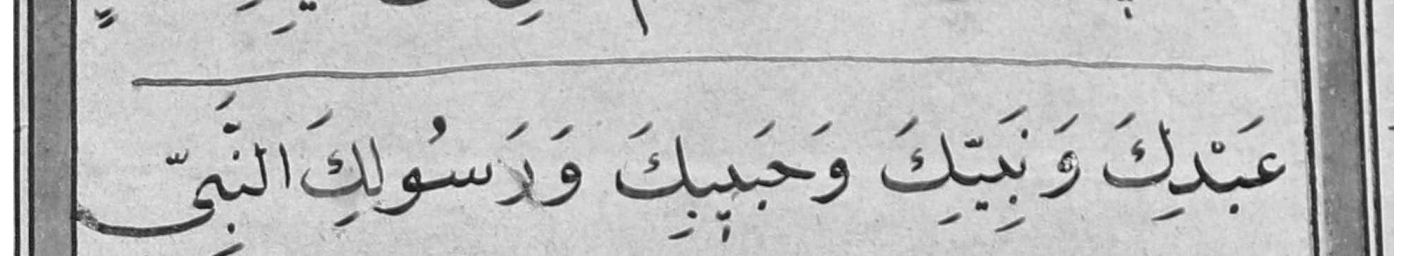

Expected Output: عبدك ونبيك وحبيبك ورسولك النبي
Predicted Output: عبدك ونبك وحبيك ورسولك النبي

Inference results saved to: /content/drive/MyDrive/qari_calligraphy_fine_tuned_HICM_preprocessed/inference_results.txt


In [31]:
import os
import pandas as pd
from PIL import Image
from IPython.display import display # Import display for showing images
import qwen_vl_utils # Ensure qwen_vl_utils is imported
import torch
from tqdm import tqdm

def run_inference(model, processor, image_paths, labels_csv_path, output_dir='/content/drive/MyDrive/qari_calligraphy_fine_tuned_HICM_preprocessed', max_new_tokens=512):
    print("Performing inference...")

    # Load the labels from the CSV file
    labels_df = pd.read_csv(labels_csv_path)
    labels_df.set_index('img_name', inplace=True)

    inference_results = []

    # Ensure the model and data are on the correct device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Get the instruction text from the first example in test_data
    instruction = "Below is an image of Arabic calligraphy. Extract the exact Arabic text from this image."

    for img_path in image_paths:
        print(f"\n--- Processing Image: {img_path} ---")
        # Load the image
        pil_image = Image.open(img_path).convert("RGB")
        display(pil_image)  # Display the image

        # Find the corresponding true label from the CSV
        img_name = os.path.basename(img_path)  # Extract the image name (without path)
        true_label = "N/A"

        if img_name in labels_df.index:
            true_label = labels_df.loc[img_name, 'label']  # Get the true label from the CSV
        else:
            print(f"Warning: No label found for image {img_name}. Using 'N/A' as true label.")

        print(f"Expected Output: {true_label}")

        # Prepare the message for the processor
        messages = [
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": instruction},
                    {"type": "image", "text": "<image>"},
                ],
            }
        ]

        text_input = processor.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

        inputs = processor(
            text=text_input,
            images=[pil_image],
            return_tensors="pt",
        ).to(device)

        # Perform inference
        with torch.no_grad():
            generated_ids = model.generate(**inputs, max_new_tokens=max_new_tokens)

        # Decode the generated text, excluding the input prompt
        predicted_text = processor.tokenizer.decode(
            generated_ids[0, inputs["input_ids"].shape[1]:],
            skip_special_tokens=True,
            clean_up_tokenization_spaces=False,
        )

        print(f"Predicted Output: {predicted_text}")
        inference_results.append((img_path, true_label, predicted_text))

    # Optionally save results to a file
    with open(f"{output_dir}/inference_results.txt", "w") as f:
        for img_path, expected, predicted in inference_results:
            f.write(f"Image: {img_path}\nExpected: {expected}\nPredicted: {predicted}\n\n")
    print("\nInference results saved to:", f"{output_dir}/inference_results.txt")


# Example usage:
# Set the path to the CSV file containing the image names and labels
labels_csv_path = "/content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test_labels.csv"

# Define the image paths (replace this with actual paths)
image_paths = [
    "/content/drive/MyDrive/EECE693_Datasets/Preprocessed_HICMA/test/images/25-2.png"
]

# Assuming `model_loaded` and `processor_loaded` are loaded from previous cells.
# If not, ensure they are defined in the global scope or passed correctly.

# Run inference
run_inference(model_loaded, processor_loaded, image_paths, labels_csv_path)